# Import Data

In [3]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime as dt
from datetime import date, timedelta
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import requests
# from darksky import forecast

In [116]:
from api_key import ds

In [117]:
# Import dataframe, rename cols
df = pd.read_csv('Datasets/ausraindata.csv')
df = df.rename({'MinTemp':'TempLow', 'MaxTemp':'TempHigh'}, axis=1)
df.shape

(142193, 24)

In [118]:
# Drop following day measured rainfall, drop data with no rain
df = df.drop('RISK_MM', axis=1)
df = df.dropna(subset=['Rainfall', 'RainToday'])
df.shape

(140787, 23)

In [119]:
df.keys()

Index(['Date', 'Location', 'TempLow', 'TempHigh', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

# Data Cleaning

In [120]:
df['WindGustDir'].fillna(method = 'bfill', inplace=True)
df['WindDir9am'].fillna(method = 'bfill', inplace=True)
df['WindDir3pm'].fillna(method = 'bfill', inplace=True)

In [121]:
# Function to turn yes and no values into 1 and 0 values
def trans_bools(df, col):
    df[col] = np.where(df[col]=='Yes', 1, 0)
    return df

In [122]:
# Function to transform date data
def trans_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df

In [123]:
# Function to transform cloud data
def trans_cloud(df):
    df['Cloud9am'] = df['Cloud9am'] / 8
    df['Cloud3pm'] = df['Cloud3pm'] / 8
    return df

In [124]:
# Function to add latitude longitude data
def lat_lon(df):
    lat_lon = [
        (-34.9281805, 138.5999312),(-35.0247822, 117.883608),(-36.0804766, 146.9162795),
        (-23.6983884, 133.8812885),(-35.8348792, 149.9957662),(-37.5622632, 143.8607215),
        (-36.7588767, 144.2825931),(-27.4689682, 153.0234991),(-16.9206657, 145.7721854),
        (-35.2975906, 149.1012676),(-31.4983333, 145.8344444),(-30.2962407, 153.1135293),
        (-37.9225444, 141.2766551),(-12.46044, 130.8410469),(-28.0023731, 153.4145987),
        (-42.8825088, 147.3281233),(-14.4642313, 132.2638568),(-41.4340813, 147.1373496),
        (-37.8142176, 144.9631608),(-37.667111000000006, 144.83348076679553),
        (-34.1847265, 142.1624972),(-29.4617202, 149.8407153),(-37.8246698, 140.7820067624113),
        (-35.5297196, 148.7726345),(-32.9272881, 151.7812534),(-35.4325283, 141.2833187),
        (-33.2816667, 151.5677778),(-29.0328038, 167.9483137),(-34.4693354, 138.9939006),
        (-31.6739604, 116.01754351808194),(-33.7510792, 150.6941684),(-31.9527121, 115.8604796),
        (-31.9431218, 115.9668059888865),(-38.363435, 141.6056055089348),
        (-37.80745, 144.99071757972087),(-38.106605, 147.06794525572298),
        (-32.9815347, 121.6439417),(-33.8548157, 151.2164539),(-33.9498935, 151.18196819346016),
        (-19.2569391, 146.8239537),(-35.4209771, 149.0921341),(-25.3455545, 131.03696147470208),
        (-35.115, 147.3677778),(-34.9776796, 116.7310063),(-37.7110022, 145.083635),
        (-32.815, 151.8427778),(-34.0263348, 115.1004768),(-34.4243941, 150.89385),
        (-31.1999142, 136.8253532)]
    city_names = sorted(df['Location'].unique())
    loc_dict = dict(zip(city_names, lat_lon))
    df['Lat_Lon'] = df['Location'].apply(lambda x: loc_dict[x])
    return df

In [125]:
# Funciton to apply data cleaning
def clean_data(df):
    for col in ['RainToday', 'RainTomorrow']:
        df = trans_bools(df, col)
    df = trans_date(df)
    df = trans_cloud(df)
    df = lat_lon(df)
    return df

df = clean_data(df)

# Fill in Missing Data

In [126]:
conversions = {
    'Date':'x', 'Location':'x', 'TempLow':'((x-32)/1.8)', 'TempHigh':'((x-32)/1.8)',
    'Rainfall':'(x*25.4)','Sunshine':'x', 'WindGustDir':'x', 'WindGustSpeed':'(x*1.609)',
    'WindDir9am':'x', 'WindDir3pm':'x', 'WindSpeed9am':'(x*1.609)', 'WindSpeed3pm':'(x*1.609)',
    'Humidity9am':'x', 'Humidity3pm':'x', 'Pressure9am':'x', 'Pressure3pm':'x', 'Cloud9am':'x',
    'Cloud3pm':'x', 'Temp9am':'((x-32)/1.8)', 'Temp3pm':'((x-32)/1.8)', 'RainToday':'x',
    'RainTomorrow':'x'}

In [127]:
# List of dataframes per city
cities = []
for location, df_location in df.groupby('Location'):
    cities.append(df_location)
city_names = sorted(df['Location'].unique())
cities = dict(zip(city_names, cities))
len(cities)

49

In [128]:
# Columns with null values
nulls = df.isnull().sum()
nulls

Date                 0
Location             0
TempLow            468
TempHigh           307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustDir          0
WindGustSpeed     9105
WindDir9am           0
WindDir3pm           0
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
Temp3pm           2624
RainToday            0
RainTomorrow         0
Lat_Lon              0
dtype: int64

In [129]:
cities['Adelaide'].isnull().sum()

Date                0
Location            0
TempLow             1
TempHigh            0
Rainfall            0
Evaporation      1372
Sunshine         1368
WindGustDir         0
WindGustSpeed      20
WindDir9am          0
WindDir3pm          0
WindSpeed9am        3
WindSpeed3pm        5
Humidity9am         3
Humidity3pm         5
Pressure9am         6
Pressure3pm         7
Cloud9am         3020
Cloud3pm         3020
Temp9am             3
Temp3pm             4
RainToday           0
RainTomorrow        0
Lat_Lon             0
dtype: int64

In [19]:
# Dark Sky API loop
for city in cities.values():
    loc_call = ds, city['Lat_Lon'].iloc[0][0], city['Lat_Lon'].iloc[0][1]
    for i, r in city.iterrows():
        if city.isnull().loc[i].any():
            try:
                date_call = r['Date'].isoformat()
                api_call = forecast(*loc_call, time=date_call)
                api_dict = {
                    'TempLow':(api_call.daily.data[0].temperatureMin-32)/1.8,
                    'TempHigh':(api_call.daily.data[0].temperatureMax-32)/1.8,
                    'Rainfall':city['Rainfall'].median(),
                    'Evaporation':city['Evaporation'].median(),
                    'Sunshine':city['Evaporation'].median(),
                    'WindGustSpeed':api_call.daily.data[0].windGust*1.609,
                    'WindSpeed9am':api_call.hourly.data[9].windSpeed*1.609,
                    'WindSpeed3pm':api_call.hourly.data[15].windSpeed*1.609,
                    'Humidity9am':api_call.hourly.data[9].humidity*100,
                    'Humidity3pm':api_call.hourly.data[15].humidity*100,
                    'Pressure9am':api_call.hourly.data[9].pressure,
                    'Pressure3pm':api_call.hourly.data[15].pressure,
                    'Cloud9am':api_call.hourly.data[9].cloudCover,
                    'Cloud3pm':api_call.hourly.data[15].cloudCover,
                    'Temp9am':(api_call.hourly.data[9].temperature-32)/1.8,
                    'Temp3pm':(api_call.hourly.data[15].temperature-32)/1.8}
                # df.isnull().iloc[i]
                for c in list(city.columns):
                    if pd.isnull(r[c]):
                        city[c][i] = api_dict[c]
                        print(i, c, city[c][i])
                        # r[c] = api_dict[c]
                        # print(i, c, r[c])
            except:
                print(i, 'ERROR')
    filename = city['Location'].iloc[0]
    city.to_csv(f'{filename}.csv')

93856 Cloud9am 0.77
93856 Cloud3pm 0.78
93857 Cloud9am 0.74
93857 Cloud3pm 0.42


/Users/eric/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


93858 Cloud9am 0.76
93858 Cloud3pm 0.79
93859 Cloud9am 0.18
93859 Cloud3pm 0.79
93861 Cloud9am 0.78
93861 Cloud3pm 0.79
93862 Cloud9am 0.76
93862 Cloud3pm 0.78
93863 Cloud9am 0.79
93863 Cloud3pm 0.73
93864 Cloud9am 0.8
93864 Cloud3pm 0.43
93866 Cloud9am 0.59
93866 Cloud3pm 0.78
93867 Cloud9am 0.79
93867 Cloud3pm 0.77
93868 Cloud9am 0.74
93868 Cloud3pm 0.69
93869 Cloud9am 0.72
93869 Cloud3pm 0.78
93871 Cloud9am 0.46
93871 Cloud3pm 0.78
93872 WindSpeed9am 4.63392
93872 Cloud9am 0.59
93872 Cloud3pm 0.67
93873 Cloud9am 0.57
93873 Cloud3pm 0.23
93874 Cloud9am 0.62
93874 Cloud3pm 0.86
93876 Evaporation 4.2
93876 Cloud9am 0.54
93876 Cloud3pm 0.56
93877 Cloud9am 0.18
93877 Cloud3pm 0.78
93878 Cloud9am 1.0
93878 Cloud3pm 1.0
93879 Cloud9am 0.76
93879 Cloud3pm 0.17
93880 Cloud9am 0.74
93880 Cloud3pm 0.9
93882 Cloud9am 0.78
93882 Cloud3pm 0.41
93883 Cloud9am 0.67
93883 Cloud3pm 0.8
93884 Cloud9am 0.79
93884 Cloud3pm 0.79
93885 Cloud9am 0.55
93885 Cloud3pm 0.68
93887 Cloud9am 0.48
93887 Cloud3pm 0

94059 Evaporation 4.2
94059 Cloud9am 0.12
94059 Cloud3pm 0.25
94060 Evaporation 4.2
94060 Cloud9am 0.74
94060 Cloud3pm 0.76
94061 Cloud9am 0.7
94061 Cloud3pm 0.45
94062 Cloud9am 0.56
94062 Cloud3pm 0.8
94063 Cloud9am 0.76
94063 Cloud3pm 0.75
94064 Cloud9am 0.19
94064 Cloud3pm 0.18
94065 ERROR
94066 ERROR
94067 Evaporation 4.2
94067 Cloud9am 0.54
94067 Cloud3pm 0.25
94068 ERROR
94069 ERROR
94070 ERROR
94071 ERROR
94072 Cloud9am 0.78
94072 Cloud3pm 0.7
94073 Evaporation 4.2
94073 Cloud9am 0.74
94073 Cloud3pm 0.18
94074 Evaporation 4.2
94074 Cloud9am 0.0
94074 Cloud3pm 0.13
94075 Cloud9am 0.4
94075 Cloud3pm 0.18
94076 Cloud9am 0.6
94076 Cloud3pm 0.59
94077 Cloud9am 0.7
94077 Cloud3pm 0.82
94078 Cloud9am 0.87
94078 Cloud3pm 0.62
94079 ERROR
94080 Cloud9am 0.2
94080 Cloud3pm 0.12
94081 ERROR
94082 ERROR
94083 ERROR
94084 Cloud9am 0.6
94084 Cloud3pm 0.75
94085 Cloud9am 0.58
94085 Cloud3pm 0.78
94086 Cloud9am 0.76
94086 Cloud3pm 0.53
94087 Evaporation 4.2
94087 Cloud9am 0.75
94087 Cloud3pm 0.

94242 Cloud9am 0.88
94242 Cloud3pm 0.83
94243 Cloud9am 0.43
94243 Cloud3pm 0.26
94244 Cloud9am 0.77
94244 Cloud3pm 0.33
94245 Cloud9am 0.8
94245 Cloud3pm 0.16
94246 Cloud9am 0.18
94246 Cloud3pm 0.18
94247 Evaporation 4.2
94247 Cloud9am 0.24
94247 Cloud3pm 0.72
94248 Evaporation 4.2
94248 Cloud9am 0.69
94248 Cloud3pm 0.4
94249 Cloud9am 0.45
94249 Cloud3pm 0.7
94250 Cloud9am 0.18
94250 Cloud3pm 0.18
94251 WindGustSpeed 21.11008
94251 Cloud9am 0.79
94251 Cloud3pm 0.63
94252 Cloud9am 0.78
94252 Cloud3pm 0.3
94253 Sunshine 4.2
94253 Cloud9am 1.0
94253 Cloud3pm 0.78
94254 Evaporation 4.2
94254 Sunshine 4.2
94254 Cloud9am 0.78
94254 Cloud3pm 0.76
94255 Evaporation 4.2
94255 Cloud9am 0.3
94255 Cloud3pm 0.42
94256 Cloud9am 0.78
94256 Cloud3pm 0.79
94257 Cloud9am 0.78
94257 Cloud3pm 0.76
94258 Cloud9am 0.64
94258 Cloud3pm 0.8
94259 Cloud9am 0.47
94259 Cloud3pm 0.49
94260 Cloud9am 0.56
94260 Cloud3pm 1.0
94261 Evaporation 4.2
94261 Cloud9am 0.79
94261 Cloud3pm 0.79
94262 Evaporation 4.2
94262 Clo

94413 Evaporation 4.2
94413 Sunshine 4.2
94413 Cloud9am 0.0
94413 Cloud3pm 0.12
94414 Evaporation 4.2
94414 Cloud9am 0.75
94414 Cloud3pm 0.12
94415 Cloud9am 0.18
94415 Cloud3pm 0.12
94416 Cloud9am 0.87
94416 Cloud3pm 0.77
94417 Cloud9am 0.83
94417 Cloud3pm 0.82
94418 Cloud9am 0.78
94418 Cloud3pm 0.76
94419 Cloud9am 0.79
94419 Cloud3pm 0.17
94420 Evaporation 4.2
94420 Cloud9am 0.18
94420 Cloud3pm 0.12
94421 Evaporation 4.2
94421 Cloud9am 0.5
94421 Cloud3pm 0.12
94422 Cloud9am 0.13
94422 Cloud3pm 0.28
94423 Cloud9am 0.14
94423 Cloud3pm 0.75
94424 Cloud9am 0.75
94424 Cloud3pm 0.41
94425 Cloud9am 0.8
94425 Cloud3pm 0.77
94426 Cloud9am 0.69
94426 Cloud3pm 0.76
94427 Evaporation 4.2
94427 Cloud9am 0.76
94427 Cloud3pm 0.72
94428 Evaporation 4.2
94428 Cloud9am 0.75
94428 Cloud3pm 0.19
94429 Cloud9am 0.79
94429 Cloud3pm 0.43
94430 Cloud9am 0.0
94430 Cloud3pm 0.16
94431 Cloud9am 0.75
94431 Cloud3pm 0.12
94432 Cloud9am 0.21
94432 Cloud3pm 0.12
94433 Cloud9am 0.12
94433 Cloud3pm 0.76
94434 Evapora

94589 Cloud9am 0.91
94589 Cloud3pm 0.61
94590 Cloud9am 0.72
94590 Cloud3pm 0.8
94591 Cloud9am 0.78
94591 Cloud3pm 0.78
94592 Evaporation 4.2
94592 Cloud9am 0.47
94592 Cloud3pm 0.51
94593 Cloud9am 0.78
94593 Cloud3pm 0.76
94594 Cloud9am 0.79
94594 Cloud3pm 1.0
94595 Cloud9am 0.79
94595 Cloud3pm 0.8
94596 Cloud9am 0.79
94596 Cloud3pm 0.52
94598 Cloud9am 0.79
94598 Cloud3pm 0.79
94599 Cloud9am 0.42
94599 Cloud3pm 0.4
94600 Cloud9am 0.58
94600 Cloud3pm 0.42
94601 Cloud9am 0.79
94601 Cloud3pm 0.78
94602 Cloud9am 0.76
94602 Cloud3pm 0.63
94603 Evaporation 4.2
94603 Cloud9am 0.79
94603 Cloud3pm 0.77
94604 Evaporation 4.2
94604 Cloud9am 0.65
94604 Cloud3pm 0.78
94605 WindGustSpeed 18.56786
94605 Cloud9am 0.78
94605 Cloud3pm 0.77
94606 Cloud9am 0.87
94606 Cloud3pm 0.71
94607 Cloud9am 0.79
94607 Cloud3pm 0.37
94608 Cloud9am 0.18
94608 Cloud3pm 0.78
94609 Cloud9am 0.79
94609 Cloud3pm 0.76
94610 Evaporation 4.2
94610 Cloud9am 0.51
94610 Cloud3pm 0.19
94611 Evaporation 4.2
94611 Sunshine 4.2
94611 

94768 Evaporation 4.2
94768 Cloud9am 0.46
94768 Cloud3pm 0.25
94769 Cloud9am 0.59
94769 Cloud3pm 0.49
94770 Cloud9am 0.2
94770 Cloud3pm 0.12
94771 Evaporation 4.2
94771 Cloud9am 0.13
94771 Cloud3pm 0.13
94772 Evaporation 4.2
94772 Cloud9am 0.0
94772 Cloud3pm 0.24
94773 Cloud9am 0.12
94773 Cloud3pm 0.12
94774 Cloud9am 0.25
94774 Cloud3pm 0.32
94775 Cloud9am 0.61
94775 Cloud3pm 0.61
94776 Cloud9am 0.76
94776 Cloud3pm 0.73
94777 Cloud9am 0.77
94777 Cloud3pm 0.32
94778 Evaporation 4.2
94778 Cloud9am 0.77
94778 Cloud3pm 0.79
94779 Evaporation 4.2
94779 Cloud9am 0.19
94779 Cloud3pm 0.18
94780 Cloud9am 0.12
94780 Cloud3pm 0.12
94781 Cloud9am 0.21
94781 Cloud3pm 0.18
94782 Cloud9am 0.49
94782 Cloud3pm 0.63
94783 Cloud9am 0.27
94783 Cloud3pm 0.88
94784 Cloud9am 0.78
94784 Cloud3pm 0.79
94785 Evaporation 4.2
94785 Cloud9am 0.79
94785 Cloud3pm 0.7
94786 Evaporation 4.2
94786 Cloud9am 0.45
94786 Cloud3pm 0.19
94787 Cloud9am 0.76
94787 Cloud3pm 0.87
94788 Cloud9am 0.65
94788 Cloud3pm 0.5
94789 Clou

94953 Cloud9am 0.18
94953 Cloud3pm 0.29
94954 Cloud9am 0.9
94954 Cloud3pm 0.41
94955 Cloud9am 0.3
94955 Cloud3pm 0.8
94956 Evaporation 4.2
94956 Cloud9am 0.77
94956 Cloud3pm 0.52
94957 Evaporation 4.2
94957 Cloud9am 0.62
94957 Cloud3pm 0.48
94958 Cloud9am 0.78
94958 Cloud3pm 0.75
94959 Cloud9am 0.24
94959 Cloud3pm 0.36
94960 Cloud9am 0.21
94960 Cloud3pm 0.75
94961 Cloud9am 0.37
94961 Cloud3pm 0.35
94962 Cloud9am 0.49
94962 Cloud3pm 0.19
94963 Evaporation 4.2
94963 Cloud9am 0.13
94963 Cloud3pm 0.0
94964 Evaporation 4.2
94964 Cloud9am 0.31
94964 Cloud3pm 0.08
94965 Cloud9am 0.99
94965 Cloud3pm 0.8
94966 Cloud9am 0.74
94966 Cloud3pm 0.49
94967 Cloud9am 0.76
94967 Cloud3pm 0.19
94968 Cloud9am 0.35
94968 Cloud3pm 0.12
94969 Cloud9am 0.42
94969 Cloud3pm 1.0
94970 Evaporation 4.2
94970 Cloud9am 0.78
94970 Cloud3pm 0.6
94971 Evaporation 4.2
94971 Cloud9am 0.18
94971 Cloud3pm 0.72
94972 Cloud9am 0.72
94972 Cloud3pm 0.72
94973 Cloud9am 0.87
94973 Cloud3pm 0.23
94974 Cloud9am 0.44
94974 Cloud3pm 

95131 Cloud9am 0.8
95131 Cloud3pm 0.19
95132 Cloud9am 0.28
95132 Cloud3pm 0.7
95133 Cloud9am 0.32
95133 Cloud3pm 0.12
95134 Cloud9am 0.0
95134 Cloud3pm 0.12
95135 Cloud9am 0.02
95135 Cloud3pm 0.12
95136 Evaporation 4.2
95136 Cloud9am 0.33
95136 Cloud3pm 0.18
95137 Evaporation 4.2
95137 Cloud9am 0.84
95137 Cloud3pm 0.6
95138 Evaporation 4.2
95138 Cloud9am 0.0
95138 Cloud3pm 0.0
95139 Cloud9am 0.23
95139 Cloud3pm 0.72
95140 Cloud9am 0.88
95140 Cloud3pm 0.49
95141 Cloud9am 0.72
95141 Cloud3pm 0.72
95142 Cloud9am 0.68
95142 Cloud3pm 0.44
95143 Evaporation 4.2
95143 Cloud9am 0.32
95143 Cloud3pm 0.39
95144 Evaporation 4.2
95144 Sunshine 4.2
95144 Cloud9am 0.17
95144 Cloud3pm 0.12
95145 Cloud9am 0.73
95145 Cloud3pm 0.24
95146 Cloud9am 0.36
95146 Cloud3pm 0.51
95147 Cloud9am 0.48
95147 Cloud3pm 0.47
95148 Cloud9am 0.76
95148 Cloud3pm 0.77
95149 Cloud9am 0.78
95149 Cloud3pm 0.78
95150 Evaporation 4.2
95150 Cloud9am 0.78
95150 Cloud3pm 0.43
95151 Evaporation 4.2
95151 Cloud9am 0.77
95151 Cloud3p

95277 Sunshine 4.2
95277 Cloud9am 0.49
95277 Cloud3pm 0.35
95278 Sunshine 4.2
95278 Cloud9am 0.47
95278 Cloud3pm 0.65
95280 Sunshine 4.2
95280 Cloud9am 0.88
95280 Cloud3pm 0.88
95281 Sunshine 4.2
95281 Cloud9am 0.21
95281 Cloud3pm 0.2
95282 Sunshine 4.2
95282 Cloud9am 0.85
95282 Cloud3pm 0.78
95283 Sunshine 4.2
95283 Cloud9am 0.75
95283 Cloud3pm 0.78
95284 Sunshine 4.2
95284 Cloud9am 0.67
95284 Cloud3pm 0.5
95285 Evaporation 4.2
95285 Sunshine 4.2
95285 Cloud9am 0.16
95285 Cloud3pm 0.8
95286 Evaporation 4.2
95286 Sunshine 4.2
95286 Cloud9am 0.6
95286 Cloud3pm 0.6
95287 Sunshine 4.2
95287 Cloud9am 0.9
95287 Cloud3pm 0.76
95288 Sunshine 4.2
95288 Cloud9am 0.78
95288 Cloud3pm 0.78
95289 Sunshine 4.2
95289 Cloud9am 0.57
95289 Cloud3pm 0.87
95290 Sunshine 4.2
95290 Cloud9am 0.76
95290 Cloud3pm 0.78
95291 Sunshine 4.2
95291 Cloud9am 0.74
95291 Cloud3pm 0.78
95292 Evaporation 4.2
95292 Sunshine 4.2
95292 Cloud9am 0.63
95292 Cloud3pm 0.79
95293 Evaporation 4.2
95293 Sunshine 4.2
95293 Cloud9am

95415 Cloud9am 0.56
95415 Cloud3pm 0.38
95416 Cloud9am 0.91
95416 Cloud3pm 0.79
95417 Cloud9am 0.17
95417 Cloud3pm 0.59
95418 Evaporation 4.2
95418 Cloud9am 0.71
95418 Cloud3pm 0.03
95419 Evaporation 4.2
95419 Cloud9am 0.17
95419 Cloud3pm 0.09
95420 Cloud9am 0.0
95420 Cloud3pm 0.33
95421 Cloud9am 0.12
95421 Cloud3pm 0.75
95422 Cloud9am 0.13
95422 Cloud3pm 0.82
95423 Cloud9am 0.84
95423 Cloud3pm 0.73
95425 Evaporation 4.2
95425 Cloud9am 0.13
95425 Cloud3pm 0.47
95426 Evaporation 4.2
95426 Cloud9am 0.61
95426 Cloud3pm 0.26
95427 Cloud9am 0.0
95427 Cloud3pm 0.12
95428 Cloud9am 0.62
95428 Cloud3pm 0.21
95429 Cloud9am 0.78
95429 Cloud3pm 0.18
95431 Evaporation 4.2
95431 Sunshine 4.2
95431 Cloud9am 0.76
95431 Cloud3pm 0.6
95432 Cloud9am 0.0
95432 Cloud3pm 0.12
95433 Cloud9am 0.47
95433 Cloud3pm 0.13
95434 Cloud9am 0.6
95434 Cloud3pm 0.62
95435 Cloud9am 0.49
95435 Cloud3pm 0.78
95436 Cloud9am 0.74
95436 Cloud3pm 0.77
95437 Evaporation 4.2
95437 Cloud9am 0.75
95437 Cloud3pm 0.21
95438 Evaporat

95615 Cloud9am 0.77
95615 Cloud3pm 0.65
95616 Cloud9am 0.78
95616 Cloud3pm 0.36
95617 Cloud9am 0.47
95617 Cloud3pm 0.13
95618 Evaporation 4.2
95618 Cloud9am 0.74
95618 Cloud3pm 0.5
95619 Evaporation 4.2
95619 Cloud9am 0.75
95619 Cloud3pm 0.47
95620 Evaporation 4.2
95620 Cloud9am 0.19
95620 Cloud3pm 0.41
95621 ERROR
95622 Cloud9am 0.13
95622 Cloud3pm 0.88
95623 Cloud9am 0.72
95623 Cloud3pm 0.79
95625 Evaporation 4.2
95625 Cloud9am 0.81
95625 Cloud3pm 0.42
95626 Cloud9am 0.76
95626 Cloud3pm 0.6
95627 Cloud9am 0.76
95627 Cloud3pm 0.13
95628 Cloud9am 0.86
95628 Cloud3pm 0.87
95629 Cloud9am 0.6
95629 Cloud3pm 0.18
95631 Cloud9am 0.93
95631 Cloud3pm 0.76
95632 Cloud9am 0.77
95632 Cloud3pm 0.81
95633 Cloud9am 0.78
95633 Cloud3pm 0.54
95634 Cloud9am 0.3
95634 Cloud3pm 0.78
95636 Evaporation 4.2
95636 Cloud9am 0.88
95636 Cloud3pm 0.96
95637 Cloud9am 0.8
95637 Cloud3pm 0.57
95638 Cloud9am 0.79
95638 Cloud3pm 0.72
95639 Cloud9am 0.79
95639 Cloud3pm 0.19
95640 Cloud9am 0.18
95640 Cloud3pm 0.15
956

95821 Sunshine 4.2
95821 Cloud9am 0.6
95821 Cloud3pm 0.33
95822 Sunshine 4.2
95822 Cloud9am 0.71
95822 Cloud3pm 0.59
95823 Sunshine 4.2
95823 Cloud9am 0.5
95823 Cloud3pm 0.59
95824 Sunshine 4.2
95824 Cloud9am 0.77
95824 Cloud3pm 0.22
95826 Sunshine 4.2
95826 Cloud9am 0.76
95826 Cloud3pm 0.87
95827 Sunshine 4.2
95827 Cloud9am 0.25
95827 Cloud3pm 0.7
95828 Sunshine 4.2
95828 Cloud9am 0.13
95828 Cloud3pm 0.72
95829 Sunshine 4.2
95829 Cloud9am 0.71
95829 Cloud3pm 0.69
95831 Sunshine 4.2
95831 Cloud9am 0.73
95831 Cloud3pm 0.82
95832 Sunshine 4.2
95832 Cloud9am 0.5
95832 Cloud3pm 0.62
95833 Sunshine 4.2
95833 Cloud9am 0.83
95833 Cloud3pm 0.75
95834 Sunshine 4.2
95834 Cloud9am 0.78
95834 Cloud3pm 0.79
95835 Sunshine 4.2
95835 Cloud9am 0.13
95835 Cloud3pm 0.19
95836 Evaporation 4.2
95836 Sunshine 4.2
95836 Cloud9am 0.77
95836 Cloud3pm 1.0
95837 Evaporation 4.2
95837 Sunshine 4.2
95837 Cloud9am 0.59
95837 Cloud3pm 0.79
95838 Sunshine 4.2
95838 Cloud9am 0.73
95838 Cloud3pm 0.79
95839 Sunshine 4.

95964 Evaporation 4.2
95964 Sunshine 4.2
95964 Cloud9am 0.81
95964 Cloud3pm 0.75
95965 Sunshine 4.2
95965 Cloud9am 0.8
95965 Cloud3pm 0.29
95966 Sunshine 4.2
95966 Cloud9am 0.73
95966 Cloud3pm 0.15
95967 Sunshine 4.2
95967 Cloud9am 0.13
95967 Cloud3pm 0.13
95968 Sunshine 4.2
95968 Cloud9am 0.81
95968 Cloud3pm 0.13
95969 ERROR
95970 Evaporation 4.2
95970 Sunshine 4.2
95970 Cloud9am 0.64
95970 Cloud3pm 0.19
95971 Sunshine 4.2
95971 Cloud9am 0.57
95971 Cloud3pm 0.73
95972 Sunshine 4.2
95972 Cloud9am 0.6
95972 Cloud3pm 0.78
95973 Sunshine 4.2
95973 Cloud9am 0.74
95973 Cloud3pm 0.29
95974 Sunshine 4.2
95974 Cloud9am 0.76
95974 Cloud3pm 0.29
95975 ERROR
95976 Evaporation 4.2
95976 Sunshine 4.2
95976 Cloud9am 0.6
95976 Cloud3pm 0.76
95977 Evaporation 4.2
95977 Sunshine 4.2
95977 Cloud9am 0.62
95977 Cloud3pm 0.86
95978 Sunshine 4.2
95978 Cloud9am 0.85
95978 Cloud3pm 0.38
95979 Sunshine 4.2
95979 Cloud9am 0.49
95979 Cloud3pm 0.71
95980 Sunshine 4.2
95980 Cloud9am 0.25
95980 Cloud3pm 0.22
95981 

96107 Sunshine 4.2
96107 Cloud9am 0.87
96107 Cloud3pm 0.98
96108 Sunshine 4.2
96108 Cloud9am 0.17
96108 Cloud3pm 0.25
96109 Sunshine 4.2
96109 Cloud9am 0.75
96109 Cloud3pm 0.44
96110 ERROR
96111 Sunshine 4.2
96111 Cloud9am 0.79
96111 Cloud3pm 0.28
96112 Evaporation 4.2
96112 Sunshine 4.2
96112 Cloud9am 0.78
96112 Cloud3pm 0.53
96113 Evaporation 4.2
96113 Sunshine 4.2
96113 Cloud9am 0.48
96113 Cloud3pm 0.3
96114 Evaporation 4.2
96114 Sunshine 4.2
96114 Cloud9am 0.72
96114 Cloud3pm 0.38
96115 Sunshine 4.2
96115 Cloud9am 0.31
96115 Cloud3pm 0.19
96116 Sunshine 4.2
96116 Pressure9am 1018.0
96116 Pressure3pm 1016.9
96116 Cloud9am 0.41
96116 Cloud3pm 0.19
96117 Sunshine 4.2
96117 Pressure9am 1021.6
96117 Pressure3pm 1019.9
96117 Cloud9am 0.59
96117 Cloud3pm 0.74
96118 ERROR
96119 ERROR
96120 Evaporation 4.2
96120 Sunshine 4.2
96120 Cloud9am 0.47
96120 Cloud3pm 0.5
96121 Sunshine 4.2
96121 Cloud9am 0.84
96121 Cloud3pm 0.86
96122 Sunshine 4.2
96122 Cloud9am 0.58
96122 Cloud3pm 0.77
96123 Sunsh

96229 Evaporation 4.2
96229 Sunshine 4.2
96229 Cloud9am 0.13
96229 Cloud3pm 0.25
96230 Evaporation 4.2
96230 Sunshine 4.2
96230 Cloud9am 0.44
96230 Cloud3pm 0.75
96231 Evaporation 4.2
96231 Sunshine 4.2
96231 Cloud9am 0.76
96231 Cloud3pm 0.33
96232 Evaporation 4.2
96232 Sunshine 4.2
96232 Cloud9am 0.9
96232 Cloud3pm 0.75
96233 Evaporation 4.2
96233 Sunshine 4.2
96233 Cloud9am 0.26
96233 Cloud3pm 0.74
96234 Evaporation 4.2
96234 Sunshine 4.2
96234 Cloud9am 0.81
96234 Cloud3pm 0.75
96235 Evaporation 4.2
96235 Sunshine 4.2
96235 Cloud9am 1.0
96235 Cloud3pm 0.78
96236 Evaporation 4.2
96236 Sunshine 4.2
96236 Cloud9am 0.66
96236 Cloud3pm 0.75
96237 Evaporation 4.2
96237 Sunshine 4.2
96237 Cloud9am 0.76
96237 Cloud3pm 0.77
96238 Evaporation 4.2
96238 Sunshine 4.2
96238 Cloud9am 0.89
96238 Cloud3pm 0.75
96239 Evaporation 4.2
96239 Sunshine 4.2
96239 Cloud9am 0.47
96239 Cloud3pm 0.63
96240 Evaporation 4.2
96240 Sunshine 4.2
96240 Cloud9am 0.2
96240 Cloud3pm 0.75
96241 Evaporation 4.2
96241 Sun

96352 Evaporation 4.2
96352 Sunshine 4.2
96352 Cloud9am 0.76
96352 Cloud3pm 0.75
96353 Evaporation 4.2
96353 Sunshine 4.2
96353 Cloud9am 0.87
96353 Cloud3pm 0.61
96354 ERROR
96355 Evaporation 4.2
96355 Sunshine 4.2
96355 Cloud9am 0.59
96355 Cloud3pm 0.25
96356 Evaporation 4.2
96356 Sunshine 4.2
96356 Cloud9am 0.84
96356 Cloud3pm 0.88
96357 Evaporation 4.2
96357 Sunshine 4.2
96357 Cloud9am 0.76
96357 Cloud3pm 0.88
96358 ERROR
96359 ERROR
96360 Evaporation 4.2
96360 Sunshine 4.2
96360 Cloud9am 0.75
96360 Cloud3pm 0.44
96361 Evaporation 4.2
96361 Sunshine 4.2
96361 Cloud9am 0.17
96361 Cloud3pm 0.57
96362 ERROR
96363 Evaporation 4.2
96363 Sunshine 4.2
96363 Cloud9am 0.13
96363 Cloud3pm 0.75
96364 Evaporation 4.2
96364 Sunshine 4.2
96364 Cloud9am 0.36
96364 Cloud3pm 0.13
96365 Evaporation 4.2
96365 Sunshine 4.2
96365 Cloud9am 0.83
96365 Cloud3pm 0.88
96366 Evaporation 4.2
96366 Sunshine 4.2
96366 Cloud9am 0.25
96366 Cloud3pm 0.13
96368 Evaporation 4.2
96368 Sunshine 4.2
96368 Cloud9am 0.62


96504 Evaporation 4.2
96504 Sunshine 4.2
96504 Cloud9am 0.77
96504 Cloud3pm 0.75
96505 Evaporation 4.2
96505 Sunshine 4.2
96505 Cloud9am 0.76
96505 Cloud3pm 0.75
96506 Evaporation 4.2
96506 Sunshine 4.2
96506 Cloud9am 0.74
96506 Cloud3pm 0.75
96507 Evaporation 4.2
96507 Sunshine 4.2
96507 Cloud9am 0.76
96507 Cloud3pm 0.75
96508 Evaporation 4.2
96508 Sunshine 4.2
96508 Cloud9am 0.75
96508 Cloud3pm 0.19
96509 Evaporation 4.2
96509 Sunshine 4.2
96509 Cloud9am 0.88
96509 Cloud3pm 0.31
96510 Evaporation 4.2
96510 Sunshine 4.2
96510 Cloud9am 0.76
96510 Cloud3pm 0.75
96511 Evaporation 4.2
96511 Sunshine 4.2
96511 Cloud9am 0.85
96511 Cloud3pm 0.84
96512 Evaporation 4.2
96512 Sunshine 4.2
96512 Cloud9am 0.84
96512 Cloud3pm 0.88
96513 Evaporation 4.2
96513 Sunshine 4.2
96513 Cloud9am 0.91
96513 Cloud3pm 0.75
96514 Evaporation 4.2
96514 Sunshine 4.2
96514 Cloud9am 0.19
96514 Cloud3pm 0.13
96515 Evaporation 4.2
96515 Sunshine 4.2
96515 Cloud9am 0.84
96515 Cloud3pm 0.88
96516 Evaporation 4.2
96516 

96613 Evaporation 4.2
96613 Sunshine 4.2
96613 Cloud9am 0.44
96613 Cloud3pm 0.88
96614 Evaporation 4.2
96614 Sunshine 4.2
96614 Cloud9am 0.63
96614 Cloud3pm 0.89
96615 Evaporation 4.2
96615 Sunshine 4.2
96615 Cloud9am 0.76
96615 Cloud3pm 0.75
96616 Evaporation 4.2
96616 Sunshine 4.2
96616 Cloud9am 0.79
96616 Cloud3pm 0.75
96617 Evaporation 4.2
96617 Sunshine 4.2
96617 Cloud9am 0.76
96617 Cloud3pm 0.75
96618 Evaporation 4.2
96618 Sunshine 4.2
96618 Cloud9am 0.86
96618 Cloud3pm 0.44
96619 Evaporation 4.2
96619 Sunshine 4.2
96619 Cloud9am 0.77
96619 Cloud3pm 0.75
96620 Evaporation 4.2
96620 Sunshine 4.2
96620 Cloud9am 0.76
96620 Cloud3pm 0.75
96621 Evaporation 4.2
96621 Sunshine 4.2
96621 Cloud9am 0.43
96621 Cloud3pm 0.75
96622 Evaporation 4.2
96622 Sunshine 4.2
96622 Cloud9am 0.75
96622 Cloud3pm 0.75
96623 Evaporation 4.2
96623 Sunshine 4.2
96623 Cloud9am 0.74
96623 Cloud3pm 0.88
96624 Evaporation 4.2
96624 Sunshine 4.2
96624 Cloud9am 0.87
96624 Cloud3pm 1.0
96625 Evaporation 4.2
96625 S

96725 Evaporation 4.2
96725 Sunshine 4.2
96725 Cloud9am 0.76
96725 Cloud3pm 0.75
96726 Evaporation 4.2
96726 Sunshine 4.2
96726 Cloud9am 1.0
96726 Cloud3pm 0.42
96727 ERROR
96728 Evaporation 4.2
96728 Sunshine 4.2
96728 Cloud9am 0.13
96728 Cloud3pm 0.75
96729 ERROR
96730 ERROR
96731 ERROR
96732 ERROR
96733 Evaporation 4.2
96733 Sunshine 4.2
96733 Cloud9am 0.76
96733 Cloud3pm 0.75
96734 Evaporation 4.2
96734 Sunshine 4.2
96734 Cloud9am 0.16
96734 Cloud3pm 0.13
96735 Evaporation 4.2
96735 Sunshine 4.2
96735 Cloud9am 0.19
96735 Cloud3pm 0.63
96736 Evaporation 4.2
96736 Sunshine 4.2
96736 Cloud9am 0.76
96736 Cloud3pm 0.19
96737 Evaporation 4.2
96737 Sunshine 4.2
96737 Cloud9am 0.2
96737 Cloud3pm 0.75
96738 ERROR
96739 ERROR
96740 ERROR
96741 Evaporation 4.2
96741 Sunshine 4.2
96741 Cloud9am 0.76
96741 Cloud3pm 0.19
96742 Evaporation 4.2
96742 Sunshine 4.2
96742 Cloud9am 0.63
96742 Cloud3pm 0.5
96743 Evaporation 4.2
96743 Sunshine 4.2
96743 Cloud9am 0.61
96743 Cloud3pm 0.75
96744 ERROR
9674

96875 Evaporation 4.2
96875 Sunshine 4.2
96875 Cloud9am 0.73
96875 Cloud3pm 0.75
96876 Evaporation 4.2
96876 Sunshine 4.2
96876 Cloud9am 0.82
96876 Cloud3pm 0.88
96877 ERROR
96878 Evaporation 4.2
96878 Sunshine 4.2
96878 Cloud9am 0.97
96878 Cloud3pm 0.75
96879 Evaporation 4.2
96879 Sunshine 4.2
96879 Cloud9am 0.88
96879 Cloud3pm 0.88
96880 Evaporation 4.2
96880 Sunshine 4.2
96880 Cloud9am 0.89
96880 Cloud3pm 0.75
96881 Evaporation 4.2
96881 Sunshine 4.2
96881 Cloud9am 0.76
96881 Cloud3pm 0.43
96882 Evaporation 4.2
96882 Sunshine 4.2
96882 Cloud9am 0.27
96882 Cloud3pm 0.44
96883 Evaporation 4.2
96883 Sunshine 4.2
96883 Cloud9am 0.75
96883 Cloud3pm 0.88
96884 Evaporation 4.2
96884 Sunshine 4.2
96884 Cloud9am 0.76
96884 Cloud3pm 0.75
96885 Evaporation 4.2
96885 Sunshine 4.2
96885 Cloud9am 0.74
96885 Cloud3pm 0.59
96886 Evaporation 4.2
96886 Sunshine 4.2
96886 Cloud9am 0.58
96886 Cloud3pm 0.75
96887 Evaporation 4.2
96887 Sunshine 4.2
96887 Cloud9am 0.75
96887 Cloud3pm 0.75
96888 Evaporatio

106112 WindGustSpeed 32.163909999999994
106113 WindGustSpeed 30.66754
106114 WindGustSpeed 35.52672
106115 WindGustSpeed 27.38518
106116 WindGustSpeed 37.29662
106117 WindGustSpeed 35.5589
106118 WindGustSpeed 24.16718
106119 WindGustSpeed 30.63536
106120 WindGustSpeed 29.15508
106121 WindGustSpeed 35.41409
106122 WindGustSpeed 25.744
106123 WindGustSpeed 22.526
106124 WindGustSpeed 22.526
106125 WindGustSpeed 22.92825
106126 WindGustSpeed 27.336909999999996
106127 WindGustSpeed 29.026359999999997
106128 WindGustSpeed 30.71581
106129 WindGustSpeed 28.99418
106130 WindGustSpeed 33.98208
106131 WindGustSpeed 28.99418
106132 WindGustSpeed 27.819609999999997
106133 WindGustSpeed 30.072210000000002
106134 WindGustSpeed 20.917
106135 ERROR
106136 WindGustSpeed 20.94918
106137 WindGustSpeed 40.32154
106138 WindGustSpeed 33.274119999999996
106139 WindGustSpeed 28.01269
106140 WindGustSpeed 27.43345
106141 WindGustSpeed 35.38191
106142 WindGustSpeed 26.645039999999998
106143 WindGustSpeed 29.20

106565 ERROR
106566 ERROR
106567 ERROR
106568 ERROR
106569 ERROR
106570 ERROR
106571 ERROR
106572 ERROR
106573 ERROR
106574 ERROR
106575 ERROR
106576 ERROR
106577 ERROR
106578 ERROR
106579 ERROR
106580 ERROR
106581 ERROR
106582 ERROR
106583 ERROR
106584 ERROR
106585 ERROR
106586 ERROR
106587 ERROR
106588 ERROR
106589 ERROR
106590 ERROR
106591 ERROR
106592 ERROR
106593 ERROR
106594 ERROR
106595 ERROR
106596 ERROR
106597 ERROR
106598 ERROR
106599 ERROR
106600 ERROR
106601 ERROR
106602 ERROR
106603 ERROR
106604 ERROR
106605 ERROR
106606 ERROR
106607 ERROR
106608 ERROR
106609 ERROR
106610 ERROR
106611 ERROR
106612 ERROR
106613 ERROR
106614 ERROR
106615 ERROR
106616 ERROR
106617 ERROR
106618 ERROR
106619 ERROR
106620 ERROR
106621 ERROR
106622 ERROR
106623 ERROR
106624 ERROR
106625 ERROR
106626 ERROR
106627 ERROR
106628 ERROR
106629 ERROR
106630 ERROR
106631 ERROR
106632 ERROR
106633 ERROR
106634 ERROR
106635 ERROR
106636 ERROR
106637 ERROR
106638 ERROR
106639 ERROR
106640 ERROR
106641 ERROR

107197 ERROR
107198 ERROR
107199 ERROR
107200 ERROR
107201 ERROR
107202 ERROR
107203 ERROR
107204 ERROR
107205 ERROR
107206 ERROR
107207 ERROR
107208 ERROR
107209 ERROR
107210 ERROR
107211 ERROR
107212 ERROR
107213 ERROR
107214 ERROR
107215 ERROR
107216 ERROR
107217 ERROR
107218 ERROR
107219 ERROR
107220 ERROR
107221 ERROR
107222 ERROR
107223 ERROR
107224 ERROR
107225 ERROR
107226 ERROR
107227 ERROR
107228 ERROR
107229 ERROR
107230 ERROR
107231 ERROR
107232 ERROR
107233 ERROR
107234 ERROR
107235 ERROR
107236 ERROR
107237 ERROR
107238 ERROR
107239 ERROR
107240 ERROR
107241 ERROR
107242 ERROR
107243 ERROR
107244 ERROR
107245 ERROR
107246 ERROR
107247 ERROR
107248 ERROR
107249 ERROR
107250 ERROR
107251 ERROR
107252 ERROR
107253 ERROR
107254 ERROR
107255 ERROR
107256 ERROR
107257 ERROR
107258 ERROR
107259 ERROR
107260 ERROR
107261 ERROR
107262 ERROR
107263 ERROR
107264 ERROR
107265 ERROR
107266 ERROR
107267 ERROR
107268 ERROR
107269 ERROR
107270 ERROR
107271 ERROR
107272 ERROR
107273 ERROR

107823 ERROR
107824 ERROR
107825 ERROR
107826 ERROR
107827 ERROR
107828 ERROR
107829 ERROR
107830 ERROR
107831 ERROR
107832 ERROR
107833 ERROR
107834 ERROR
107835 ERROR
107836 ERROR
107837 ERROR
107839 ERROR
107840 ERROR
107841 ERROR
107842 ERROR
107843 ERROR
107845 ERROR
107846 ERROR
107847 ERROR
107848 ERROR
107849 ERROR
107850 ERROR
107851 ERROR
107852 ERROR
107853 ERROR
107854 ERROR
107855 ERROR
107856 ERROR
107857 ERROR
107858 ERROR
107859 ERROR
107860 ERROR
107861 ERROR
107862 ERROR
107863 ERROR
107864 ERROR
107865 ERROR
107866 ERROR
107867 ERROR
107868 ERROR
107869 ERROR
107870 ERROR
107871 ERROR
107872 ERROR
107873 ERROR
107874 ERROR
107875 ERROR
107876 ERROR
107877 ERROR
107878 ERROR
107879 ERROR
107880 ERROR
107881 ERROR
107882 ERROR
107883 ERROR
107884 ERROR
107885 ERROR
107886 ERROR
107887 ERROR
107888 ERROR
107889 ERROR
107890 ERROR
107891 ERROR
107892 ERROR
107893 ERROR
107894 ERROR
107895 ERROR
107896 ERROR
107897 ERROR
107898 ERROR
107899 ERROR
107900 ERROR
107901 ERROR

108416 ERROR
108417 ERROR
108418 ERROR
108419 ERROR
108420 ERROR
108421 ERROR
108422 ERROR
108423 ERROR
108424 ERROR
108425 ERROR
108426 ERROR
108427 ERROR
108428 ERROR
108429 ERROR
108430 ERROR
108431 ERROR
108432 ERROR
108433 ERROR
108434 ERROR
108435 ERROR
108436 ERROR
108437 ERROR
108438 ERROR
108439 ERROR
108440 ERROR
108441 ERROR
108442 ERROR
108443 ERROR
108444 WindGustSpeed 55.44614
108444 WindSpeed3pm 32.566159999999996
108444 Humidity3pm 59.0
108444 Cloud3pm 0.81
108444 Temp3pm 18.161111111111108
108445 ERROR
108446 ERROR
108447 ERROR
108448 ERROR
108449 ERROR
108450 ERROR
108451 ERROR
108452 ERROR
108453 ERROR
108454 ERROR
108455 ERROR
108456 ERROR
108457 ERROR
108458 ERROR
108459 ERROR
108460 ERROR
108461 ERROR
108462 ERROR
108463 ERROR
108464 ERROR
108465 ERROR
108466 ERROR
108467 ERROR
108468 ERROR
108469 ERROR
108470 ERROR
108471 ERROR
108472 ERROR
108473 ERROR
108474 ERROR
108475 ERROR
108476 ERROR
108477 ERROR
108478 ERROR
108479 ERROR
108480 ERROR
108481 ERROR
108482 

108798 ERROR
108799 ERROR
108800 ERROR
108801 ERROR
108802 ERROR
108803 ERROR
108804 ERROR
108805 ERROR
108806 ERROR
108807 ERROR
108808 ERROR
108809 ERROR
108810 ERROR
108811 ERROR
108812 ERROR
108813 ERROR
108816 ERROR
108817 ERROR
108818 ERROR
108819 ERROR
108820 ERROR
108821 ERROR
108822 ERROR
108823 ERROR
108824 Evaporation 3.8
108824 Sunshine 3.8
108824 WindGustSpeed 63.249790000000004
108824 WindSpeed3pm 38.85735
108824 Humidity3pm 52.0
108824 Cloud3pm 0.81
108824 Temp3pm 21.46111111111111
108825 ERROR
108826 ERROR
108827 ERROR
108828 ERROR
108829 ERROR
108830 Evaporation 3.8
108830 Sunshine 3.8
108830 WindGustSpeed 65.3254
108830 WindSpeed3pm 44.61757
108830 Humidity3pm 39.0
108830 Cloud3pm 0.69
108830 Temp3pm 20.21111111111111
108831 ERROR
108832 ERROR
108833 ERROR
108834 ERROR
108836 ERROR
108837 ERROR
108838 ERROR
108839 ERROR
108840 ERROR
108841 ERROR
108842 ERROR
108843 ERROR
108844 ERROR
108845 ERROR
108846 ERROR
108847 ERROR
108848 ERROR
108849 ERROR
108850 ERROR
108851 

528 ERROR
529 ERROR
530 ERROR
531 ERROR
532 ERROR
533 ERROR
534 ERROR
535 ERROR
536 ERROR
537 ERROR
538 ERROR
539 ERROR
540 ERROR
541 ERROR
542 ERROR
543 ERROR
544 ERROR
545 ERROR
546 ERROR
547 ERROR
548 ERROR
549 ERROR
550 ERROR
551 ERROR
552 ERROR
553 ERROR
554 ERROR
555 ERROR
556 ERROR
557 ERROR
558 ERROR
559 ERROR
560 ERROR
561 ERROR
562 ERROR
563 ERROR
564 ERROR
565 ERROR
566 ERROR
567 ERROR
568 ERROR
569 ERROR
570 ERROR
571 ERROR
572 ERROR
573 ERROR
574 ERROR
575 ERROR
576 ERROR
577 ERROR
578 ERROR
579 ERROR
580 ERROR
581 ERROR
582 ERROR
583 ERROR
584 ERROR
585 ERROR
586 ERROR
587 ERROR
588 ERROR
589 ERROR
590 ERROR
591 ERROR
592 ERROR
593 ERROR
594 ERROR
595 ERROR
596 ERROR
597 ERROR
598 ERROR
599 ERROR
600 ERROR
601 ERROR
602 ERROR
604 ERROR
605 ERROR
606 ERROR
607 ERROR
608 ERROR
609 ERROR
610 ERROR
611 ERROR
612 ERROR
613 ERROR
614 ERROR
615 ERROR
616 ERROR
617 ERROR
618 ERROR
619 ERROR
620 ERROR
621 ERROR
622 ERROR
623 ERROR
624 ERROR
625 ERROR
626 ERROR
627 ERROR
628 ERROR


1184 ERROR
1185 ERROR
1186 ERROR
1187 ERROR
1188 ERROR
1189 ERROR
1190 ERROR
1191 ERROR
1192 ERROR
1193 ERROR
1194 ERROR
1195 ERROR
1196 ERROR
1197 ERROR
1198 ERROR
1199 ERROR
1200 ERROR
1201 ERROR
1202 ERROR
1203 ERROR
1204 ERROR
1205 ERROR
1206 ERROR
1207 ERROR
1208 ERROR
1209 ERROR
1210 ERROR
1211 ERROR
1212 ERROR
1213 ERROR
1214 ERROR
1215 ERROR
1216 ERROR
1217 ERROR
1218 ERROR
1219 ERROR
1220 ERROR
1221 ERROR
1222 ERROR
1223 ERROR
1224 ERROR
1225 ERROR
1226 ERROR
1227 ERROR
1228 ERROR
1229 ERROR
1230 ERROR
1231 ERROR
1232 ERROR
1233 ERROR
1234 ERROR
1235 ERROR
1236 ERROR
1237 ERROR
1238 ERROR
1239 ERROR
1240 ERROR
1241 ERROR
1242 ERROR
1243 ERROR
1244 ERROR
1245 ERROR
1246 ERROR
1247 ERROR
1248 ERROR
1249 ERROR
1250 ERROR
1251 ERROR
1252 ERROR
1253 ERROR
1254 ERROR
1255 ERROR
1256 ERROR
1257 ERROR
1258 ERROR
1259 ERROR
1260 ERROR
1261 ERROR
1262 ERROR
1263 ERROR
1264 ERROR
1265 ERROR
1266 ERROR
1267 ERROR
1268 ERROR
1269 ERROR
1270 ERROR
1271 ERROR
1272 ERROR
1273 ERROR
1274 ERROR

1580 Evaporation nan
1580 Sunshine nan
1581 Evaporation nan
1581 Sunshine nan
1582 Evaporation nan
1582 Sunshine nan
1583 Evaporation nan
1583 Sunshine nan
1583 Cloud9am 0.63
1584 Evaporation nan
1584 Sunshine nan
1585 ERROR
1586 Evaporation nan
1586 Sunshine nan
1587 Evaporation nan
1587 Sunshine nan
1588 Evaporation nan
1588 Sunshine nan
1589 ERROR
1590 ERROR
1591 Evaporation nan
1591 Sunshine nan
1592 ERROR
1593 ERROR
1594 Evaporation nan
1594 Sunshine nan
1595 Evaporation nan
1595 Sunshine nan
1596 Evaporation nan
1596 Sunshine nan
1597 Evaporation nan
1597 Sunshine nan
1598 Evaporation nan
1598 Sunshine nan
1599 Evaporation nan
1599 Sunshine nan
1600 Evaporation nan
1600 Sunshine nan
1601 Evaporation nan
1601 Sunshine nan
1602 Evaporation nan
1602 Sunshine nan
1603 Evaporation nan
1603 Sunshine nan
1604 ERROR
1605 Evaporation nan
1605 Sunshine nan
1606 ERROR
1607 Evaporation nan
1607 Sunshine nan
1608 ERROR
1609 Evaporation nan
1609 Sunshine nan
1610 Evaporation nan
1610 Sunshine 

1770 Evaporation nan
1770 Sunshine nan
1770 Cloud9am 0.0
1770 Cloud3pm 0.0
1771 Evaporation nan
1771 Sunshine nan
1771 Cloud9am 0.0
1771 Cloud3pm 0.0
1772 Evaporation nan
1772 Sunshine nan
1773 Evaporation nan
1773 Sunshine nan
1773 Cloud9am 0.02
1773 Cloud3pm 0.0
1774 Evaporation nan
1774 Sunshine nan
1774 Cloud9am 0.0
1774 Cloud3pm 0.0
1775 Evaporation nan
1775 Sunshine nan
1775 Cloud9am 0.0
1775 Cloud3pm 0.0
1776 Evaporation nan
1776 Sunshine nan
1776 Cloud9am 0.0
1776 Cloud3pm 0.0
1777 Evaporation nan
1777 Sunshine nan
1777 Cloud9am 0.0
1777 Cloud3pm 0.0
1778 Evaporation nan
1778 Sunshine nan
1778 Cloud9am 0.04
1778 Cloud3pm 0.0
1779 Evaporation nan
1779 Sunshine nan
1779 Cloud9am 0.04
1779 Cloud3pm 0.0
1780 Evaporation nan
1780 Sunshine nan
1780 Cloud9am 0.0
1780 Cloud3pm 0.0
1781 Evaporation nan
1781 Sunshine nan
1781 Cloud9am 0.0
1781 Cloud3pm 0.0
1782 Evaporation nan
1782 Sunshine nan
1782 Cloud9am 0.02
1782 Cloud3pm 0.0
1783 Evaporation nan
1783 Sunshine nan
1783 Cloud9am 0.02

1914 Evaporation nan
1914 Sunshine nan
1915 Evaporation nan
1915 Sunshine nan
1916 Evaporation nan
1916 Sunshine nan
1917 Evaporation nan
1917 Sunshine nan
1917 Cloud3pm 0.0
1918 Evaporation nan
1918 Sunshine nan
1918 Cloud9am 0.02
1919 Evaporation nan
1919 Sunshine nan
1919 Cloud3pm 0.75
1920 Evaporation nan
1920 Sunshine nan
1920 Cloud3pm 0.0
1921 Evaporation nan
1921 Sunshine nan
1922 Evaporation nan
1922 Sunshine nan
1923 Evaporation nan
1923 Sunshine nan
1924 Evaporation nan
1924 Sunshine nan
1924 Cloud3pm 0.75
1925 Evaporation nan
1925 Sunshine nan
1925 Cloud3pm 0.44
1926 Evaporation nan
1926 Sunshine nan
1927 Evaporation nan
1927 Sunshine nan
1928 Evaporation nan
1928 Sunshine nan
1929 Evaporation nan
1929 Sunshine nan
1930 Evaporation nan
1930 Sunshine nan
1930 Cloud3pm 0.44
1931 Evaporation nan
1931 Sunshine nan
1932 Evaporation nan
1932 Sunshine nan
1933 Evaporation nan
1933 Sunshine nan
1934 Evaporation nan
1934 Sunshine nan
1935 Evaporation nan
1935 Sunshine nan
1936 Evapor

2069 Evaporation nan
2069 Sunshine nan
2069 Cloud9am 0.04
2070 Evaporation nan
2070 Sunshine nan
2070 Cloud9am 0.39
2070 Cloud3pm 0.0
2071 Evaporation nan
2071 Sunshine nan
2072 Evaporation nan
2072 Sunshine nan
2073 Evaporation nan
2073 Sunshine nan
2073 Cloud3pm 0.0
2074 Evaporation nan
2074 Sunshine nan
2074 Cloud9am 0.0
2074 Cloud3pm 0.0
2075 Evaporation nan
2075 Sunshine nan
2075 Cloud9am 0.0
2075 Cloud3pm 0.0
2076 Evaporation nan
2076 Sunshine nan
2076 Cloud3pm 0.0
2077 Evaporation nan
2077 Sunshine nan
2078 Evaporation nan
2078 Sunshine nan
2079 Evaporation nan
2079 Sunshine nan
2079 Cloud9am 0.04
2079 Cloud3pm 0.0
2080 Evaporation nan
2080 Sunshine nan
2081 Evaporation nan
2081 Sunshine nan
2081 Cloud3pm 0.0
2082 Evaporation nan
2082 Sunshine nan
2082 Cloud9am 0.11
2083 Evaporation nan
2083 Sunshine nan
2084 Evaporation nan
2084 Sunshine nan
2085 Evaporation nan
2085 Sunshine nan
2085 Cloud9am 0.07
2086 Evaporation nan
2086 Sunshine nan
2086 Cloud9am 0.04
2087 Evaporation nan
2

2208 Evaporation nan
2208 Sunshine nan
2208 Cloud9am 0.0
2208 Cloud3pm 0.0
2209 Evaporation nan
2209 Sunshine nan
2210 Evaporation nan
2210 Sunshine nan
2210 Cloud3pm 0.0
2211 Evaporation nan
2211 Sunshine nan
2211 Cloud9am 0.02
2211 Cloud3pm 0.0
2212 Evaporation nan
2212 Sunshine nan
2213 Evaporation nan
2213 Sunshine nan
2214 Evaporation nan
2214 Sunshine nan
2214 Cloud9am 0.05
2214 Cloud3pm 0.0
2215 Evaporation nan
2215 Sunshine nan
2216 Evaporation nan
2216 Sunshine nan
2217 Evaporation nan
2217 Sunshine nan
2218 Evaporation nan
2218 Sunshine nan
2218 Cloud9am 0.0
2218 Cloud3pm 0.0
2219 Evaporation nan
2219 Sunshine nan
2219 Cloud9am 0.04
2219 Cloud3pm 0.0
2220 ERROR
2221 Evaporation nan
2221 Sunshine nan
2222 Evaporation nan
2222 Sunshine nan
2223 Evaporation nan
2223 Sunshine nan
2224 Evaporation nan
2224 Sunshine nan
2225 Evaporation nan
2225 Sunshine nan
2226 Evaporation nan
2226 Sunshine nan
2226 Cloud9am 0.04
2226 Cloud3pm 0.0
2227 Evaporation nan
2227 Sunshine nan
2227 Cloud

2369 Evaporation nan
2369 Sunshine nan
2369 Cloud9am 0.0
2369 Cloud3pm 0.0
2370 Evaporation nan
2370 Sunshine nan
2370 Cloud9am 0.39
2371 Evaporation nan
2371 Sunshine nan
2371 Cloud9am 0.02
2372 Evaporation nan
2372 Sunshine nan
2373 Evaporation nan
2373 Sunshine nan
2373 Cloud9am 0.02
2374 Evaporation nan
2374 Sunshine nan
2374 Cloud9am 0.39
2374 Cloud3pm 0.0
2375 Evaporation nan
2375 Sunshine nan
2375 Cloud9am 0.02
2376 Evaporation nan
2376 Sunshine nan
2376 Cloud9am 0.02
2376 Cloud3pm 0.0
2377 Evaporation nan
2377 Sunshine nan
2377 Cloud9am 0.0
2377 Cloud3pm 0.0
2378 Evaporation nan
2378 Sunshine nan
2378 Cloud9am 0.0
2378 Cloud3pm 0.75
2379 Evaporation nan
2379 Sunshine nan
2379 Cloud9am 0.0
2379 Cloud3pm 0.0
2380 Evaporation nan
2380 Sunshine nan
2380 Cloud3pm 0.0
2381 Evaporation nan
2381 Sunshine nan
2381 Cloud9am 0.02
2381 Cloud3pm 0.0
2382 Evaporation nan
2382 Sunshine nan
2382 Cloud9am 0.0
2382 Cloud3pm 0.0
2383 Evaporation nan
2383 Sunshine nan
2383 Cloud9am 0.0
2383 Cloud3

2514 Evaporation nan
2514 Sunshine nan
2514 Cloud9am 0.0
2514 Cloud3pm 0.0
2515 Evaporation nan
2515 Sunshine nan
2515 Cloud9am 0.09
2515 Cloud3pm 0.0
2516 Evaporation nan
2516 Sunshine nan
2516 Cloud9am 0.04
2517 Evaporation nan
2517 Sunshine nan
2517 Cloud9am 0.04
2517 Cloud3pm 0.0
2518 Evaporation nan
2518 Sunshine nan
2518 Cloud3pm 0.0
2519 Evaporation nan
2519 Sunshine nan
2519 Cloud9am 0.02
2519 Cloud3pm 0.0
2520 Evaporation nan
2520 Sunshine nan
2520 Cloud9am 0.02
2520 Cloud3pm 0.0
2521 Evaporation nan
2521 Sunshine nan
2521 Cloud9am 0.11
2522 Evaporation nan
2522 Sunshine nan
2522 Cloud9am 0.0
2522 Cloud3pm 0.0
2523 Evaporation nan
2523 Sunshine nan
2523 Cloud9am 0.0
2523 Cloud3pm 0.0
2524 Evaporation nan
2524 Sunshine nan
2524 Cloud9am 0.02
2524 Cloud3pm 0.0
2525 Evaporation nan
2525 Sunshine nan
2525 Cloud9am 0.0
2525 Cloud3pm 0.0
2526 Evaporation nan
2526 Sunshine nan
2526 Cloud9am 0.13
2527 Evaporation nan
2527 Sunshine nan
2527 Cloud9am 0.0
2527 Cloud3pm 0.0
2528 Evaporati

2661 Evaporation nan
2661 Sunshine nan
2661 Cloud9am 0.45
2662 Evaporation nan
2662 Sunshine nan
2662 Cloud9am 0.05
2663 Evaporation nan
2663 Sunshine nan
2664 Evaporation nan
2664 Sunshine nan
2665 Evaporation nan
2665 Sunshine nan
2666 Evaporation nan
2666 Sunshine nan
2667 Evaporation nan
2667 Sunshine nan
2667 Cloud3pm 0.75
2668 Evaporation nan
2668 Sunshine nan
2669 Evaporation nan
2669 Sunshine nan
2670 Evaporation nan
2670 Sunshine nan
2671 Evaporation nan
2671 Sunshine nan
2671 Cloud9am 0.04
2671 Cloud3pm 0.0
2672 Evaporation nan
2672 Sunshine nan
2672 Cloud9am 0.02
2672 Cloud3pm 0.0
2673 Evaporation nan
2673 Sunshine nan
2673 Cloud9am 0.0
2674 Evaporation nan
2674 Sunshine nan
2675 Evaporation nan
2675 Sunshine nan
2676 Evaporation nan
2676 Sunshine nan
2677 Evaporation nan
2677 Sunshine nan
2678 Evaporation nan
2678 Sunshine nan
2679 Evaporation nan
2679 Sunshine nan
2679 Cloud9am 0.05
2680 Evaporation nan
2680 Sunshine nan
2681 Evaporation nan
2681 Sunshine nan
2682 Evaporat

2818 Evaporation nan
2818 Sunshine nan
2818 Cloud9am 0.0
2818 Cloud3pm 0.0
2819 Evaporation nan
2819 Sunshine nan
2819 Cloud9am 0.0
2819 Cloud3pm 0.0
2820 Evaporation nan
2820 Sunshine nan
2820 Cloud9am 0.02
2820 Cloud3pm 0.0
2821 Evaporation nan
2821 Sunshine nan
2821 Cloud9am 0.11
2821 Cloud3pm 0.0
2822 Evaporation nan
2822 Sunshine nan
2822 Cloud3pm 0.44
2823 Evaporation nan
2823 Sunshine nan
2823 Cloud9am 0.05
2823 Cloud3pm 0.0
2824 Evaporation nan
2824 Sunshine nan
2825 ERROR
2826 Evaporation nan
2826 Sunshine nan
2826 Cloud9am 0.0
2826 Cloud3pm 0.0
2827 Evaporation nan
2827 Sunshine nan
2827 Cloud9am 0.0
2827 Cloud3pm 0.0
2828 Evaporation nan
2828 Sunshine nan
2828 Cloud3pm 0.0
2829 Evaporation nan
2829 Sunshine nan
2829 Cloud9am 0.0
2829 Cloud3pm 0.0
2830 Evaporation nan
2830 Sunshine nan
2830 Cloud9am 0.0
2830 Cloud3pm 0.0
2831 Evaporation nan
2831 Sunshine nan
2831 Cloud9am 0.37
2832 Evaporation nan
2832 Sunshine nan
2833 Evaporation nan
2833 Sunshine nan
2833 Cloud9am 0.0
283

2961 Evaporation nan
2961 Sunshine nan
2961 Cloud9am 0.44
2962 Evaporation nan
2962 Sunshine nan
2962 Cloud9am 0.0
2962 Cloud3pm 0.0
2963 Evaporation nan
2963 Sunshine nan
2963 Cloud9am 0.0
2963 Cloud3pm 0.0
2964 Evaporation nan
2964 Sunshine nan
2964 Cloud9am 0.0
2964 Cloud3pm 0.0
2965 Evaporation nan
2965 Sunshine nan
2965 Cloud3pm 0.0
2966 Evaporation nan
2966 Sunshine nan
2966 Cloud9am 0.13
2967 Evaporation nan
2967 Sunshine nan
2968 Evaporation nan
2968 Sunshine nan
2969 Evaporation nan
2969 Sunshine nan
2969 Cloud9am 0.0
2969 Cloud3pm 0.0
2970 ERROR
2971 Evaporation nan
2971 Sunshine nan
2972 Evaporation nan
2972 Sunshine nan
2972 Cloud9am 0.11
2972 Cloud3pm 0.0
2973 Evaporation nan
2973 Sunshine nan
2974 Evaporation nan
2974 Sunshine nan
2974 Cloud3pm 0.0
2975 Evaporation nan
2975 Sunshine nan
2976 Evaporation nan
2976 Sunshine nan
2976 Cloud3pm 0.0
2977 Evaporation nan
2977 Sunshine nan
2978 Evaporation nan
2978 Sunshine nan
2978 Cloud9am 0.11
2978 Cloud3pm 0.44
2979 Evaporatio

135698 ERROR
135699 ERROR
135700 ERROR
135701 ERROR
135702 ERROR
135703 ERROR
135704 ERROR
135705 ERROR
135706 ERROR
135707 ERROR
135708 ERROR
135709 ERROR
135710 ERROR
135711 ERROR
135712 ERROR
135713 ERROR
135714 ERROR
135715 ERROR
135716 ERROR
135717 ERROR
135718 ERROR
135719 ERROR
135720 ERROR
135721 ERROR
135722 ERROR
135723 ERROR
135724 ERROR
135725 ERROR
135726 ERROR
135727 ERROR
135728 ERROR
135729 ERROR
135730 ERROR
135731 ERROR
135732 ERROR
135733 ERROR
135734 ERROR
135735 ERROR
135736 ERROR
135737 ERROR
135738 ERROR
135739 ERROR
135740 ERROR
135741 ERROR
135742 ERROR
135743 ERROR
135744 ERROR
135746 ERROR
135747 ERROR
135748 ERROR
135751 ERROR
135752 ERROR
135753 ERROR
135754 ERROR
135755 ERROR
135756 ERROR
135757 ERROR
135758 ERROR
135759 ERROR
135760 ERROR
135761 ERROR
135762 ERROR
135764 ERROR
135765 ERROR
135766 ERROR
135767 ERROR
135768 ERROR
135769 ERROR
135770 ERROR
135771 ERROR
135772 ERROR
135773 ERROR
135774 ERROR
135775 ERROR
135776 ERROR
135777 ERROR
135778 ERROR

3230 Evaporation nan
3230 Sunshine nan
3230 Cloud9am 0.38
3230 Cloud3pm 0.97
3231 Evaporation nan
3231 Sunshine nan
3231 Cloud9am 0.93
3231 Cloud3pm 0.22
3232 Evaporation nan
3232 Sunshine nan
3232 Cloud9am 0.14
3232 Cloud3pm 0.77
3233 Evaporation nan
3233 Sunshine nan
3233 Cloud9am 0.09
3233 Cloud3pm 0.38
3234 ERROR
3235 Evaporation nan
3235 Sunshine nan
3235 Cloud9am 0.01
3235 Cloud3pm 0.02
3236 Evaporation nan
3236 Sunshine nan
3236 Cloud9am 0.36
3236 Cloud3pm 0.86
3237 Evaporation nan
3237 Sunshine nan
3237 Cloud9am 0.13
3237 Cloud3pm 0.14
3238 Evaporation nan
3238 Sunshine nan
3238 Cloud9am 0.0
3238 Cloud3pm 0.0
3239 Evaporation nan
3239 Sunshine nan
3239 Cloud9am 0.0
3239 Cloud3pm 0.07
3240 Evaporation nan
3240 Sunshine nan
3240 Cloud9am 0.64
3240 Cloud3pm 0.16
3241 Evaporation nan
3241 Sunshine nan
3241 Cloud9am 0.94
3241 Cloud3pm 0.97
3242 Evaporation nan
3242 Sunshine nan
3242 Cloud9am 0.01
3242 Cloud3pm 0.13
3243 Evaporation nan
3243 Sunshine nan
3243 Cloud9am 0.13
3243 Cloud

3342 Evaporation nan
3342 Sunshine nan
3342 Cloud9am 0.01
3342 Cloud3pm 0.13
3343 Evaporation nan
3343 Sunshine nan
3343 Cloud9am 0.93
3343 Cloud3pm 0.38
3344 Evaporation nan
3344 Sunshine nan
3344 Cloud9am 0.65
3344 Cloud3pm 0.45
3345 Evaporation nan
3345 Sunshine nan
3345 Cloud9am 0.13
3345 Cloud3pm 0.16
3346 Evaporation nan
3346 Sunshine nan
3346 Cloud9am 0.48
3346 Cloud3pm 0.88
3347 ERROR
3348 ERROR
3349 Evaporation nan
3349 Sunshine nan
3349 Cloud9am 0.91
3349 Cloud3pm 0.84
3351 Evaporation nan
3351 Sunshine nan
3351 Cloud9am 0.23
3351 Cloud3pm 0.42
3352 Evaporation nan
3352 Sunshine nan
3352 Cloud9am 1.0
3352 Cloud3pm 1.0
3353 Evaporation nan
3353 Sunshine nan
3353 Cloud9am 0.88
3353 Cloud3pm 0.18
3354 Evaporation nan
3354 Sunshine nan
3354 Cloud9am 0.13
3354 Cloud3pm 0.43
3355 Evaporation nan
3355 Sunshine nan
3355 Cloud9am 0.13
3355 Cloud3pm 0.88
3356 Evaporation nan
3356 Sunshine nan
3356 Cloud9am 1.0
3356 Cloud3pm 1.0
3357 Evaporation nan
3357 Sunshine nan
3357 Cloud9am 0.0
3

3459 Evaporation nan
3459 Sunshine nan
3459 Cloud9am 0.0
3459 Cloud3pm 0.0
3460 Evaporation nan
3460 Sunshine nan
3460 Cloud9am 0.07
3460 Cloud3pm 0.83
3461 Evaporation nan
3461 Sunshine nan
3461 Cloud9am 0.91
3461 Cloud3pm 0.17
3462 Evaporation nan
3462 Sunshine nan
3462 Cloud9am 0.13
3462 Cloud3pm 0.38
3463 Evaporation nan
3463 Sunshine nan
3463 Cloud9am 0.0
3463 Cloud3pm 0.17
3464 Evaporation nan
3464 Sunshine nan
3464 Cloud9am 0.11
3464 Cloud3pm 0.32
3465 ERROR
3466 Evaporation nan
3466 Sunshine nan
3466 Cloud9am 0.28
3466 Cloud3pm 0.24
3467 Evaporation nan
3467 Sunshine nan
3467 Cloud9am 0.13
3467 Cloud3pm 0.13
3468 Evaporation nan
3468 Sunshine nan
3468 Cloud9am 0.0
3468 Cloud3pm 0.13
3470 Evaporation nan
3470 Sunshine nan
3470 WindSpeed3pm 24.03846
3470 Humidity3pm 45.0
3470 Pressure3pm 1014.0
3470 Cloud9am 0.81
3470 Cloud3pm 0.18
3470 Temp3pm 19.699999999999996
3471 Evaporation nan
3471 Sunshine nan
3471 Cloud9am 0.01
3471 Cloud3pm 0.2
3472 Evaporation nan
3472 Sunshine nan
347

3596 Evaporation nan
3596 Sunshine nan
3596 Cloud9am 1.0
3596 Cloud3pm 0.99
3597 Evaporation nan
3597 Sunshine nan
3597 Cloud9am 0.77
3597 Cloud3pm 0.91
3598 Evaporation nan
3598 Sunshine nan
3598 Cloud9am 0.13
3598 Cloud3pm 0.13
3599 Evaporation nan
3599 Sunshine nan
3599 Cloud9am 0.12
3599 Cloud3pm 0.12
3600 Evaporation nan
3600 Sunshine nan
3600 Cloud9am 0.0
3600 Cloud3pm 0.13
3601 Evaporation nan
3601 Sunshine nan
3601 Cloud9am 0.92
3601 Cloud3pm 0.17
3602 Evaporation nan
3602 Sunshine nan
3602 Cloud9am 0.12
3602 Cloud3pm 0.11
3603 Evaporation nan
3603 Sunshine nan
3603 Cloud9am 0.07
3603 Cloud3pm 0.91
3604 Evaporation nan
3604 Sunshine nan
3604 Cloud9am 0.07
3604 Cloud3pm 0.16
3605 Evaporation nan
3605 Sunshine nan
3605 Cloud9am 0.96
3605 Cloud3pm 0.75
3606 Evaporation nan
3606 Sunshine nan
3606 Cloud9am 0.13
3606 Cloud3pm 0.4
3607 ERROR
3608 Evaporation nan
3608 Sunshine nan
3608 Cloud9am 0.13
3608 Cloud3pm 0.18
3609 Evaporation nan
3609 Sunshine nan
3609 Cloud9am 0.93
3609 Cloud

3713 Evaporation nan
3713 Sunshine nan
3713 Cloud9am 1.0
3713 Cloud3pm 0.95
3714 Evaporation nan
3714 Sunshine nan
3714 Cloud9am 1.0
3714 Cloud3pm 0.92
3715 Evaporation nan
3715 Sunshine nan
3715 Cloud9am 1.0
3715 Cloud3pm 1.0
3716 Evaporation nan
3716 Sunshine nan
3716 Cloud9am 0.38
3716 Cloud3pm 0.93
3717 Evaporation nan
3717 Sunshine nan
3717 Cloud9am 0.22
3717 Cloud3pm 0.13
3718 Evaporation nan
3718 Sunshine nan
3718 Cloud9am 0.01
3718 Cloud3pm 0.07
3719 Evaporation nan
3719 Sunshine nan
3719 Cloud9am 0.95
3719 Cloud3pm 1.0
3720 Evaporation nan
3720 Sunshine nan
3720 Cloud9am 1.0
3720 Cloud3pm 1.0
3721 Evaporation nan
3721 Sunshine nan
3721 Cloud9am 1.0
3721 Cloud3pm 0.99
3722 Evaporation nan
3722 Sunshine nan
3722 Cloud9am 1.0
3722 Cloud3pm 0.29
3723 Evaporation nan
3723 Sunshine nan
3723 Cloud9am 0.28
3723 Cloud3pm 0.29
3724 ERROR
3725 ERROR
3726 Evaporation nan
3726 Sunshine nan
3726 Cloud9am 0.88
3726 Cloud3pm 0.64
3727 Evaporation nan
3727 Sunshine nan
3727 Cloud9am 0.89
3727 

3829 Evaporation nan
3829 Sunshine nan
3829 Cloud9am 0.81
3829 Cloud3pm 0.13
3830 Evaporation nan
3830 Sunshine nan
3830 Cloud9am 0.88
3830 Cloud3pm 0.31
3831 Evaporation nan
3831 Sunshine nan
3831 Cloud9am 0.08
3831 Cloud3pm 0.38
3832 Evaporation nan
3832 Sunshine nan
3832 Cloud9am 0.95
3832 Cloud3pm 0.93
3833 Evaporation nan
3833 Sunshine nan
3833 Cloud9am 0.95
3833 Cloud3pm 0.31
3834 Evaporation nan
3834 Sunshine nan
3834 Cloud9am 0.37
3834 Cloud3pm 0.32
3835 Evaporation nan
3835 Sunshine nan
3835 Cloud9am 0.76
3835 Cloud3pm 0.37
3836 Evaporation nan
3836 Sunshine nan
3836 Cloud9am 0.66
3836 Cloud3pm 1.0
3837 Evaporation nan
3837 Sunshine nan
3837 Cloud9am 0.68
3837 Cloud3pm 0.49
3838 Evaporation nan
3838 Sunshine nan
3838 Cloud9am 0.95
3838 Cloud3pm 0.93
3839 ERROR
3840 Evaporation nan
3840 Sunshine nan
3840 Cloud9am 0.08
3840 Cloud3pm 0.71
3841 ERROR
3842 Evaporation nan
3842 Sunshine nan
3842 Cloud9am 0.02
3842 Cloud3pm 0.11
3843 Evaporation nan
3843 Sunshine nan
3843 Cloud9am 0.

3947 Evaporation nan
3947 Sunshine nan
3947 Cloud9am 0.17
3947 Cloud3pm 0.91
3948 Evaporation nan
3948 Sunshine nan
3948 Cloud9am 0.18
3948 Cloud3pm 0.17
3949 Evaporation nan
3949 Sunshine nan
3949 Cloud9am 0.53
3949 Cloud3pm 0.83
3950 Evaporation nan
3950 Sunshine nan
3950 Cloud9am 0.66
3950 Cloud3pm 0.9
3951 Evaporation nan
3951 Sunshine nan
3951 Cloud9am 0.95
3951 Cloud3pm 0.87
3952 Evaporation nan
3952 Sunshine nan
3952 Cloud9am 0.94
3952 Cloud3pm 0.57
3953 Evaporation nan
3953 Sunshine nan
3953 Cloud9am 0.71
3953 Cloud3pm 0.84
3954 Evaporation nan
3954 Sunshine nan
3954 Cloud9am 0.86
3954 Cloud3pm 0.79
3955 Evaporation nan
3955 Sunshine nan
3955 Cloud9am 0.46
3955 Cloud3pm 0.19
3956 Evaporation nan
3956 Sunshine nan
3956 Cloud9am 0.17
3956 Cloud3pm 0.25
3957 ERROR
3958 Evaporation nan
3958 Sunshine nan
3958 Cloud9am 0.28
3958 Cloud3pm 0.78
3959 ERROR
3960 Evaporation nan
3960 Sunshine nan
3960 Cloud9am 0.87
3960 Cloud3pm 0.94
3961 Evaporation nan
3961 Sunshine nan
3961 Cloud9am 0.

4062 ERROR
4063 Evaporation nan
4063 Sunshine nan
4063 Cloud9am 0.93
4063 Cloud3pm 0.44
4064 Evaporation nan
4064 Sunshine nan
4064 Cloud9am 0.88
4064 Cloud3pm 1.0
4065 Evaporation nan
4065 Sunshine nan
4065 Cloud9am 1.0
4065 Cloud3pm 0.97
4066 Evaporation nan
4066 Sunshine nan
4066 Cloud9am 1.0
4066 Cloud3pm 1.0
4067 Evaporation nan
4067 Sunshine nan
4067 Cloud9am 0.99
4067 Cloud3pm 1.0
4068 Evaporation nan
4068 Sunshine nan
4068 Cloud9am 0.23
4068 Cloud3pm 0.13
4069 Evaporation nan
4069 Sunshine nan
4069 Cloud9am 0.01
4069 Cloud3pm 0.13
4070 Evaporation nan
4070 Sunshine nan
4070 Cloud9am 1.0
4070 Cloud3pm 0.88
4071 Evaporation nan
4071 Sunshine nan
4071 Cloud9am 1.0
4071 Cloud3pm 0.76
4072 ERROR
4073 Evaporation nan
4073 Sunshine nan
4073 Cloud9am 0.96
4073 Cloud3pm 0.95
4074 Evaporation nan
4074 Sunshine nan
4074 Cloud9am 0.97
4074 Cloud3pm 0.24
4075 Evaporation nan
4075 Sunshine nan
4075 Cloud9am 0.98
4075 Cloud3pm 0.89
4076 Evaporation nan
4076 Sunshine nan
4076 Cloud9am 0.17
407

4180 Evaporation nan
4180 Sunshine nan
4180 Cloud9am 0.08
4180 Cloud3pm 0.34
4181 Evaporation nan
4181 Sunshine nan
4181 Cloud9am 0.91
4181 Cloud3pm 0.16
4182 Evaporation nan
4182 Sunshine nan
4182 Cloud9am 0.65
4182 Cloud3pm 0.46
4183 Evaporation nan
4183 Sunshine nan
4183 Cloud9am 0.0
4183 Cloud3pm 0.0
4184 Evaporation nan
4184 Sunshine nan
4184 Cloud9am 0.01
4184 Cloud3pm 0.22
4185 Evaporation nan
4185 Sunshine nan
4185 Cloud9am 0.18
4185 Cloud3pm 0.38
4186 Evaporation nan
4186 Sunshine nan
4186 Cloud9am 0.93
4186 Cloud3pm 0.72
4187 Evaporation nan
4187 Sunshine nan
4187 Cloud9am 1.0
4187 Cloud3pm 1.0
4188 Evaporation nan
4188 Sunshine nan
4188 Cloud9am 0.93
4188 Cloud3pm 0.76
4189 Evaporation nan
4189 Sunshine nan
4189 Cloud9am 0.1
4189 Cloud3pm 0.93
4190 Evaporation nan
4190 Sunshine nan
4190 Cloud9am 1.0
4190 Cloud3pm 1.0
4191 Evaporation nan
4191 Sunshine nan
4191 Cloud9am 0.73
4191 Cloud3pm 0.91
4192 Evaporation nan
4192 Sunshine nan
4192 Cloud9am 0.01
4192 Cloud3pm 0.16
4193 E

4294 Evaporation nan
4294 Sunshine nan
4294 Cloud9am 0.83
4294 Cloud3pm 0.19
4295 Evaporation nan
4295 Sunshine nan
4295 Cloud9am 0.65
4295 Cloud3pm 0.36
4296 Evaporation nan
4296 Sunshine nan
4296 Cloud9am 0.86
4296 Cloud3pm 0.38
4297 ERROR
4298 Evaporation nan
4298 Sunshine nan
4298 Cloud9am 0.01
4298 Cloud3pm 0.13
4299 Evaporation nan
4299 Sunshine nan
4299 Cloud9am 0.02
4299 Cloud3pm 0.32
4300 Evaporation nan
4300 Sunshine nan
4300 Cloud9am 0.13
4300 Cloud3pm 0.86
4301 ERROR
4302 Evaporation nan
4302 Sunshine nan
4302 Cloud9am 0.59
4302 Cloud3pm 0.92
4303 Evaporation nan
4303 Sunshine nan
4303 Cloud9am 0.87
4303 Cloud3pm 1.0
4304 Evaporation nan
4304 Sunshine nan
4304 Cloud9am 0.21
4304 Cloud3pm 0.13
4305 ERROR
4306 Evaporation nan
4306 Sunshine nan
4306 Cloud9am 0.01
4306 Cloud3pm 0.13
4307 ERROR
4308 Evaporation nan
4308 Sunshine nan
4308 Cloud9am 0.0
4308 Cloud3pm 0.7
4309 Evaporation nan
4309 Sunshine nan
4309 Cloud9am 0.0
4309 Cloud3pm 0.0
4310 Evaporation nan
4310 Sunshine na

4414 Evaporation nan
4414 Sunshine nan
4414 Cloud9am 0.09
4414 Cloud3pm 0.73
4415 Evaporation nan
4415 Sunshine nan
4415 Cloud9am 0.08
4415 Cloud3pm 0.12
4416 Evaporation nan
4416 Sunshine nan
4416 Cloud9am 0.26
4416 Cloud3pm 0.28
4417 Evaporation nan
4417 Sunshine nan
4417 Cloud9am 0.13
4417 Cloud3pm 0.13
4418 Evaporation nan
4418 Sunshine nan
4418 Cloud9am 0.2
4418 Cloud3pm 0.95
4419 Evaporation nan
4419 Sunshine nan
4419 Cloud9am 0.73
4419 Cloud3pm 0.86
4420 Evaporation nan
4420 Sunshine nan
4420 Cloud9am 0.01
4420 Cloud3pm 0.14
4421 Evaporation nan
4421 Sunshine nan
4421 Cloud9am 0.0
4421 Cloud3pm 0.7
4422 Evaporation nan
4422 Sunshine nan
4422 Cloud9am 0.58
4422 Cloud3pm 0.14
4423 Evaporation nan
4423 Sunshine nan
4423 Cloud9am 0.83
4423 Cloud3pm 0.81
4424 Evaporation nan
4424 Sunshine nan
4424 Cloud9am 0.0
4424 Cloud3pm 0.22
4425 Evaporation nan
4425 Sunshine nan
4425 Cloud9am 0.8
4425 Cloud3pm 0.58
4426 Evaporation nan
4426 Sunshine nan
4426 Cloud9am 0.02
4426 Cloud3pm 0.13
4427

4532 Evaporation nan
4532 Sunshine nan
4532 Cloud9am 0.2
4532 Cloud3pm 0.34
4533 Evaporation nan
4533 Sunshine nan
4533 Cloud9am 0.72
4533 Cloud3pm 0.94
4534 Evaporation nan
4534 Sunshine nan
4534 Cloud9am 0.83
4534 Cloud3pm 0.66
4535 Evaporation nan
4535 Sunshine nan
4535 Cloud9am 0.56
4535 Cloud3pm 0.83
4536 Evaporation nan
4536 Sunshine nan
4536 Cloud9am 0.13
4536 Cloud3pm 0.53
4537 Evaporation nan
4537 Sunshine nan
4537 Cloud9am 0.91
4537 Cloud3pm 0.89
4538 Evaporation nan
4538 Sunshine nan
4538 Cloud9am 0.62
4538 Cloud3pm 0.92
4539 ERROR
4540 Evaporation nan
4540 Sunshine nan
4540 Cloud9am 0.13
4540 Cloud3pm 0.13
4541 Evaporation nan
4541 Sunshine nan
4541 Cloud9am 0.13
4541 Cloud3pm 0.14
4542 Evaporation nan
4542 Sunshine nan
4542 Cloud9am 0.49
4542 Cloud3pm 0.63
4543 ERROR
4544 Evaporation nan
4544 Sunshine nan
4544 Cloud9am 0.13
4544 Cloud3pm 0.88
4545 ERROR
4546 Evaporation nan
4546 Sunshine nan
4546 Cloud9am 0.13
4546 Cloud3pm 0.13
4547 Evaporation nan
4547 Sunshine nan
4547 

4675 Evaporation nan
4675 Sunshine nan
4675 Cloud9am 0.13
4675 Cloud3pm 0.11
4676 Evaporation nan
4676 Sunshine nan
4676 Cloud9am 0.13
4676 Cloud3pm 0.13
4677 Evaporation nan
4677 Sunshine nan
4677 Cloud9am 0.58
4677 Cloud3pm 0.52
4678 Evaporation nan
4678 Sunshine nan
4678 Cloud9am 0.95
4678 Cloud3pm 0.88
4679 Evaporation nan
4679 Sunshine nan
4679 Cloud9am 0.17
4679 Cloud3pm 0.94
4680 ERROR
4681 Evaporation nan
4681 Sunshine nan
4681 Cloud9am 0.07
4681 Cloud3pm 0.13
4682 Evaporation nan
4682 Sunshine nan
4682 Cloud9am 0.13
4682 Cloud3pm 0.41
4683 Evaporation nan
4683 Sunshine nan
4683 Cloud9am 1.0
4683 Cloud3pm 1.0
4684 Evaporation nan
4684 Sunshine nan
4684 Cloud9am 1.0
4684 Cloud3pm 0.94
4685 Evaporation nan
4685 Sunshine nan
4685 Cloud9am 1.0
4685 Cloud3pm 0.47
4686 Evaporation nan
4686 Sunshine nan
4686 Cloud9am 0.13
4686 Cloud3pm 0.13
4687 Evaporation nan
4687 Sunshine nan
4687 Cloud9am 0.3
4687 Cloud3pm 0.54
4688 Evaporation nan
4688 Sunshine nan
4688 Cloud9am 0.13
4688 Cloud3p

4814 Evaporation nan
4814 Sunshine nan
4814 Cloud9am 0.72
4814 Cloud3pm 0.57
4815 Evaporation nan
4815 Sunshine nan
4815 Cloud9am 0.86
4815 Cloud3pm 0.34
4816 Evaporation nan
4816 Sunshine nan
4816 Cloud9am 0.92
4816 Cloud3pm 0.84
4817 Evaporation nan
4817 Sunshine nan
4817 Cloud9am 0.14
4817 Cloud3pm 0.25
4818 Evaporation nan
4818 Sunshine nan
4818 Cloud9am 0.69
4818 Cloud3pm 0.88
4819 Evaporation nan
4819 Sunshine nan
4819 Cloud9am 0.99
4819 Cloud3pm 0.89
4820 Evaporation nan
4820 Sunshine nan
4820 Cloud9am 0.13
4820 Cloud3pm 0.02
4821 Evaporation nan
4821 Sunshine nan
4821 Cloud9am 0.78
4821 Cloud3pm 0.85
4822 Evaporation nan
4822 Sunshine nan
4822 Cloud9am 0.76
4822 Cloud3pm 0.69
4824 Evaporation nan
4824 Sunshine nan
4824 Cloud9am 0.13
4824 Cloud3pm 0.16
4825 Evaporation nan
4825 Sunshine nan
4825 Cloud9am 0.14
4825 Cloud3pm 0.13
4826 Evaporation nan
4826 Sunshine nan
4826 Cloud9am 0.32
4826 Cloud3pm 0.19
4827 Evaporation nan
4827 Sunshine nan
4827 Cloud9am 0.09
4827 Cloud3pm 0.81

4938 Evaporation nan
4938 Sunshine nan
4938 Cloud9am 0.9
4938 Cloud3pm 1.0
4939 Evaporation nan
4939 Sunshine nan
4939 Cloud9am 0.14
4939 Cloud3pm 0.9
4940 Evaporation nan
4940 Sunshine nan
4940 Cloud9am 0.66
4940 Cloud3pm 0.75
4941 Evaporation nan
4941 Sunshine nan
4941 Cloud9am 0.29
4941 Cloud3pm 0.73
4942 Evaporation nan
4942 Sunshine nan
4942 Cloud9am 0.57
4942 Cloud3pm 0.31
4943 Evaporation nan
4943 Sunshine nan
4943 Cloud9am 0.13
4943 Cloud3pm 0.13
4944 Evaporation nan
4944 Sunshine nan
4944 Cloud9am 0.13
4944 Cloud3pm 0.13
4945 Evaporation nan
4945 Sunshine nan
4945 Cloud9am 0.63
4945 Cloud3pm 0.57
4946 Evaporation nan
4946 Sunshine nan
4946 Cloud9am 0.35
4946 Cloud3pm 0.25
4947 Evaporation nan
4947 Sunshine nan
4947 Cloud9am 0.52
4947 Cloud3pm 0.38
4948 Evaporation nan
4948 Sunshine nan
4948 Cloud9am 0.92
4948 Cloud3pm 0.88
4949 Evaporation nan
4949 Sunshine nan
4949 Cloud9am 0.97
4949 Cloud3pm 0.25
4950 Evaporation nan
4950 Sunshine nan
4950 Cloud9am 0.13
4950 Cloud3pm 0.13
49

5055 Evaporation nan
5055 Sunshine nan
5055 Cloud9am 0.13
5055 Cloud3pm 0.13
5056 Evaporation nan
5056 Sunshine nan
5056 Cloud9am 0.95
5056 Cloud3pm 0.94
5057 Evaporation nan
5057 Sunshine nan
5057 Cloud9am 0.25
5057 Cloud3pm 0.48
5058 Evaporation nan
5058 Sunshine nan
5058 Cloud9am 0.2
5058 Cloud3pm 0.7
5059 Evaporation nan
5059 Sunshine nan
5059 Cloud9am 0.13
5059 Cloud3pm 0.13
5060 Evaporation nan
5060 Sunshine nan
5060 Cloud9am 0.7
5060 Cloud3pm 0.99
5061 Evaporation nan
5061 Sunshine nan
5061 Cloud9am 0.62
5061 Cloud3pm 0.39
5062 Evaporation nan
5062 Sunshine nan
5062 Cloud9am 0.67
5062 Cloud3pm 0.39
5063 Evaporation nan
5063 Sunshine nan
5063 Cloud9am 0.24
5063 Cloud3pm 0.27
5065 Evaporation nan
5065 Sunshine nan
5065 Cloud9am 0.62
5065 Cloud3pm 0.98
5066 Evaporation nan
5066 Sunshine nan
5066 Cloud9am 1.0
5066 Cloud3pm 0.57
5067 Evaporation nan
5067 Sunshine nan
5067 Cloud9am 0.91
5067 Cloud3pm 0.4
5068 Evaporation nan
5068 Sunshine nan
5068 Cloud9am 0.9
5068 Cloud3pm 0.99
5069 

5176 Evaporation nan
5176 Sunshine nan
5176 Cloud9am 0.55
5176 Cloud3pm 0.56
5177 Evaporation nan
5177 Sunshine nan
5177 Cloud9am 0.77
5177 Cloud3pm 0.3
5178 Evaporation nan
5178 Sunshine nan
5178 Cloud9am 0.88
5178 Cloud3pm 0.91
5179 Evaporation nan
5179 Sunshine nan
5179 Cloud9am 0.02
5179 Cloud3pm 0.0
5180 Evaporation nan
5180 Sunshine nan
5180 Cloud9am 0.38
5180 Cloud3pm 0.11
5181 Evaporation nan
5181 Sunshine nan
5181 Cloud9am 0.0
5181 Cloud3pm 0.02
5182 Evaporation nan
5182 Sunshine nan
5182 Cloud9am 0.01
5182 Cloud3pm 0.13
5183 Evaporation nan
5183 Sunshine nan
5183 Cloud9am 0.0
5183 Cloud3pm 0.0
5184 Evaporation nan
5184 Sunshine nan
5184 Cloud9am 0.0
5184 Cloud3pm 0.13
5185 Evaporation nan
5185 Sunshine nan
5185 Cloud9am 0.55
5185 Cloud3pm 0.36
5186 Evaporation nan
5186 Sunshine nan
5186 Cloud9am 0.22
5186 Cloud3pm 0.14
5187 Evaporation nan
5187 Sunshine nan
5187 Cloud9am 0.11
5187 Cloud3pm 0.13
5188 Evaporation nan
5188 Sunshine nan
5188 Cloud9am 0.13
5188 Cloud3pm 0.44
5189 

5272 Evaporation nan
5272 Sunshine nan
5272 Pressure9am 1010.1
5272 Pressure3pm 1007.3
5272 Cloud9am 0.92
5272 Cloud3pm 0.71
5273 Evaporation nan
5273 Sunshine nan
5273 Pressure9am 1015.6
5273 Pressure3pm 1016.6
5273 Cloud9am 0.83
5273 Cloud3pm 0.17
5274 Evaporation nan
5274 Sunshine nan
5274 Pressure9am 1022.7
5274 Pressure3pm 1020.8
5274 Cloud9am 0.02
5274 Cloud3pm 0.14
5275 Evaporation nan
5275 Sunshine nan
5275 Pressure9am 1025.5
5275 Pressure3pm 1023.1
5275 Cloud9am 0.76
5275 Cloud3pm 0.13
5276 Evaporation nan
5276 Sunshine nan
5276 Pressure9am 1024.0
5276 Pressure3pm 1019.0
5276 Cloud9am 0.01
5276 Cloud3pm 0.13
5277 Evaporation nan
5277 Sunshine nan
5277 Pressure9am 1014.9
5277 Pressure3pm 1011.0
5277 Cloud9am 0.13
5277 Cloud3pm 0.53
5278 Evaporation nan
5278 Sunshine nan
5278 Pressure9am 1012.8
5278 Pressure3pm 1009.6
5278 Cloud9am 0.13
5278 Cloud3pm 0.13
5279 Evaporation nan
5279 Sunshine nan
5279 WindGustSpeed 25.840539999999997
5279 Pressure9am 1005.6
5279 Pressure3pm 1001.5


5341 Evaporation nan
5341 Sunshine nan
5341 Pressure9am 1026.6
5341 Pressure3pm 1023.7
5341 Cloud9am 0.13
5341 Cloud3pm 0.13
5342 Evaporation nan
5342 Sunshine nan
5342 Pressure9am 1022.7
5342 Pressure3pm 1018.1
5342 Cloud9am 0.0
5342 Cloud3pm 0.13
5343 Evaporation nan
5343 Sunshine nan
5343 Pressure9am 1018.4
5343 Pressure3pm 1015.2
5343 Cloud9am 0.0
5343 Cloud3pm 0.16
5344 Evaporation nan
5344 Sunshine nan
5344 WindGustSpeed 41.834
5344 Pressure9am 1023.2
5344 Pressure3pm 1019.9
5344 Cloud9am 0.5
5344 Cloud3pm 0.94
5345 Evaporation nan
5345 Sunshine nan
5345 Pressure9am 1030.0
5345 Pressure3pm 1028.1
5345 Cloud9am 0.81
5345 Cloud3pm 0.63
5346 Evaporation nan
5346 Sunshine nan
5346 Pressure9am 1025.5
5346 Pressure3pm 1020.8
5346 Cloud9am 0.94
5346 Cloud3pm 0.14
5347 Evaporation nan
5347 Sunshine nan
5347 Pressure9am 1019.2
5347 Pressure3pm 1013.6
5347 Cloud9am 0.97
5347 Cloud3pm 0.75
5348 Evaporation nan
5348 Sunshine nan
5348 Pressure9am 1011.8
5348 Pressure3pm 1009.2
5348 Cloud9am 0

5435 ERROR
5436 ERROR
5437 ERROR
5438 Evaporation nan
5438 Sunshine nan
5438 Cloud9am 0.97
5438 Cloud3pm 1.0
5439 ERROR
5440 ERROR
5441 ERROR
5442 ERROR
5443 ERROR
5444 Evaporation nan
5444 Sunshine nan
5444 Cloud9am 0.13
5444 Cloud3pm 1.0
5445 ERROR
5446 Evaporation nan
5446 Sunshine nan
5446 Cloud9am 0.99
5446 Cloud3pm 0.5
5447 Evaporation nan
5447 Sunshine nan
5447 Cloud9am 0.18
5447 Cloud3pm 0.14
5448 Evaporation nan
5448 Sunshine nan
5448 Cloud9am 0.24
5448 Cloud3pm 0.88
5449 Evaporation nan
5449 Sunshine nan
5449 Cloud9am 0.42
5449 Cloud3pm 0.13
5450 Evaporation nan
5450 Sunshine nan
5450 Cloud9am 0.84
5450 Cloud3pm 0.44
5451 Evaporation nan
5451 Sunshine nan
5451 Cloud9am 0.75
5451 Cloud3pm 0.17
5452 Evaporation nan
5452 Sunshine nan
5452 Cloud9am 0.0
5452 Cloud3pm 0.11
5453 Evaporation nan
5453 Sunshine nan
5453 Cloud9am 0.0
5453 Cloud3pm 0.13
5454 Evaporation nan
5454 Sunshine nan
5454 Cloud9am 0.42
5454 Cloud3pm 0.13
5455 Evaporation nan
5455 Sunshine nan
5455 Cloud9am 0.01
5

5559 Evaporation nan
5559 Sunshine nan
5559 Cloud9am 0.01
5559 Cloud3pm 0.02
5560 Evaporation nan
5560 Sunshine nan
5560 Cloud9am 0.55
5560 Cloud3pm 0.5
5561 Evaporation nan
5561 Sunshine nan
5561 Cloud9am 0.94
5561 Cloud3pm 0.19
5562 Evaporation nan
5562 Sunshine nan
5562 Cloud9am 0.69
5562 Cloud3pm 0.75
5563 Evaporation nan
5563 Sunshine nan
5563 Cloud9am 0.57
5563 Cloud3pm 0.94
5564 Evaporation nan
5564 Sunshine nan
5564 Cloud9am 0.0
5564 Cloud3pm 0.13
5565 Evaporation nan
5565 Sunshine nan
5565 Cloud9am 0.13
5565 Cloud3pm 0.23
5566 Evaporation nan
5566 Sunshine nan
5566 Cloud9am 0.69
5566 Cloud3pm 0.94
5567 Evaporation nan
5567 Sunshine nan
5567 Cloud9am 0.57
5567 Cloud3pm 1.0
5568 Evaporation nan
5568 Sunshine nan
5568 Cloud9am 0.9
5568 Cloud3pm 0.81
5569 Evaporation nan
5569 Sunshine nan
5569 Cloud9am 0.92
5569 Cloud3pm 0.97
5570 Evaporation nan
5570 Sunshine nan
5570 Cloud9am 0.99
5570 Cloud3pm 1.0
5571 ERROR
5572 Evaporation nan
5572 Sunshine nan
5572 Cloud9am 1.0
5572 Cloud3pm

5673 Evaporation nan
5673 Sunshine nan
5673 WindGustSpeed 42.05926
5673 Cloud9am 0.13
5673 Cloud3pm 0.17
5674 Evaporation nan
5674 Sunshine nan
5674 Cloud9am 0.67
5674 Cloud3pm 0.23
5675 Evaporation nan
5675 Sunshine nan
5675 Cloud9am 0.17
5675 Cloud3pm 0.65
5676 Evaporation nan
5676 Sunshine nan
5676 Cloud9am 0.9
5676 Cloud3pm 1.0
5677 Evaporation nan
5677 Sunshine nan
5677 Cloud9am 0.15
5677 Cloud3pm 0.27
5678 Evaporation nan
5678 Sunshine nan
5678 Cloud9am 0.89
5678 Cloud3pm 0.98
5679 Evaporation nan
5679 Sunshine nan
5679 Cloud9am 0.68
5679 Cloud3pm 1.0
5680 Evaporation nan
5680 Sunshine nan
5680 Cloud9am 1.0
5680 Cloud3pm 0.94
5681 Evaporation nan
5681 Sunshine nan
5681 Cloud9am 0.28
5681 Cloud3pm 0.5
5682 Evaporation nan
5682 Sunshine nan
5682 Cloud9am 0.41
5682 Cloud3pm 0.73
5683 Evaporation nan
5683 Sunshine nan
5683 Cloud9am 0.72
5683 Cloud3pm 0.94
5684 Evaporation nan
5684 Sunshine nan
5684 Cloud9am 0.69
5684 Cloud3pm 0.91
5685 Evaporation nan
5685 Sunshine nan
5685 Cloud9am 

5785 Evaporation nan
5785 Sunshine nan
5785 Cloud9am 0.56
5785 Cloud3pm 0.58
5786 Evaporation nan
5786 Sunshine nan
5786 Cloud9am 0.92
5786 Cloud3pm 1.0
5787 Evaporation nan
5787 Sunshine nan
5787 Cloud9am 1.0
5787 Cloud3pm 0.77
5788 Evaporation nan
5788 Sunshine nan
5788 Cloud9am 0.83
5788 Cloud3pm 0.63
5789 Evaporation nan
5789 Sunshine nan
5789 Cloud9am 0.84
5789 Cloud3pm 0.13
5790 Evaporation nan
5790 Sunshine nan
5790 Cloud9am 0.02
5790 Cloud3pm 0.14
5791 Evaporation nan
5791 Sunshine nan
5791 Cloud9am 0.92
5791 Cloud3pm 0.13
5792 Evaporation nan
5792 Sunshine nan
5792 Cloud9am 0.23
5792 Cloud3pm 0.18
5793 Evaporation nan
5793 Sunshine nan
5793 Cloud9am 0.66
5793 Cloud3pm 1.0
5794 Evaporation nan
5794 Sunshine nan
5794 Cloud9am 1.0
5794 Cloud3pm 0.57
5795 Evaporation nan
5795 Sunshine nan
5795 Cloud9am 0.85
5795 Cloud3pm 0.88
5796 Evaporation nan
5796 Sunshine nan
5796 Cloud9am 0.43
5796 Cloud3pm 0.46
5797 Evaporation nan
5797 Sunshine nan
5797 Cloud9am 0.36
5797 Cloud3pm 0.37
579

5887 Evaporation nan
5887 Sunshine nan
5887 Cloud9am 0.02
5887 Cloud3pm 0.81
5888 Evaporation nan
5888 Sunshine nan
5888 Cloud9am 0.88
5888 Cloud3pm 0.86
5889 Evaporation nan
5889 Sunshine nan
5889 Cloud9am 0.0
5889 Cloud3pm 0.0
5890 Evaporation nan
5890 Sunshine nan
5890 Cloud9am 0.78
5890 Cloud3pm 0.84
5891 ERROR
5892 Evaporation nan
5892 Sunshine nan
5892 Cloud9am 0.01
5892 Cloud3pm 0.13
5893 Evaporation nan
5893 Sunshine nan
5893 Cloud9am 0.13
5893 Cloud3pm 0.73
5894 Evaporation nan
5894 Sunshine nan
5894 Cloud9am 0.58
5894 Cloud3pm 0.84
5895 Evaporation nan
5895 Sunshine nan
5895 Cloud9am 0.35
5895 Cloud3pm 0.61
5896 Evaporation nan
5896 Sunshine nan
5896 Cloud9am 0.43
5896 Cloud3pm 0.53
5897 Evaporation nan
5897 Sunshine nan
5897 Cloud9am 0.54
5897 Cloud3pm 0.34
5898 Evaporation nan
5898 Sunshine nan
5898 Cloud9am 0.13
5898 Cloud3pm 0.13
5899 Evaporation nan
5899 Sunshine nan
5899 Cloud9am 0.47
5899 Cloud3pm 0.67
5900 Evaporation nan
5900 Sunshine nan
5900 Cloud9am 0.39
5900 Clou

54030 ERROR
54031 ERROR
54032 ERROR
54033 ERROR
54034 ERROR
54035 ERROR
54036 ERROR
54037 ERROR
54038 ERROR
54039 ERROR
54040 ERROR
54041 ERROR
54042 ERROR
54043 ERROR
54044 ERROR
54045 ERROR
54046 ERROR
54047 ERROR
54048 ERROR
54049 ERROR
54050 ERROR
54051 ERROR
54052 ERROR
54053 ERROR
54054 ERROR
54055 ERROR
54056 ERROR
54057 ERROR
54058 ERROR
54059 ERROR
54060 ERROR
54061 ERROR
54062 ERROR
54063 ERROR
54064 ERROR
54065 ERROR
54066 ERROR
54067 ERROR
54068 ERROR
54069 ERROR
54070 ERROR
54071 ERROR
54072 ERROR
54073 ERROR
54074 ERROR
54075 ERROR
54076 ERROR
54077 ERROR
54078 ERROR
54079 ERROR
54080 ERROR
54081 ERROR
54082 ERROR
54083 ERROR
54084 ERROR
54085 ERROR
54086 ERROR
54087 ERROR
54088 ERROR
54089 ERROR
54090 ERROR
54091 ERROR
54092 ERROR
54093 ERROR
54094 ERROR
54095 ERROR
54096 ERROR
54097 ERROR
54098 ERROR
54099 ERROR
54100 ERROR
54101 ERROR
54102 ERROR
54103 ERROR
54104 ERROR
54105 ERROR
54106 ERROR
54107 ERROR
54108 ERROR
54109 ERROR
54110 ERROR
54111 ERROR
54112 ERROR
5411

54558 Evaporation nan
54558 Sunshine nan
54559 Evaporation nan
54559 Sunshine nan
54560 Evaporation nan
54560 Sunshine nan
54561 Evaporation nan
54561 Sunshine nan
54562 Evaporation nan
54562 Sunshine nan
54563 ERROR
54564 ERROR
54565 Evaporation nan
54565 Sunshine nan
54566 Evaporation nan
54566 Sunshine nan
54567 Evaporation nan
54567 Sunshine nan
54568 Evaporation nan
54568 Sunshine nan
54569 Evaporation nan
54569 Sunshine nan
54570 Evaporation nan
54570 Sunshine nan
54571 Evaporation nan
54571 Sunshine nan
54572 Evaporation nan
54572 Sunshine nan
54573 Evaporation nan
54573 Sunshine nan
54574 Evaporation nan
54574 Sunshine nan
54575 Evaporation nan
54575 Sunshine nan
54576 ERROR
54577 ERROR
54578 ERROR
54579 ERROR
54580 ERROR
54581 Evaporation nan
54581 Sunshine nan
54582 ERROR
54583 Evaporation nan
54583 Sunshine nan
54584 Evaporation nan
54584 Sunshine nan
54585 ERROR
54586 Evaporation nan
54586 Sunshine nan
54587 Evaporation nan
54587 Sunshine nan
54588 Evaporation nan
54588 Sun

54932 ERROR
54933 ERROR
54934 ERROR
54935 ERROR
54936 ERROR
54937 ERROR
54938 ERROR
54939 ERROR
54940 ERROR
54941 ERROR
54942 ERROR
54943 ERROR
54944 ERROR
54945 ERROR
54946 ERROR
54947 ERROR
54948 ERROR
54949 ERROR
54950 ERROR
54951 ERROR
54952 ERROR
54953 ERROR
54954 ERROR
54955 Evaporation nan
54955 Sunshine nan
54955 Cloud3pm 0.88
54956 ERROR
54957 ERROR
54958 ERROR
54959 ERROR
54960 ERROR
54961 ERROR
54962 ERROR
54963 ERROR
54964 ERROR
54965 ERROR
54966 ERROR
54967 ERROR
54968 ERROR
54969 ERROR
54970 ERROR
54971 ERROR
54972 ERROR
54973 ERROR
54974 ERROR
54975 ERROR
54976 ERROR
54977 ERROR
54978 ERROR
54979 ERROR
54980 ERROR
54981 ERROR
54982 ERROR
54983 ERROR
54984 ERROR
54985 ERROR
54986 ERROR
54987 ERROR
54988 ERROR
54989 ERROR
54990 ERROR
54991 ERROR
54992 ERROR
54993 ERROR
54994 ERROR
54995 ERROR
54996 ERROR
54997 ERROR
54998 ERROR
54999 ERROR
55000 ERROR
55001 ERROR
55002 ERROR
55003 ERROR
55004 ERROR
55005 ERROR
55006 ERROR
55007 ERROR
55008 ERROR
55009 ERROR
55010 ERROR
550

55612 ERROR
55613 ERROR
55614 ERROR
55615 ERROR
55616 ERROR
55617 ERROR
55618 ERROR
55619 ERROR
55620 ERROR
55621 ERROR
55622 ERROR
55623 ERROR
55624 ERROR
55625 ERROR
55626 ERROR
55627 ERROR
55628 ERROR
55629 ERROR
55630 ERROR
55631 ERROR
55632 ERROR
55633 ERROR
55634 ERROR
55635 ERROR
55636 ERROR
55637 ERROR
55638 ERROR
55639 ERROR
55640 ERROR
55641 ERROR
55642 ERROR
55643 ERROR
55644 ERROR
55645 ERROR
55646 ERROR
55647 ERROR
55648 ERROR
55649 ERROR
55650 ERROR
55651 ERROR
55652 ERROR
55653 ERROR
55654 ERROR
55655 ERROR
55656 ERROR
55657 ERROR
55658 ERROR
55659 ERROR
55660 ERROR
55661 ERROR
55662 ERROR
55663 ERROR
55664 ERROR
55665 ERROR
55666 ERROR
55667 ERROR
55668 ERROR
55669 ERROR
55670 ERROR
55671 ERROR
55672 ERROR
55673 ERROR
55674 ERROR
55675 ERROR
55676 ERROR
55677 ERROR
55679 ERROR
55680 ERROR
55681 ERROR
55682 ERROR
55683 ERROR
55684 ERROR
55685 ERROR
55686 ERROR
55687 ERROR
55688 ERROR
55689 ERROR
55690 ERROR
55691 ERROR
55692 ERROR
55693 ERROR
55694 ERROR
55695 ERROR
5569

56298 ERROR
56299 ERROR
56300 ERROR
56301 ERROR
56302 ERROR
56303 ERROR
56304 ERROR
56305 ERROR
56306 ERROR
56307 ERROR
56308 ERROR
56309 ERROR
56310 ERROR
56311 ERROR
56312 ERROR
56313 ERROR
56314 ERROR
56315 ERROR
56316 ERROR
56317 ERROR
56318 ERROR
56319 ERROR
56320 ERROR
56321 ERROR
56322 ERROR
56323 ERROR
56324 ERROR
56325 ERROR
56326 ERROR
56327 ERROR
56328 ERROR
56329 ERROR
56330 ERROR
56331 ERROR
56332 ERROR
56333 ERROR
56334 ERROR
56335 ERROR
56336 ERROR
56337 ERROR
56338 ERROR
56339 ERROR
56340 ERROR
56341 ERROR
56342 ERROR
56343 ERROR
56344 ERROR
56345 ERROR
56346 ERROR
56347 ERROR
56348 ERROR
56349 ERROR
56350 ERROR
56351 ERROR
56352 ERROR
56353 ERROR
56354 ERROR
56355 ERROR
56356 ERROR
56357 ERROR
56358 ERROR
56359 ERROR
56360 ERROR
56361 ERROR
56362 ERROR
56363 ERROR
56364 ERROR
56365 ERROR
56366 ERROR
56367 ERROR
56368 ERROR
56369 ERROR
56370 ERROR
56371 ERROR
56372 ERROR
56373 ERROR
56374 ERROR
56375 ERROR
56376 ERROR
56377 ERROR
56378 ERROR
56379 ERROR
56380 ERROR
5638

56981 ERROR
56982 ERROR
56983 ERROR
56984 ERROR
56985 ERROR
56986 ERROR
56987 ERROR
56988 ERROR
56989 ERROR
56990 ERROR
56991 ERROR
56992 ERROR
56993 ERROR
56994 ERROR
56995 ERROR
56996 ERROR
56997 ERROR
56998 ERROR
56999 ERROR
57000 ERROR
57001 ERROR
57002 ERROR
57003 ERROR
57004 ERROR
57005 ERROR
57006 ERROR
57007 ERROR
57008 ERROR
57009 ERROR
57010 ERROR
57011 ERROR
57012 ERROR
57013 ERROR
57014 ERROR
57015 ERROR
57016 ERROR
57017 ERROR
57018 ERROR
57019 ERROR
57020 ERROR
57021 ERROR
57022 ERROR
57023 ERROR
57024 ERROR
57025 ERROR
57026 ERROR
57027 ERROR
57028 ERROR
57029 ERROR
57030 ERROR
57031 ERROR
57032 ERROR
57033 ERROR
57034 ERROR
57035 ERROR
57036 ERROR
57037 ERROR
57038 ERROR
57039 ERROR
57040 ERROR
57041 ERROR
57042 ERROR
57043 ERROR
57044 ERROR
57045 ERROR
57046 ERROR
57047 ERROR
57048 ERROR
57049 ERROR
57050 ERROR
57051 ERROR
57052 ERROR
57053 ERROR
57054 ERROR
57055 ERROR
57056 ERROR
57057 ERROR
57058 ERROR
57059 ERROR
57060 ERROR
57061 ERROR
57062 ERROR
57063 ERROR
5706

57448 Sunshine 3.1
57449 Sunshine 3.1
57450 Sunshine 3.1
57451 ERROR
57452 ERROR
57453 Sunshine 3.1
57454 Sunshine 3.1
57455 Sunshine 3.1
57456 Sunshine 3.1
57457 Sunshine 3.1
57458 Sunshine 3.1
57459 Sunshine 3.1
57459 WindGustSpeed 13.16162
57460 Sunshine 3.1
57461 Sunshine 3.1
57462 ERROR
57463 Evaporation 3.1
57463 Sunshine 3.1
57464 Evaporation 3.1
57464 Sunshine 3.1
57465 Evaporation 3.1
57465 Sunshine 3.1
57466 Evaporation 3.1
57466 Sunshine 3.1
57467 Evaporation 3.1
57467 Sunshine 3.1
57468 Evaporation 3.1
57468 Sunshine 3.1
57469 Evaporation 3.1
57469 Sunshine 3.1
57470 Evaporation 3.1
57470 Sunshine 3.1
57471 Evaporation 3.1
57471 Sunshine 3.1
57472 Evaporation 3.1
57472 Sunshine 3.1
57473 ERROR
57474 ERROR
57475 ERROR
57476 ERROR
57477 ERROR
57478 ERROR
57479 Evaporation 3.1
57479 Sunshine 3.1
57480 Evaporation 3.1
57480 Sunshine 3.1
57481 Evaporation 3.1
57481 Sunshine 3.1
57482 Evaporation 3.1
57482 Sunshine 3.1
57483 Evaporation 3.1
57483 Sunshine 3.1
57484 Evaporation 3.

57716 Evaporation 3.1
57716 Sunshine 3.1
57717 Evaporation 3.1
57717 Sunshine 3.1
57718 ERROR
57719 Evaporation 3.1
57719 Sunshine 3.1
57720 ERROR
57721 Evaporation 3.1
57721 Sunshine 3.1
57722 ERROR
57723 ERROR
57724 ERROR
57725 ERROR
57726 ERROR
57727 Evaporation 3.1
57727 Sunshine 3.1
57728 Evaporation 3.1
57728 Sunshine 3.1
57729 Evaporation 3.1
57729 Sunshine 3.1
57730 Evaporation 3.1
57730 Sunshine 3.1
57731 Evaporation 3.1
57731 Sunshine 3.1
57732 Evaporation 3.1
57732 Sunshine 3.1
57733 Evaporation 3.1
57733 Sunshine 3.1
57734 Evaporation 3.1
57734 Sunshine 3.1
57735 Evaporation 3.1
57735 Sunshine 3.1
57736 Evaporation 3.1
57736 Sunshine 3.1
57736 WindGustSpeed 16.12218
57737 Evaporation 3.1
57737 Sunshine 3.1
57738 Evaporation 3.1
57738 Sunshine 3.1
57739 Evaporation 3.1
57739 Sunshine 3.1
57740 Evaporation 3.1
57740 Sunshine 3.1
57741 ERROR
57742 Evaporation 3.1
57742 Sunshine 3.1
57743 Evaporation 3.1
57743 Sunshine 3.1
57744 Evaporation 3.1
57744 Sunshine 3.1
57745 Evaporat

57945 Evaporation 3.1
57945 Sunshine 3.1
57946 Evaporation 3.1
57946 Sunshine 3.1
57947 Evaporation 3.1
57947 Sunshine 3.1
57948 Evaporation 3.1
57948 Sunshine 3.1
57949 Evaporation 3.1
57949 Sunshine 3.1
57950 Evaporation 3.1
57950 Sunshine 3.1
57951 Evaporation 3.1
57951 Sunshine 3.1
57952 Evaporation 3.1
57952 Sunshine 3.1
57953 Evaporation 3.1
57953 Sunshine 3.1
57954 Evaporation 3.1
57954 Sunshine 3.1
57955 Evaporation 3.1
57955 Sunshine 3.1
57956 ERROR
57957 Evaporation 3.1
57957 Sunshine 3.1
57958 Evaporation 3.1
57958 Sunshine 3.1
57959 Evaporation 3.1
57959 Sunshine 3.1
57960 Evaporation 3.1
57960 Sunshine 3.1
57961 Evaporation 3.1
57961 Sunshine 3.1
57962 Evaporation 3.1
57962 Sunshine 3.1
57963 Evaporation 3.1
57963 Sunshine 3.1
57964 Evaporation 3.1
57964 Sunshine 3.1
57965 Evaporation 3.1
57965 Sunshine 3.1
57966 Evaporation 3.1
57966 Sunshine 3.1
57967 Evaporation 3.1
57967 Sunshine 3.1
57968 Evaporation 3.1
57968 Sunshine 3.1
57969 Evaporation 3.1
57969 Sunshine 3.1
5797

58138 Evaporation 3.1
58138 Sunshine 3.1
58138 Cloud9am 0.0
58138 Cloud3pm 0.0
58139 Evaporation 3.1
58139 Sunshine 3.1
58139 Cloud9am 0.0
58139 Cloud3pm 0.0
58140 Evaporation 3.1
58140 Sunshine 3.1
58140 Cloud9am 0.88
58140 Cloud3pm 0.0
58141 Evaporation 3.1
58141 Sunshine 3.1
58141 Cloud9am 0.63
58141 Cloud3pm 0.13
58142 Evaporation 3.1
58142 Sunshine 3.1
58142 Cloud9am 0.0
58142 Cloud3pm 0.25
58143 Evaporation 3.1
58143 Sunshine 3.1
58143 Cloud9am 0.63
58143 Cloud3pm 0.5
58144 Evaporation 3.1
58144 Sunshine 3.1
58144 Cloud9am 0.75
58145 Evaporation 3.1
58145 Sunshine 3.1
58145 Cloud3pm 1.0
58146 Evaporation 3.1
58146 Sunshine 3.1
58146 Cloud9am 0.38
58146 Cloud3pm 0.0
58147 Evaporation 3.1
58147 Sunshine 3.1
58147 Cloud9am 0.25
58147 Cloud3pm 0.0
58148 Evaporation 3.1
58148 Sunshine 3.1
58148 Cloud9am 0.38
58148 Cloud3pm 0.13
58149 Evaporation 3.1
58149 Sunshine 3.1
58149 Cloud9am 0.38
58149 Cloud3pm 0.75
58150 Evaporation 3.1
58150 Sunshine 3.1
58150 Cloud9am 0.38
58150 Cloud3pm 0.

58461 ERROR
58462 ERROR
58463 ERROR
58464 ERROR
58465 ERROR
58466 ERROR
58467 ERROR
58468 ERROR
58469 ERROR
58470 Sunshine 3.1
58471 ERROR
58472 Sunshine 3.1
58472 Cloud3pm 0.5
58473 Sunshine 3.1
58474 ERROR
58475 ERROR
58476 ERROR
58477 ERROR
58478 ERROR
58479 ERROR
58480 ERROR
58481 ERROR
58482 ERROR
58483 ERROR
58484 ERROR
58485 Sunshine 3.1
58485 Cloud9am 0.38
58485 Cloud3pm 0.75
58486 Sunshine 3.1
58486 Cloud9am 0.13
58486 Cloud3pm 0.38
58487 ERROR
58488 ERROR
58489 ERROR
58490 ERROR
58491 ERROR
58492 ERROR
58493 ERROR
58494 ERROR
58495 ERROR
58496 ERROR
58497 ERROR
58498 ERROR
58499 ERROR
58500 ERROR
58501 ERROR
58502 ERROR
58503 Evaporation 3.1
58503 Sunshine 3.1
58503 Cloud9am 0.88
58503 Cloud3pm 0.88
58504 ERROR
58505 ERROR
58506 ERROR
58507 ERROR
58508 ERROR
58509 ERROR
58510 ERROR
58511 ERROR
58512 ERROR
58513 Evaporation 3.1
58513 Sunshine 3.1
58514 Evaporation 3.1
58514 Sunshine 3.1
58514 Cloud9am 1.0
58514 Cloud3pm 1.0
58515 Evaporation 3.1
58515 Sunshine 3.1
58516 Evapor

58755 Evaporation 3.1
58755 Sunshine 3.1
58755 Cloud9am 0.75
58756 Evaporation 3.1
58756 Sunshine 3.1
58757 Evaporation 3.1
58757 Sunshine 3.1
58757 Cloud9am 0.5
58757 Cloud3pm 0.75
58758 Evaporation 3.1
58758 Sunshine 3.1
58758 Cloud9am 0.63
58759 ERROR
58760 ERROR
58761 ERROR
58762 ERROR
58763 ERROR
58764 ERROR
58765 Evaporation 3.1
58765 Sunshine 3.1
58765 Cloud9am 0.5
58765 Cloud3pm 0.88
58766 ERROR
58767 ERROR
58768 ERROR
58769 Evaporation 3.1
58769 Sunshine 3.1
58770 Evaporation 3.1
58770 Sunshine 3.1
58771 ERROR
58772 ERROR
58773 ERROR
58774 ERROR
58775 ERROR
58776 ERROR
58777 ERROR
58778 ERROR
58779 ERROR
58780 ERROR
58781 Evaporation 3.1
58781 Sunshine 3.1
58781 Cloud9am 0.38
58781 Cloud3pm 0.75
58782 ERROR
58783 ERROR
58784 ERROR
58785 ERROR
58786 Evaporation 3.1
58786 Sunshine 3.1
58786 Cloud3pm 1.0
58787 Evaporation 3.1
58787 Sunshine 3.1
58787 Cloud3pm 1.0
58788 ERROR
58789 Evaporation 3.1
58789 Sunshine 3.1
58790 ERROR
58791 ERROR
58792 ERROR
58793 Evaporation 3.1
58793 S

59031 ERROR
59032 Evaporation 3.1
59032 Sunshine 3.1
59032 Cloud9am 1.0
59033 ERROR
59034 Evaporation 3.1
59034 Sunshine 3.1
59035 Evaporation 3.1
59035 Sunshine 3.1
59035 Cloud9am 0.25
59036 Evaporation 3.1
59036 Sunshine 3.1
59036 Cloud9am 0.75
59037 Evaporation 3.1
59037 Sunshine 3.1
59038 Evaporation 3.1
59038 Sunshine 3.1
59039 Evaporation 3.1
59039 Sunshine 3.1
59040 ERROR
59041 Evaporation 3.1
59041 Sunshine 3.1
59042 ERROR
59043 ERROR
59044 Evaporation 3.1
59044 Sunshine 3.1
59044 Cloud9am 0.88
59045 Evaporation 3.1
59045 Sunshine 3.1
59046 ERROR
59047 Evaporation 3.1
59047 Sunshine 3.1
59048 Evaporation 3.1
59048 Sunshine 3.1
59048 Cloud9am 0.75
59049 ERROR
59050 ERROR
59051 ERROR
59052 ERROR
59053 ERROR
59054 Evaporation 3.1
59054 Sunshine 3.1
59055 Evaporation 3.1
59055 Sunshine 3.1
59056 ERROR
59057 Evaporation 3.1
59057 Sunshine 3.1
59058 Evaporation 3.1
59058 Sunshine 3.1
59059 Evaporation 3.1
59059 Sunshine 3.1
59060 Evaporation 3.1
59060 Sunshine 3.1
59061 ERROR
59062 E

59396 ERROR
59397 Evaporation 3.1
59397 Sunshine 3.1
59398 Evaporation 3.1
59398 Sunshine 3.1
59399 Evaporation 3.1
59399 Sunshine 3.1
59400 Evaporation 3.1
59400 Sunshine 3.1
59401 Evaporation 3.1
59401 Sunshine 3.1
59402 ERROR
59403 Evaporation 3.1
59403 Sunshine 3.1
59404 Evaporation 3.1
59404 Sunshine 3.1
59405 Evaporation 3.1
59405 Sunshine 3.1
59406 Evaporation 3.1
59406 Sunshine 3.1
59407 Evaporation 3.1
59407 Sunshine 3.1
59408 Evaporation 3.1
59408 Sunshine 3.1
59409 Evaporation 3.1
59409 Sunshine 3.1
59410 ERROR
59411 Evaporation 3.1
59411 Sunshine 3.1
59412 Evaporation 3.1
59412 Sunshine 3.1
59413 ERROR
59414 Evaporation 3.1
59414 Sunshine 3.1
59414 Cloud9am 0.0
59415 ERROR
59416 ERROR
59417 Evaporation 3.1
59417 Sunshine 3.1
59418 ERROR
59419 Evaporation 3.1
59419 Sunshine 3.1
59420 ERROR
59421 ERROR
59422 Evaporation 3.1
59422 Sunshine 3.1
59423 Evaporation 3.1
59423 Sunshine 3.1
59424 ERROR
59425 ERROR
59426 ERROR
59427 ERROR
59428 ERROR
59429 Evaporation 3.1
59429 Sunshi

81870 Sunshine 5.2
81928 WindSpeed3pm 19.9516
81928 Humidity3pm 59.0
81928 Pressure3pm 1013.0
81928 Temp3pm 28.40555555555555
82015 Evaporation 5.2
82016 Evaporation 5.2
82206 Sunshine 5.2
82207 Sunshine 5.2
82208 Sunshine 5.2
82209 Sunshine 5.2
82220 Sunshine 5.2
82320 Sunshine 5.2
82407 Sunshine 5.2
82408 Sunshine 5.2
82412 Sunshine 5.2
82413 Sunshine 5.2
82430 Sunshine 5.2
82431 ERROR
82432 Sunshine 5.2
82435 Sunshine 5.2
82532 Evaporation 5.2
82584 Sunshine 5.2
82585 Sunshine 5.2
82586 Sunshine 5.2
82589 Sunshine 5.2
82606 Evaporation 5.2
82608 Sunshine 5.2
82609 Sunshine 5.2
82611 Sunshine 5.2
82615 Sunshine 5.2
82616 Sunshine 5.2
82633 Sunshine 5.2
82634 Sunshine 5.2
82635 Sunshine 5.2
82636 Sunshine 5.2
82638 Sunshine 5.2
82640 Sunshine 5.2
82641 Sunshine 5.2
82642 Sunshine 5.2
82645 Sunshine 5.2
82653 Sunshine 5.2
82657 Sunshine 5.2
82658 Sunshine 5.2
82667 Sunshine 5.2
82671 Sunshine 5.2
82933 Sunshine 5.2
82958 Sunshine 5.2
82963 Sunshine 5.2
82968 Sunshine 5.2
82987 Cloud3pm

87511 Sunshine 6.0
87512 Sunshine 6.0
87512 Cloud9am 0.19
87513 Sunshine 6.0
87514 Sunshine 6.0
87514 Cloud3pm 0.19
87515 Evaporation 6.0
87515 Sunshine 6.0
87516 Evaporation 6.0
87516 Sunshine 6.0
87517 Sunshine 6.0
87518 Evaporation 6.0
87518 Sunshine 6.0
87519 Evaporation 6.0
87519 Sunshine 6.0
87519 Cloud9am 0.19
87519 Cloud3pm 0.19
87520 Sunshine 6.0
87520 Cloud3pm 0.19
87521 Evaporation 6.0
87521 Sunshine 6.0
87521 Cloud9am 0.0
87521 Cloud3pm 0.44
87522 Evaporation 6.0
87522 Sunshine 6.0
87523 Evaporation 6.0
87523 Sunshine 6.0
87524 Evaporation 6.0
87524 Sunshine 6.0
87525 Evaporation 6.0
87525 Sunshine 6.0
87525 Cloud9am 0.19
87525 Cloud3pm 0.19
87526 Sunshine 6.0
87526 Cloud9am 0.19
87526 Cloud3pm 0.19
87527 Evaporation 6.0
87527 Sunshine 6.0
87527 Cloud9am 0.19
87527 Cloud3pm 0.19
87528 Evaporation 6.0
87528 Sunshine 6.0
87528 Cloud9am 0.19
87528 Cloud3pm 0.19
87529 Evaporation 6.0
87529 Sunshine 6.0
87529 Cloud9am 0.19
87529 Cloud3pm 0.19
87530 Evaporation 6.0
87530 Sunshine

87712 Evaporation 6.0
87712 Sunshine 6.0
87713 Evaporation 6.0
87713 Sunshine 6.0
87714 Evaporation 6.0
87714 Sunshine 6.0
87715 Evaporation 6.0
87715 Sunshine 6.0
87715 Cloud9am 0.75
87715 Cloud3pm 0.75
87716 Evaporation 6.0
87716 Sunshine 6.0
87717 Evaporation 6.0
87717 Sunshine 6.0
87717 Cloud9am 0.43
87717 Cloud3pm 0.44
87718 Evaporation 6.0
87718 Sunshine 6.0
87718 Cloud9am 0.75
87718 Cloud3pm 0.75
87719 Evaporation 6.0
87719 Sunshine 6.0
87720 Evaporation 6.0
87720 Sunshine 6.0
87720 Cloud9am 0.19
87721 Evaporation 6.0
87721 Sunshine 6.0
87722 Evaporation 6.0
87722 Sunshine 6.0
87722 Cloud9am 0.75
87723 Evaporation 6.0
87723 Sunshine 6.0
87723 Cloud9am 0.75
87723 Cloud3pm 0.75
87724 Evaporation 6.0
87724 Sunshine 6.0
87724 Cloud3pm 0.44
87725 Evaporation 6.0
87725 Sunshine 6.0
87725 Cloud9am 0.19
87726 Evaporation 6.0
87726 Sunshine 6.0
87726 Cloud9am 0.19
87727 Evaporation 6.0
87727 Sunshine 6.0
87728 Evaporation 6.0
87728 Sunshine 6.0
87729 Evaporation 6.0
87729 Sunshine 6.0
87

44990 Sunshine 3.6
44990 WindGustSpeed 43.42691
44990 WindSpeed9am 1.51246
44990 WindSpeed3pm 15.71993
44990 Pressure9am 1025.9
44990 Pressure3pm 1023.3
44990 Cloud9am 0.16
44990 Cloud3pm 0.19
44991 Sunshine 3.6
44991 WindGustSpeed 36.13814
44991 WindSpeed9am 2.3008699999999997
44991 WindSpeed3pm 18.6644
44991 Pressure9am 1028.8
44991 Pressure3pm 1023.8
44991 Cloud9am 0.84
44991 Cloud3pm 0.75
44992 Sunshine 3.6
44992 WindGustSpeed 41.88227
44992 WindSpeed9am 23.04088
44992 WindSpeed3pm 11.47217
44992 Pressure9am 1020.3
44992 Pressure3pm 1020.8
44992 Cloud9am 0.43
44992 Cloud3pm 0.13
44993 Sunshine 3.6
44993 WindGustSpeed 46.8219
44993 WindSpeed9am 2.02734
44993 WindSpeed3pm 19.42063
44993 Pressure9am 1021.8
44993 Pressure3pm 1018.2
44993 Cloud9am 0.79
44993 Cloud3pm 0.44
44994 Sunshine 3.6
44994 WindGustSpeed 10.50677
44994 WindSpeed9am 3.4593499999999997
44994 WindSpeed3pm 9.28393
44994 Pressure9am 1023.7
44994 Pressure3pm 1020.9
44994 Cloud9am 0.75
44994 Cloud3pm 0.75
44995 Sunshine 

45036 Sunshine 3.6
45036 WindGustSpeed 14.99588
45036 WindSpeed9am 4.1834
45036 WindSpeed3pm 9.25175
45036 Pressure9am 1024.5
45036 Pressure3pm 1018.6
45036 Cloud9am 0.18
45036 Cloud3pm 0.19
45037 Sunshine 3.6
45037 WindGustSpeed 38.68036
45037 WindSpeed9am 1.8664399999999999
45037 WindSpeed3pm 16.814049999999998
45037 Pressure9am 1017.5
45037 Pressure3pm 1012.6
45037 Cloud9am 0.75
45037 Cloud3pm 1.0
45038 Sunshine 3.6
45038 WindGustSpeed 28.6402
45038 WindSpeed9am 6.83825
45038 WindSpeed3pm 8.22199
45038 Pressure9am 1020.3
45038 Pressure3pm 1019.1
45038 Cloud9am 0.2
45038 Cloud3pm 0.44
45039 Sunshine 3.6
45039 WindGustSpeed 41.96272
45039 WindSpeed9am 6.04984
45039 WindSpeed3pm 18.11734
45039 Pressure9am 1019.1
45039 Pressure3pm 1014.3
45039 Cloud9am 0.75
45039 Cloud3pm 0.75
45040 Sunshine 3.6
45040 WindGustSpeed 44.27968
45040 WindSpeed9am 2.2525999999999997
45040 WindSpeed3pm 22.23638
45040 Pressure9am 1015.8
45040 Pressure3pm 1011.9
45040 Cloud9am 0.69
45040 Cloud3pm 0.75
45041 Sun

45080 Sunshine 3.6
45080 WindGustSpeed 13.62823
45080 WindSpeed9am 0.83668
45080 WindSpeed3pm 9.219570000000001
45080 Pressure9am 1023.7
45080 Pressure3pm 1020.1
45080 Cloud9am 0.39
45080 Cloud3pm 0.44
45081 Sunshine 3.6
45081 WindGustSpeed 19.324089999999998
45081 WindSpeed9am 2.12388
45081 WindSpeed3pm 4.714370000000001
45081 Pressure9am 1024.9
45081 Pressure3pm 1020.6
45081 Cloud9am 0.13
45081 Cloud3pm 0.19
45082 Sunshine 3.6
45082 WindGustSpeed 13.998299999999999
45082 WindSpeed9am 2.1721500000000002
45082 WindSpeed3pm 6.950880000000001
45082 Pressure9am 1023.4
45082 Pressure3pm 1019.2
45082 Cloud9am 0.27
45082 Cloud3pm 0.88
45083 Sunshine 3.6
45083 WindGustSpeed 19.372359999999997
45083 WindSpeed9am 1.7859900000000002
45083 WindSpeed3pm 13.70868
45083 Pressure9am 1021.0
45083 Pressure3pm 1016.3
45083 Cloud9am 0.86
45083 Cloud3pm 0.63
45084 Sunshine 3.6
45084 WindGustSpeed 57.68265
45084 WindSpeed9am 16.12218
45084 WindSpeed3pm 22.751260000000002
45084 Pressure9am 1010.9
45084 Pres

45121 Sunshine 3.6
45121 WindGustSpeed 40.3859
45121 WindSpeed9am 7.4818500000000006
45121 WindSpeed3pm 17.29675
45121 Pressure9am 1009.9
45121 Pressure3pm 1006.2
45121 Cloud9am 0.75
45121 Cloud3pm 0.75
45122 Sunshine 3.6
45122 WindGustSpeed 41.190400000000004
45122 WindSpeed9am 18.80921
45122 WindSpeed3pm 12.40539
45122 Pressure9am 1012.2
45122 Pressure3pm 1012.3
45122 Cloud9am 0.19
45122 Cloud3pm 0.13
45123 Sunshine 3.6
45123 WindGustSpeed 20.67565
45123 WindSpeed9am 3.62025
45123 WindSpeed3pm 20.563019999999998
45123 Humidity9am 43.0
45123 Pressure9am 1017.5
45123 Pressure3pm 1013.3
45123 Cloud9am 0.21
45123 Cloud3pm 0.13
45123 Temp9am 15.933333333333334
45124 Sunshine 3.6
45124 WindGustSpeed 46.00131
45124 WindSpeed9am 3.65243
45124 WindSpeed3pm 10.98947
45124 Pressure9am 1016.4
45124 Pressure3pm 1012.2
45124 Cloud9am 0.11
45124 Cloud3pm 0.25
45125 Sunshine 3.6
45125 WindGustSpeed 37.63451
45125 WindSpeed9am 11.05383
45125 WindSpeed3pm 14.899339999999999
45125 Pressure9am 1020.3
45

45161 Sunshine 3.6
45161 WindGustSpeed 44.923280000000005
45161 WindSpeed9am 9.959710000000001
45161 WindSpeed3pm 23.05697
45161 Pressure9am 1008.3
45161 Pressure3pm 1005.4
45161 Cloud9am 0.0
45161 Cloud3pm 0.13
45162 Sunshine 3.6
45162 WindGustSpeed 41.689189999999996
45162 WindSpeed9am 7.78756
45162 WindSpeed3pm 20.98136
45162 Pressure9am 1009.0
45162 Pressure3pm 1008.1
45162 Cloud9am 0.0
45162 Cloud3pm 0.13
45163 TempLow 12.911111111111111
45163 TempHigh 35.072222222222216
45163 Sunshine 3.6
45163 WindGustSpeed 40.225
45163 WindSpeed9am 7.8841
45163 WindSpeed3pm 22.10766
45163 Pressure9am 1011.3
45163 Pressure3pm 1008.5
45163 Cloud9am 0.0
45163 Cloud3pm 0.25
45164 TempLow 16.866666666666667
45164 Sunshine 3.6
45164 WindGustSpeed 49.34803
45164 WindSpeed9am 4.6017399999999995
45164 WindSpeed3pm 24.68206
45164 Pressure9am 1013.0
45164 Pressure3pm 1007.8
45164 Cloud9am 0.13
45164 Cloud3pm 0.5
45165 Sunshine 3.6
45165 WindGustSpeed 44.36013
45165 WindSpeed9am 20.41821
45165 WindSpeed3pm

45202 Evaporation 3.6
45202 WindSpeed9am 9.83099
45202 Pressure9am 1019.9
45202 Cloud9am 0.79
45224 Sunshine 3.6
45272 WindGustSpeed 46.59664
45276 Humidity9am 90.0
45276 Temp9am 5.2555555555555555
45298 Pressure9am 1018.1
45304 Humidity9am 95.0
45306 Humidity9am 83.0
45307 Humidity9am 89.0
45309 WindGustSpeed 13.370790000000001
45310 Evaporation 3.6
45330 Humidity9am 97.0
45341 Humidity9am 97.0
45344 WindGustSpeed 6.436
45345 Humidity9am 84.0
45347 Humidity9am 96.0
45361 Humidity9am 83.0
45362 Humidity9am 88.0
45411 Evaporation 3.6
45431 Sunshine 3.6
45445 Evaporation 3.6
45445 Sunshine 3.6
45446 Sunshine 3.6
45447 WindGustSpeed 30.49055
45456 Humidity3pm 55.00000000000001
45456 Pressure3pm 1017.5
45456 Temp3pm 24.433333333333334
45459 Pressure3pm 1014.1
45460 Pressure3pm 1013.8
45460 Cloud3pm 0.44
45461 Evaporation 3.6
45479 Evaporation 3.6
45492 Pressure9am 1004.8
45495 WindGustSpeed 30.60318
45503 Evaporation 3.6
45506 ERROR
45529 ERROR
45532 ERROR
45534 Humidity3pm 37.0
45536 ERRO

45970 Cloud3pm 0.19
45971 Cloud3pm 0.19
45972 Humidity9am 93.0
45972 Cloud3pm 0.19
45973 Evaporation 3.6
45973 Humidity9am 89.0
45973 Cloud3pm 0.44
45974 Cloud3pm 0.19
45976 Cloud3pm 0.19
45977 ERROR
45980 Evaporation 3.6
45980 Cloud3pm 0.19
45981 Evaporation 3.6
45981 Cloud3pm 0.19
45983 Cloud3pm 0.19
45984 Cloud3pm 0.19
45986 Cloud3pm 0.75
45988 Cloud3pm 0.44
45989 Cloud9am 0.88
45989 Cloud3pm 0.44
45993 Cloud3pm 0.19
45994 Humidity9am 88.0
45999 Cloud3pm 0.19
46002 Cloud3pm 0.19
46003 Cloud3pm 0.19
46004 ERROR
46005 Cloud3pm 0.44
46007 Evaporation 3.6
46007 Cloud3pm 0.19
46008 ERROR
46009 Cloud3pm 0.19
46018 Humidity9am 86.0
46019 Humidity9am 83.0
46020 Humidity9am 83.0
46020 Cloud3pm 0.19
46021 Evaporation 3.6
46021 Cloud3pm 0.19
46022 Evaporation 3.6
46022 Humidity9am 87.0
46022 Cloud3pm 0.19
46023 Humidity9am 88.0
46023 Cloud3pm 0.75
46024 Sunshine 3.6
46024 WindGustSpeed 23.05697
46025 Evaporation 3.6
46025 Sunshine 3.6
46025 WindSpeed9am 9.1713
46025 Humidity9am 89.0
46025 Pres

46327 Evaporation 3.6
46327 Sunshine 3.6
46327 Cloud9am 0.19
46328 Evaporation 3.6
46328 Sunshine 3.6
46328 Cloud3pm 0.19
46329 Evaporation 3.6
46329 Sunshine 3.6
46329 Cloud9am 0.19
46330 Evaporation 3.6
46330 Sunshine 3.6
46331 Evaporation 3.6
46331 Sunshine 3.6
46331 Cloud3pm 0.75
46332 Evaporation 3.6
46332 Sunshine 3.6
46332 Cloud3pm 0.19
46333 Evaporation 3.6
46333 Sunshine 3.6
46333 Cloud3pm 0.19
46334 Evaporation 3.6
46334 Sunshine 3.6
46335 Evaporation 3.6
46335 Sunshine 3.6
46336 Evaporation 3.6
46336 Sunshine 3.6
46337 Evaporation 3.6
46337 Sunshine 3.6
46338 Evaporation 3.6
46338 Sunshine 3.6
46339 Evaporation 3.6
46339 Sunshine 3.6
46340 Evaporation 3.6
46340 Sunshine 3.6
46341 Evaporation 3.6
46341 Sunshine 3.6
46342 Evaporation 3.6
46342 Sunshine 3.6
46342 Cloud9am 0.44
46343 Evaporation 3.6
46343 Sunshine 3.6
46343 Cloud9am 0.19
46344 ERROR
46345 ERROR
46346 ERROR
46347 ERROR
46348 ERROR
46349 Evaporation 3.6
46349 Sunshine 3.6
46350 Evaporation 3.6
46350 Sunshine 3.6
4

46560 Evaporation 3.6
46560 Sunshine 3.6
46561 Evaporation 3.6
46561 Sunshine 3.6
46562 Evaporation 3.6
46562 Sunshine 3.6
46563 Evaporation 3.6
46563 Sunshine 3.6
46564 Evaporation 3.6
46564 Sunshine 3.6
46564 Cloud9am 0.19
46565 Evaporation 3.6
46565 Sunshine 3.6
46565 Cloud9am 0.19
46566 Evaporation 3.6
46566 Sunshine 3.6
46567 Evaporation 3.6
46567 Sunshine 3.6
46568 Evaporation 3.6
46568 Sunshine 3.6
46569 Evaporation 3.6
46569 Sunshine 3.6
46569 Cloud9am 0.19
46570 ERROR
46571 Evaporation 3.6
46571 Sunshine 3.6
46571 Cloud3pm 0.44
46572 Evaporation 3.6
46572 Sunshine 3.6
46572 Cloud9am 0.19
46572 Cloud3pm 0.19
46573 ERROR
46574 Evaporation 3.6
46574 Sunshine 3.6
46575 Evaporation 3.6
46575 Sunshine 3.6
46576 Evaporation 3.6
46576 Sunshine 3.6
46576 Cloud9am 0.44
46576 Cloud3pm 0.19
46577 Evaporation 3.6
46577 Sunshine 3.6
46577 Cloud9am 0.75
46578 Evaporation 3.6
46578 Sunshine 3.6
46578 Cloud9am 0.44
46579 Evaporation 3.6
46579 Sunshine 3.6
46579 Cloud9am 0.19
46580 Evaporation 

46715 Evaporation 3.6
46715 Sunshine 3.6
46716 Evaporation 3.6
46716 Sunshine 3.6
46716 Cloud9am 0.19
46717 ERROR
46718 ERROR
46719 ERROR
46720 ERROR
46721 ERROR
46722 Evaporation 3.6
46722 Sunshine 3.6
46722 Cloud9am 0.19
46722 Cloud3pm 0.19
46723 ERROR
46724 Evaporation 3.6
46724 Sunshine 3.6
46724 Cloud3pm 0.44
46725 Evaporation 3.6
46725 Sunshine 3.6
46725 Cloud9am 0.19
46726 ERROR
46727 ERROR
46728 ERROR
46729 Evaporation 3.6
46729 Sunshine 3.6
46729 Cloud3pm 0.19
46730 ERROR
46731 Evaporation 3.6
46731 Sunshine 3.6
46732 Evaporation 3.6
46732 Sunshine 3.6
46733 Evaporation 3.6
46733 Sunshine 3.6
46733 Cloud3pm 0.75
46734 ERROR
46735 Evaporation 3.6
46735 Sunshine 3.6
46736 Evaporation 3.6
46736 Sunshine 3.6
46736 Cloud3pm 0.75
46737 Evaporation 3.6
46737 Sunshine 3.6
46738 Evaporation 3.6
46738 Sunshine 3.6
46738 Cloud3pm 0.19
46739 Evaporation 3.6
46739 Sunshine 3.6
46739 Cloud9am 0.44
46740 Evaporation 3.6
46740 Sunshine 3.6
46741 Evaporation 3.6
46741 Sunshine 3.6
46741 Cloud3

46921 Evaporation 3.6
46921 Sunshine 3.6
46921 Cloud3pm 0.19
46922 Evaporation 3.6
46922 Sunshine 3.6
46923 Evaporation 3.6
46923 Sunshine 3.6
46924 Evaporation 3.6
46924 Sunshine 3.6
46924 Cloud9am 0.75
46924 Cloud3pm 0.19
46925 Evaporation 3.6
46925 Sunshine 3.6
46925 Cloud3pm 0.19
46926 Evaporation 3.6
46926 Sunshine 3.6
46926 Cloud9am 0.75
46926 Cloud3pm 0.19
46928 ERROR
46929 Evaporation 3.6
46929 Sunshine 3.6
46929 Cloud9am 0.19
46930 ERROR
46931 ERROR
46932 ERROR
46933 ERROR
46934 Evaporation 3.6
46934 Sunshine 3.6
46934 Cloud9am 0.44
46935 Evaporation 3.6
46935 Sunshine 3.6
46935 Cloud9am 0.19
46936 ERROR
46937 Evaporation 3.6
46937 Sunshine 3.6
46938 ERROR
46939 Evaporation 3.6
46939 Sunshine 3.6
46939 Cloud9am 0.19
46940 ERROR
46941 ERROR
46942 Evaporation 3.6
46942 Sunshine 3.6
46942 Cloud3pm 0.44
46943 ERROR
46944 ERROR
46945 Evaporation 3.6
46945 Sunshine 3.6
46945 Cloud9am 0.19
46946 Evaporation 3.6
46946 Sunshine 3.6
46947 ERROR
46948 Evaporation 3.6
46948 Sunshine 3.6
4

47109 Evaporation 3.6
47109 Sunshine 3.6
47109 Cloud9am 0.75
47109 Cloud3pm 0.19
47110 Evaporation 3.6
47110 Sunshine 3.6
47111 Evaporation 3.6
47111 Sunshine 3.6
47111 Cloud9am 0.19
47112 Evaporation 3.6
47112 Sunshine 3.6
47112 Cloud9am 0.19
47112 Cloud3pm 0.75
47113 Evaporation 3.6
47113 Sunshine 3.6
47114 Evaporation 3.6
47114 Sunshine 3.6
47114 Cloud9am 0.19
47114 Cloud3pm 0.19
47115 Evaporation 3.6
47115 Sunshine 3.6
47115 Cloud9am 0.19
47116 ERROR
47117 Evaporation 3.6
47117 Sunshine 3.6
47117 Cloud9am 0.75
47117 Cloud3pm 0.19
47118 ERROR
47119 ERROR
47120 Evaporation 3.6
47120 Sunshine 3.6
47120 Cloud3pm 0.19
47121 ERROR
47122 Evaporation 3.6
47122 Sunshine 3.6
47122 Cloud3pm 0.19
47123 ERROR
47124 Evaporation 3.6
47124 Sunshine 3.6
47124 Cloud9am 0.19
47124 Cloud3pm 0.19
47125 Evaporation 3.6
47125 Sunshine 3.6
47126 Evaporation 3.6
47126 Sunshine 3.6
47127 Evaporation 3.6
47127 Sunshine 3.6
47128 Evaporation 3.6
47128 Sunshine 3.6
47128 Cloud9am 0.19
47129 Evaporation 3.6
471

47336 Evaporation 3.6
47336 Sunshine 3.6
47337 Evaporation 3.6
47337 Sunshine 3.6
47338 Evaporation 3.6
47338 Sunshine 3.6
47338 Cloud9am 0.19
47338 Cloud3pm 0.75
47339 Evaporation 3.6
47339 Sunshine 3.6
47339 Cloud9am 0.19
47340 ERROR
47341 Evaporation 3.6
47341 Sunshine 3.6
47342 Evaporation 3.6
47342 Sunshine 3.6
47342 Cloud9am 0.19
47343 ERROR
47344 ERROR
47345 ERROR
47346 ERROR
47347 ERROR
47348 Evaporation 3.6
47348 Sunshine 3.6
47349 Evaporation 3.6
47349 Sunshine 3.6
47349 Cloud3pm 0.44
47350 Evaporation 3.6
47350 Sunshine 3.6
47350 Cloud3pm 0.19
47351 ERROR
47352 Evaporation 3.6
47352 Sunshine 3.6
47352 Cloud9am 0.19
47352 Cloud3pm 0.44
47353 Evaporation 3.6
47353 Sunshine 3.6
47353 Cloud9am 0.19
47353 Cloud3pm 0.19
47354 ERROR
47355 ERROR
47356 ERROR
47357 Evaporation 3.6
47357 Sunshine 3.6
47358 Evaporation 3.6
47358 Sunshine 3.6
47359 Evaporation 3.6
47359 Sunshine 3.6
47360 Evaporation 3.6
47360 Sunshine 3.6
47360 Cloud9am 0.19
47361 Evaporation 3.6
47361 Sunshine 3.6
4736

47520 Evaporation 3.6
47520 Sunshine 3.6
47520 Cloud9am 0.19
47521 Evaporation 3.6
47521 Sunshine 3.6
47521 Cloud9am 0.19
47522 Evaporation 3.6
47522 Sunshine 3.6
47523 ERROR
47524 ERROR
47525 Evaporation 3.6
47525 Sunshine 3.6
47525 Cloud9am 0.19
47526 Evaporation 3.6
47526 Sunshine 3.6
47526 Cloud9am 0.19
47527 Evaporation 3.6
47527 Sunshine 3.6
47527 Cloud9am 0.75
47527 Cloud3pm 0.19
47528 Evaporation 3.6
47528 Sunshine 3.6
47529 ERROR
47530 Evaporation 3.6
47530 Sunshine 3.6
47531 Evaporation 3.6
47531 Sunshine 3.6
47532 Evaporation 3.6
47532 Sunshine 3.6
47533 ERROR
47534 Evaporation 3.6
47534 Sunshine 3.6
47534 Cloud9am 0.19
47535 Evaporation 3.6
47535 Sunshine 3.6
47535 Cloud9am 0.19
47535 Cloud3pm 0.19
47536 ERROR
47537 ERROR
47538 Evaporation 3.6
47538 Sunshine 3.6
47538 Cloud9am 0.19
47538 Cloud3pm 0.19
47539 Evaporation 3.6
47539 Sunshine 3.6
47539 Cloud9am 0.19
47539 Cloud3pm 0.44
47540 ERROR
47541 Evaporation 3.6
47541 Sunshine 3.6
47542 Evaporation 3.6
47542 Sunshine 3.6


47716 Evaporation 3.6
47716 Sunshine 3.6
47716 Cloud9am 0.19
47717 Evaporation 3.6
47717 Sunshine 3.6
47718 Evaporation 3.6
47718 Sunshine 3.6
47719 ERROR
47720 Evaporation 3.6
47720 Sunshine 3.6
47720 Cloud9am 0.19
47721 ERROR
47722 Evaporation 3.6
47722 Sunshine 3.6
47722 Cloud9am 0.19
47722 Cloud3pm 0.19
47723 ERROR
47724 Evaporation 3.6
47724 Sunshine 3.6
47725 ERROR
47726 Evaporation 3.6
47726 Sunshine 3.6
47727 Evaporation 3.6
47727 Sunshine 3.6
47727 Cloud3pm 0.44
47728 ERROR
47729 ERROR
47730 Evaporation 3.6
47730 Sunshine 3.6
47730 Cloud3pm 0.19
47731 Evaporation 3.6
47731 Sunshine 3.6
47732 Evaporation 3.6
47732 Sunshine 3.6
47733 Evaporation 3.6
47733 Sunshine 3.6
47733 Cloud3pm 0.19
47734 ERROR
47735 Evaporation 3.6
47735 Sunshine 3.6
47735 Cloud3pm 0.44
47736 Evaporation 3.6
47736 Sunshine 3.6
47736 Cloud9am 0.75
47736 Cloud3pm 0.19
47737 ERROR
47738 Evaporation 3.6
47738 Sunshine 3.6
47738 Cloud3pm 0.19
47739 Evaporation 3.6
47739 Sunshine 3.6
47739 Cloud3pm 0.75
47740 ER

7029 ERROR
7030 ERROR
7031 ERROR
7032 ERROR
7033 ERROR
7034 ERROR
7035 ERROR
7036 ERROR
7037 ERROR
7038 ERROR
7039 ERROR
7040 ERROR
7041 ERROR
7042 ERROR
7043 ERROR
7044 ERROR
7045 ERROR
7046 ERROR
7047 ERROR
7048 ERROR
7049 ERROR
7050 ERROR
7051 ERROR
7052 ERROR
7053 ERROR
7054 ERROR
7055 ERROR
7056 ERROR
7057 ERROR
7058 ERROR
7059 ERROR
7060 ERROR
7061 ERROR
7062 ERROR
7063 ERROR
7064 ERROR
7065 ERROR
7066 ERROR
7067 ERROR
7068 ERROR
7069 ERROR
7070 ERROR
7071 ERROR
7072 ERROR
7073 ERROR
7074 ERROR
7075 ERROR
7076 ERROR
7077 ERROR
7078 ERROR
7079 ERROR
7080 ERROR
7081 ERROR
7082 ERROR
7083 ERROR
7084 ERROR
7085 ERROR
7086 ERROR
7087 ERROR
7088 ERROR
7089 ERROR
7090 ERROR
7091 ERROR
7092 ERROR
7093 ERROR
7094 ERROR
7095 ERROR
7096 ERROR
7097 ERROR
7098 ERROR
7099 ERROR
7100 ERROR
7101 ERROR
7102 ERROR
7103 ERROR
7104 ERROR
7105 ERROR
7106 ERROR
7107 ERROR
7108 ERROR
7109 ERROR
7110 ERROR
7111 ERROR
7112 ERROR
7113 ERROR
7114 ERROR
7115 ERROR
7116 ERROR
7117 ERROR
7118 ERROR
7119 ERROR

7776 ERROR
7777 ERROR
7778 ERROR
7779 ERROR
7780 ERROR
7781 ERROR
7782 ERROR
7783 ERROR
7784 ERROR
7785 ERROR
7786 ERROR
7787 ERROR
7788 ERROR
7789 ERROR
7790 ERROR
7791 ERROR
7792 ERROR
7793 ERROR
7794 ERROR
7795 ERROR
7796 ERROR
7797 ERROR
7798 ERROR
7799 ERROR
7800 ERROR
7801 ERROR
7802 ERROR
7803 ERROR
7804 ERROR
7805 ERROR
7806 ERROR
7807 ERROR
7808 ERROR
7809 ERROR
7810 ERROR
7811 ERROR
7812 ERROR
7813 ERROR
7814 ERROR
7815 ERROR
7816 ERROR
7817 ERROR
7818 ERROR
7819 ERROR
7820 ERROR
7821 ERROR
7822 ERROR
7823 ERROR
7824 ERROR
7825 ERROR
7826 ERROR
7827 ERROR
7828 ERROR
7829 ERROR
7830 ERROR
7831 ERROR
7832 ERROR
7833 ERROR
7834 ERROR
7835 ERROR
7836 ERROR
7837 ERROR
7838 ERROR
7839 ERROR
7840 ERROR
7841 ERROR
7842 ERROR
7843 ERROR
7844 ERROR
7845 ERROR
7846 ERROR
7847 ERROR
7848 ERROR
7849 ERROR
7850 ERROR
7851 ERROR
7852 ERROR
7853 ERROR
7854 ERROR
7855 ERROR
7856 ERROR
7857 ERROR
7858 ERROR
7859 ERROR
7860 ERROR
7861 ERROR
7862 ERROR
7863 ERROR
7864 ERROR
7865 ERROR
7866 ERROR

8524 ERROR
8525 ERROR
8526 ERROR
8527 ERROR
8528 ERROR
8529 ERROR
8530 ERROR
8531 ERROR
8532 ERROR
8533 ERROR
8534 ERROR
8535 ERROR
8536 ERROR
8537 ERROR
8538 ERROR
8539 ERROR
8540 ERROR
8541 ERROR
8542 ERROR
8543 ERROR
8544 ERROR
8545 ERROR
8546 ERROR
8547 ERROR
8548 ERROR
8549 ERROR
8550 ERROR
8551 ERROR
8552 ERROR
8553 ERROR
8554 ERROR
8555 ERROR
8556 ERROR
8557 ERROR
8558 ERROR
8559 ERROR
8560 ERROR
8561 ERROR
8562 ERROR
8563 ERROR
8564 ERROR
8565 ERROR
8566 ERROR
8567 ERROR
8568 ERROR
8569 ERROR
8570 ERROR
8571 ERROR
8572 ERROR
8573 ERROR
8574 ERROR
8575 ERROR
8576 ERROR
8577 ERROR
8578 ERROR
8579 ERROR
8580 ERROR
8581 ERROR
8582 ERROR
8583 ERROR
8584 ERROR
8585 ERROR
8586 ERROR
8587 ERROR
8588 ERROR
8589 ERROR
8590 ERROR
8591 ERROR
8592 ERROR
8593 ERROR
8594 ERROR
8595 ERROR
8596 ERROR
8597 ERROR
8598 ERROR
8599 ERROR
8600 ERROR
8601 ERROR
8602 ERROR
8603 ERROR
8604 ERROR
8605 ERROR
8606 ERROR
8607 ERROR
8608 ERROR
8609 ERROR
8610 ERROR
8611 ERROR
8612 ERROR
8613 ERROR
8614 ERROR

10369 Evaporation 3.6
10369 Sunshine 3.6
10369 Cloud9am 0.0
10370 Sunshine 3.6
10375 Sunshine 3.6
10376 Sunshine 3.6
10377 Sunshine 3.6
10378 Sunshine 3.6
10379 Sunshine 3.6
10382 Sunshine 3.6
10383 Sunshine 3.6
10384 Sunshine 3.6
10389 Sunshine 3.6
10390 Sunshine 3.6
10391 Sunshine 3.6
10392 ERROR
10396 Sunshine 3.6
10397 Sunshine 3.6
10398 Sunshine 3.6
10402 Sunshine 3.6
10403 Sunshine 3.6
10404 Sunshine 3.6
10405 Sunshine 3.6
10409 Sunshine 3.6
10410 Sunshine 3.6
10411 Sunshine 3.6
10416 Sunshine 3.6
10417 Sunshine 3.6
10418 Sunshine 3.6
10419 Sunshine 3.6
10423 Sunshine 3.6
10424 Sunshine 3.6
10425 Sunshine 3.6
10430 Sunshine 3.6
10431 Sunshine 3.6
10432 Sunshine 3.6
10433 Sunshine 3.6
10433 Cloud3pm 0.0
10437 ERROR
10438 Evaporation 3.6
10438 Sunshine 3.6
10439 Evaporation 3.6
10439 Sunshine 3.6
10444 Sunshine 3.6
10445 Sunshine 3.6
10446 Sunshine 3.6
10447 Sunshine 3.6
10451 Sunshine 3.6
10452 Evaporation 3.6
10452 Sunshine 3.6
10452 Cloud9am 0.01
10453 Sunshine 3.6
10456 Sunshin

10798 Evaporation 3.6
10798 Sunshine 3.6
10798 WindGustSpeed 22.92825
10798 WindSpeed9am 11.295179999999998
10798 WindSpeed3pm 19.01838
10798 Pressure9am 1025.4
10798 Pressure3pm 1023.2
10798 Cloud9am 0.88
10798 Cloud3pm 0.75
10799 Evaporation 3.6
10799 Sunshine 3.6
10799 WindGustSpeed 16.781869999999998
10799 WindSpeed9am 14.73844
10799 WindSpeed3pm 8.55988
10799 Pressure9am 1025.4
10799 Pressure3pm 1022.3
10799 Cloud9am 1.0
10799 Cloud3pm 1.0
10800 Evaporation 3.6
10800 Sunshine 3.6
10800 WindGustSpeed 17.98862
10800 WindSpeed9am 0.04827
10800 WindSpeed3pm 13.596049999999998
10800 Pressure9am 1021.4
10800 Pressure3pm 1018.1
10800 Cloud9am 0.75
10800 Cloud3pm 0.25
10801 Evaporation 3.6
10801 Sunshine 3.6
10801 WindGustSpeed 23.62012
10801 WindSpeed9am 8.350710000000001
10801 WindSpeed3pm 22.2042
10801 Pressure9am 1018.8
10801 Pressure3pm 1015.6
10801 Cloud9am 0.75
10801 Cloud3pm 0.75
10802 Evaporation 3.6
10802 Sunshine 3.6
10802 WindGustSpeed 12.30885
10802 WindSpeed9am 8.55988
10802

10845 Evaporation 3.6
10845 Sunshine 3.6
10845 WindGustSpeed 19.80679
10845 WindSpeed9am 8.96213
10845 WindSpeed3pm 25.840539999999997
10845 Pressure9am 1017.9
10845 Pressure3pm 1012.9
10845 Cloud9am 0.88
10845 Cloud3pm 0.44
10846 ERROR
10847 Evaporation 3.6
10847 Sunshine 3.6
10847 WindGustSpeed 59.17902
10847 WindSpeed9am 15.80038
10847 WindSpeed3pm 28.99418
10847 Pressure9am 1011.1
10847 Pressure3pm 1010.0
10847 Cloud9am 0.0
10847 Cloud3pm 0.0
10848 Evaporation 3.6
10848 Sunshine 3.6
10848 WindGustSpeed 52.80738
10848 WindSpeed9am 29.058539999999997
10848 WindSpeed3pm 33.1454
10848 Pressure9am 1017.3
10848 Pressure3pm 1016.9
10848 Cloud9am 0.0
10848 Cloud3pm 0.44
10849 Evaporation 3.6
10849 Sunshine 3.6
10849 WindGustSpeed 50.16862
10849 WindSpeed9am 25.438290000000002
10849 WindSpeed3pm 28.6402
10849 Pressure9am 1020.6
10849 Pressure3pm 1020.5
10849 Cloud9am 0.13
10849 Cloud3pm 0.75
10850 ERROR
10851 Evaporation 3.6
10851 Sunshine 3.6
10851 WindGustSpeed 21.27098
10851 WindSpeed9am

10887 Evaporation 3.6
10887 Sunshine 3.6
10887 WindGustSpeed 61.141999999999996
10887 WindSpeed9am 10.53895
10887 WindSpeed3pm 37.13572
10887 Pressure9am 1019.1
10887 Pressure3pm 1016.1
10887 Cloud9am 1.0
10887 Cloud3pm 1.0
10888 Evaporation 3.6
10888 Sunshine 3.6
10888 WindGustSpeed 62.960170000000005
10888 WindSpeed9am 26.83812
10888 WindSpeed3pm 39.17915
10888 Pressure9am 1020.7
10888 Pressure3pm 1020.5
10888 Cloud9am 0.75
10888 Cloud3pm 0.99
10889 Evaporation 3.6
10889 Sunshine 3.6
10889 WindGustSpeed 55.57486
10889 WindSpeed9am 26.757669999999997
10889 WindSpeed3pm 28.543659999999996
10889 Pressure9am 1023.6
10889 Pressure3pm 1019.9
10889 Cloud9am 0.75
10889 Cloud3pm 0.75
10890 Evaporation 3.6
10890 Sunshine 3.6
10890 WindGustSpeed 45.180719999999994
10890 WindSpeed9am 28.591929999999998
10890 WindSpeed3pm 26.451960000000003
10890 Pressure9am 1019.2
10890 Pressure3pm 1017.0
10890 Cloud9am 0.75
10890 Cloud3pm 0.75
10891 Evaporation 3.6
10891 Sunshine 3.6
10891 WindGustSpeed 26.9185

10930 Evaporation 3.6
10930 Sunshine 3.6
10930 WindGustSpeed 28.591929999999998
10930 WindSpeed9am 17.66682
10930 WindSpeed3pm 23.05697
10930 Pressure9am 1020.9
10930 Pressure3pm 1017.2
10930 Cloud9am 0.75
10930 Cloud3pm 0.13
10931 Evaporation 3.6
10931 Sunshine 3.6
10931 WindGustSpeed 33.563739999999996
10931 WindSpeed9am 16.009549999999997
10931 WindSpeed3pm 33.53156
10931 Pressure9am 1018.2
10931 Pressure3pm 1014.8
10931 Cloud9am 0.0
10931 Cloud3pm 0.25
10932 Evaporation 3.6
10932 Sunshine 3.6
10932 WindGustSpeed 54.59337
10932 WindSpeed9am 22.92825
10932 WindSpeed3pm 40.56289
10932 Pressure9am 1019.7
10932 Pressure3pm 1016.2
10932 Cloud9am 0.75
10932 Cloud3pm 0.19
10933 Evaporation 3.6
10933 Sunshine 3.6
10933 WindGustSpeed 59.43646
10933 WindSpeed9am 26.95075
10933 WindSpeed3pm 40.578979999999994
10933 Pressure9am 1014.2
10933 Pressure3pm 1008.4
10933 Cloud9am 0.13
10933 Cloud3pm 0.75
10934 Evaporation 3.6
10934 Sunshine 3.6
10934 WindGustSpeed 27.336909999999996
10934 WindSpeed9a

10971 Evaporation 3.6
10971 Sunshine 3.6
10971 WindGustSpeed 59.48473
10971 WindSpeed9am 17.74727
10971 WindSpeed3pm 44.18314
10971 Pressure9am 1017.1
10971 Pressure3pm 1012.3
10971 Cloud9am 0.0
10971 Cloud3pm 0.63
10972 Evaporation 3.6
10972 Sunshine 3.6
10972 WindGustSpeed 59.935249999999996
10972 WindSpeed9am 25.052130000000002
10972 WindSpeed3pm 37.45752
10972 Pressure9am 1011.7
10972 Pressure3pm 1006.9
10972 Cloud9am 0.0
10972 Cloud3pm 0.87
10973 Evaporation 3.6
10973 Sunshine 3.6
10973 WindGustSpeed 21.46406
10973 WindSpeed9am 17.97253
10973 WindSpeed3pm 12.88809
10973 Pressure9am 1014.2
10973 Pressure3pm 1013.0
10973 Cloud9am 1.0
10973 Cloud3pm 0.44
10974 Evaporation 3.6
10974 Sunshine 3.6
10974 WindGustSpeed 40.85251
10974 WindSpeed9am 28.23795
10974 WindSpeed3pm 31.58467
10974 Pressure9am 1013.8
10974 Pressure3pm 1011.0
10974 Cloud9am 0.0
10974 Cloud3pm 0.75
10975 Evaporation 3.6
10975 Sunshine 3.6
10975 WindGustSpeed 42.44542
10975 WindSpeed9am 23.05697
10975 WindSpeed3pm 42.

11014 Evaporation 3.6
11014 Sunshine 3.6
11014 Pressure9am 1020.7
11014 Pressure3pm 1021.4
11014 Cloud9am 0.0
11014 Cloud3pm 0.01
11015 Evaporation 3.6
11015 Sunshine 3.6
11015 Pressure9am 1022.9
11015 Pressure3pm 1022.2
11015 Cloud9am 0.75
11015 Cloud3pm 0.44
11016 Evaporation 3.6
11016 Sunshine 3.6
11016 Pressure9am 1022.3
11016 Pressure3pm 1020.8
11016 Cloud9am 0.75
11016 Cloud3pm 1.0
11017 Evaporation 3.6
11017 Sunshine 3.6
11017 Pressure9am 1021.6
11017 Pressure3pm 1019.8
11017 Cloud9am 0.75
11017 Cloud3pm 0.44
11018 Evaporation 3.6
11018 Sunshine 3.6
11018 Pressure9am 1022.4
11018 Pressure3pm 1022.0
11018 Cloud9am 0.44
11018 Cloud3pm 0.44
11019 Evaporation 3.6
11019 Sunshine 3.6
11019 Pressure9am 1022.8
11019 Pressure3pm 1021.1
11019 Cloud9am 0.01
11019 Cloud3pm 0.01
11020 Evaporation 3.6
11020 Sunshine 3.6
11020 Pressure9am 1019.3
11020 Pressure3pm 1016.6
11020 Cloud9am 0.44
11020 Cloud3pm 0.44
11021 Evaporation 3.6
11021 Sunshine 3.6
11021 Pressure9am 1018.1
11021 Pressure3pm 1

11551 ERROR
11552 ERROR
11553 ERROR
11554 ERROR
11555 ERROR
11556 ERROR
11557 ERROR
11558 ERROR
11559 ERROR
11560 ERROR
11561 ERROR
11562 ERROR
11563 ERROR
11564 ERROR
11565 ERROR
11566 ERROR
11567 ERROR
11568 ERROR
11569 ERROR
11570 ERROR
11571 ERROR
11572 ERROR
11573 ERROR
11574 ERROR
11575 ERROR
11576 ERROR
11577 ERROR
11578 ERROR
11579 ERROR
11580 ERROR
11581 ERROR
11582 ERROR
11583 ERROR
11584 ERROR
11585 ERROR
11586 ERROR
11587 ERROR
11588 ERROR
11589 ERROR
11590 ERROR
11591 ERROR
11592 ERROR
11593 ERROR
11594 ERROR
11595 ERROR
11596 ERROR
11597 ERROR
11598 ERROR
11599 ERROR
11600 ERROR
11601 ERROR
11602 ERROR
11603 ERROR
11604 ERROR
11605 ERROR
11606 ERROR
11607 ERROR
11608 ERROR
11609 ERROR
11610 ERROR
11611 ERROR
11612 ERROR
11613 ERROR
11614 ERROR
11615 ERROR
11616 ERROR
11617 ERROR
11618 ERROR
11619 ERROR
11620 ERROR
11621 ERROR
11622 ERROR
11623 ERROR
11624 ERROR
11625 ERROR
11626 ERROR
11627 ERROR
11628 ERROR
11629 ERROR
11630 ERROR
11631 ERROR
11632 ERROR
11633 ERROR
1163

79047 Cloud9am 0.3
79047 Cloud3pm 0.44
79048 Cloud9am 0.88
79048 Cloud3pm 0.25
79049 Cloud9am 0.27
79049 Cloud3pm 0.19
79050 ERROR
79051 ERROR
79052 ERROR
79053 ERROR
79054 ERROR
79055 ERROR
79056 ERROR
79057 ERROR
79058 Cloud9am 0.67
79058 Cloud3pm 0.19
79059 Cloud9am 0.04
79059 Cloud3pm 0.0
79060 Cloud9am 0.76
79060 Cloud3pm 0.75
79061 Cloud9am 0.64
79061 Cloud3pm 0.13
79062 ERROR
79063 ERROR
79064 Cloud9am 1.0
79064 Cloud3pm 0.19
79065 Cloud9am 0.91
79065 Cloud3pm 0.88
79066 Cloud9am 0.91
79066 Cloud3pm 0.69
79067 ERROR
79068 Cloud9am 0.88
79068 Cloud3pm 0.69
79069 Cloud9am 0.46
79069 Cloud3pm 0.81
79070 Cloud9am 0.77
79070 Cloud3pm 0.69
79071 Cloud9am 1.0
79071 Cloud3pm 0.81
79072 Cloud9am 0.92
79072 Cloud3pm 0.94
79073 Cloud9am 0.54
79073 Cloud3pm 0.75
79074 Cloud9am 0.97
79074 Cloud3pm 0.88
79075 ERROR
79076 ERROR
79077 ERROR
79078 Cloud9am 0.77
79078 Cloud3pm 0.69
79079 Cloud9am 0.29
79079 Cloud3pm 0.19
79080 Cloud9am 0.21
79080 Cloud3pm 0.38
79081 Cloud9am 1.0
79081 Cloud3pm 0.

79399 ERROR
79400 ERROR
79401 ERROR
79402 ERROR
79403 ERROR
79404 ERROR
79405 ERROR
79406 ERROR
79407 ERROR
79408 ERROR
79409 ERROR
79410 ERROR
79411 ERROR
79412 ERROR
79413 ERROR
79414 ERROR
79415 ERROR
79416 ERROR
79417 ERROR
79418 ERROR
79419 ERROR
79420 ERROR
79421 ERROR
79422 ERROR
79423 ERROR
79424 ERROR
79425 ERROR
79426 ERROR
79427 ERROR
79428 ERROR
79429 ERROR
79430 ERROR
79431 ERROR
79432 ERROR
79433 ERROR
79434 ERROR
79435 ERROR
79436 ERROR
79437 ERROR
79438 ERROR
79439 ERROR
79440 ERROR
79441 ERROR
79442 ERROR
79443 ERROR
79444 ERROR
79445 ERROR
79446 ERROR
79447 ERROR
79448 ERROR
79449 ERROR
79450 ERROR
79451 ERROR
79452 ERROR
79453 ERROR
79454 ERROR
79455 ERROR
79456 ERROR
79457 ERROR
79458 ERROR
79459 ERROR
79460 ERROR
79461 ERROR
79462 ERROR
79463 ERROR
79464 ERROR
79465 ERROR
79466 ERROR
79467 ERROR
79468 ERROR
79469 ERROR
79470 ERROR
79471 ERROR
79472 ERROR
79473 ERROR
79474 ERROR
79475 ERROR
79476 ERROR
79477 ERROR
79478 ERROR
79479 ERROR
79480 ERROR
79481 ERROR
7948

80083 ERROR
80084 ERROR
80085 ERROR
80086 ERROR
80087 ERROR
80088 ERROR
80089 ERROR
80090 ERROR
80091 ERROR
80092 ERROR
80093 ERROR
80094 ERROR
80095 ERROR
80096 ERROR
80097 ERROR
80098 ERROR
80099 ERROR
80100 ERROR
80101 ERROR
80102 ERROR
80103 ERROR
80104 ERROR
80105 ERROR
80106 ERROR
80107 ERROR
80108 ERROR
80109 ERROR
80110 ERROR
80111 ERROR
80112 ERROR
80113 ERROR
80114 ERROR
80115 ERROR
80116 ERROR
80117 ERROR
80118 ERROR
80119 ERROR
80120 ERROR
80121 ERROR
80122 ERROR
80123 ERROR
80124 ERROR
80125 ERROR
80126 ERROR
80127 ERROR
80128 ERROR
80129 ERROR
80130 ERROR
80131 ERROR
80132 ERROR
80133 ERROR
80134 ERROR
80135 ERROR
80136 ERROR
80137 ERROR
80138 ERROR
80139 ERROR
80140 ERROR
80141 ERROR
80142 ERROR
80143 ERROR
80144 ERROR
80145 ERROR
80146 ERROR
80147 ERROR
80148 ERROR
80149 ERROR
80150 ERROR
80151 ERROR
80152 ERROR
80153 ERROR
80154 ERROR
80155 ERROR
80156 ERROR
80157 ERROR
80158 ERROR
80159 ERROR
80160 ERROR
80161 ERROR
80162 ERROR
80163 ERROR
80164 ERROR
80165 ERROR
8016

80759 ERROR
80760 ERROR
80761 ERROR
80762 ERROR
80763 ERROR
80764 ERROR
80765 ERROR
80766 ERROR
80767 ERROR
80768 ERROR
80769 ERROR
80770 ERROR
80771 ERROR
80772 ERROR
80773 ERROR
80774 ERROR
80775 ERROR
80776 ERROR
80777 ERROR
80778 ERROR
80779 ERROR
80780 ERROR
80781 ERROR
80782 ERROR
80783 ERROR
80784 ERROR
80785 ERROR
80786 ERROR
80787 ERROR
80788 ERROR
80789 ERROR
80790 ERROR
80791 ERROR
80792 ERROR
80793 ERROR
80794 ERROR
80795 ERROR
80796 ERROR
80797 ERROR
80798 ERROR
80799 ERROR
80800 ERROR
80801 ERROR
80802 ERROR
80803 ERROR
80804 ERROR
80805 ERROR
80806 ERROR
80807 ERROR
80808 ERROR
80809 ERROR
80810 ERROR
80811 ERROR
80812 ERROR
80813 ERROR
80814 ERROR
80815 ERROR
80816 ERROR
80817 ERROR
80818 ERROR
80819 ERROR
80820 ERROR
80821 ERROR
80822 ERROR
80823 ERROR
80824 ERROR
80825 ERROR
80826 ERROR
80827 ERROR
80828 ERROR
80829 ERROR
80830 ERROR
80831 ERROR
80832 ERROR
80833 ERROR
80834 ERROR
80835 ERROR
80836 ERROR
80837 ERROR
80838 ERROR
80839 ERROR
80840 ERROR
80841 ERROR
8084

81393 ERROR
81394 ERROR
81395 ERROR
81396 ERROR
81397 ERROR
81398 ERROR
81399 ERROR
81400 ERROR
81401 ERROR
81402 ERROR
81403 ERROR
81404 ERROR
81405 ERROR
81406 ERROR
81407 ERROR
81408 ERROR
81409 ERROR
81410 ERROR
81411 ERROR
81412 ERROR
81413 ERROR
81414 ERROR
81415 ERROR
81416 ERROR
81417 ERROR
81418 ERROR
81419 ERROR
81420 ERROR
81421 ERROR
81422 ERROR
81423 ERROR
81424 ERROR
81425 ERROR
81426 ERROR
81427 ERROR
81428 ERROR
81429 Evaporation 2.6
81429 Sunshine 2.6
81429 Cloud9am 0.51
81429 Cloud3pm 0.92
81430 Evaporation 2.6
81430 Sunshine 2.6
81430 Cloud9am 0.92
81430 Cloud3pm 0.92
81431 ERROR
81432 ERROR
81433 ERROR
81434 ERROR
81435 Evaporation 2.6
81435 Sunshine 2.6
81435 Cloud9am 0.94
81435 Cloud3pm 0.88
81436 Evaporation 2.6
81436 Sunshine 2.6
81436 Cloud9am 0.8
81436 Cloud3pm 0.75
81437 ERROR
81438 ERROR
81439 ERROR
81440 ERROR
81441 ERROR
81442 ERROR
81443 ERROR
81444 ERROR
81445 ERROR
81446 ERROR
81447 ERROR
81448 ERROR
81449 ERROR
81450 ERROR
81451 ERROR
81452 ERROR
81453

87870 Evaporation nan
87870 Sunshine nan
87870 Cloud9am 0.0
87870 Cloud3pm 0.03
87871 Evaporation nan
87871 Sunshine nan
87871 Cloud9am 0.0
87871 Cloud3pm 0.0
87872 Evaporation nan
87872 Sunshine nan
87872 Cloud9am 0.01
87872 Cloud3pm 0.0
87873 Evaporation nan
87873 Sunshine nan
87873 Cloud9am 0.65
87873 Cloud3pm 0.2
87874 Evaporation nan
87874 Sunshine nan
87874 Cloud9am 1.0
87874 Cloud3pm 0.7
87875 Evaporation nan
87875 Sunshine nan
87875 Cloud9am 1.0
87875 Cloud3pm 1.0
87876 Evaporation nan
87876 Sunshine nan
87876 Cloud9am 0.95
87876 Cloud3pm 0.15
87877 Evaporation nan
87877 Sunshine nan
87877 Cloud9am 0.72
87877 Cloud3pm 0.45
87878 Evaporation nan
87878 Sunshine nan
87878 Cloud9am 0.67
87878 Cloud3pm 0.45
87879 Evaporation nan
87879 Sunshine nan
87879 Cloud9am 0.67
87879 Cloud3pm 0.5
87880 Evaporation nan
87880 Sunshine nan
87880 Cloud9am 0.92
87880 Cloud3pm 0.73
87881 Evaporation nan
87881 Sunshine nan
87881 Cloud9am 0.83
87881 Cloud3pm 0.75
87882 Evaporation nan
87882 Sunshine n

87972 Evaporation nan
87972 Sunshine nan
87972 Cloud9am 0.88
87972 Cloud3pm 0.53
87973 Evaporation nan
87973 Sunshine nan
87973 Cloud9am 0.24
87973 Cloud3pm 1.0
87974 Evaporation nan
87974 Sunshine nan
87974 Cloud9am 0.97
87974 Cloud3pm 0.3
87975 Evaporation nan
87975 Sunshine nan
87975 Cloud9am 1.0
87975 Cloud3pm 0.8
87976 Evaporation nan
87976 Sunshine nan
87976 Cloud9am 0.82
87976 Cloud3pm 1.0
87977 Evaporation nan
87977 Sunshine nan
87977 Cloud9am 0.57
87977 Cloud3pm 0.46
87978 Evaporation nan
87978 Sunshine nan
87978 Cloud9am 0.0
87978 Cloud3pm 0.17
87979 Evaporation nan
87979 Sunshine nan
87979 Cloud9am 0.17
87979 Cloud3pm 0.12
87980 Evaporation nan
87980 Sunshine nan
87980 Cloud9am 0.22
87980 Cloud3pm 0.2
87981 Evaporation nan
87981 Sunshine nan
87981 Cloud9am 0.09
87981 Cloud3pm 0.32
87982 Evaporation nan
87982 Sunshine nan
87982 Cloud9am 0.18
87982 Cloud3pm 0.39
87983 Evaporation nan
87983 Sunshine nan
87983 Cloud9am 0.62
87983 Cloud3pm 0.83
87984 Evaporation nan
87984 Sunshin

88075 Evaporation nan
88075 Sunshine nan
88075 Cloud9am 0.18
88075 Cloud3pm 0.48
88076 Evaporation nan
88076 Sunshine nan
88076 Cloud9am 0.09
88076 Cloud3pm 0.07
88077 Evaporation nan
88077 Sunshine nan
88077 Cloud9am 0.1
88077 Cloud3pm 0.09
88078 Evaporation nan
88078 Sunshine nan
88078 Cloud9am 0.64
88078 Cloud3pm 0.48
88079 Evaporation nan
88079 Sunshine nan
88079 Cloud9am 0.97
88079 Cloud3pm 0.71
88080 Evaporation nan
88080 Sunshine nan
88080 Cloud9am 0.22
88080 Cloud3pm 0.02
88081 Evaporation nan
88081 Sunshine nan
88081 Cloud9am 0.0
88081 Cloud3pm 0.25
88082 Evaporation nan
88082 Sunshine nan
88082 Cloud9am 0.09
88082 Cloud3pm 0.35
88083 Evaporation nan
88083 Sunshine nan
88083 Cloud9am 0.5
88083 Cloud3pm 0.17
88084 Evaporation nan
88084 Sunshine nan
88084 Cloud9am 0.0
88084 Cloud3pm 0.07
88085 Evaporation nan
88085 Sunshine nan
88085 Cloud9am 0.03
88085 Cloud3pm 0.08
88086 Evaporation nan
88086 Sunshine nan
88086 Cloud9am 0.04
88086 Cloud3pm 0.05
88087 Evaporation nan
88087 Suns

88199 Evaporation nan
88199 Sunshine nan
88199 Cloud9am 0.64
88199 Cloud3pm 0.65
88200 Evaporation nan
88200 Sunshine nan
88200 Cloud9am 0.5
88200 Cloud3pm 0.22
88201 Evaporation nan
88201 Sunshine nan
88201 Cloud9am 0.81
88201 Cloud3pm 0.41
88202 Evaporation nan
88202 Sunshine nan
88202 Cloud9am 0.49
88202 Cloud3pm 0.08
88203 Evaporation nan
88203 Sunshine nan
88203 Cloud9am 0.55
88203 Cloud3pm 0.2
88204 Evaporation nan
88204 Sunshine nan
88204 Cloud9am 0.0
88204 Cloud3pm 0.2
88205 Evaporation nan
88205 Sunshine nan
88205 Cloud9am 0.01
88205 Cloud3pm 0.34
88206 Evaporation nan
88206 Sunshine nan
88206 Cloud9am 0.33
88206 Cloud3pm 0.33
88207 Evaporation nan
88207 Sunshine nan
88207 Cloud9am 0.92
88207 Cloud3pm 0.92
88208 Evaporation nan
88208 Sunshine nan
88208 Cloud9am 0.46
88208 Cloud3pm 0.39
88209 ERROR
88210 Evaporation nan
88210 Sunshine nan
88210 Cloud9am 0.0
88210 Cloud3pm 0.0
88211 Evaporation nan
88211 Sunshine nan
88211 Cloud9am 0.0
88211 Cloud3pm 0.0
88212 Evaporation nan
88

88304 Evaporation nan
88304 Sunshine nan
88304 Cloud9am 0.18
88304 Cloud3pm 0.83
88305 Evaporation nan
88305 Sunshine nan
88305 Cloud9am 0.43
88305 Cloud3pm 0.67
88306 Evaporation nan
88306 Sunshine nan
88306 Cloud9am 0.67
88306 Cloud3pm 0.8
88307 Evaporation nan
88307 Sunshine nan
88307 Cloud9am 0.75
88307 Cloud3pm 1.0
88308 Evaporation nan
88308 Sunshine nan
88308 Cloud9am 0.8
88308 Cloud3pm 0.97
88309 Evaporation nan
88309 Sunshine nan
88309 Cloud9am 0.84
88309 Cloud3pm 0.67
88310 Evaporation nan
88310 Sunshine nan
88310 Cloud9am 0.18
88310 Cloud3pm 0.48
88311 Evaporation nan
88311 Sunshine nan
88311 Cloud9am 0.59
88311 Cloud3pm 0.49
88312 Evaporation nan
88312 Sunshine nan
88312 Cloud9am 0.84
88312 Cloud3pm 0.59
88313 Evaporation nan
88313 Sunshine nan
88313 Cloud9am 0.75
88313 Cloud3pm 0.75
88314 Evaporation nan
88314 Sunshine nan
88314 Cloud9am 0.75
88314 Cloud3pm 1.0
88315 Evaporation nan
88315 Sunshine nan
88315 Cloud9am 1.0
88315 Cloud3pm 1.0
88316 Evaporation nan
88316 Sunshi

88407 Evaporation nan
88407 Sunshine nan
88407 Cloud9am 0.91
88407 Cloud3pm 0.69
88408 Evaporation nan
88408 Sunshine nan
88408 Cloud9am 1.0
88408 Cloud3pm 0.93
88409 Evaporation nan
88409 Sunshine nan
88409 Cloud9am 0.72
88409 Cloud3pm 0.81
88410 Evaporation nan
88410 Sunshine nan
88410 Cloud9am 0.13
88410 Cloud3pm 0.38
88411 Evaporation nan
88411 Sunshine nan
88411 Cloud9am 0.69
88411 Cloud3pm 0.28
88412 Evaporation nan
88412 Sunshine nan
88412 Cloud9am 1.0
88412 Cloud3pm 0.7
88413 Evaporation nan
88413 Sunshine nan
88413 Cloud9am 0.09
88413 Cloud3pm 0.46
88414 Evaporation nan
88414 Sunshine nan
88414 Cloud9am 0.84
88414 Cloud3pm 0.63
88415 Evaporation nan
88415 Sunshine nan
88415 Cloud9am 0.66
88415 Cloud3pm 0.67
88416 Evaporation nan
88416 Sunshine nan
88416 Cloud9am 0.53
88416 Cloud3pm 0.62
88417 Evaporation nan
88417 Sunshine nan
88417 Cloud9am 0.72
88417 Cloud3pm 1.0
88418 Evaporation nan
88418 Sunshine nan
88418 Cloud9am 0.37
88418 Cloud3pm 0.0
88419 Evaporation nan
88419 Sunsh

88511 Evaporation nan
88511 Sunshine nan
88511 Cloud9am 0.22
88511 Cloud3pm 0.73
88512 Evaporation nan
88512 Sunshine nan
88512 Cloud9am 0.86
88512 Cloud3pm 0.92
88513 Evaporation nan
88513 Sunshine nan
88513 Cloud9am 0.44
88513 Cloud3pm 0.44
88514 Evaporation nan
88514 Sunshine nan
88514 Cloud9am 0.16
88514 Cloud3pm 0.62
88515 Evaporation nan
88515 Sunshine nan
88515 Cloud9am 1.0
88515 Cloud3pm 1.0
88516 Evaporation nan
88516 Sunshine nan
88516 Cloud9am 1.0
88516 Cloud3pm 1.0
88517 Evaporation nan
88517 Sunshine nan
88517 Cloud9am 1.0
88517 Cloud3pm 1.0
88518 Evaporation nan
88518 Sunshine nan
88518 Cloud9am 1.0
88518 Cloud3pm 1.0
88519 Evaporation nan
88519 Sunshine nan
88519 Cloud9am 0.77
88519 Cloud3pm 0.92
88520 Evaporation nan
88520 Sunshine nan
88520 Cloud9am 0.9
88520 Cloud3pm 0.85
88521 Evaporation nan
88521 Sunshine nan
88521 Cloud9am 0.73
88521 Cloud3pm 0.7
88522 Evaporation nan
88522 Sunshine nan
88522 Cloud9am 0.7
88522 Cloud3pm 1.0
88523 Evaporation nan
88523 Sunshine nan

88610 Evaporation nan
88610 Sunshine nan
88610 Cloud9am 1.0
88610 Cloud3pm 1.0
88611 Evaporation nan
88611 Sunshine nan
88611 Cloud9am 0.83
88611 Cloud3pm 0.95
88612 Evaporation nan
88612 Sunshine nan
88612 Cloud9am 0.75
88612 Cloud3pm 0.47
88613 Evaporation nan
88613 Sunshine nan
88613 Cloud9am 0.58
88613 Cloud3pm 0.92
88614 Evaporation nan
88614 Sunshine nan
88614 Cloud9am 1.0
88614 Cloud3pm 0.45
88615 Evaporation nan
88615 Sunshine nan
88615 Cloud9am 0.42
88615 Cloud3pm 0.0
88616 Evaporation nan
88616 Sunshine nan
88616 Cloud9am 0.03
88616 Cloud3pm 0.03
88617 Evaporation nan
88617 Sunshine nan
88617 Cloud9am 0.08
88617 Cloud3pm 0.96
88618 Evaporation nan
88618 Sunshine nan
88618 Cloud9am 0.67
88618 Cloud3pm 0.73
88619 Evaporation nan
88619 Sunshine nan
88619 Cloud9am 0.75
88619 Cloud3pm 0.75
88620 Evaporation nan
88620 Sunshine nan
88620 Cloud9am 0.67
88620 Cloud3pm 0.57
88621 Evaporation nan
88621 Sunshine nan
88621 Cloud9am 0.97
88621 Cloud3pm 0.44
88622 Evaporation nan
88622 Suns

88713 Evaporation nan
88713 Sunshine nan
88713 Cloud9am 0.09
88713 Cloud3pm 0.32
88714 Evaporation nan
88714 Sunshine nan
88714 Cloud9am 0.08
88714 Cloud3pm 0.49
88715 Evaporation nan
88715 Sunshine nan
88715 Cloud9am 0.09
88715 Cloud3pm 0.4
88716 Evaporation nan
88716 Sunshine nan
88716 Cloud9am 0.03
88716 Cloud3pm 0.23
88717 Evaporation nan
88717 Sunshine nan
88717 Cloud9am 0.05
88717 Cloud3pm 0.42
88718 Evaporation nan
88718 Sunshine nan
88718 Cloud9am 0.42
88718 Cloud3pm 1.0
88719 Evaporation nan
88719 Sunshine nan
88719 Cloud9am 0.61
88719 Cloud3pm 0.22
88720 Evaporation nan
88720 Sunshine nan
88720 Cloud9am 0.48
88720 Cloud3pm 0.41
88721 Evaporation nan
88721 Sunshine nan
88721 Cloud9am 1.0
88721 Cloud3pm 0.11
88722 Evaporation nan
88722 Sunshine nan
88722 Cloud9am 0.39
88722 Cloud3pm 0.82
88723 Evaporation nan
88723 Sunshine nan
88723 Cloud9am 0.0
88723 Cloud3pm 0.15
88724 Evaporation nan
88724 Sunshine nan
88724 Cloud9am 0.02
88724 Cloud3pm 0.03
88725 Evaporation nan
88725 Suns

88815 Evaporation nan
88815 Sunshine nan
88815 Cloud9am 0.69
88815 Cloud3pm 0.79
88816 Evaporation nan
88816 Sunshine nan
88816 Cloud9am 0.89
88816 Cloud3pm 0.8
88817 Evaporation nan
88817 Sunshine nan
88817 Cloud9am 0.83
88817 Cloud3pm 0.07
88818 Evaporation nan
88818 Sunshine nan
88818 Cloud9am 0.06
88818 Cloud3pm 0.16
88819 Evaporation nan
88819 Sunshine nan
88819 Cloud9am 0.04
88819 Cloud3pm 0.05
88820 Evaporation nan
88820 Sunshine nan
88820 Cloud9am 0.0
88820 Cloud3pm 0.04
88821 Evaporation nan
88821 Sunshine nan
88821 Cloud9am 0.82
88821 Cloud3pm 0.97
88822 Evaporation nan
88822 Sunshine nan
88822 Cloud9am 0.04
88822 Cloud3pm 0.02
88823 Evaporation nan
88823 Sunshine nan
88823 Cloud9am 0.0
88823 Cloud3pm 0.0
88824 Evaporation nan
88824 Sunshine nan
88824 Cloud9am 0.0
88824 Cloud3pm 0.42
88825 Evaporation nan
88825 Sunshine nan
88825 Cloud9am 0.62
88825 Cloud3pm 0.42
88826 Evaporation nan
88826 Sunshine nan
88826 Cloud9am 0.0
88826 Cloud3pm 0.0
88827 Evaporation nan
88827 Sunshin

88918 Evaporation nan
88918 Sunshine nan
88918 Cloud9am 0.8
88918 Cloud3pm 1.0
88919 Evaporation nan
88919 Sunshine nan
88919 Cloud9am 0.78
88919 Cloud3pm 1.0
88920 Evaporation nan
88920 Sunshine nan
88920 Cloud9am 0.65
88920 Cloud3pm 0.42
88921 Evaporation nan
88921 Sunshine nan
88921 Cloud9am 0.8
88921 Cloud3pm 0.78
88922 Evaporation nan
88922 Sunshine nan
88922 Cloud9am 0.78
88922 Cloud3pm 0.44
88923 Evaporation nan
88923 Sunshine nan
88923 Cloud9am 0.05
88923 Cloud3pm 0.44
88924 Evaporation nan
88924 Sunshine nan
88924 Cloud9am 1.0
88924 Cloud3pm 0.67
88925 Evaporation nan
88925 Sunshine nan
88925 Cloud9am 0.9
88925 Cloud3pm 0.72
88926 Evaporation nan
88926 Sunshine nan
88926 Cloud9am 0.75
88926 Cloud3pm 1.0
88927 Evaporation nan
88927 Sunshine nan
88927 Cloud9am 0.75
88927 Cloud3pm 0.44
88928 Evaporation nan
88928 Sunshine nan
88928 Cloud9am 0.72
88928 Cloud3pm 0.44
88929 Evaporation nan
88929 Sunshine nan
88929 Cloud9am 0.75
88929 Cloud3pm 0.0
88930 Evaporation nan
88930 Sunshine

89022 Evaporation nan
89022 Sunshine nan
89022 Cloud9am 0.5
89022 Cloud3pm 0.62
89023 Evaporation nan
89023 Sunshine nan
89023 Cloud9am 0.03
89023 Cloud3pm 0.9
89024 Evaporation nan
89024 Sunshine nan
89024 Cloud9am 0.75
89024 Cloud3pm 1.0
89025 Evaporation nan
89025 Sunshine nan
89025 Cloud9am 0.45
89025 Cloud3pm 0.75
89026 Evaporation nan
89026 Sunshine nan
89026 Cloud9am 0.53
89026 Cloud3pm 0.08
89027 Evaporation nan
89027 Sunshine nan
89027 Cloud9am 0.07
89027 Cloud3pm 0.42
89028 Evaporation nan
89028 Sunshine nan
89028 Cloud9am 0.03
89028 Cloud3pm 0.39
89029 Evaporation nan
89029 Sunshine nan
89029 Cloud9am 0.03
89029 Cloud3pm 0.05
89030 Evaporation nan
89030 Sunshine nan
89030 Cloud9am 0.11
89030 Cloud3pm 0.44
89031 Evaporation nan
89031 Sunshine nan
89031 Cloud9am 0.07
89031 Cloud3pm 0.72
89032 Evaporation nan
89032 Sunshine nan
89032 Cloud9am 0.03
89032 Cloud3pm 0.03
89033 Evaporation nan
89033 Sunshine nan
89033 Cloud9am 0.11
89033 Cloud3pm 0.13
89034 Evaporation nan
89034 Sun

89124 Evaporation nan
89124 Sunshine nan
89124 Cloud9am 0.02
89124 Cloud3pm 0.0
89125 Evaporation nan
89125 Sunshine nan
89125 Cloud9am 0.08
89125 Cloud3pm 0.83
89126 Evaporation nan
89126 Sunshine nan
89126 Cloud9am 0.61
89126 Cloud3pm 0.98
89127 Evaporation nan
89127 Sunshine nan
89127 Cloud9am 1.0
89127 Cloud3pm 0.79
89128 Evaporation nan
89128 Sunshine nan
89128 Cloud9am 0.84
89128 Cloud3pm 1.0
89129 Evaporation nan
89129 Sunshine nan
89129 Cloud9am 0.94
89129 Cloud3pm 1.0
89130 Evaporation nan
89130 Sunshine nan
89130 Cloud9am 0.77
89130 Cloud3pm 0.75
89131 Evaporation nan
89131 Sunshine nan
89131 Cloud9am 0.98
89131 Cloud3pm 0.15
89132 Evaporation nan
89132 Sunshine nan
89132 Cloud9am 0.0
89132 Cloud3pm 0.4
89133 Evaporation nan
89133 Sunshine nan
89133 Cloud9am 0.96
89133 Cloud3pm 0.44
89134 Evaporation nan
89134 Sunshine nan
89134 Cloud9am 1.0
89134 Cloud3pm 1.0
89135 Evaporation nan
89135 Sunshine nan
89135 Cloud9am 0.74
89135 Cloud3pm 0.45
89136 Evaporation nan
89136 Sunshine

89226 Evaporation nan
89226 Sunshine nan
89226 Cloud9am 0.03
89226 Cloud3pm 0.44
89227 Evaporation nan
89227 Sunshine nan
89227 Cloud9am 0.08
89227 Cloud3pm 0.03
89228 Evaporation nan
89228 Sunshine nan
89228 Cloud9am 0.03
89228 Cloud3pm 0.03
89229 Evaporation nan
89229 Sunshine nan
89229 Cloud9am 0.03
89229 Cloud3pm 0.0
89230 Evaporation nan
89230 Sunshine nan
89230 Cloud9am 0.08
89230 Cloud3pm 0.42
89231 Evaporation nan
89231 Sunshine nan
89231 Cloud9am 0.4
89231 Cloud3pm 0.72
89232 Evaporation nan
89232 Sunshine nan
89232 Cloud9am 0.08
89232 Cloud3pm 0.82
89233 Evaporation nan
89233 Sunshine nan
89233 Cloud9am 0.72
89233 Cloud3pm 0.03
89234 Evaporation nan
89234 Sunshine nan
89234 Cloud9am 0.0
89234 Cloud3pm 0.0
89235 Evaporation nan
89235 Sunshine nan
89235 Cloud9am 0.03
89235 Cloud3pm 0.0
89236 Evaporation nan
89236 Sunshine nan
89236 Cloud9am 0.8
89236 Cloud3pm 1.0
89237 Evaporation nan
89237 Sunshine nan
89237 Cloud9am 1.0
89237 Cloud3pm 0.75
89238 Evaporation nan
89238 Sunshine

89334 Evaporation nan
89334 Sunshine nan
89334 Cloud9am 0.44
89334 Cloud3pm 1.0
89335 Evaporation nan
89335 Sunshine nan
89335 Cloud9am 0.95
89335 Cloud3pm 0.72
89336 Evaporation nan
89336 Sunshine nan
89336 Cloud9am 0.97
89336 Cloud3pm 0.95
89337 Evaporation nan
89337 Sunshine nan
89337 Cloud9am 1.0
89337 Cloud3pm 0.8
89338 Evaporation nan
89338 Sunshine nan
89338 Cloud9am 0.68
89338 Cloud3pm 0.48
89339 Evaporation nan
89339 Sunshine nan
89339 Cloud9am 0.15
89339 Cloud3pm 0.72
89340 Evaporation nan
89340 Sunshine nan
89340 Cloud9am 0.55
89340 Cloud3pm 0.72
89341 Evaporation nan
89341 Sunshine nan
89341 Cloud9am 0.96
89341 Cloud3pm 0.93
89342 Evaporation nan
89342 Sunshine nan
89342 Cloud9am 0.17
89342 Cloud3pm 0.5
89343 Evaporation nan
89343 Sunshine nan
89343 Cloud9am 0.84
89343 Cloud3pm 0.73
89344 Evaporation nan
89344 Sunshine nan
89344 Cloud9am 1.0
89344 Cloud3pm 1.0
89345 Evaporation nan
89345 Sunshine nan
89345 Cloud9am 0.06
89345 Cloud3pm 0.15
89346 Evaporation nan
89346 Sunshi

89437 Evaporation nan
89437 Sunshine nan
89437 Cloud9am 0.83
89437 Cloud3pm 0.82
89438 Evaporation nan
89438 Sunshine nan
89438 Cloud9am 0.39
89438 Cloud3pm 0.89
89439 Evaporation nan
89439 Sunshine nan
89439 Cloud9am 0.81
89439 Cloud3pm 0.71
89440 Evaporation nan
89440 Sunshine nan
89440 Cloud9am 0.91
89440 Cloud3pm 0.71
89441 Evaporation nan
89441 Sunshine nan
89441 Cloud9am 0.82
89441 Cloud3pm 0.8
89442 Evaporation nan
89442 Sunshine nan
89442 Cloud9am 0.79
89442 Cloud3pm 0.97
89443 Evaporation nan
89443 Sunshine nan
89443 Cloud9am 0.03
89443 Cloud3pm 0.13
89444 Evaporation nan
89444 Sunshine nan
89444 Cloud9am 0.24
89444 Cloud3pm 0.96
89445 Evaporation nan
89445 Sunshine nan
89445 Cloud9am 0.13
89445 Cloud3pm 0.03
89446 Evaporation nan
89446 Sunshine nan
89446 Cloud9am 0.03
89446 Cloud3pm 0.07
89447 Evaporation nan
89447 Sunshine nan
89447 Cloud9am 0.76
89447 Cloud3pm 0.91
89448 Evaporation nan
89448 Sunshine nan
89448 Cloud9am 0.11
89448 Cloud3pm 0.17
89449 Evaporation nan
89449 S

89541 Evaporation nan
89541 Sunshine nan
89541 Cloud9am 0.5
89541 Cloud3pm 0.03
89542 Evaporation nan
89542 Sunshine nan
89542 Cloud9am 0.75
89542 Cloud3pm 0.4
89543 Evaporation nan
89543 Sunshine nan
89543 Cloud9am 0.05
89543 Cloud3pm 1.0
89544 Evaporation nan
89544 Sunshine nan
89544 Cloud9am 0.55
89544 Cloud3pm 0.45
89545 Evaporation nan
89545 Sunshine nan
89545 Cloud9am 0.53
89545 Cloud3pm 1.0
89546 Evaporation nan
89546 Sunshine nan
89546 Cloud9am 0.75
89546 Cloud3pm 0.62
89547 Evaporation nan
89547 Sunshine nan
89547 Cloud9am 0.15
89547 Cloud3pm 0.15
89548 Evaporation nan
89548 Sunshine nan
89548 Cloud9am 0.45
89548 Cloud3pm 0.05
89549 Evaporation nan
89549 Sunshine nan
89549 Cloud9am 0.97
89549 Cloud3pm 0.97
89550 Evaporation nan
89550 Sunshine nan
89550 Cloud9am 0.92
89550 Cloud3pm 0.53
89551 Evaporation nan
89551 Sunshine nan
89551 Cloud9am 0.97
89551 Cloud3pm 0.15
89552 Evaporation nan
89552 Sunshine nan
89552 Cloud9am 0.44
89552 Cloud3pm 0.03
89553 Evaporation nan
89553 Suns

89643 Evaporation nan
89643 Sunshine nan
89643 Cloud9am 0.45
89643 Cloud3pm 0.97
89644 Evaporation nan
89644 Sunshine nan
89644 Cloud9am 0.8
89644 Cloud3pm 1.0
89645 Evaporation nan
89645 Sunshine nan
89645 Cloud9am 0.75
89645 Cloud3pm 0.0
89646 Evaporation nan
89646 Sunshine nan
89646 Cloud9am 1.0
89646 Cloud3pm 1.0
89647 Evaporation nan
89647 Sunshine nan
89647 Cloud9am 0.8
89647 Cloud3pm 0.75
89648 Evaporation nan
89648 Sunshine nan
89648 Cloud9am 1.0
89648 Cloud3pm 0.8
89649 Evaporation nan
89649 Sunshine nan
89649 Cloud9am 0.78
89649 Cloud3pm 0.05
89650 Evaporation nan
89650 Sunshine nan
89650 Cloud9am 0.72
89650 Cloud3pm 0.97
89651 Evaporation nan
89651 Sunshine nan
89651 Cloud9am 0.97
89651 Cloud3pm 0.78
89652 Evaporation nan
89652 Sunshine nan
89652 Cloud9am 0.15
89652 Cloud3pm 0.1
89653 Evaporation nan
89653 Sunshine nan
89653 Cloud9am 0.1
89653 Cloud3pm 0.05
89654 Evaporation nan
89654 Sunshine nan
89654 Cloud9am 0.7
89654 Cloud3pm 0.5
89656 Evaporation nan
89656 Sunshine nan

89740 Evaporation nan
89740 Sunshine nan
89740 Cloud9am 0.81
89740 Cloud3pm 0.91
89741 Evaporation nan
89741 Sunshine nan
89741 Cloud9am 0.91
89741 Cloud3pm 1.0
89742 Evaporation nan
89742 Sunshine nan
89742 Cloud9am 0.97
89742 Cloud3pm 1.0
89743 Evaporation nan
89743 Sunshine nan
89743 Cloud9am 0.73
89743 Cloud3pm 0.94
89744 Evaporation nan
89744 Sunshine nan
89744 Cloud9am 0.64
89744 Cloud3pm 0.61
89745 Evaporation nan
89745 Sunshine nan
89745 Cloud9am 0.67
89745 Cloud3pm 0.94
89746 Evaporation nan
89746 Sunshine nan
89746 Cloud9am 0.85
89746 Cloud3pm 0.5
89747 Evaporation nan
89747 Sunshine nan
89747 Cloud9am 0.73
89747 Cloud3pm 0.46
89748 Evaporation nan
89748 Sunshine nan
89748 WindGustSpeed 17.52201
89748 Cloud9am 0.62
89748 Cloud3pm 0.0
89749 Evaporation nan
89749 Sunshine nan
89749 Cloud9am 0.0
89749 Cloud3pm 0.0
89750 Evaporation nan
89750 Sunshine nan
89750 Cloud9am 0.09
89750 Cloud3pm 0.11
89751 Evaporation nan
89751 Sunshine nan
89751 Cloud9am 0.87
89751 Cloud3pm 0.42
89752

89849 Evaporation nan
89849 Sunshine nan
89849 Cloud9am 0.44
89849 Cloud3pm 0.44
89850 Evaporation nan
89850 Sunshine nan
89850 Cloud9am 0.85
89850 Cloud3pm 0.75
89851 Evaporation nan
89851 Sunshine nan
89851 Cloud9am 0.69
89851 Cloud3pm 0.75
89852 Evaporation nan
89852 Sunshine nan
89852 WindGustSpeed 23.217869999999998
89852 Cloud9am 0.06
89852 Cloud3pm 0.44
89853 Evaporation nan
89853 Sunshine nan
89853 WindGustSpeed 44.18314
89853 WindSpeed3pm 5.27752
89853 Cloud9am 0.48
89853 Cloud3pm 0.71
89854 Evaporation nan
89854 Sunshine nan
89854 WindGustSpeed 23.44313
89854 Cloud9am 0.0
89854 Cloud3pm 0.03
89855 Evaporation nan
89855 Sunshine nan
89855 WindGustSpeed 28.254039999999996
89855 Cloud9am 0.62
89855 Cloud3pm 0.11
89856 Evaporation nan
89856 Sunshine nan
89856 Cloud9am 0.5
89856 Cloud3pm 0.75
89857 Evaporation nan
89857 Sunshine nan
89857 Cloud9am 0.56
89857 Cloud3pm 0.0
89858 Evaporation nan
89858 Sunshine nan
89858 Cloud9am 0.13
89858 Cloud3pm 0.79
89860 Evaporation nan
89860 Su

89951 Evaporation nan
89951 Sunshine nan
89951 Cloud9am 0.08
89951 Cloud3pm 0.0
89952 Evaporation nan
89952 Sunshine nan
89952 Cloud9am 0.87
89952 Cloud3pm 0.75
89953 Evaporation nan
89953 Sunshine nan
89953 Cloud9am 1.0
89953 Cloud3pm 0.75
89954 Evaporation nan
89954 Sunshine nan
89954 Cloud9am 0.7
89954 Cloud3pm 0.44
89955 Evaporation nan
89955 Sunshine nan
89955 Cloud9am 0.72
89955 Cloud3pm 0.45
89956 Evaporation nan
89956 Sunshine nan
89956 WindGustSpeed 22.50991
89956 Cloud9am 0.08
89956 Cloud3pm 0.38
89957 Evaporation nan
89957 Sunshine nan
89957 Cloud9am 0.95
89957 Cloud3pm 0.0
89958 Evaporation nan
89958 Sunshine nan
89958 Cloud9am 0.53
89958 Cloud3pm 0.75
89959 Evaporation nan
89959 Sunshine nan
89959 Cloud9am 0.8
89959 Cloud3pm 1.0
89960 Evaporation nan
89960 Sunshine nan
89960 Cloud9am 1.0
89960 Cloud3pm 1.0
89961 Evaporation nan
89961 Sunshine nan
89961 Cloud9am 1.0
89961 Cloud3pm 0.75
89962 Evaporation nan
89962 Sunshine nan
89962 Cloud9am 0.08
89962 Cloud3pm 0.1
89963 Eva

90039 Evaporation nan
90039 Sunshine nan
90039 WindGustSpeed 17.32893
90039 WindSpeed3pm 10.281509999999999
90039 Cloud9am 0.7
90039 Cloud3pm 0.42
90040 Evaporation nan
90040 Sunshine nan
90040 WindGustSpeed 25.24521
90040 WindSpeed9am 8.350710000000001
90040 Cloud9am 0.45
90040 Cloud3pm 0.05
90041 Evaporation nan
90041 Sunshine nan
90041 Cloud9am 0.05
90041 Cloud3pm 0.03
90043 Evaporation nan
90043 Sunshine nan
90043 WindGustSpeed 22.3651
90043 Cloud9am 0.95
90043 Cloud3pm 0.75
90044 Evaporation nan
90044 Sunshine nan
90044 Cloud9am 0.9
90044 Cloud3pm 1.0
90045 Evaporation nan
90045 Sunshine nan
90045 Cloud9am 0.78
90045 Cloud3pm 0.5
90046 Evaporation nan
90046 Sunshine nan
90046 Cloud9am 0.5
90046 Cloud3pm 1.0
90047 Evaporation nan
90047 Sunshine nan
90047 Cloud9am 0.8
90047 Cloud3pm 1.0
90048 Evaporation nan
90048 Sunshine nan
90048 Cloud9am 0.75
90048 Cloud3pm 0.75
90049 Evaporation nan
90049 Sunshine nan
90049 Cloud9am 0.78
90049 Cloud3pm 0.44
90050 Evaporation nan
90050 Sunshine 

90142 Evaporation nan
90142 Sunshine nan
90142 Cloud9am 0.69
90142 Cloud3pm 0.75
90143 Evaporation nan
90143 Sunshine nan
90143 Cloud9am 0.0
90143 Cloud3pm 0.0
90144 Evaporation nan
90144 Sunshine nan
90144 Cloud9am 0.02
90144 Cloud3pm 0.4
90145 Evaporation nan
90145 Sunshine nan
90145 Cloud9am 0.0
90145 Cloud3pm 0.0
90146 Evaporation nan
90146 Sunshine nan
90146 Cloud9am 0.58
90146 Cloud3pm 0.98
90147 Evaporation nan
90147 Sunshine nan
90147 Cloud9am 0.96
90147 Cloud3pm 0.96
90148 Evaporation nan
90148 Sunshine nan
90148 Cloud9am 0.0
90148 Cloud3pm 0.04
90149 Evaporation nan
90149 Sunshine nan
90149 Cloud9am 0.0
90149 Cloud3pm 0.44
90150 Evaporation nan
90150 Sunshine nan
90150 Cloud9am 0.78
90150 Cloud3pm 0.44
90151 Evaporation nan
90151 Sunshine nan
90151 Cloud9am 0.62
90151 Cloud3pm 0.77
90152 Evaporation nan
90152 Sunshine nan
90152 Cloud9am 0.77
90152 Cloud3pm 0.93
90153 Evaporation nan
90153 Sunshine nan
90153 Cloud9am 0.98
90153 Cloud3pm 1.0
90154 Evaporation nan
90154 Sunshine

90246 Evaporation nan
90246 Sunshine nan
90246 Cloud9am 0.78
90246 Cloud3pm 1.0
90247 Evaporation nan
90247 Sunshine nan
90247 Cloud9am 0.97
90247 Cloud3pm 0.75
90248 Evaporation nan
90248 Sunshine nan
90248 Cloud9am 0.7
90248 Cloud3pm 0.2
90249 Evaporation nan
90249 Sunshine nan
90249 Cloud9am 0.03
90249 Cloud3pm 0.67
90250 Evaporation nan
90250 Sunshine nan
90250 Cloud9am 0.78
90250 Cloud3pm 0.97
90251 Evaporation nan
90251 Sunshine nan
90251 Cloud9am 1.0
90251 Cloud3pm 1.0
90252 Evaporation nan
90252 Sunshine nan
90252 Cloud9am 0.97
90252 Cloud3pm 0.97
90253 Evaporation nan
90253 Sunshine nan
90253 Cloud9am 1.0
90253 Cloud3pm 0.75
90254 Evaporation nan
90254 Sunshine nan
90254 Cloud9am 0.18
90254 Cloud3pm 0.44
90255 Evaporation nan
90255 Sunshine nan
90255 Cloud9am 0.03
90255 Cloud3pm 0.03
90256 Evaporation nan
90256 Sunshine nan
90256 Cloud9am 0.03
90256 Cloud3pm 0.85
90257 Evaporation nan
90257 Sunshine nan
90257 Cloud9am 0.97
90257 Cloud3pm 0.4
90258 Evaporation nan
90258 Sunshin

90396 Evaporation nan
90396 Sunshine nan
90396 Cloud9am 0.02
90396 Cloud3pm 0.03
90397 Evaporation nan
90397 Sunshine nan
90397 Cloud9am 0.02
90397 Cloud3pm 0.03
90398 Evaporation nan
90398 Sunshine nan
90398 Cloud9am 0.98
90398 Cloud3pm 0.19
90399 Evaporation nan
90399 Sunshine nan
90399 Cloud9am 0.35
90399 Cloud3pm 0.0
90400 Evaporation nan
90400 Sunshine nan
90400 Cloud9am 0.37
90400 Cloud3pm 0.0
90401 Evaporation nan
90401 Sunshine nan
90401 Cloud9am 0.61
90401 Cloud3pm 0.65
90402 Evaporation nan
90402 Sunshine nan
90402 Cloud9am 0.79
90402 Cloud3pm 0.71
90403 Evaporation nan
90403 Sunshine nan
90403 Cloud9am 0.37
90403 Cloud3pm 0.85
90404 Evaporation nan
90404 Sunshine nan
90404 Cloud9am 0.82
90404 Cloud3pm 0.42
90405 Evaporation nan
90405 Sunshine nan
90405 Cloud9am 0.75
90405 Cloud3pm 0.97
90406 Evaporation nan
90406 Sunshine nan
90406 Cloud9am 0.85
90406 Cloud3pm 1.0
90407 Evaporation nan
90407 Sunshine nan
90407 Cloud9am 0.03
90407 Cloud3pm 0.0
90408 Evaporation nan
90408 Suns

90503 Evaporation nan
90503 Sunshine nan
90503 Cloud9am 0.85
90503 Cloud3pm 0.88
90504 Evaporation nan
90504 Sunshine nan
90504 Cloud9am 1.0
90504 Cloud3pm 0.84
90506 Evaporation nan
90506 Sunshine nan
90506 Cloud9am 0.0
90506 Cloud3pm 0.0
90507 Evaporation nan
90507 Sunshine nan
90507 Cloud9am 0.0
90507 Cloud3pm 0.0
90508 Evaporation nan
90508 Sunshine nan
90508 Cloud9am 0.0
90508 Cloud3pm 0.0
90509 Evaporation nan
90509 Sunshine nan
90509 Cloud9am 0.96
90509 Cloud3pm 0.95
90510 Evaporation nan
90510 Sunshine nan
90510 Cloud9am 1.0
90510 Cloud3pm 0.5
90511 Evaporation nan
90511 Sunshine nan
90511 Cloud9am 0.73
90511 Cloud3pm 0.8
90512 Evaporation nan
90512 Sunshine nan
90512 Cloud9am 0.58
90512 Cloud3pm 0.78
90513 Evaporation nan
90513 Sunshine nan
90513 Cloud9am 0.78
90513 Cloud3pm 1.0
90514 Evaporation nan
90514 Sunshine nan
90514 Cloud9am 0.04
90514 Cloud3pm 0.75
90515 Evaporation nan
90515 Sunshine nan
90515 Cloud9am 0.09
90515 Cloud3pm 0.87
90516 Evaporation nan
90516 Sunshine na

90613 Evaporation nan
90613 Sunshine nan
90613 Cloud9am 0.0
90613 Cloud3pm 0.62
90614 Evaporation nan
90614 Sunshine nan
90614 Cloud9am 0.03
90614 Cloud3pm 0.82
90615 Evaporation nan
90615 Sunshine nan
90615 Cloud9am 0.75
90615 Cloud3pm 0.0
90616 Evaporation nan
90616 Sunshine nan
90616 Cloud9am 0.53
90616 Cloud3pm 0.44
90617 Evaporation nan
90617 Sunshine nan
90617 Cloud9am 0.48
90617 Cloud3pm 0.0
90618 Evaporation nan
90618 Sunshine nan
90618 Cloud9am 0.75
90618 Cloud3pm 0.0
90619 Evaporation nan
90619 Sunshine nan
90619 Cloud9am 0.03
90619 Cloud3pm 0.0
90620 Evaporation nan
90620 Sunshine nan
90620 Cloud9am 0.03
90620 Cloud3pm 0.44
90621 Evaporation nan
90621 Sunshine nan
90621 Cloud9am 0.0
90621 Cloud3pm 1.0
90622 Evaporation nan
90622 Sunshine nan
90622 Cloud9am 0.0
90622 Cloud3pm 0.0
90623 Evaporation nan
90623 Sunshine nan
90623 Cloud9am 1.0
90623 Cloud3pm 0.13
90624 Evaporation nan
90624 Sunshine nan
90624 Cloud9am 0.0
90624 Cloud3pm 0.0
90625 Evaporation nan
90625 Sunshine nan

90723 Evaporation nan
90723 Sunshine nan
90723 Cloud9am 0.08
90723 Cloud3pm 0.75
90724 Evaporation nan
90724 Sunshine nan
90724 Cloud9am 0.8
90724 Cloud3pm 1.0
90725 Evaporation nan
90725 Sunshine nan
90725 Cloud9am 0.75
90725 Cloud3pm 1.0
90726 Evaporation nan
90726 Sunshine nan
90726 Cloud9am 1.0
90726 Cloud3pm 0.44
90727 Evaporation nan
90727 Sunshine nan
90727 Cloud9am 0.75
90727 Cloud3pm 0.78
90728 Evaporation nan
90728 Sunshine nan
90728 Cloud9am 0.8
90728 Cloud3pm 0.44
90729 Evaporation nan
90729 Sunshine nan
90729 Cloud9am 0.97
90729 Cloud3pm 0.75
90730 Evaporation nan
90730 Sunshine nan
90730 Cloud9am 1.0
90730 Cloud3pm 1.0
90731 Evaporation nan
90731 Sunshine nan
90731 Cloud9am 0.67
90731 Cloud3pm 0.88
90732 Evaporation nan
90732 Sunshine nan
90732 Cloud9am 0.67
90732 Cloud3pm 0.75
90733 Evaporation nan
90733 Sunshine nan
90733 Cloud9am 0.44
90733 Cloud3pm 0.0
90734 Evaporation nan
90734 Sunshine nan
90734 Cloud9am 0.67
90734 Cloud3pm 1.0
90735 Evaporation nan
90735 Sunshine 

126760 WindGustSpeed 47.69076
126773 Sunshine 3.2
126780 Sunshine 3.2
126785 WindGustSpeed 24.18327
126786 WindGustSpeed 36.05769
126793 WindGustSpeed 32.196090000000005
126794 WindGustSpeed 23.76493
126915 Cloud9am 0.74
126947 Sunshine 3.2
127039 Sunshine 3.2
127040 WindGustSpeed 29.39643
127079 Cloud3pm 1.0
127125 Cloud3pm 0.5
127140 Evaporation 3.2
127191 WindGustSpeed 20.93309
127194 Cloud9am 0.62
127194 Cloud3pm 0.86
127235 WindGustSpeed 24.762510000000002
127245 Pressure9am 1006.7
127288 Evaporation 3.2
127362 Sunshine 3.2
127390 Cloud3pm 0.23
127432 Cloud3pm 0.74
127467 Cloud3pm 0.8
127506 Cloud9am 0.18
127506 Cloud3pm 0.19
127557 Cloud9am 0.96
127557 Cloud3pm 0.64
127558 Cloud9am 0.8
127558 Cloud3pm 0.79
127559 Cloud9am 0.85
127559 Cloud3pm 0.76
127560 Cloud9am 0.27
127560 Cloud3pm 0.63
127561 Cloud9am 0.83
127561 Cloud3pm 0.81
127562 Cloud9am 0.85
127562 Cloud3pm 0.72
127563 Cloud9am 0.84
127563 Cloud3pm 0.83
127564 Cloud9am 0.81
127564 Cloud3pm 0.83
127565 Cloud9am 0.54
12756

127734 Cloud9am 0.7
127734 Cloud3pm 0.51
127735 Cloud9am 0.02
127735 Cloud3pm 0.16
127736 Cloud9am 0.56
127736 Cloud3pm 0.23
127737 Cloud9am 0.08
127737 Cloud3pm 0.16
127738 Cloud9am 0.84
127738 Cloud3pm 0.69
127739 Cloud9am 0.58
127739 Cloud3pm 0.78
127740 Cloud9am 0.86
127740 Cloud3pm 0.86
127741 Cloud9am 0.51
127741 Cloud3pm 0.7
127742 Cloud9am 0.82
127742 Cloud3pm 0.78
127743 Cloud9am 0.66
127743 Cloud3pm 0.71
127744 Cloud9am 0.71
127744 Cloud3pm 0.27
127745 Cloud9am 0.62
127745 Cloud3pm 0.41
127746 Cloud9am 0.81
127746 Cloud3pm 0.86
127747 Cloud9am 0.67
127747 Cloud3pm 0.83
127748 Cloud9am 0.4
127748 Cloud3pm 0.53
127749 Cloud9am 0.55
127749 Cloud3pm 0.39
127750 Cloud9am 0.54
127750 Cloud3pm 0.65
127751 Cloud9am 0.62
127751 Cloud3pm 0.51
127752 Cloud9am 0.34
127752 Cloud3pm 0.16
127753 Cloud9am 0.2
127753 Cloud3pm 0.17
127754 Cloud9am 0.84
127754 Cloud3pm 0.83
127755 Cloud9am 0.86
127755 Cloud3pm 0.76
127756 Cloud9am 0.8
127756 Cloud3pm 0.8
127757 Cloud9am 0.78
127757 Cloud3pm 0.4

127932 Cloud9am 0.66
127932 Cloud3pm 0.75
127933 Cloud9am 0.77
127933 Cloud3pm 0.72
127934 Cloud9am 0.78
127934 Cloud3pm 0.5
127935 Cloud9am 0.84
127935 Cloud3pm 0.71
127936 Cloud9am 0.22
127936 Cloud3pm 0.59
127937 Cloud9am 0.14
127937 Cloud3pm 0.71
127938 Cloud9am 0.89
127938 Cloud3pm 0.79
127939 Cloud9am 0.84
127939 Cloud3pm 0.32
127940 Cloud9am 0.18
127940 Cloud3pm 0.17
127941 Cloud9am 1.0
127941 Cloud3pm 0.6
127942 Cloud9am 0.8
127942 Cloud3pm 0.66
127943 Cloud9am 0.24
127943 Cloud3pm 0.13
127944 Cloud9am 0.11
127944 Cloud3pm 0.1
127945 Cloud9am 0.46
127945 Cloud3pm 0.69
127946 Cloud9am 1.0
127946 Cloud3pm 0.17
127947 Cloud9am 0.79
127947 Cloud3pm 0.71
127948 Cloud9am 0.0
127948 Cloud3pm 0.14
127949 Cloud9am 0.64
127949 Cloud3pm 0.15
127950 Cloud9am 0.49
127950 Cloud3pm 0.12
127951 Cloud9am 0.85
127951 Cloud3pm 0.82
127952 Cloud9am 0.83
127952 Cloud3pm 0.86
127953 Cloud9am 0.78
127953 Cloud3pm 0.83
127954 Cloud9am 0.72
127954 Cloud3pm 0.7
127955 Cloud9am 0.42
127955 Cloud3pm 0.79


128127 Cloud9am 0.51
128127 Cloud3pm 0.79
128128 Cloud9am 0.76
128128 Cloud3pm 0.82
128129 Cloud9am 0.89
128129 Cloud3pm 0.78
128130 Cloud9am 0.74
128130 Cloud3pm 0.27
128131 Cloud9am 0.79
128131 Cloud3pm 0.76
128132 Cloud9am 0.75
128132 Cloud3pm 0.77
128133 Cloud9am 0.67
128133 Cloud3pm 0.7
128134 Cloud9am 0.84
128134 Cloud3pm 0.8
128135 Cloud9am 0.64
128135 Cloud3pm 0.77
128136 Cloud9am 0.67
128136 Cloud3pm 0.81
128137 Cloud9am 0.81
128137 Cloud3pm 0.67
128138 Cloud9am 0.54
128138 Cloud3pm 0.61
128139 Cloud9am 0.57
128139 Cloud3pm 0.83
128140 Cloud9am 0.86
128140 Cloud3pm 0.68
128141 Cloud9am 0.64
128141 Cloud3pm 0.83
128142 Cloud9am 0.75
128142 Cloud3pm 0.46
128143 Cloud9am 0.3
128143 Cloud3pm 0.8
128144 Cloud9am 0.4
128144 Cloud3pm 0.56
128145 Cloud9am 0.79
128145 Cloud3pm 0.78
128146 Cloud9am 0.71
128146 Cloud3pm 0.77
128147 Cloud9am 0.62
128147 Cloud3pm 0.17
128148 Cloud9am 0.72
128148 Cloud3pm 0.85
128149 Cloud9am 0.53
128149 Cloud3pm 0.83
128150 Cloud9am 0.73
128150 Cloud3pm 0.

128321 Cloud9am 0.56
128321 Cloud3pm 0.6
128322 Cloud9am 0.18
128322 Cloud3pm 0.21
128323 Cloud9am 0.55
128323 Cloud3pm 0.21
128324 Cloud9am 0.46
128324 Cloud3pm 0.22
128325 ERROR
128326 Cloud9am 1.0
128326 Cloud3pm 0.85
128327 Cloud9am 0.77
128327 Cloud3pm 0.24
128328 Cloud9am 0.98
128328 Cloud3pm 0.77
128329 Cloud9am 0.18
128329 Cloud3pm 0.16
128330 Cloud9am 0.11
128330 Cloud3pm 0.52
128331 Cloud9am 0.81
128331 Cloud3pm 0.81
128332 Cloud9am 0.81
128332 Cloud3pm 0.74
128333 Cloud9am 0.49
128333 Cloud3pm 0.46
128334 Cloud9am 0.11
128334 Cloud3pm 0.17
128335 Cloud9am 0.86
128335 Cloud3pm 0.81
128336 Cloud9am 0.53
128336 Cloud3pm 0.69
128337 Cloud9am 0.64
128337 Cloud3pm 0.71
128338 Cloud9am 0.8
128338 Cloud3pm 0.79
128339 Cloud9am 0.34
128339 Cloud3pm 0.75
128340 Cloud9am 0.77
128340 Cloud3pm 0.79
128341 Cloud9am 0.34
128341 Cloud3pm 0.72
128342 Cloud9am 0.76
128342 Cloud3pm 0.48
128343 Cloud9am 0.79
128343 Cloud3pm 0.79
128344 Cloud9am 0.73
128344 Cloud3pm 0.77
128345 Cloud9am 0.88
128

128521 Cloud9am 0.75
128521 Cloud3pm 0.82
128522 Cloud9am 0.78
128522 Cloud3pm 0.74
128523 Cloud9am 0.79
128523 Cloud3pm 0.78
128524 Cloud9am 0.81
128524 Cloud3pm 0.75
128525 Cloud9am 0.77
128525 Cloud3pm 0.39
128526 Cloud9am 0.74
128526 Cloud3pm 0.71
128527 Cloud9am 0.41
128527 Cloud3pm 0.5
128528 Cloud9am 0.68
128528 Cloud3pm 0.69
128529 Cloud9am 0.18
128529 Cloud3pm 0.67
128530 Cloud9am 0.74
128530 Cloud3pm 0.7
128531 Cloud9am 0.7
128531 Cloud3pm 0.76
128532 Cloud9am 0.78
128532 Cloud3pm 0.74
128533 Cloud9am 0.79
128533 Cloud3pm 0.79
128534 Cloud9am 0.76
128534 Cloud3pm 0.27
128535 Cloud9am 0.85
128535 Cloud3pm 0.77
128536 Cloud9am 0.71
128536 Cloud3pm 0.52
128537 Cloud9am 0.17
128537 Cloud3pm 0.5
128538 Cloud9am 0.28
128538 Cloud3pm 0.71
128539 Cloud9am 0.86
128539 Cloud3pm 0.84
128540 Cloud9am 1.0
128540 Cloud3pm 0.85
128541 Cloud9am 0.81
128541 Cloud3pm 0.7
128542 Cloud9am 0.38
128542 Cloud3pm 0.79
128543 Cloud9am 0.85
128543 Cloud3pm 0.83
128544 Cloud9am 0.81
128544 Cloud3pm 0.8

129050 WindGustSpeed 15.09242
129060 WindGustSpeed 23.073059999999998
129060 Humidity3pm 51.0
129060 Temp3pm 22.544444444444444
129107 Sunshine 3.2
129108 Evaporation 3.2
129171 Sunshine 3.2
129172 Evaporation 3.2
129172 Sunshine 3.2
129172 Cloud9am 0.48
129315 Humidity9am 49.0
129315 Humidity3pm 44.0
129325 Humidity3pm 56.00000000000001
129327 ERROR
129332 WindGustSpeed 23.748839999999998
129460 ERROR
129529 WindGustSpeed 35.8807
129550 WindGustSpeed 28.65629
129685 Sunshine 3.2
129686 ERROR
129777 WindGustSpeed 19.7907
129851 TempHigh 16.02777777777778
129851 WindGustSpeed 27.948330000000002
129861 Sunshine 3.2
139113 ERROR
139114 ERROR
139115 ERROR
139116 ERROR
139117 ERROR
139118 ERROR
139119 ERROR
139120 ERROR
139121 ERROR
139122 ERROR
139123 ERROR
139124 ERROR
139125 ERROR
139126 ERROR
139127 ERROR
139128 ERROR
139129 ERROR
139130 ERROR
139131 ERROR
139132 ERROR
139133 ERROR
139134 ERROR
139135 ERROR
139136 ERROR
139137 ERROR
139138 ERROR
139139 ERROR
139140 ERROR
139141 ERROR
13

139702 ERROR
139703 ERROR
139704 ERROR
139705 ERROR
139706 ERROR
139707 ERROR
139708 ERROR
139709 ERROR
139710 ERROR
139711 ERROR
139712 ERROR
139713 ERROR
139714 ERROR
139715 ERROR
139716 ERROR
139717 ERROR
139718 ERROR
139719 ERROR
139720 ERROR
139721 ERROR
139722 ERROR
139723 ERROR
139724 ERROR
139725 ERROR
139726 ERROR
139727 ERROR
139728 ERROR
139729 ERROR
139730 ERROR
139731 ERROR
139732 ERROR
139733 ERROR
139734 ERROR
139735 ERROR
139736 ERROR
139737 ERROR
139738 ERROR
139739 ERROR
139740 ERROR
139741 ERROR
139742 ERROR
139743 ERROR
139744 ERROR
139745 ERROR
139746 ERROR
139747 ERROR
139748 ERROR
139749 ERROR
139750 ERROR
139751 ERROR
139752 ERROR
139753 ERROR
139754 ERROR
139755 ERROR
139756 ERROR
139757 ERROR
139758 ERROR
139759 ERROR
139760 ERROR
139761 ERROR
139762 ERROR
139763 ERROR
139764 ERROR
139765 ERROR
139766 ERROR
139767 ERROR
139768 ERROR
139769 ERROR
139770 ERROR
139771 ERROR
139772 ERROR
139773 ERROR
139774 ERROR
139775 ERROR
139776 ERROR
139777 ERROR
139778 ERROR

140337 ERROR
140338 ERROR
140339 ERROR
140340 ERROR
140341 ERROR
140342 ERROR
140343 ERROR
140344 ERROR
140345 ERROR
140346 ERROR
140347 ERROR
140348 ERROR
140349 ERROR
140350 ERROR
140351 ERROR
140352 ERROR
140353 ERROR
140354 ERROR
140355 ERROR
140356 ERROR
140357 ERROR
140358 ERROR
140359 ERROR
140360 ERROR
140361 ERROR
140362 ERROR
140363 ERROR
140364 ERROR
140365 ERROR
140366 ERROR
140367 ERROR
140368 ERROR
140369 ERROR
140370 ERROR
140371 ERROR
140372 ERROR
140373 ERROR
140374 ERROR
140375 ERROR
140376 ERROR
140377 ERROR
140378 ERROR
140379 ERROR
140380 ERROR
140381 ERROR
140382 ERROR
140383 ERROR
140384 ERROR
140385 ERROR
140386 ERROR
140387 ERROR
140388 ERROR
140389 ERROR
140390 ERROR
140391 ERROR
140392 ERROR
140393 ERROR
140394 ERROR
140395 ERROR
140396 ERROR
140397 ERROR
140398 ERROR
140399 ERROR
140400 ERROR
140401 ERROR
140402 ERROR
140403 ERROR
140404 ERROR
140405 ERROR
140406 ERROR
140407 ERROR
140408 ERROR
140409 ERROR
140410 ERROR
140411 ERROR
140412 ERROR
140413 ERROR

130139 ERROR
130140 ERROR
130141 ERROR
130142 ERROR
130143 ERROR
130144 ERROR
130145 ERROR
130146 ERROR
130147 ERROR
130148 ERROR
130149 ERROR
130150 ERROR
130151 ERROR
130152 ERROR
130153 ERROR
130154 ERROR
130155 ERROR
130156 ERROR
130157 ERROR
130158 ERROR
130159 ERROR
130160 ERROR
130161 ERROR
130162 Evaporation 5.2
130162 Sunshine 5.2
130162 Cloud9am 1.0
130162 Cloud3pm 0.41
130163 ERROR
130164 ERROR
130165 ERROR
130166 ERROR
130167 ERROR
130168 ERROR
130169 ERROR
130170 ERROR
130171 ERROR
130172 ERROR
130173 ERROR
130174 ERROR
130175 ERROR
130176 ERROR
130177 ERROR
130178 ERROR
130179 ERROR
130180 ERROR
130181 ERROR
130182 ERROR
130183 ERROR
130184 ERROR
130185 ERROR
130186 ERROR
130187 ERROR
130188 ERROR
130189 ERROR
130190 ERROR
130191 ERROR
130192 ERROR
130193 ERROR
130194 ERROR
130195 ERROR
130196 ERROR
130197 ERROR
130198 ERROR
130199 ERROR
130200 ERROR
130201 ERROR
130202 ERROR
130203 ERROR
130204 ERROR
130205 ERROR
130206 ERROR
130207 ERROR
130208 ERROR
130209 ERROR
130210

130727 ERROR
130728 ERROR
130729 ERROR
130730 ERROR
130731 ERROR
130732 ERROR
130733 ERROR
130734 ERROR
130735 ERROR
130736 ERROR
130737 ERROR
130738 ERROR
130739 ERROR
130740 ERROR
130741 ERROR
130742 ERROR
130743 ERROR
130744 ERROR
130745 ERROR
130746 ERROR
130747 ERROR
130748 ERROR
130749 ERROR
130750 ERROR
130751 ERROR
130752 ERROR
130753 ERROR
130754 ERROR
130755 ERROR
130756 ERROR
130757 ERROR
130758 ERROR
130759 ERROR
130760 ERROR
130761 ERROR
130762 ERROR
130763 ERROR
130764 ERROR
130765 ERROR
130766 ERROR
130767 ERROR
130768 ERROR
130769 ERROR
130770 ERROR
130771 ERROR
130772 ERROR
130773 ERROR
130774 ERROR
130775 ERROR
130776 ERROR
130777 ERROR
130778 ERROR
130779 ERROR
130780 ERROR
130781 ERROR
130782 ERROR
130783 ERROR
130784 ERROR
130785 ERROR
130786 ERROR
130787 ERROR
130788 ERROR
130789 ERROR
130790 ERROR
130791 ERROR
130792 ERROR
130793 ERROR
130794 ERROR
130795 ERROR
130796 ERROR
130797 ERROR
130798 ERROR
130799 ERROR
130800 ERROR
130801 ERROR
130802 ERROR
130803 ERROR

131314 Evaporation 5.2
131314 Sunshine 5.2
131314 Cloud9am 0.72
131314 Cloud3pm 0.83
131315 Evaporation 5.2
131315 Sunshine 5.2
131315 Cloud9am 0.6
131315 Cloud3pm 0.48
131316 Evaporation 5.2
131316 Sunshine 5.2
131316 Cloud9am 0.43
131316 Cloud3pm 1.0
131317 Evaporation 5.2
131317 Sunshine 5.2
131317 Cloud9am 0.88
131317 Cloud3pm 0.71
131318 Evaporation 5.2
131318 Sunshine 5.2
131318 Cloud9am 0.81
131318 Cloud3pm 0.88
131319 Evaporation 5.2
131319 Sunshine 5.2
131319 Cloud9am 0.99
131319 Cloud3pm 0.01
131320 Evaporation 5.2
131320 Sunshine 5.2
131320 Cloud9am 0.09
131320 Cloud3pm 0.53
131321 Evaporation 5.2
131321 Sunshine 5.2
131321 Cloud9am 0.94
131321 Cloud3pm 0.87
131322 Evaporation 5.2
131322 Sunshine 5.2
131322 Cloud9am 0.43
131322 Cloud3pm 0.33
131323 Evaporation 5.2
131323 Sunshine 5.2
131323 Cloud9am 1.0
131323 Cloud3pm 0.99
131324 Evaporation 5.2
131324 Sunshine 5.2
131324 Cloud9am 0.01
131324 Cloud3pm 0.01
131325 Evaporation 5.2
131325 Sunshine 5.2
131325 Cloud9am 0.01
1313

131414 Evaporation 5.2
131414 Sunshine 5.2
131414 Cloud9am 1.0
131414 Cloud3pm 0.41
131415 Evaporation 5.2
131415 Sunshine 5.2
131415 Cloud9am 0.28
131415 Cloud3pm 0.01
131416 Evaporation 5.2
131416 Sunshine 5.2
131416 Cloud9am 0.08
131416 Cloud3pm 0.95
131417 Evaporation 5.2
131417 Sunshine 5.2
131417 Cloud9am 0.69
131417 Cloud3pm 0.46
131418 Evaporation 5.2
131418 Sunshine 5.2
131418 Cloud9am 0.32
131418 Cloud3pm 1.0
131419 Evaporation 5.2
131419 Sunshine 5.2
131419 Cloud9am 1.0
131419 Cloud3pm 0.99
131420 Evaporation 5.2
131420 Sunshine 5.2
131420 Cloud9am 0.6
131420 Cloud3pm 0.77
131421 Evaporation 5.2
131421 Sunshine 5.2
131421 Cloud9am 0.01
131421 Cloud3pm 0.99
131422 Evaporation 5.2
131422 Sunshine 5.2
131422 Cloud9am 1.0
131422 Cloud3pm 1.0
131423 Evaporation 5.2
131423 Sunshine 5.2
131423 Cloud9am 0.32
131423 Cloud3pm 0.88
131424 Evaporation 5.2
131424 Sunshine 5.2
131424 Cloud9am 0.64
131424 Cloud3pm 0.99
131425 Evaporation 5.2
131425 Sunshine 5.2
131425 Cloud9am 0.76
131425 

131505 Evaporation 5.2
131505 Sunshine 5.2
131505 Cloud9am 0.76
131505 Cloud3pm 0.94
131506 Evaporation 5.2
131506 Sunshine 5.2
131506 Cloud9am 0.01
131506 Cloud3pm 0.0
131507 Evaporation 5.2
131507 Sunshine 5.2
131507 Cloud9am 0.01
131507 Cloud3pm 0.01
131508 Evaporation 5.2
131508 Sunshine 5.2
131508 Cloud9am 0.09
131508 Cloud3pm 0.48
131509 Evaporation 5.2
131509 Sunshine 5.2
131509 Cloud9am 0.75
131509 Cloud3pm 0.06
131510 Evaporation 5.2
131510 Sunshine 5.2
131510 Cloud9am 0.09
131510 Cloud3pm 0.87
131511 Evaporation 5.2
131511 Sunshine 5.2
131511 Cloud9am 0.53
131511 Cloud3pm 0.39
131512 Evaporation 5.2
131512 Sunshine 5.2
131512 Cloud9am 0.01
131512 Cloud3pm 0.01
131513 ERROR
131514 ERROR
131515 Evaporation 5.2
131515 Sunshine 5.2
131515 Cloud9am 0.01
131515 Cloud3pm 0.29
131516 Evaporation 5.2
131516 Sunshine 5.2
131516 Cloud9am 0.01
131516 Cloud3pm 0.04
131517 Evaporation 5.2
131517 Sunshine 5.2
131517 Cloud9am 0.89
131517 Cloud3pm 0.01
131518 Evaporation 5.2
131518 Sunshine 5

131607 Evaporation 5.2
131607 Sunshine 5.2
131607 Cloud9am 1.0
131607 Cloud3pm 0.71
131608 Evaporation 5.2
131608 Sunshine 5.2
131608 Cloud9am 0.06
131608 Cloud3pm 0.32
131609 Evaporation 5.2
131609 Sunshine 5.2
131609 Cloud9am 0.03
131609 Cloud3pm 0.34
131610 Evaporation 5.2
131610 Sunshine 5.2
131610 Cloud9am 0.09
131610 Cloud3pm 0.09
131611 Evaporation 5.2
131611 Sunshine 5.2
131611 Cloud9am 0.03
131611 Cloud3pm 0.01
131612 Evaporation 5.2
131612 Sunshine 5.2
131612 Cloud9am 0.94
131612 Cloud3pm 0.42
131613 Evaporation 5.2
131613 Sunshine 5.2
131613 Cloud9am 0.48
131613 Cloud3pm 0.09
131614 Evaporation 5.2
131614 Sunshine 5.2
131614 Cloud9am 0.76
131614 Cloud3pm 0.48
131615 Evaporation 5.2
131615 Sunshine 5.2
131615 Cloud9am 1.0
131615 Cloud3pm 1.0
131616 Evaporation 5.2
131616 Sunshine 5.2
131616 Cloud9am 1.0
131616 Cloud3pm 1.0
131617 Evaporation 5.2
131617 Sunshine 5.2
131617 Cloud9am 1.0
131617 Cloud3pm 0.99
131618 Evaporation 5.2
131618 Sunshine 5.2
131618 Cloud9am 0.08
131618 

131704 Evaporation 5.2
131704 Sunshine 5.2
131704 Cloud9am 0.99
131704 Cloud3pm 0.43
131705 Evaporation 5.2
131705 Sunshine 5.2
131705 Cloud9am 0.99
131705 Cloud3pm 0.59
131706 Evaporation 5.2
131706 Sunshine 5.2
131706 Cloud9am 0.99
131706 Cloud3pm 0.99
131707 Evaporation 5.2
131707 Sunshine 5.2
131707 Cloud9am 0.6
131707 Cloud3pm 0.41
131708 Evaporation 5.2
131708 Sunshine 5.2
131708 Cloud9am 0.09
131708 Cloud3pm 0.06
131709 Evaporation 5.2
131709 Sunshine 5.2
131709 Cloud9am 0.01
131709 Cloud3pm 0.08
131711 Evaporation 5.2
131711 Sunshine 5.2
131711 Cloud9am 1.0
131711 Cloud3pm 0.97
131712 Evaporation 5.2
131712 Sunshine 5.2
131712 Cloud9am 0.94
131712 Cloud3pm 0.87
131713 Evaporation 5.2
131713 Sunshine 5.2
131713 Cloud9am 0.99
131713 Cloud3pm 0.98
131714 Evaporation 5.2
131714 Sunshine 5.2
131714 Cloud9am 0.99
131714 Cloud3pm 0.94
131715 Evaporation 5.2
131715 Sunshine 5.2
131715 Cloud9am 0.41
131715 Cloud3pm 0.47
131716 Evaporation 5.2
131716 Sunshine 5.2
131716 Cloud9am 0.88
131

131792 Evaporation 5.2
131792 Sunshine 5.2
131792 Pressure9am 1024.0
131792 Pressure3pm 1024.1
131792 Cloud3pm 0.05
131793 Evaporation 5.2
131793 Sunshine 5.2
131793 Pressure9am 1028.2
131793 Pressure3pm 1026.2
131794 Evaporation 5.2
131794 Sunshine 5.2
131794 Pressure9am 1024.2
131794 Pressure3pm 1019.5
131794 Cloud9am 0.09
131795 Evaporation 5.2
131795 Sunshine 5.2
131795 Pressure9am 1013.3
131795 Pressure3pm 1011.3
131796 Evaporation 5.2
131796 Sunshine 5.2
131796 Pressure9am 1019.4
131796 Pressure3pm 1019.9
131797 Evaporation 5.2
131797 Sunshine 5.2
131797 Pressure9am 1023.8
131797 Pressure3pm 1019.4
131798 Evaporation 5.2
131798 Sunshine 5.2
131798 Pressure9am 1001.2
131798 Pressure3pm 993.7
131799 Evaporation 5.2
131799 Sunshine 5.2
131799 Pressure9am 991.8
131799 Pressure3pm 992.6
131799 Cloud9am 0.01
131800 Evaporation 5.2
131800 Sunshine 5.2
131800 Pressure9am 999.5
131800 Pressure3pm 1001.7
131800 Cloud3pm 0.08
131801 Evaporation 5.2
131801 Sunshine 5.2
131801 Pressure9am 100

131870 Evaporation 5.2
131870 Sunshine 5.2
131870 Pressure9am 1020.8
131870 Pressure3pm 1019.6
131870 Cloud9am 0.03
131870 Cloud3pm 0.01
131871 Evaporation 5.2
131871 Sunshine 5.2
131871 Pressure9am 1026.2
131871 Pressure3pm 1024.2
131871 Cloud3pm 0.01
131872 Evaporation 5.2
131872 Sunshine 5.2
131872 Pressure9am 1030.3
131872 Pressure3pm 1028.1
131872 Cloud3pm 0.01
131873 Evaporation 5.2
131873 Sunshine 5.2
131873 Pressure9am 1031.0
131873 Pressure3pm 1026.9
131873 Cloud9am 0.41
131873 Cloud3pm 0.01
131874 Evaporation 5.2
131874 Sunshine 5.2
131874 Pressure9am 1023.0
131874 Pressure3pm 1016.1
131874 Cloud9am 0.09
131875 Evaporation 5.2
131875 Sunshine 5.2
131875 Pressure9am 1001.7
131875 Pressure3pm 1000.2
131876 Evaporation 5.2
131876 Sunshine 5.2
131876 Pressure9am 1003.7
131876 Pressure3pm 1002.5
131877 Evaporation 5.2
131877 Sunshine 5.2
131877 Pressure9am 1007.0
131877 Pressure3pm 1010.3
131877 Cloud3pm 0.48
131878 Evaporation 5.2
131878 Sunshine 5.2
131878 Pressure9am 1022.9
131

131943 Evaporation 5.2
131943 Sunshine 5.2
131943 Pressure9am 1004.0
131943 Pressure3pm 1001.0
131944 Evaporation 5.2
131944 Sunshine 5.2
131944 Pressure9am 1006.1
131944 Pressure3pm 1006.9
131944 Cloud9am 0.41
131944 Cloud3pm 0.44
131945 Evaporation 5.2
131945 Sunshine 5.2
131945 Pressure9am 1012.3
131945 Pressure3pm 1012.3
131945 Cloud3pm 0.97
131946 Evaporation 5.2
131946 Sunshine 5.2
131946 Pressure9am 1017.3
131946 Pressure3pm 1013.3
131946 Cloud9am 0.01
131946 Cloud3pm 0.06
131947 Evaporation 5.2
131947 Sunshine 5.2
131947 Pressure9am 1007.8
131947 Pressure3pm 1002.9
131948 Evaporation 5.2
131948 Sunshine 5.2
131948 Pressure9am 1003.1
131948 Pressure3pm 1004.9
131949 Evaporation 5.2
131949 Sunshine 5.2
131949 Pressure9am 1011.0
131949 Pressure3pm 1007.8
131950 Evaporation 5.2
131950 Sunshine 5.2
131950 Pressure9am 1009.0
131950 Pressure3pm 1008.4
131950 Cloud9am 0.01
131950 Cloud3pm 0.03
131951 Evaporation 5.2
131951 Sunshine 5.2
131951 Pressure9am 1010.2
131951 Pressure3pm 1004.

132021 Evaporation 5.2
132021 Sunshine 5.2
132021 Pressure9am 1020.7
132021 Pressure3pm 1020.2
132021 Cloud9am 0.03
132021 Cloud3pm 0.01
132022 Evaporation 5.2
132022 Sunshine 5.2
132022 Pressure9am 1024.7
132022 Pressure3pm 1023.1
132022 Cloud9am 0.03
132022 Cloud3pm 0.01
132023 Evaporation 5.2
132023 Sunshine 5.2
132023 Pressure9am 1028.9
132023 Pressure3pm 1024.9
132023 Cloud9am 0.01
132023 Cloud3pm 0.01
132024 Evaporation 5.2
132024 Sunshine 5.2
132024 Pressure9am 1021.2
132024 Pressure3pm 1016.2
132024 Cloud9am 0.97
132024 Cloud3pm 0.09
132025 Evaporation 5.2
132025 Sunshine 5.2
132025 Pressure9am 1015.0
132025 Pressure3pm 1015.3
132025 Cloud3pm 0.03
132026 Evaporation 5.2
132026 Sunshine 5.2
132026 Pressure9am 1029.8
132026 Pressure3pm 1028.2
132026 Cloud3pm 0.44
132027 Evaporation 5.2
132027 Sunshine 5.2
132027 Pressure9am 1028.3
132027 Pressure3pm 1025.6
132028 Evaporation 5.2
132028 Sunshine 5.2
132028 Pressure9am 1018.6
132028 Pressure3pm 1014.6
132028 Cloud3pm 0.09
132029 Ev

132097 Evaporation 5.2
132097 Sunshine 5.2
132097 Pressure9am 1034.5
132097 Pressure3pm 1030.6
132097 Cloud3pm 0.09
132098 Evaporation 5.2
132098 Sunshine 5.2
132098 Pressure9am 1028.9
132098 Pressure3pm 1024.9
132098 Cloud9am 0.01
132098 Cloud3pm 0.05
132099 Evaporation 5.2
132099 Sunshine 5.2
132099 Pressure9am 1021.5
132099 Pressure3pm 1015.1
132099 Cloud3pm 0.75
132100 Evaporation 5.2
132100 Sunshine 5.2
132100 Pressure9am 1005.3
132100 Pressure3pm 1002.2
132101 Evaporation 5.2
132101 Sunshine 5.2
132101 Pressure9am 1008.7
132101 Pressure3pm 1008.9
132102 Evaporation 5.2
132102 Sunshine 5.2
132102 Pressure9am 1013.9
132102 Pressure3pm 1011.8
132103 Evaporation 5.2
132103 Sunshine 5.2
132103 Pressure9am 1018.3
132103 Pressure3pm 1018.6
132103 Cloud3pm 0.41
132104 Evaporation 5.2
132104 Sunshine 5.2
132104 Pressure9am 1026.9
132104 Pressure3pm 1025.6
132104 Cloud9am 0.01
132104 Cloud3pm 0.01
132105 Evaporation 5.2
132105 Sunshine 5.2
132105 Pressure9am 1032.5
132105 Pressure3pm 1030.

132171 Evaporation 5.2
132171 Sunshine 5.2
132171 Pressure9am 1013.2
132171 Pressure3pm 1012.8
132172 Evaporation 5.2
132172 Sunshine 5.2
132172 Pressure9am 1014.6
132172 Pressure3pm 1012.9
132173 Evaporation 5.2
132173 Sunshine 5.2
132173 Pressure9am 1015.4
132173 Pressure3pm 1015.8
132174 Evaporation 5.2
132174 Sunshine 5.2
132174 Pressure9am 1025.1
132174 Pressure3pm 1025.0
132174 Cloud9am 0.01
132174 Cloud3pm 0.01
132175 Evaporation 5.2
132175 Sunshine 5.2
132175 Pressure9am 1029.8
132175 Pressure3pm 1028.0
132175 Cloud9am 0.01
132176 Evaporation 5.2
132176 Sunshine 5.2
132176 Pressure9am 1027.4
132176 Pressure3pm 1024.1
132177 Evaporation 5.2
132177 Sunshine 5.2
132177 Pressure9am 1016.4
132177 Pressure3pm 1010.9
132178 Evaporation 5.2
132178 Sunshine 5.2
132178 Pressure9am 1005.8
132178 Pressure3pm 1003.8
132179 Evaporation 5.2
132179 Sunshine 5.2
132179 Pressure9am 1006.8
132179 Pressure3pm 1005.8
132180 Evaporation 5.2
132180 Sunshine 5.2
132180 Pressure9am 1003.8
132180 Pressu

132247 Evaporation 5.2
132247 Sunshine 5.2
132247 WindGustSpeed 19.35627
132247 Pressure9am 1027.7
132247 Pressure3pm 1026.8
132247 Cloud9am 0.09
132248 Evaporation 5.2
132248 Sunshine 5.2
132248 Pressure9am 1027.3
132248 Pressure3pm 1023.0
132249 Evaporation 5.2
132249 Sunshine 5.2
132249 Pressure9am 1021.3
132249 Pressure3pm 1016.8
132250 Evaporation 5.2
132250 Sunshine 5.2
132250 Pressure9am 1010.4
132250 Pressure3pm 1007.6
132251 Evaporation 5.2
132251 Sunshine 5.2
132251 Pressure9am 1021.9
132251 Pressure3pm 1024.8
132251 Cloud9am 0.01
132252 Evaporation 5.2
132252 Sunshine 5.2
132252 Pressure9am 1034.9
132252 Pressure3pm 1031.4
132253 Evaporation 5.2
132253 Sunshine 5.2
132253 Pressure9am 1033.9
132253 Pressure3pm 1030.4
132253 Cloud9am 0.01
132254 Evaporation 5.2
132254 Sunshine 5.2
132254 Pressure9am 1035.5
132254 Pressure3pm 1031.5
132254 Cloud9am 0.0
132254 Cloud3pm 0.0
132255 Evaporation 5.2
132255 Sunshine 5.2
132255 Pressure9am 1032.8
132255 Pressure3pm 1028.2
132255 Cloud

132322 Evaporation 5.2
132322 Sunshine 5.2
132322 Pressure9am 1012.4
132322 Pressure3pm 1014.3
132322 Cloud9am 0.01
132323 Evaporation 5.2
132323 Sunshine 5.2
132323 Pressure9am 1023.0
132323 Pressure3pm 1021.2
132323 Cloud9am 0.01
132323 Cloud3pm 0.0
132324 Evaporation 5.2
132324 Sunshine 5.2
132324 Pressure9am 1023.1
132324 Pressure3pm 1019.6
132324 Cloud9am 0.01
132324 Cloud3pm 0.0
132325 Evaporation 5.2
132325 Sunshine 5.2
132325 Pressure9am 1021.3
132325 Pressure3pm 1019.6
132326 Evaporation 5.2
132326 Sunshine 5.2
132326 Pressure9am 1024.0
132326 Pressure3pm 1021.2
132327 Evaporation 5.2
132327 Sunshine 5.2
132327 Pressure9am 1023.8
132327 Pressure3pm 1019.9
132328 Evaporation 5.2
132328 Sunshine 5.2
132328 Pressure9am 1010.5
132328 Pressure3pm 1006.1
132329 Evaporation 5.2
132329 Sunshine 5.2
132329 Pressure9am 1006.1
132329 Pressure3pm 1006.6
132329 Cloud3pm 0.0
132330 Evaporation 5.2
132330 Sunshine 5.2
132330 Pressure9am 1012.8
132330 Pressure3pm 1008.7
132331 Evaporation 5.2

132398 Evaporation 5.2
132398 Sunshine 5.2
132398 Pressure9am 1010.1
132398 Pressure3pm 1009.3
132399 Evaporation 5.2
132399 Sunshine 5.2
132399 Pressure9am 1009.1
132399 Pressure3pm 1006.4
132399 Cloud3pm 0.0
132400 Evaporation 5.2
132400 Sunshine 5.2
132400 Pressure9am 1008.4
132400 Pressure3pm 1006.0
132401 Evaporation 5.2
132401 Sunshine 5.2
132401 Pressure9am 1006.8
132401 Pressure3pm 1007.5
132401 Cloud9am 0.0
132401 Cloud3pm 0.0
132402 Evaporation 5.2
132402 Sunshine 5.2
132402 Pressure9am 1019.5
132402 Pressure3pm 1019.4
132402 Cloud3pm 0.0
132403 Evaporation 5.2
132403 Sunshine 5.2
132403 Pressure9am 1026.7
132403 Pressure3pm 1024.3
132403 Cloud9am 0.01
132403 Cloud3pm 0.44
132404 Evaporation 5.2
132404 Sunshine 5.2
132404 Pressure9am 1022.2
132404 Pressure3pm 1019.8
132404 Cloud9am 1.0
132405 Evaporation 5.2
132405 Sunshine 5.2
132405 Pressure9am 1015.6
132405 Pressure3pm 1009.2
132406 Evaporation 5.2
132406 Sunshine 5.2
132406 Pressure9am 1008.8
132406 Pressure3pm 1008.4
132

132474 Evaporation 5.2
132474 Sunshine 5.2
132474 Pressure9am 1006.2
132474 Pressure3pm 1002.7
132475 Evaporation 5.2
132475 Sunshine 5.2
132475 Pressure9am 991.5
132475 Pressure3pm 990.2
132475 Cloud3pm 0.71
132476 Evaporation 5.2
132476 Sunshine 5.2
132476 Pressure9am 1008.7
132476 Pressure3pm 1008.9
132476 Cloud9am 0.01
132477 Evaporation 5.2
132477 Sunshine 5.2
132477 Pressure9am 1012.0
132477 Pressure3pm 1009.2
132478 Evaporation 5.2
132478 Sunshine 5.2
132478 Pressure9am 1011.8
132478 Pressure3pm 1011.8
132478 Cloud3pm 0.75
132479 Evaporation 5.2
132479 Sunshine 5.2
132479 Pressure9am 1018.7
132479 Pressure3pm 1016.3
132480 Evaporation 5.2
132480 Sunshine 5.2
132480 Pressure9am 1014.8
132480 Pressure3pm 1009.6
132481 Evaporation 5.2
132481 Sunshine 5.2
132481 Pressure9am 1001.2
132481 Pressure3pm 992.8
132482 Evaporation 5.2
132482 Sunshine 5.2
132482 Pressure9am 987.2
132482 Pressure3pm 994.9
132482 Cloud3pm 0.75
132483 Evaporation 5.2
132483 Sunshine 5.2
132483 Pressure9am 1000

132551 Evaporation 5.2
132551 Sunshine 5.2
132551 Pressure9am 1012.5
132551 Pressure3pm 1009.1
132552 Evaporation 5.2
132552 Sunshine 5.2
132552 Pressure9am 1014.8
132552 Pressure3pm 1014.8
132552 Cloud9am 0.09
132552 Cloud3pm 0.0
132553 Evaporation 5.2
132553 Sunshine 5.2
132553 Pressure9am 1021.1
132553 Pressure3pm 1019.5
132553 Cloud9am 0.01
132553 Cloud3pm 0.0
132554 Evaporation 5.2
132554 Sunshine 5.2
132554 Pressure9am 1016.8
132554 Pressure3pm 1011.2
132555 Evaporation 5.2
132555 Sunshine 5.2
132555 Pressure9am 988.7
132555 Pressure3pm 983.1
132556 Evaporation 5.2
132556 Sunshine 5.2
132556 Pressure9am 989.8
132556 Pressure3pm 994.5
132557 Evaporation 5.2
132557 Sunshine 5.2
132557 Pressure9am 1006.8
132557 Pressure3pm 1004.0
132558 Evaporation 5.2
132558 Sunshine 5.2
132558 Pressure9am 999.9
132558 Pressure3pm 997.2
132559 Evaporation 5.2
132559 Sunshine 5.2
132559 Pressure9am 1001.8
132559 Pressure3pm 1002.1
132559 Cloud9am 0.01
132560 Evaporation 5.2
132560 Sunshine 5.2
13256

132628 Evaporation 5.2
132628 Sunshine 5.2
132628 Pressure9am 987.5
132628 Pressure3pm 987.1
132629 Evaporation 5.2
132629 Sunshine 5.2
132629 Pressure9am 989.0
132629 Pressure3pm 987.9
132630 Evaporation 5.2
132630 Sunshine 5.2
132630 Pressure9am 1002.7
132630 Pressure3pm 996.2
132631 Evaporation 5.2
132631 Sunshine 5.2
132631 Pressure9am 1008.8
132631 Pressure3pm 1008.2
132631 Cloud9am 0.01
132632 Evaporation 5.2
132632 Sunshine 5.2
132632 Pressure9am 1003.3
132632 Pressure3pm 1005.5
132633 Evaporation 5.2
132633 Sunshine 5.2
132633 Pressure9am 1017.8
132633 Pressure3pm 1018.5
132633 Cloud9am 0.01
132633 Cloud3pm 0.0
132634 Evaporation 5.2
132634 Sunshine 5.2
132634 Pressure9am 1010.4
132634 Pressure3pm 999.0
132635 Evaporation 5.2
132635 Sunshine 5.2
132635 Pressure9am 997.0
132635 Pressure3pm 998.0
132636 Evaporation 5.2
132636 Sunshine 5.2
132636 Pressure9am 1007.8
132636 Pressure3pm 1007.9
132636 Cloud9am 0.01
132637 Evaporation 5.2
132637 Sunshine 5.2
132637 Pressure9am 1009.2
1

132709 Evaporation 5.2
132709 Sunshine 5.2
132709 Pressure9am 1017.8
132709 Pressure3pm 1014.0
132709 Cloud9am 0.01
132709 Cloud3pm 0.0
132710 Evaporation 5.2
132710 Sunshine 5.2
132710 Pressure9am 1013.9
132710 Pressure3pm 1011.7
132710 Cloud9am 0.03
132710 Cloud3pm 0.0
132711 Evaporation 5.2
132711 Sunshine 5.2
132711 Pressure9am 1015.5
132711 Pressure3pm 1012.0
132711 Cloud3pm 0.0
132712 Evaporation 5.2
132712 Sunshine 5.2
132712 Pressure9am 1005.1
132712 Pressure3pm 1005.9
132713 Evaporation 5.2
132713 Sunshine 5.2
132713 Pressure9am 1017.6
132713 Pressure3pm 1015.8
132714 Evaporation 5.2
132714 Sunshine 5.2
132714 Pressure9am 1007.7
132714 Pressure3pm 1004.9
132715 Evaporation 5.2
132715 Sunshine 5.2
132715 Pressure9am 1004.8
132715 Pressure3pm 1002.9
132716 Evaporation 5.2
132716 Sunshine 5.2
132716 Pressure9am 998.0
132716 Pressure3pm 996.1
132717 Evaporation 5.2
132717 Sunshine 5.2
132717 Pressure9am 1001.0
132717 Pressure3pm 1000.9
132717 Cloud9am 0.04
132717 Cloud3pm 0.44
132

132783 Evaporation 5.2
132783 Sunshine 5.2
132783 Pressure9am 1025.3
132783 Pressure3pm 1023.1
132783 Cloud3pm 0.0
132784 Evaporation 5.2
132784 Sunshine 5.2
132784 Pressure9am 1024.2
132784 Pressure3pm 1021.7
132784 Cloud9am 0.09
132785 Evaporation 5.2
132785 Sunshine 5.2
132785 Pressure9am 1020.4
132785 Pressure3pm 1018.0
132785 Cloud3pm 0.44
132786 Evaporation 5.2
132786 Sunshine 5.2
132786 Pressure9am 1017.6
132786 Pressure3pm 1014.9
132786 Cloud9am 0.01
132786 Cloud3pm 0.0
132787 Evaporation 5.2
132787 Sunshine 5.2
132787 Pressure9am 1013.5
132787 Pressure3pm 1010.5
132788 Evaporation 5.2
132788 Sunshine 5.2
132788 Pressure9am 1006.5
132788 Pressure3pm 1004.5
132789 Evaporation 5.2
132789 Sunshine 5.2
132789 Pressure9am 1014.9
132789 Pressure3pm 1015.4
132789 Cloud3pm 0.0
132790 Evaporation 5.2
132790 Sunshine 5.2
132790 Pressure9am 1023.3
132790 Pressure3pm 1021.1
132790 Cloud9am 0.01
132790 Cloud3pm 0.0
132791 Evaporation 5.2
132791 Sunshine 5.2
132791 Pressure9am 1020.8
132791 

132857 Evaporation 5.2
132857 Sunshine 5.2
132857 Pressure9am 1021.1
132857 Pressure3pm 1017.3
132858 Evaporation 5.2
132858 Sunshine 5.2
132858 Pressure9am 1017.8
132858 Pressure3pm 1016.0
132859 Evaporation 5.2
132859 Sunshine 5.2
132859 Pressure9am 1021.2
132859 Pressure3pm 1018.7
132860 Evaporation 5.2
132860 Sunshine 5.2
132860 Pressure9am 1016.0
132860 Pressure3pm 1012.9
132861 Evaporation 5.2
132861 Sunshine 5.2
132861 Pressure9am 1007.6
132861 Pressure3pm 1008.9
132861 Cloud3pm 0.44
132862 Evaporation 5.2
132862 Sunshine 5.2
132862 Pressure9am 1016.0
132862 Pressure3pm 1012.5
132862 Cloud9am 0.0
132863 Evaporation 5.2
132863 Sunshine 5.2
132863 Pressure9am 1019.5
132863 Pressure3pm 1018.2
132863 Cloud9am 0.0
132864 Evaporation 5.2
132864 Sunshine 5.2
132864 Pressure9am 1015.1
132864 Pressure3pm 1009.6
132864 Cloud9am 0.44
132865 Evaporation 5.2
132865 Sunshine 5.2
132865 Pressure9am 1001.5
132865 Pressure3pm 1000.7
132866 Evaporation 5.2
132866 Sunshine 5.2
132866 Pressure9am 1

66859 Cloud3pm 0.51
66860 Cloud9am 0.59
66860 Cloud3pm 0.77
66861 ERROR
66862 Cloud3pm 0.56
66863 Cloud3pm 0.9
66865 WindGustSpeed 36.99091
66867 Cloud9am 0.38
66867 Cloud3pm 0.67
66868 Cloud9am 0.22
66868 Cloud3pm 0.19
66871 WindGustSpeed 36.00942
66874 Cloud3pm 0.44
66875 Cloud3pm 0.39
66876 Cloud3pm 0.77
66877 Cloud9am 0.95
66877 Cloud3pm 0.55
66917 Cloud9am 0.79
66917 Cloud3pm 0.94
66918 Cloud9am 0.93
66918 Cloud3pm 0.82
66928 WindGustSpeed 25.19694
66929 Cloud9am 0.41
66929 Cloud3pm 0.29
66930 Cloud9am 0.49
66930 Cloud3pm 0.88
66934 Cloud9am 0.29
66934 Cloud3pm 0.18
66936 Cloud9am 0.68
66936 Cloud3pm 0.18
66937 Cloud9am 0.6
66937 Cloud3pm 0.75
66938 Cloud9am 0.92
66938 Cloud3pm 0.13
66939 Cloud9am 0.08
66939 Cloud3pm 0.19
66940 WindGustSpeed 17.24848
66940 Cloud9am 0.14
66940 Cloud3pm 0.28
66941 Cloud9am 0.36
66941 Cloud3pm 0.88
66954 Cloud9am 0.68
66954 Cloud3pm 0.18
66957 Cloud9am 1.0
66957 Cloud3pm 0.61
66958 Cloud9am 0.13
66958 Cloud3pm 0.24
66992 Cloud3pm 0.29
66993 Cloud9am 

63139 Humidity9am 72.0
63139 Humidity3pm 21.0
63140 Humidity9am 69.0
63140 Humidity3pm 37.0
63141 Humidity9am 74.0
63141 Humidity3pm 63.0
63142 Humidity9am 69.0
63142 Humidity3pm 51.0
63143 Humidity9am 79.0
63143 Humidity3pm 72.0
63144 Humidity9am 88.0
63144 Humidity3pm 65.0
63145 Humidity9am 79.0
63145 Humidity3pm 52.0
63146 Humidity9am 69.0
63378 Sunshine 4.0
63466 WindGustSpeed 26.96684
63635 WindGustSpeed 49.94336
63700 WindGustSpeed 70.03977
63706 WindGustSpeed 79.43633
63785 WindGustSpeed 25.63137
63801 WindGustSpeed 24.26372
64152 Humidity3pm 7.000000000000001
64591 WindGustSpeed 72.74289
64592 WindGustSpeed 37.103539999999995
64593 WindGustSpeed 24.311989999999998
64875 Cloud3pm 0.79
64950 Evaporation 4.0
65197 Evaporation 4.0
65271 Evaporation 4.0
65596 WindGustSpeed 32.43744
65597 WindGustSpeed 22.38119
68181 ERROR
68333 ERROR
68369 ERROR
68500 ERROR
68547 ERROR
68576 ERROR
68611 ERROR
68612 ERROR
68642 ERROR
68683 ERROR
68757 ERROR
68765 ERROR
68769 ERROR
68792 ERROR
68893 E

14078 ERROR
14079 ERROR
14080 ERROR
14081 ERROR
14089 ERROR
14090 ERROR
14091 ERROR
14096 ERROR
14097 ERROR
14098 ERROR
14099 ERROR
14100 ERROR
14103 ERROR
14104 ERROR
14105 ERROR
14110 ERROR
14111 ERROR
14112 ERROR
14113 ERROR
14114 ERROR
14117 ERROR
14118 ERROR
14119 ERROR
14120 ERROR
14124 ERROR
14125 ERROR
14126 ERROR
14127 ERROR
14128 ERROR
14129 ERROR
14130 ERROR
14131 ERROR
14132 ERROR
14133 ERROR
14138 ERROR
14139 ERROR
14140 ERROR
14141 ERROR
14142 ERROR
14143 ERROR
14144 ERROR
14145 ERROR
14146 ERROR
14147 ERROR
14152 ERROR
14153 ERROR
14155 ERROR
14158 ERROR
14159 ERROR
14160 ERROR
14165 ERROR
14167 ERROR
14168 ERROR
14171 ERROR
14172 ERROR
14173 ERROR
14178 Sunshine 6.4
14179 ERROR
14180 ERROR
14181 ERROR
14185 ERROR
14186 ERROR
14187 ERROR
14192 ERROR
14193 ERROR
14194 ERROR
14195 ERROR
14213 ERROR
14214 ERROR
14215 ERROR
14216 ERROR
14233 ERROR
14234 ERROR
14235 ERROR
14236 ERROR
14240 ERROR
14241 ERROR
14242 ERROR
14247 ERROR
14248 ERROR
14249 ERROR
14250 ERROR
14254 ERR

99596 ERROR
99597 ERROR
99598 ERROR
99599 ERROR
99600 ERROR
99601 ERROR
99602 ERROR
99603 ERROR
99604 ERROR
99605 ERROR
99606 ERROR
99607 ERROR
99608 ERROR
99609 ERROR
99610 ERROR
99611 ERROR
99612 ERROR
99613 ERROR
99614 ERROR
99615 ERROR
99616 ERROR
99617 ERROR
99618 ERROR
99619 ERROR
99620 ERROR
99621 ERROR
99622 ERROR
99623 ERROR
99624 ERROR
99625 ERROR
99626 ERROR
99627 ERROR
99628 ERROR
99629 ERROR
99630 ERROR
99631 ERROR
99632 ERROR
99633 ERROR
99634 ERROR
99635 ERROR
99636 Sunshine 2.8
99637 Sunshine 2.8
99638 ERROR
99639 ERROR
99640 ERROR
99641 ERROR
99642 ERROR
99643 ERROR
99644 ERROR
99645 ERROR
99646 ERROR
99647 Sunshine 2.8
99648 ERROR
99649 ERROR
99650 ERROR
99651 ERROR
99652 ERROR
99653 ERROR
99654 ERROR
99655 ERROR
99656 ERROR
99657 ERROR
99658 ERROR
99659 ERROR
99660 ERROR
99661 ERROR
99662 ERROR
99663 ERROR
99664 ERROR
99665 ERROR
99666 ERROR
99667 ERROR
99668 ERROR
99669 ERROR
99670 ERROR
99671 ERROR
99672 ERROR
99673 ERROR
99675 ERROR
99676 ERROR
99677 ERROR
99678 E

50781 Evaporation nan
50781 Sunshine nan
50781 WindGustSpeed 26.854210000000002
50781 Pressure9am 1006.7
50781 Pressure3pm 1005.9
50781 Cloud9am 0.17
50781 Cloud3pm 0.38
50782 Evaporation nan
50782 Sunshine nan
50782 WindGustSpeed 25.744
50782 Pressure9am 1011.4
50782 Pressure3pm 1008.9
50782 Cloud9am 0.02
50782 Cloud3pm 0.13
50783 Evaporation nan
50783 Sunshine nan
50783 WindGustSpeed 45.035909999999994
50783 Pressure9am 1010.7
50783 Pressure3pm 1008.7
50783 Cloud9am 0.75
50783 Cloud3pm 0.19
50784 Evaporation nan
50784 Sunshine nan
50784 WindGustSpeed 40.59507
50784 WindSpeed9am 3.65243
50784 WindSpeed3pm 20.80437
50784 Humidity9am 100.0
50784 Humidity3pm 56.00000000000001
50784 Pressure9am 1004.1
50784 Pressure3pm 1000.7
50784 Cloud9am 0.24
50784 Cloud3pm 0.5
50784 Temp9am 11.255555555555555
50784 Temp3pm 17.13888888888889
50785 Evaporation nan
50785 Sunshine nan
50785 WindGustSpeed 34.30388
50785 Pressure9am 1005.4
50785 Pressure3pm 1006.3
50785 Cloud9am 0.24
50785 Cloud3pm 0.75
507

50821 Evaporation nan
50821 Sunshine nan
50821 WindGustSpeed 53.72451
50821 Pressure9am 1003.8
50821 Pressure3pm 1006.8
50821 Cloud9am 0.19
50821 Cloud3pm 0.25
50822 Evaporation nan
50822 Sunshine nan
50822 WindGustSpeed 29.6056
50822 Pressure9am 1018.2
50822 Pressure3pm 1016.2
50822 Cloud9am 0.75
50822 Cloud3pm 0.19
50823 Evaporation nan
50823 Sunshine nan
50823 WindGustSpeed 20.530839999999998
50823 WindSpeed9am 2.23651
50823 Humidity9am 100.0
50823 Pressure9am 1018.7
50823 Pressure3pm 1016.5
50823 Cloud9am 0.0
50823 Cloud3pm 0.13
50823 Temp9am 13.16111111111111
50824 Evaporation nan
50824 Sunshine nan
50824 WindGustSpeed 16.49225
50824 Pressure9am 1020.6
50824 Pressure3pm 1016.7
50824 Cloud9am 0.75
50824 Cloud3pm 0.19
50825 Evaporation nan
50825 Sunshine nan
50825 WindGustSpeed 16.83014
50825 WindSpeed9am 2.67094
50825 Humidity9am 100.0
50825 Pressure9am 1017.1
50825 Pressure3pm 1013.5
50825 Cloud9am 0.0
50825 Cloud3pm 0.25
50825 Temp9am 16.105555555555558
50826 Evaporation nan
5082

50861 Evaporation nan
50861 Sunshine nan
50861 WindGustSpeed 34.57741
50861 WindSpeed9am 13.72477
50861 Humidity9am 97.0
50861 Pressure9am 1009.4
50861 Pressure3pm 1008.0
50861 Cloud9am 0.24
50861 Cloud3pm 0.25
50861 Temp9am 7.816666666666666
50862 Evaporation nan
50862 Sunshine nan
50862 WindGustSpeed 47.014979999999994
50862 WindSpeed9am 8.57597
50862 Humidity9am 80.0
50862 Pressure9am 1012.8
50862 Pressure3pm 1009.5
50862 Cloud9am 0.13
50862 Cloud3pm 0.0
50862 Temp9am 4.383333333333334
50863 Evaporation nan
50863 Sunshine nan
50863 WindGustSpeed 43.45909
50863 Pressure9am 1014.3
50863 Pressure3pm 1010.9
50863 Cloud9am 0.07
50863 Cloud3pm 0.13
50864 Evaporation nan
50864 Sunshine nan
50864 WindGustSpeed 27.336909999999996
50864 WindSpeed9am 9.010399999999999
50864 Humidity9am 100.0
50864 Pressure9am 1017.9
50864 Pressure3pm 1016.7
50864 Cloud9am 0.75
50864 Cloud3pm 0.75
50864 Temp9am 10.072222222222223
50865 Evaporation nan
50865 Sunshine nan
50865 WindGustSpeed 22.2042
50865 Pressur

50900 Evaporation nan
50900 Sunshine nan
50900 WindGustSpeed 22.13984
50900 WindSpeed3pm 12.614559999999999
50900 Humidity9am 100.0
50900 Humidity3pm 96.0
50900 Pressure9am 1024.0
50900 Pressure3pm 1020.3
50900 Cloud9am 0.49
50900 Cloud3pm 0.75
50900 Temp3pm 11.855555555555558
50901 Evaporation nan
50901 Sunshine nan
50901 WindGustSpeed 16.46007
50901 Humidity9am 100.0
50901 Humidity3pm 100.0
50901 Pressure9am 1016.2
50901 Pressure3pm 1012.1
50901 Cloud9am 0.58
50901 Cloud3pm 0.19
50902 Evaporation nan
50902 Sunshine nan
50902 WindGustSpeed 65.53456999999999
50902 WindSpeed3pm 29.830859999999998
50902 Humidity9am 100.0
50902 Humidity3pm 53.0
50902 Pressure9am 1010.8
50902 Pressure3pm 1006.6
50902 Cloud9am 0.13
50902 Cloud3pm 0.19
50902 Temp3pm 13.866666666666667
50903 Evaporation nan
50903 Sunshine nan
50903 WindGustSpeed 31.166330000000002
50903 Humidity9am 100.0
50903 Humidity3pm 42.0
50903 Pressure9am 1014.9
50903 Pressure3pm 1011.5
50903 Cloud9am 0.31
50903 Cloud3pm 0.63
50904 Evap

50956 Evaporation nan
50956 Sunshine nan
50956 Pressure9am 1010.0
50956 Pressure3pm 1007.9
50956 Cloud9am 0.64
50956 Cloud3pm 0.75
50957 Evaporation nan
50957 Sunshine nan
50957 Pressure9am 1012.6
50957 Pressure3pm 1015.1
50957 Cloud9am 0.35
50957 Cloud3pm 0.75
50958 Evaporation nan
50958 Sunshine nan
50958 Pressure9am 1022.6
50958 Pressure3pm 1020.6
50958 Cloud9am 0.41
50958 Cloud3pm 0.19
50959 Evaporation nan
50959 Sunshine nan
50959 Pressure9am 1025.0
50959 Pressure3pm 1022.2
50959 Cloud9am 1.0
50959 Cloud3pm 1.0
50960 Evaporation nan
50960 Sunshine nan
50960 Pressure9am 1018.9
50960 Pressure3pm 1014.3
50960 Cloud9am 0.75
50960 Cloud3pm 0.5
50961 Evaporation nan
50961 Sunshine nan
50961 Pressure9am 1014.3
50961 Pressure3pm 1011.1
50961 Cloud9am 0.44
50961 Cloud3pm 0.19
50962 Evaporation nan
50962 Sunshine nan
50962 Pressure9am 1014.6
50962 Pressure3pm 1012.4
50962 Cloud9am 1.0
50962 Cloud3pm 0.19
50963 Evaporation nan
50963 Sunshine nan
50963 Pressure9am 1022.5
50963 Pressure3pm 102

51016 Evaporation nan
51016 Sunshine nan
51016 Pressure9am 1014.5
51016 Pressure3pm 1010.4
51016 Cloud9am 1.0
51016 Cloud3pm 0.75
51017 Evaporation nan
51017 Sunshine nan
51017 Pressure9am 1011.7
51017 Pressure3pm 1009.5
51017 Cloud9am 0.75
51017 Cloud3pm 0.75
51019 Evaporation nan
51019 Sunshine nan
51019 WindSpeed3pm 15.01197
51019 Humidity3pm 72.0
51019 Pressure9am 1020.9
51019 Pressure3pm 1017.2
51019 Cloud9am 0.12
51019 Cloud3pm 0.19
51019 Temp3pm 9.938888888888888
51020 Evaporation nan
51020 Sunshine nan
51020 Pressure9am 1018.3
51020 Pressure3pm 1011.1
51020 Cloud9am 0.7
51020 Cloud3pm 0.75
51022 Evaporation nan
51022 Sunshine nan
51022 WindSpeed3pm 14.33619
51022 Humidity3pm 57.99999999999999
51022 Pressure9am 1020.1
51022 Pressure3pm 1014.7
51022 Cloud9am 0.45
51022 Cloud3pm 0.19
51022 Temp3pm 10.777777777777777
51023 Evaporation nan
51023 Sunshine nan
51023 Pressure9am 1008.7
51023 Pressure3pm 1002.4
51023 Cloud9am 0.75
51023 Cloud3pm 0.75
51024 Evaporation nan
51024 Sunshine

51069 TempLow -4.027777777777778
51069 TempHigh 8.794444444444443
51069 Evaporation nan
51069 Sunshine nan
51069 WindGustSpeed 27.513900000000003
51069 WindSpeed9am 4.038589999999999
51069 WindSpeed3pm 11.21473
51069 Humidity9am 96.0
51069 Humidity3pm 64.0
51069 Pressure9am 1030.1
51069 Pressure3pm 1026.0
51069 Cloud9am 0.33
51069 Cloud3pm 0.44
51069 Temp9am 1.8444444444444446
51069 Temp3pm 7.744444444444443
51070 TempLow -2.0500000000000007
51070 Evaporation nan
51070 Sunshine nan
51070 WindSpeed9am 2.52613
51070 Humidity9am 100.0
51070 Pressure9am 1023.5
51070 Pressure3pm 1018.6
51070 Cloud9am 0.86
51070 Cloud3pm 0.19
51070 Temp9am 3.122222222222221
51071 Evaporation nan
51071 Sunshine nan
51071 Pressure9am 1010.5
51071 Pressure3pm 1004.0
51071 Cloud9am 0.86
51071 Cloud3pm 0.75
51072 Evaporation nan
51072 Sunshine nan
51072 Pressure9am 1001.1
51072 Pressure3pm 998.4
51072 Cloud9am 0.81
51072 Cloud3pm 0.75
51073 Evaporation nan
51073 Sunshine nan
51073 Pressure9am 998.6
51073 Pressure

51102 Evaporation nan
51102 Sunshine nan
51102 WindSpeed3pm 9.4931
51102 Humidity3pm 38.0
51102 Pressure9am 1012.4
51102 Pressure3pm 1008.3
51102 Cloud9am 0.12
51102 Cloud3pm 0.63
51102 Temp3pm 22.3
51104 Evaporation nan
51104 Sunshine nan
51104 Pressure9am 1011.7
51104 Pressure3pm 1008.0
51104 Cloud9am 0.98
51104 Cloud3pm 1.0
51105 Evaporation nan
51105 Sunshine nan
51105 Pressure9am 1003.6
51105 Pressure3pm 1004.5
51105 Cloud9am 0.98
51105 Cloud3pm 0.88
51106 Evaporation nan
51106 Sunshine nan
51106 Pressure9am 1019.6
51106 Pressure3pm 1021.6
51106 Cloud9am 0.96
51106 Cloud3pm 1.0
51107 Evaporation nan
51107 Sunshine nan
51107 Pressure9am 1026.7
51107 Pressure3pm 1024.0
51107 Cloud9am 0.96
51107 Cloud3pm 1.0
51108 Evaporation nan
51108 Sunshine nan
51108 Pressure9am 1021.6
51108 Pressure3pm 1016.2
51108 Cloud9am 0.02
51108 Cloud3pm 0.19
51109 Evaporation nan
51109 Sunshine nan
51109 WindSpeed3pm 10.088429999999999
51109 Humidity3pm 41.0
51109 Pressure9am 1017.1
51109 Pressure3pm 1009

51175 Evaporation nan
51175 Sunshine nan
51175 Pressure9am 1012.1
51175 Pressure3pm 1009.5
51175 Cloud9am 0.96
51175 Cloud3pm 1.0
51176 Evaporation nan
51176 Sunshine nan
51176 Pressure9am 1006.9
51176 Pressure3pm 1004.5
51176 Cloud9am 1.0
51176 Cloud3pm 0.75
51177 Evaporation nan
51177 Sunshine nan
51177 Pressure9am 1007.4
51177 Pressure3pm 1007.6
51177 Cloud9am 0.75
51177 Cloud3pm 0.44
51178 Evaporation nan
51178 Sunshine nan
51178 Pressure9am 1014.4
51178 Pressure3pm 1013.7
51178 Cloud9am 0.13
51178 Cloud3pm 0.19
51179 Evaporation nan
51179 Sunshine nan
51179 Pressure9am 1016.0
51179 Pressure3pm 1013.6
51179 Cloud9am 0.19
51179 Cloud3pm 0.19
51180 Evaporation nan
51180 Sunshine nan
51180 Pressure9am 1023.1
51180 Pressure3pm 1021.4
51180 Cloud9am 0.13
51180 Cloud3pm 0.19
51181 Evaporation nan
51181 Sunshine nan
51181 Pressure9am 1024.1
51181 Pressure3pm 1021.5
51181 Cloud9am 0.86
51181 Cloud3pm 0.75
51182 Evaporation nan
51182 Sunshine nan
51182 Pressure9am 1020.9
51182 Pressure3pm 1

51249 Evaporation nan
51249 Sunshine nan
51249 Pressure9am 1021.7
51249 Pressure3pm 1017.2
51249 Cloud9am 0.96
51249 Cloud3pm 0.75
51250 Evaporation nan
51250 Sunshine nan
51250 Pressure9am 1008.6
51250 Pressure3pm 1004.7
51250 Cloud9am 0.96
51250 Cloud3pm 1.0
51251 Evaporation nan
51251 Sunshine nan
51251 Pressure9am 1003.3
51251 Pressure3pm 1001.2
51251 Cloud9am 1.0
51251 Cloud3pm 1.0
51252 Evaporation nan
51252 Sunshine nan
51252 Pressure9am 1014.2
51252 Pressure3pm 1015.2
51252 Cloud9am 0.54
51252 Cloud3pm 0.75
51253 Evaporation nan
51253 Sunshine nan
51253 Pressure9am 1021.9
51253 Pressure3pm 1019.3
51253 Cloud9am 0.43
51253 Cloud3pm 0.75
51254 Evaporation nan
51254 Sunshine nan
51254 Pressure9am 1023.2
51254 Pressure3pm 1021.3
51254 Cloud9am 0.33
51254 Cloud3pm 0.44
51255 Evaporation nan
51255 Sunshine nan
51255 Pressure9am 1027.7
51255 Pressure3pm 1025.1
51255 Cloud9am 0.96
51255 Cloud3pm 0.75
51257 Evaporation nan
51257 Sunshine nan
51257 Pressure9am 1018.7
51257 Pressure3pm 10

51329 Evaporation nan
51329 Sunshine nan
51329 WindGustSpeed 71.18216
51329 Pressure9am 1018.9
51329 Pressure3pm 1014.8
51329 Cloud9am 0.91
51329 Cloud3pm 0.19
51330 Evaporation nan
51330 Sunshine nan
51330 Pressure9am 1022.7
51330 Pressure3pm 1018.7
51330 Cloud9am 1.0
51330 Cloud3pm 0.44
51331 Evaporation nan
51331 Sunshine nan
51331 Pressure9am 1025.5
51331 Pressure3pm 1022.1
51331 Cloud9am 0.22
51331 Cloud3pm 0.19
51332 Evaporation nan
51332 Sunshine nan
51332 Pressure9am 1024.4
51332 Pressure3pm 1021.9
51332 Cloud9am 0.03
51332 Cloud3pm 0.19
51333 Evaporation nan
51333 Sunshine nan
51333 Pressure9am 1026.5
51333 Pressure3pm 1020.8
51333 Cloud9am 0.86
51333 Cloud3pm 0.19
51334 Evaporation nan
51334 Sunshine nan
51334 Pressure9am 1024.3
51334 Pressure3pm 1021.0
51334 Cloud9am 0.75
51334 Cloud3pm 0.19
51335 Evaporation nan
51335 Sunshine nan
51335 Pressure9am 1022.8
51335 Pressure3pm 1018.7
51335 Cloud9am 1.0
51335 Cloud3pm 0.38
51336 Evaporation nan
51336 Sunshine nan
51336 Pressure9

51394 Evaporation nan
51394 Sunshine nan
51394 Pressure9am 1025.6
51394 Pressure3pm 1022.5
51394 Cloud9am 0.38
51394 Cloud3pm 0.44
51395 Evaporation nan
51395 Sunshine nan
51395 Pressure9am 1023.8
51395 Pressure3pm 1020.6
51395 Cloud9am 0.02
51395 Cloud3pm 0.25
51396 Evaporation nan
51396 Sunshine nan
51396 Pressure9am 1020.5
51396 Pressure3pm 1017.7
51396 Cloud9am 0.34
51396 Cloud3pm 0.44
51397 Evaporation nan
51397 Sunshine nan
51397 Pressure9am 1018.1
51397 Pressure3pm 1015.9
51397 Cloud9am 0.63
51397 Cloud3pm 0.19
51398 Evaporation nan
51398 Sunshine nan
51398 Pressure9am 1015.4
51398 Pressure3pm 1010.2
51398 Cloud9am 0.13
51398 Cloud3pm 0.75
51399 Evaporation nan
51399 Sunshine nan
51399 Pressure9am 1009.4
51399 Pressure3pm 1009.0
51399 Cloud9am 1.0
51399 Cloud3pm 1.0
51400 Evaporation nan
51400 Sunshine nan
51400 Pressure9am 1015.1
51400 Pressure3pm 1015.1
51400 Cloud9am 1.0
51400 Cloud3pm 0.75
51401 Evaporation nan
51401 Sunshine nan
51401 Pressure9am 1016.8
51401 Pressure3pm 10

51458 ERROR
51459 ERROR
51460 Evaporation nan
51460 Sunshine nan
51460 Pressure9am 1017.9
51460 Pressure3pm 1015.9
51460 Cloud9am 0.75
51460 Cloud3pm 0.19
51461 Evaporation nan
51461 Sunshine nan
51461 Pressure9am 1020.9
51461 Pressure3pm 1017.6
51461 Cloud9am 0.33
51461 Cloud3pm 0.19
51462 ERROR
51463 ERROR
51464 ERROR
51465 Evaporation nan
51465 Sunshine nan
51465 Pressure9am 1015.3
51465 Pressure3pm 1012.0
51465 Cloud9am 0.86
51465 Cloud3pm 0.19
51466 Evaporation nan
51466 Sunshine nan
51466 Pressure9am 1009.6
51466 Pressure3pm 1011.6
51466 Cloud9am 1.0
51466 Cloud3pm 0.44
51467 Evaporation nan
51467 Sunshine nan
51467 Pressure9am 1014.4
51467 Pressure3pm 1009.9
51467 Cloud9am 0.88
51467 Cloud3pm 0.19
51468 Evaporation nan
51468 Sunshine nan
51468 Pressure9am 1009.9
51468 Pressure3pm 1007.3
51468 Cloud9am 0.75
51468 Cloud3pm 0.44
51469 Evaporation nan
51469 Sunshine nan
51469 Pressure9am 1011.8
51469 Pressure3pm 1016.3
51469 Cloud9am 0.75
51469 Cloud3pm 0.75
51470 Evaporation nan
51

51518 Evaporation nan
51518 Sunshine nan
51518 Pressure9am 1025.2
51518 Pressure3pm 1021.1
51518 Cloud9am 0.19
51518 Cloud3pm 0.75
51519 Evaporation nan
51519 Sunshine nan
51519 Pressure9am 1020.1
51519 Pressure3pm 1015.5
51519 Cloud9am 0.19
51519 Cloud3pm 0.44
51520 Evaporation nan
51520 Sunshine nan
51520 Humidity9am 100.0
51520 Pressure9am 1022.6
51520 Pressure3pm 1021.5
51520 Cloud9am 0.96
51520 Cloud3pm 0.44
51520 Temp9am 7.327777777777777
51521 Evaporation nan
51521 Sunshine nan
51521 Pressure9am 1021.3
51521 Pressure3pm 1016.6
51521 Cloud9am 0.88
51521 Cloud3pm 0.44
51522 Evaporation nan
51522 Sunshine nan
51522 Humidity9am 97.0
51522 Pressure9am 1017.9
51522 Pressure3pm 1015.9
51522 Cloud9am 0.96
51522 Cloud3pm 0.75
51522 Temp9am 7.472222222222223
51523 Evaporation nan
51523 Sunshine nan
51523 Humidity9am 100.0
51523 Pressure9am 1017.3
51523 Pressure3pm 1015.6
51523 Cloud9am 0.64
51523 Cloud3pm 0.44
51523 Temp9am 5.172222222222223
51524 Evaporation nan
51524 Sunshine nan
51524 

51578 Evaporation nan
51578 Sunshine nan
51578 Pressure9am 1034.8
51578 Pressure3pm 1030.2
51578 Cloud9am 1.0
51578 Cloud3pm 0.44
51579 Evaporation nan
51579 Sunshine nan
51579 Humidity9am 100.0
51579 Pressure9am 1028.6
51579 Pressure3pm 1022.9
51579 Cloud9am 0.86
51579 Cloud3pm 0.44
51579 Temp9am 2.016666666666668
51580 Evaporation nan
51580 Sunshine nan
51580 Pressure9am 1021.2
51580 Pressure3pm 1017.4
51580 Cloud9am 0.86
51580 Cloud3pm 0.44
51581 Evaporation nan
51581 Sunshine nan
51581 Humidity9am 100.0
51581 Pressure9am 1014.4
51581 Pressure3pm 1010.9
51581 Cloud9am 0.38
51581 Cloud3pm 0.44
51581 Temp9am 1.416666666666665
51582 Evaporation nan
51582 Sunshine nan
51582 Pressure9am 1008.1
51582 Pressure3pm 1005.4
51582 Cloud9am 0.75
51582 Cloud3pm 0.75
51583 Evaporation nan
51583 Sunshine nan
51583 WindSpeed3pm 18.68049
51583 Humidity3pm 100.0
51583 Pressure9am 1009.8
51583 Pressure3pm 1008.4
51583 Cloud9am 0.54
51583 Cloud3pm 0.75
51583 Temp3pm 1.3277777777777782
51584 Evaporation 

51636 Evaporation nan
51636 Sunshine nan
51636 Humidity9am 100.0
51636 Pressure9am 1024.2
51636 Pressure3pm 1021.2
51636 Cloud9am 0.75
51636 Cloud3pm 0.75
51636 Temp9am 1.1666666666666674
51637 Evaporation nan
51637 Sunshine nan
51637 Pressure9am 1025.4
51637 Pressure3pm 1021.9
51637 Cloud9am 0.91
51637 Cloud3pm 0.19
51638 Evaporation nan
51638 Sunshine nan
51638 Pressure9am 1025.1
51638 Pressure3pm 1022.2
51638 Cloud9am 0.45
51638 Cloud3pm 0.19
51639 Evaporation nan
51639 Sunshine nan
51639 Pressure9am 1030.7
51639 Pressure3pm 1027.3
51639 Cloud9am 0.19
51639 Cloud3pm 0.19
51640 ERROR
51641 ERROR
51642 Evaporation nan
51642 Sunshine nan
51642 Pressure9am 1027.2
51642 Pressure3pm 1023.6
51642 Cloud9am 0.75
51642 Cloud3pm 0.44
51643 Evaporation nan
51643 Sunshine nan
51643 Humidity9am 100.0
51643 Humidity3pm 100.0
51643 Pressure9am 1019.7
51643 Pressure3pm 1016.4
51643 Cloud9am 0.75
51643 Cloud3pm 0.75
51643 Temp9am 3.4999999999999982
51643 Temp3pm 3.1833333333333313
51644 Evaporation n

51698 Evaporation nan
51698 Sunshine nan
51698 Pressure9am 1019.2
51698 Pressure3pm 1013.3
51698 Cloud9am 0.44
51698 Cloud3pm 0.44
51699 Evaporation nan
51699 Sunshine nan
51699 Pressure9am 1011.1
51699 Pressure3pm 1008.2
51699 Cloud9am 0.71
51699 Cloud3pm 0.75
51700 Evaporation nan
51700 Sunshine nan
51700 Pressure9am 1011.7
51700 Pressure3pm 1009.8
51700 Cloud9am 0.86
51700 Cloud3pm 0.75
51701 Evaporation nan
51701 Sunshine nan
51701 Pressure9am 1018.3
51701 Pressure3pm 1015.1
51701 Cloud9am 0.19
51701 Cloud3pm 0.19
51702 Evaporation nan
51702 Sunshine nan
51702 Pressure9am 1018.2
51702 Pressure3pm 1013.0
51702 Cloud9am 0.07
51702 Cloud3pm 0.13
51703 Evaporation nan
51703 Sunshine nan
51703 Pressure9am 1013.3
51703 Pressure3pm 1009.8
51703 Cloud9am 0.44
51703 Cloud3pm 0.19
51704 Evaporation nan
51704 Sunshine nan
51704 Humidity9am 100.0
51704 Pressure9am 1014.0
51704 Pressure3pm 1011.5
51704 Cloud9am 0.96
51704 Cloud3pm 0.44
51704 Temp9am 10.999999999999998
51705 Evaporation nan
5170

51758 Evaporation nan
51758 Sunshine nan
51758 Pressure9am 1020.5
51758 Pressure3pm 1016.0
51758 Cloud9am 0.03
51758 Cloud3pm 0.19
51759 Evaporation nan
51759 Sunshine nan
51759 Pressure9am 1016.4
51759 Pressure3pm 1012.8
51759 Cloud9am 0.0
51759 Cloud3pm 0.5
51760 ERROR
51761 ERROR
51762 ERROR
51763 Evaporation nan
51763 Sunshine nan
51763 Humidity9am 100.0
51763 Pressure9am 1016.5
51763 Pressure3pm 1011.1
51763 Cloud9am 0.96
51763 Cloud3pm 0.19
51763 Temp9am 10.633333333333333
51764 Evaporation nan
51764 Sunshine nan
51764 Pressure9am 1014.4
51764 Pressure3pm 1013.0
51764 Cloud9am 0.75
51764 Cloud3pm 0.38
51765 ERROR
51766 Evaporation nan
51766 Sunshine nan
51766 Humidity3pm 100.0
51766 Pressure9am 1006.4
51766 Pressure3pm 1002.8
51766 Cloud9am 0.64
51766 Cloud3pm 0.75
51766 Temp3pm 15.2
51767 ERROR
51768 ERROR
51769 Evaporation nan
51769 Sunshine nan
51769 Pressure9am 1003.4
51769 Pressure3pm 1003.8
51769 Cloud9am 0.44
51769 Cloud3pm 0.38
51770 Evaporation nan
51770 Sunshine nan
517

51822 Evaporation nan
51822 Sunshine nan
51822 Humidity9am 100.0
51822 Humidity3pm 100.0
51822 Pressure9am 1011.1
51822 Pressure3pm 1009.6
51822 Cloud9am 1.0
51822 Cloud3pm 0.75
51822 Temp9am 12.5
51822 Temp3pm 13.755555555555555
51823 Evaporation nan
51823 Sunshine nan
51823 Pressure9am 1014.5
51823 Pressure3pm 1013.3
51823 Cloud9am 0.07
51823 Cloud3pm 0.19
51824 Evaporation nan
51824 Sunshine nan
51824 Humidity9am 100.0
51824 Pressure9am 1019.0
51824 Pressure3pm 1017.1
51824 Cloud9am 0.75
51824 Cloud3pm 0.44
51824 Temp9am 8.361111111111109
51825 Evaporation nan
51825 Sunshine nan
51825 Humidity3pm 100.0
51825 Pressure9am 1019.6
51825 Pressure3pm 1018.4
51825 Cloud9am 0.96
51825 Cloud3pm 0.75
51825 Temp3pm 5.222222222222221
51826 Evaporation nan
51826 Sunshine nan
51826 Humidity9am 100.0
51826 Pressure9am 1010.9
51826 Pressure3pm 1008.0
51826 Cloud9am 0.43
51826 Cloud3pm 0.75
51826 Temp9am 5.738888888888888
51827 Evaporation nan
51827 Sunshine nan
51827 Humidity9am 100.0
51827 Pressur

51881 Evaporation nan
51881 Sunshine nan
51881 Pressure9am 1021.1
51881 Pressure3pm 1018.3
51881 Cloud9am 0.75
51881 Cloud3pm 0.19
51882 Evaporation nan
51882 Sunshine nan
51882 Pressure9am 1022.3
51882 Pressure3pm 1018.1
51882 Cloud9am 0.19
51882 Cloud3pm 0.19
51883 Evaporation nan
51883 Sunshine nan
51883 Pressure9am 1019.6
51883 Pressure3pm 1015.4
51883 Cloud9am 0.13
51883 Cloud3pm 0.44
51884 Evaporation nan
51884 Sunshine nan
51884 Humidity9am 100.0
51884 Pressure9am 1017.6
51884 Pressure3pm 1015.1
51884 Cloud9am 1.0
51884 Cloud3pm 0.44
51884 Temp9am 1.377777777777776
51885 ERROR
51886 Evaporation nan
51886 Sunshine nan
51886 Pressure9am 1020.5
51886 Pressure3pm 1017.7
51886 Cloud9am 0.38
51886 Cloud3pm 0.19
51887 Evaporation nan
51887 Sunshine nan
51887 Pressure9am 1023.6
51887 Pressure3pm 1020.5
51887 Cloud9am 0.35
51887 Cloud3pm 0.19
51888 ERROR
51889 Evaporation nan
51889 Sunshine nan
51889 Humidity9am 100.0
51889 Pressure9am 1019.1
51889 Pressure3pm 1015.7
51889 Cloud9am 0.49


51943 Evaporation nan
51943 Sunshine nan
51943 WindSpeed3pm 12.59847
51943 Humidity9am 100.0
51943 Humidity3pm 85.0
51943 Pressure9am 1027.2
51943 Pressure3pm 1022.7
51943 Cloud9am 0.96
51943 Cloud3pm 0.19
51943 Temp9am 0.2722222222222233
51943 Temp3pm 6.116666666666665
51944 ERROR
51945 Evaporation nan
51945 Sunshine nan
51945 WindSpeed3pm 4.90745
51945 Humidity3pm 60.0
51945 Pressure9am 1023.2
51945 Pressure3pm 1021.5
51945 Cloud9am 0.44
51945 Cloud3pm 0.19
51945 Temp3pm 5.1277777777777755
51946 ERROR
51947 Evaporation nan
51947 Sunshine nan
51947 Pressure9am 1032.6
51947 Pressure3pm 1030.0
51947 Cloud9am 0.03
51947 Cloud3pm 0.19
51948 Evaporation nan
51948 Sunshine nan
51948 Pressure9am 1032.7
51948 Pressure3pm 1030.2
51948 Cloud9am 0.17
51948 Cloud3pm 0.75
51949 Evaporation nan
51949 Sunshine nan
51949 Pressure9am 1032.4
51949 Pressure3pm 1028.5
51949 Cloud9am 0.28
51949 Cloud3pm 0.19
51950 Evaporation nan
51950 Sunshine nan
51950 Pressure9am 1030.1
51950 Pressure3pm 1026.2
51950 C

52018 ERROR
52019 Evaporation nan
52019 Sunshine nan
52019 Pressure9am 1016.1
52019 Pressure3pm 1011.5
52019 Cloud9am 0.44
52019 Cloud3pm 0.44
52020 Evaporation nan
52020 Sunshine nan
52020 Pressure9am 1012.5
52020 Pressure3pm 1009.8
52020 Cloud9am 0.75
52020 Cloud3pm 0.75
52021 Evaporation nan
52021 Sunshine nan
52021 Pressure9am 1010.5
52021 Pressure3pm 1007.8
52021 Cloud9am 0.44
52021 Cloud3pm 0.44
52022 Evaporation nan
52022 Sunshine nan
52022 Humidity9am 100.0
52022 Humidity3pm 100.0
52022 Pressure9am 1006.8
52022 Pressure3pm 1005.8
52022 Cloud9am 0.75
52022 Cloud3pm 0.75
52022 Temp9am -0.027777777777778172
52022 Temp3pm 0.19444444444444522
52023 Evaporation nan
52023 Sunshine nan
52023 WindSpeed3pm 14.384459999999999
52023 Humidity9am 100.0
52023 Humidity3pm 59.0
52023 Pressure9am 1009.7
52023 Pressure3pm 1013.3
52023 Cloud9am 0.75
52023 Cloud3pm 0.44
52023 Temp9am -0.5166666666666665
52023 Temp3pm 7.9944444444444445
52024 Evaporation nan
52024 Sunshine nan
52024 Pressure9am 1020

52123 Evaporation nan
52123 Sunshine nan
52123 Pressure9am 1017.8
52123 Pressure3pm 1012.0
52123 Cloud9am 0.44
52123 Cloud3pm 0.75
52124 Evaporation nan
52124 Sunshine nan
52124 Humidity9am 100.0
52124 Humidity3pm 100.0
52124 Pressure9am 1011.6
52124 Pressure3pm 1011.8
52124 Cloud9am 0.75
52124 Cloud3pm 0.75
52124 Temp9am 10.394444444444444
52124 Temp3pm 11.033333333333333
52125 Evaporation nan
52125 Sunshine nan
52125 Pressure9am 1016.4
52125 Pressure3pm 1014.5
52125 Cloud9am 0.0
52125 Cloud3pm 0.19
52126 Evaporation nan
52126 Sunshine nan
52126 Pressure9am 1016.2
52126 Pressure3pm 1012.4
52126 Cloud9am 0.19
52126 Cloud3pm 0.44
52127 ERROR
52128 ERROR
52129 Evaporation nan
52129 Sunshine nan
52129 Pressure9am 1019.1
52129 Pressure3pm 1014.7
52129 Cloud9am 0.25
52129 Cloud3pm 0.19
52130 Evaporation nan
52130 Sunshine nan
52130 Humidity9am 100.0
52130 Humidity3pm 100.0
52130 Pressure9am 1015.3
52130 Pressure3pm 1012.5
52130 Cloud9am 0.44
52130 Cloud3pm 0.75
52130 Temp9am 13.011111111111

52205 Evaporation nan
52205 Sunshine nan
52205 Pressure9am 1006.2
52205 Pressure3pm 1005.8
52205 Cloud9am 0.75
52205 Cloud3pm 0.75
52206 Evaporation nan
52206 Sunshine nan
52206 Pressure9am 1013.7
52206 Pressure3pm 1014.7
52206 Cloud9am 0.19
52206 Cloud3pm 0.75
52207 Evaporation nan
52207 Sunshine nan
52207 Pressure9am 1016.9
52207 Pressure3pm 1013.9
52207 Cloud9am 0.19
52207 Cloud3pm 0.44
52208 Evaporation nan
52208 Sunshine nan
52208 Pressure9am 1012.7
52208 Pressure3pm 1010.8
52208 Cloud9am 0.44
52208 Cloud3pm 0.44
52209 Evaporation nan
52209 Sunshine nan
52209 Pressure9am 1016.3
52209 Pressure3pm 1014.6
52209 Cloud9am 1.0
52209 Cloud3pm 0.44
52210 Evaporation nan
52210 Sunshine nan
52210 Pressure9am 1024.7
52210 Pressure3pm 1023.6
52210 Cloud9am 0.19
52210 Cloud3pm 0.44
52211 ERROR
52212 ERROR
52213 Evaporation nan
52213 Sunshine nan
52213 Pressure9am 1027.1
52213 Pressure3pm 1025.4
52213 Cloud9am 0.19
52213 Cloud3pm 0.44
52214 Evaporation nan
52214 Sunshine nan
52214 Pressure9am 1

52278 Evaporation nan
52278 Sunshine nan
52278 Pressure9am 1026.4
52278 Pressure3pm 1022.0
52278 Cloud9am 0.75
52278 Cloud3pm 0.75
52279 ERROR
52280 Evaporation nan
52280 Sunshine nan
52280 Pressure9am 1023.6
52280 Pressure3pm 1020.7
52280 Cloud9am 0.19
52280 Cloud3pm 0.44
52281 Evaporation nan
52281 Sunshine nan
52281 Pressure9am 1023.9
52281 Pressure3pm 1018.3
52281 Cloud9am 0.5
52281 Cloud3pm 0.88
52282 Evaporation nan
52282 Sunshine nan
52282 Pressure9am 1014.7
52282 Pressure3pm 1014.4
52282 Cloud9am 0.19
52282 Cloud3pm 0.19
52283 Evaporation nan
52283 Sunshine nan
52283 Pressure9am 1024.1
52283 Pressure3pm 1021.7
52283 Cloud9am 0.75
52283 Cloud3pm 0.13
52284 ERROR
52285 ERROR
52286 ERROR
52287 ERROR
52288 ERROR
52289 ERROR
52290 Evaporation nan
52290 Sunshine nan
52290 Pressure9am 1023.3
52290 Pressure3pm 1021.1
52290 Cloud9am 0.19
52290 Cloud3pm 0.44
52291 ERROR
52292 ERROR
52293 ERROR
52294 Evaporation nan
52294 Sunshine nan
52294 Pressure9am 1010.6
52294 Pressure3pm 1010.6
5229

52391 Evaporation nan
52391 Sunshine nan
52391 Pressure9am 1020.4
52391 Pressure3pm 1016.4
52391 Cloud9am 0.44
52391 Cloud3pm 0.44
52392 ERROR
52393 ERROR
52394 ERROR
52395 ERROR
52396 Evaporation nan
52396 Sunshine nan
52396 Pressure9am 1012.4
52396 Pressure3pm 1006.8
52396 Cloud9am 0.75
52396 Cloud3pm 0.75
52397 ERROR
52398 Evaporation nan
52398 Sunshine nan
52398 Pressure9am 1017.1
52398 Pressure3pm 1015.5
52398 Cloud9am 1.0
52398 Cloud3pm 0.44
52399 Evaporation nan
52399 Sunshine nan
52399 Pressure9am 1017.4
52399 Pressure3pm 1014.3
52399 Cloud9am 1.0
52399 Cloud3pm 0.75
52400 Evaporation nan
52400 Sunshine nan
52400 Pressure9am 1012.6
52400 Pressure3pm 1008.1
52400 Cloud9am 0.19
52400 Cloud3pm 0.19
52401 ERROR
52402 ERROR
52403 ERROR
52404 ERROR
52405 ERROR
52406 Evaporation nan
52406 Sunshine nan
52406 Pressure9am 1012.3
52406 Pressure3pm 1010.8
52406 Cloud9am 0.75
52406 Cloud3pm 0.63
52407 ERROR
52408 ERROR
52409 ERROR
52410 ERROR
52411 ERROR
52412 ERROR
52413 Evaporation nan
52

52503 Evaporation nan
52503 Sunshine nan
52503 Pressure9am 1024.6
52503 Pressure3pm 1020.1
52503 Cloud9am 0.75
52503 Cloud3pm 0.75
52504 Evaporation nan
52504 Sunshine nan
52504 Pressure9am 1021.5
52504 Pressure3pm 1017.9
52504 Cloud9am 1.0
52504 Cloud3pm 1.0
52505 Evaporation nan
52505 Sunshine nan
52505 Pressure9am 1016.7
52505 Pressure3pm 1012.3
52505 Cloud9am 1.0
52505 Cloud3pm 0.75
52506 Evaporation nan
52506 Sunshine nan
52506 Pressure9am 1006.8
52506 Pressure3pm 1004.9
52506 Cloud9am 0.75
52506 Cloud3pm 0.75
52507 Evaporation nan
52507 Sunshine nan
52507 Pressure9am 1014.7
52507 Pressure3pm 1014.7
52507 Cloud9am 0.75
52507 Cloud3pm 0.19
52508 Evaporation nan
52508 Sunshine nan
52508 Pressure9am 1018.8
52508 Pressure3pm 1016.4
52508 Cloud9am 0.19
52508 Cloud3pm 0.44
52509 ERROR
52510 ERROR
52511 ERROR
52512 Evaporation nan
52512 Sunshine nan
52512 Pressure9am 1021.3
52512 Pressure3pm 1018.4
52512 Cloud9am 0.19
52512 Cloud3pm 0.44
52513 Evaporation nan
52513 Sunshine nan
52513 Pre

52575 Evaporation nan
52575 Sunshine nan
52575 Pressure9am 1019.7
52575 Pressure3pm 1016.7
52575 Cloud9am 0.19
52575 Cloud3pm 0.44
52576 Evaporation nan
52576 Sunshine nan
52576 Pressure9am 1022.2
52576 Pressure3pm 1020.4
52576 Cloud9am 0.44
52576 Cloud3pm 0.19
52577 Evaporation nan
52577 Sunshine nan
52577 Pressure9am 1024.5
52577 Pressure3pm 1020.7
52577 Cloud9am 0.19
52577 Cloud3pm 0.19
52578 Evaporation nan
52578 Sunshine nan
52578 Pressure9am 1014.3
52578 Pressure3pm 1007.1
52578 Cloud9am 1.0
52578 Cloud3pm 0.75
52580 Evaporation nan
52580 Sunshine nan
52580 Pressure9am 1021.3
52580 Pressure3pm 1015.7
52580 Cloud9am 0.75
52580 Cloud3pm 0.75
52581 Evaporation nan
52581 Sunshine nan
52581 Pressure9am 1004.2
52581 Pressure3pm 1001.6
52581 Cloud9am 0.19
52581 Cloud3pm 0.75
52582 Evaporation nan
52582 Sunshine nan
52582 Pressure9am 1003.4
52582 Pressure3pm 1004.7
52582 Cloud9am 0.75
52582 Cloud3pm 0.75
52583 Evaporation nan
52583 Sunshine nan
52583 WindGustSpeed 21.48015
52583 Pressure

52649 Evaporation nan
52649 Sunshine nan
52649 Pressure9am 1018.3
52649 Pressure3pm 1016.3
52649 Cloud9am 0.44
52649 Cloud3pm 0.75
52650 Evaporation nan
52650 Sunshine nan
52650 Pressure9am 1023.8
52650 Pressure3pm 1022.8
52650 Cloud9am 0.44
52650 Cloud3pm 0.75
52651 Evaporation nan
52651 Sunshine nan
52651 Pressure9am 1031.2
52651 Pressure3pm 1028.9
52651 Cloud9am 0.75
52651 Cloud3pm 0.75
52652 Evaporation nan
52652 Sunshine nan
52652 Pressure9am 1032.6
52652 Pressure3pm 1027.5
52652 Cloud9am 0.19
52652 Cloud3pm 0.44
52653 Evaporation nan
52653 Sunshine nan
52653 Pressure9am 1028.7
52653 Pressure3pm 1022.4
52653 Cloud9am 0.44
52653 Cloud3pm 0.44
52654 Evaporation nan
52654 Sunshine nan
52654 Pressure9am 1017.5
52654 Pressure3pm 1011.4
52654 Cloud9am 0.75
52654 Cloud3pm 0.75
52655 Evaporation nan
52655 Sunshine nan
52655 Pressure9am 1009.1
52655 Pressure3pm 1010.8
52655 Cloud9am 0.75
52655 Cloud3pm 0.44
52656 Evaporation nan
52656 Sunshine nan
52656 Pressure9am 1017.1
52656 Pressure3pm

52750 Evaporation nan
52750 Sunshine nan
52750 Pressure9am 1012.5
52750 Pressure3pm 1007.9
52750 Cloud9am 0.0
52750 Cloud3pm 0.75
52751 ERROR
52752 ERROR
52753 ERROR
52754 ERROR
52755 ERROR
52756 Evaporation nan
52756 Sunshine nan
52756 Pressure9am 1016.8
52756 Pressure3pm 1013.2
52756 Cloud9am 0.75
52756 Cloud3pm 0.19
52757 Evaporation nan
52757 Sunshine nan
52757 Pressure9am 1016.9
52757 Pressure3pm 1013.3
52757 Cloud9am 0.19
52757 Cloud3pm 1.0
52758 ERROR
52759 Evaporation nan
52759 Sunshine nan
52759 Pressure9am 1013.2
52759 Pressure3pm 1008.7
52759 Cloud9am 0.75
52759 Cloud3pm 0.19
52760 Evaporation nan
52760 Sunshine nan
52760 Pressure9am 1013.0
52760 Pressure3pm 1012.8
52760 Cloud9am 0.75
52760 Cloud3pm 0.75
52761 ERROR
52762 ERROR
52763 Evaporation nan
52763 Sunshine nan
52763 Pressure9am 1019.7
52763 Pressure3pm 1017.7
52763 Cloud9am 0.75
52763 Cloud3pm 0.44
52764 Evaporation nan
52764 Sunshine nan
52764 Pressure9am 1018.3
52764 Pressure3pm 1012.3
52764 Cloud9am 0.75
52764 Clo

52843 ERROR
52844 Evaporation nan
52844 Sunshine nan
52844 Pressure9am 1006.2
52844 Pressure3pm 1003.0
52844 Cloud9am 0.19
52844 Cloud3pm 0.44
52845 ERROR
52846 ERROR
52847 Evaporation nan
52847 Sunshine nan
52847 Pressure9am 1025.1
52847 Pressure3pm 1024.2
52847 Cloud9am 0.19
52847 Cloud3pm 0.44
52848 Evaporation nan
52848 Sunshine nan
52848 Pressure9am 1024.5
52848 Pressure3pm 1020.9
52848 Cloud9am 0.75
52848 Cloud3pm 0.75
52849 ERROR
52850 Evaporation nan
52850 Sunshine nan
52850 Pressure9am 1011.5
52850 Pressure3pm 1009.4
52850 Cloud9am 0.75
52850 Cloud3pm 0.75
52851 Evaporation nan
52851 Sunshine nan
52851 Pressure9am 1016.8
52851 Pressure3pm 1014.7
52851 Cloud9am 0.19
52851 Cloud3pm 0.44
52852 ERROR
52853 Evaporation nan
52853 Sunshine nan
52853 Pressure9am 1019.4
52853 Pressure3pm 1017.1
52853 Cloud9am 0.19
52853 Cloud3pm 0.19
52854 ERROR
52855 ERROR
52856 ERROR
52857 ERROR
52858 Evaporation nan
52858 Sunshine nan
52858 Pressure9am 1024.7
52858 Pressure3pm 1019.8
52858 Cloud9am 

52935 Evaporation nan
52935 Sunshine nan
52935 Pressure9am 1012.5
52935 Pressure3pm 1010.0
52935 Cloud9am 1.0
52935 Cloud3pm 0.75
52936 Evaporation nan
52936 Sunshine nan
52936 Pressure9am 1016.4
52936 Pressure3pm 1015.5
52936 Cloud9am 1.0
52936 Cloud3pm 0.75
52937 Evaporation nan
52937 Sunshine nan
52937 Pressure9am 1020.5
52937 Pressure3pm 1019.6
52937 Cloud9am 0.44
52937 Cloud3pm 0.75
52938 Evaporation nan
52938 Sunshine nan
52938 Pressure9am 1026.0
52938 Pressure3pm 1024.2
52938 Cloud9am 0.19
52938 Cloud3pm 0.19
52939 ERROR
52940 ERROR
52941 Evaporation nan
52941 Sunshine nan
52941 Pressure9am 1026.8
52941 Pressure3pm 1023.9
52941 Cloud9am 0.75
52941 Cloud3pm 0.75
52942 Evaporation nan
52942 Sunshine nan
52942 Pressure9am 1023.9
52942 Pressure3pm 1021.2
52942 Cloud9am 0.75
52942 Cloud3pm 0.75
52943 Evaporation nan
52943 Sunshine nan
52943 Pressure9am 1025.6
52943 Pressure3pm 1024.8
52943 Cloud9am 0.44
52943 Cloud3pm 0.44
52944 ERROR
52945 Evaporation nan
52945 Sunshine nan
52945 Pr

53008 Evaporation nan
53008 Sunshine nan
53008 Pressure9am 1022.6
53008 Pressure3pm 1018.8
53008 Cloud9am 0.44
53008 Cloud3pm 0.19
53009 Evaporation nan
53009 Sunshine nan
53009 Pressure9am 1022.2
53009 Pressure3pm 1018.7
53009 Cloud9am 0.75
53009 Cloud3pm 0.44
53010 ERROR
53011 Evaporation nan
53011 Sunshine nan
53011 Pressure9am 1016.9
53011 Pressure3pm 1013.2
53011 Cloud9am 0.75
53011 Cloud3pm 0.19
53012 Evaporation nan
53012 Sunshine nan
53012 Pressure9am 1017.5
53012 Pressure3pm 1011.0
53012 Cloud9am 0.75
53012 Cloud3pm 0.19
53013 Evaporation nan
53013 Sunshine nan
53013 Pressure9am 1006.4
53013 Pressure3pm 1009.2
53013 Cloud9am 0.75
53013 Cloud3pm 0.75
53014 Evaporation nan
53014 Sunshine nan
53014 Pressure9am 1022.6
53014 Pressure3pm 1019.4
53014 Cloud9am 0.19
53014 Cloud3pm 0.44
53015 Evaporation nan
53015 Sunshine nan
53015 Pressure9am 1023.2
53015 Pressure3pm 1019.6
53015 Cloud9am 0.19
53015 Cloud3pm 0.75
53016 Evaporation nan
53016 Sunshine nan
53016 Pressure9am 1024.5
53016

53088 ERROR
53089 ERROR
53090 ERROR
53091 ERROR
53092 Evaporation nan
53092 Sunshine nan
53092 Pressure9am 1014.9
53092 Pressure3pm 1014.1
53092 Cloud9am 0.44
53092 Cloud3pm 0.19
53093 Evaporation nan
53093 Sunshine nan
53093 Pressure9am 1018.7
53093 Pressure3pm 1013.5
53093 Cloud9am 0.75
53093 Cloud3pm 0.44
53094 ERROR
53095 ERROR
53096 ERROR
53097 ERROR
53098 ERROR
53099 ERROR
53100 ERROR
53101 ERROR
53102 ERROR
53103 ERROR
53104 ERROR
53105 ERROR
53106 ERROR
53107 ERROR
53108 Evaporation nan
53108 Sunshine nan
53108 Pressure9am 1020.3
53108 Pressure3pm 1017.0
53108 Cloud9am 0.75
53108 Cloud3pm 0.75
53109 Evaporation nan
53109 Sunshine nan
53109 Pressure9am 1016.2
53109 Pressure3pm 1014.8
53109 Cloud9am 1.0
53109 Cloud3pm 1.0
53110 Evaporation nan
53110 Sunshine nan
53110 Pressure9am 1014.9
53110 Pressure3pm 1012.3
53110 Cloud9am 0.75
53110 Cloud3pm 0.19
53111 ERROR
53112 Evaporation nan
53112 Sunshine nan
53112 Pressure9am 1005.3
53112 Pressure3pm 1003.5
53112 Cloud9am 0.19
53112 Cl

53210 Evaporation nan
53210 Sunshine nan
53210 Pressure9am 1001.0
53210 Pressure3pm 996.6
53210 Cloud9am 0.19
53210 Cloud3pm 0.75
53211 ERROR
53212 Evaporation nan
53212 Sunshine nan
53212 Pressure9am 1018.1
53212 Pressure3pm 1016.1
53212 Cloud9am 0.19
53212 Cloud3pm 0.75
53213 Evaporation nan
53213 Sunshine nan
53213 Pressure9am 1019.1
53213 Pressure3pm 1016.0
53213 Cloud9am 0.19
53213 Cloud3pm 0.44
53214 Evaporation nan
53214 Sunshine nan
53214 Pressure9am 1018.6
53214 Pressure3pm 1015.2
53214 Cloud9am 0.19
53214 Cloud3pm 0.44
53215 ERROR
53216 Evaporation nan
53216 Sunshine nan
53216 Pressure9am 1020.9
53216 Pressure3pm 1019.6
53216 Cloud9am 1.0
53216 Cloud3pm 1.0
53217 Evaporation nan
53217 Sunshine nan
53217 Pressure9am 1018.6
53217 Pressure3pm 1015.6
53217 Cloud9am 0.75
53217 Cloud3pm 0.44
53218 ERROR
53219 Evaporation nan
53219 Sunshine nan
53219 Pressure9am 1018.4
53219 Pressure3pm 1015.1
53219 Cloud9am 0.44
53219 Cloud3pm 0.19
53220 Evaporation nan
53220 Sunshine nan
53220 Pre

53302 Evaporation nan
53302 Sunshine nan
53302 Pressure9am 1018.8
53302 Pressure3pm 1018.0
53302 Cloud9am 0.75
53302 Cloud3pm 0.75
53303 Evaporation nan
53303 Sunshine nan
53303 Pressure9am 1019.2
53303 Pressure3pm 1012.8
53303 Cloud9am 0.75
53303 Cloud3pm 0.75
53304 Evaporation nan
53304 Sunshine nan
53304 Pressure9am 1000.2
53304 Pressure3pm 995.4
53304 Cloud9am 0.75
53304 Cloud3pm 0.75
53305 Evaporation nan
53305 Sunshine nan
53305 Pressure9am 1003.1
53305 Pressure3pm 1002.8
53305 Cloud9am 0.75
53305 Cloud3pm 0.75
53306 Evaporation nan
53306 Sunshine nan
53306 Pressure9am 1004.7
53306 Pressure3pm 1007.1
53306 Cloud9am 0.75
53306 Cloud3pm 0.75
53307 Evaporation nan
53307 Sunshine nan
53307 Pressure9am 1011.8
53307 Pressure3pm 1006.8
53307 Cloud9am 0.75
53307 Cloud3pm 0.75
53308 Evaporation nan
53308 Sunshine nan
53308 Pressure9am 1004.1
53308 Pressure3pm 1004.3
53308 Cloud9am 0.75
53308 Cloud3pm 0.75
53309 Evaporation nan
53309 Sunshine nan
53309 Pressure9am 1019.5
53309 Pressure3pm 

53374 ERROR
53375 Evaporation nan
53375 Sunshine nan
53375 Pressure9am 1026.7
53375 Pressure3pm 1022.5
53375 Cloud9am 0.88
53375 Cloud3pm 0.75
53376 Evaporation nan
53376 Sunshine nan
53376 Pressure9am 1018.2
53376 Pressure3pm 1014.5
53376 Cloud9am 0.75
53376 Cloud3pm 0.44
53377 Evaporation nan
53377 Sunshine nan
53377 Pressure9am 1020.6
53377 Pressure3pm 1015.8
53377 Cloud9am 0.19
53377 Cloud3pm 0.75
53378 Evaporation nan
53378 Sunshine nan
53378 Pressure9am 1012.4
53378 Pressure3pm 1006.3
53378 Cloud9am 1.0
53378 Cloud3pm 1.0
53379 Evaporation nan
53379 Sunshine nan
53379 Pressure9am 998.9
53379 Pressure3pm 1006.3
53379 Cloud9am 0.75
53379 Cloud3pm 0.75
53380 Evaporation nan
53380 Sunshine nan
53380 Pressure9am 1021.6
53380 Pressure3pm 1022.1
53380 Cloud9am 0.19
53380 Cloud3pm 0.19
53381 ERROR
53382 ERROR
53383 Evaporation nan
53383 Sunshine nan
53383 Pressure9am 1032.9
53383 Pressure3pm 1029.2
53383 Cloud9am 0.75
53383 Cloud3pm 0.75
53384 Evaporation nan
53384 Sunshine nan
53384 Pre

53454 ERROR
53455 Evaporation nan
53455 Sunshine nan
53455 Pressure9am 1017.3
53455 Pressure3pm 1014.8
53455 Cloud9am 0.13
53455 Cloud3pm 0.19
53456 ERROR
53457 ERROR
53458 ERROR
53459 Evaporation nan
53459 Sunshine nan
53459 Pressure9am 1010.1
53459 Pressure3pm 1008.3
53459 Cloud9am 1.0
53459 Cloud3pm 1.0
53460 Evaporation nan
53460 Sunshine nan
53460 Pressure9am 1013.0
53460 Pressure3pm 1010.5
53460 Cloud9am 0.19
53460 Cloud3pm 0.44
53461 ERROR
53462 Evaporation nan
53462 Sunshine nan
53462 Pressure9am 1016.4
53462 Pressure3pm 1012.9
53462 Cloud9am 0.44
53462 Cloud3pm 0.44
53463 Evaporation nan
53463 Sunshine nan
53463 Pressure9am 1017.4
53463 Pressure3pm 1014.3
53463 Cloud9am 0.75
53463 Cloud3pm 0.19
53464 ERROR
53465 Evaporation nan
53465 Sunshine nan
53465 Pressure9am 1012.1
53465 Pressure3pm 1008.9
53465 Cloud9am 0.19
53465 Cloud3pm 0.88
53466 Evaporation nan
53466 Sunshine nan
53466 Pressure9am 1011.2
53466 Pressure3pm 1006.1
53466 Cloud9am 0.44
53466 Cloud3pm 0.19
53467 ERROR
5

53562 ERROR
53563 Evaporation nan
53563 Sunshine nan
53563 Pressure9am 1019.3
53563 Pressure3pm 1016.9
53563 Cloud9am 0.75
53563 Cloud3pm 0.19
53564 Evaporation nan
53564 Sunshine nan
53564 Pressure9am 1019.7
53564 Pressure3pm 1017.8
53564 Cloud9am 0.75
53564 Cloud3pm 0.75
53565 Evaporation nan
53565 Sunshine nan
53565 Pressure9am 1018.5
53565 Pressure3pm 1015.6
53565 Cloud9am 0.75
53565 Cloud3pm 0.19
53566 ERROR
53567 ERROR
53568 ERROR
53569 Evaporation nan
53569 Sunshine nan
53569 Pressure9am 1011.8
53569 Pressure3pm 1012.4
53569 Cloud9am 0.75
53569 Cloud3pm 0.44
53570 Evaporation nan
53570 Sunshine nan
53570 Pressure9am 1020.7
53570 Pressure3pm 1020.5
53570 Cloud9am 0.44
53570 Cloud3pm 1.0
53571 Evaporation nan
53571 Sunshine nan
53571 Pressure9am 1021.7
53571 Pressure3pm 1018.1
53571 Cloud9am 0.75
53571 Cloud3pm 0.75
53572 Evaporation nan
53572 Sunshine nan
53572 Pressure9am 1014.4
53572 Pressure3pm 1010.5
53572 Cloud9am 0.75
53572 Cloud3pm 0.75
53573 Evaporation nan
53573 Sunshine

53640 Evaporation nan
53640 Sunshine nan
53640 Pressure9am 1023.3
53640 Pressure3pm 1017.8
53640 Cloud9am 0.75
53640 Cloud3pm 0.44
53641 Evaporation nan
53641 Sunshine nan
53641 Pressure9am 1015.6
53641 Pressure3pm 1014.8
53641 Cloud9am 0.75
53641 Cloud3pm 0.19
53642 ERROR
53643 Evaporation nan
53643 Sunshine nan
53643 Pressure9am 1023.8
53643 Pressure3pm 1020.9
53643 Cloud9am 0.75
53643 Cloud3pm 0.19
53644 Evaporation nan
53644 Sunshine nan
53644 Pressure9am 1022.5
53644 Pressure3pm 1017.7
53644 Cloud9am 0.75
53644 Cloud3pm 0.75
53645 ERROR
53646 Evaporation nan
53646 Sunshine nan
53646 Pressure9am 1017.9
53646 Pressure3pm 1018.7
53646 Cloud9am 0.19
53646 Cloud3pm 0.19
53647 Evaporation nan
53647 Sunshine nan
53647 Pressure9am 1023.0
53647 Pressure3pm 1020.9
53647 Cloud9am 0.19
53647 Cloud3pm 0.44
53648 Evaporation nan
53648 Sunshine nan
53648 Pressure9am 1028.1
53648 Pressure3pm 1027.9
53648 Cloud9am 0.19
53648 Cloud3pm 0.19
53649 ERROR
53650 ERROR
53651 Evaporation nan
53651 Sunshin

15046 ERROR
15047 ERROR
15048 ERROR
15049 ERROR
15050 ERROR
15051 Evaporation nan
15051 Sunshine nan
15051 WindGustSpeed 78.05259
15051 Pressure9am 1002.4
15051 Pressure3pm 1000.8
15052 ERROR
15053 ERROR
15054 ERROR
15055 ERROR
15056 ERROR
15057 ERROR
15058 ERROR
15059 ERROR
15060 ERROR
15061 ERROR
15062 ERROR
15063 ERROR
15064 ERROR
15065 ERROR
15066 ERROR
15067 ERROR
15068 ERROR
15069 ERROR
15070 ERROR
15071 ERROR
15072 ERROR
15073 ERROR
15074 ERROR
15075 ERROR
15076 ERROR
15077 ERROR
15078 ERROR
15079 ERROR
15080 ERROR
15081 ERROR
15082 ERROR
15083 ERROR
15084 ERROR
15085 ERROR
15086 ERROR
15087 ERROR
15088 ERROR
15089 ERROR
15090 ERROR
15091 ERROR
15092 ERROR
15093 ERROR
15094 ERROR
15095 ERROR
15096 ERROR
15097 ERROR
15098 ERROR
15099 ERROR
15100 ERROR
15101 ERROR
15102 ERROR
15103 ERROR
15104 ERROR
15105 ERROR
15106 ERROR
15107 ERROR
15108 ERROR
15109 ERROR
15110 ERROR
15111 ERROR
15112 ERROR
15113 ERROR
15114 ERROR
15115 ERROR
15116 ERROR
15117 ERROR
15118 ERROR
15119 ERROR
1512

15312 Evaporation nan
15312 Sunshine nan
15312 WindGustSpeed 18.10125
15312 Pressure9am 1027.0
15312 Pressure3pm 1024.4
15313 Evaporation nan
15313 Sunshine nan
15313 WindGustSpeed 29.54124
15313 WindSpeed3pm 24.10282
15313 Humidity3pm 39.0
15313 Pressure9am 1025.6
15313 Pressure3pm 1025.6
15313 Cloud3pm 0.03
15313 Temp3pm 15.516666666666666
15314 Evaporation nan
15314 Sunshine nan
15314 WindGustSpeed 20.35385
15314 Pressure9am 1029.6
15314 Pressure3pm 1026.8
15315 Evaporation nan
15315 Sunshine nan
15315 WindGustSpeed 21.914579999999997
15315 Pressure9am 1026.8
15315 Pressure3pm 1023.1
15316 Evaporation nan
15316 Sunshine nan
15316 WindGustSpeed 25.32566
15316 Pressure9am 1017.1
15316 Pressure3pm 1014.2
15317 Evaporation nan
15317 Sunshine nan
15317 WindGustSpeed 36.3634
15317 Pressure9am 1022.8
15317 Pressure3pm 1021.9
15318 Evaporation nan
15318 Sunshine nan
15318 WindGustSpeed 22.0433
15318 Pressure9am 1026.1
15318 Pressure3pm 1024.2
15319 Evaporation nan
15319 Sunshine nan
15319 W

15390 TempLow 7.533333333333334
15390 Evaporation nan
15390 Sunshine nan
15390 WindGustSpeed 38.149390000000004
15390 WindSpeed9am 38.03676
15390 WindSpeed3pm 25.53483
15390 Humidity9am 53.0
15390 Humidity3pm 54.0
15390 Pressure9am 1018.2
15390 Pressure3pm 1013.8
15390 Cloud9am 0.12
15390 Cloud3pm 0.63
15390 Temp9am 13.372222222222222
15390 Temp3pm 17.883333333333333
15391 Evaporation nan
15391 Sunshine nan
15391 WindGustSpeed 18.03689
15391 Pressure9am 1021.9
15391 Pressure3pm 1019.8
15392 Evaporation nan
15392 Sunshine nan
15392 WindGustSpeed 25.5831
15392 Pressure9am 1023.7
15392 Pressure3pm 1022.6
15393 Evaporation nan
15393 Sunshine nan
15393 WindGustSpeed 45.6956
15393 Pressure9am 1023.3
15393 Pressure3pm 1020.8
15394 Evaporation nan
15394 Sunshine nan
15394 WindGustSpeed 30.66754
15394 Pressure9am 1026.8
15394 Pressure3pm 1020.7
15395 Evaporation nan
15395 Sunshine nan
15395 WindGustSpeed 27.09556
15395 Pressure9am 1024.2
15395 Pressure3pm 1022.2
15396 Evaporation nan
15396 Suns

15437 TempLow 18.62222222222222
15437 Evaporation nan
15437 Sunshine nan
15437 WindGustSpeed 28.768919999999998
15437 WindSpeed9am 14.545359999999999
15437 Humidity9am 75.0
15437 Pressure9am 1022.2
15437 Pressure3pm 1018.2
15437 Cloud9am 0.76
15437 Temp9am 21.83888888888889
15438 Evaporation nan
15438 Sunshine nan
15438 WindGustSpeed 24.64988
15438 Pressure9am 1016.3
15438 Pressure3pm 1012.6
15439 Evaporation nan
15439 Sunshine nan
15439 WindGustSpeed 33.09713
15439 Pressure9am 1014.5
15439 Pressure3pm 1011.6
15440 Evaporation nan
15440 Sunshine nan
15440 WindGustSpeed 25.76009
15440 Pressure9am 1016.0
15440 Pressure3pm 1014.1
15441 Evaporation nan
15441 Sunshine nan
15441 WindGustSpeed 27.54608
15441 Pressure9am 1016.9
15441 Pressure3pm 1013.4
15442 Evaporation nan
15442 Sunshine nan
15442 WindGustSpeed 45.27726
15442 Pressure9am 1012.3
15442 Pressure3pm 1012.2
15443 Evaporation nan
15443 Sunshine nan
15443 WindGustSpeed 28.833280000000002
15443 Pressure9am 1013.4
15443 Pressure3pm 10

15510 Evaporation nan
15510 Sunshine nan
15510 WindGustSpeed 27.11165
15510 Pressure9am 1016.2
15510 Pressure3pm 1015.1
15511 Evaporation nan
15511 Sunshine nan
15511 WindGustSpeed 46.96671
15511 Pressure9am 1012.8
15511 Pressure3pm 1009.5
15512 Evaporation nan
15512 Sunshine nan
15512 WindGustSpeed 47.352869999999996
15512 Pressure9am 1005.9
15512 Pressure3pm 1001.9
15513 Evaporation nan
15513 Sunshine nan
15513 WindGustSpeed 43.18556
15513 Pressure9am 1008.2
15513 Pressure3pm 1007.1
15514 TempLow 21.566666666666663
15514 Evaporation nan
15514 Sunshine nan
15514 WindGustSpeed 25.840539999999997
15514 WindSpeed3pm 25.59919
15514 Humidity3pm 74.0
15514 Pressure9am 1012.2
15514 Pressure3pm 1010.0
15514 Cloud3pm 0.5
15514 Temp3pm 26.283333333333335
15515 Evaporation nan
15515 Sunshine nan
15515 WindGustSpeed 36.74956
15515 Pressure9am 1014.1
15515 Pressure3pm 1011.0
15516 Evaporation nan
15516 Sunshine nan
15516 WindGustSpeed 34.5935
15516 Pressure9am 1018.3
15516 Pressure3pm 1018.9
15517

15569 Evaporation nan
15569 Sunshine nan
15569 WindGustSpeed 28.81719
15569 Pressure9am 1024.0
15569 Pressure3pm 1023.6
15570 Evaporation nan
15570 Sunshine nan
15570 WindGustSpeed 22.300739999999998
15570 Pressure9am 1026.3
15570 Pressure3pm 1025.3
15571 Evaporation nan
15571 Sunshine nan
15571 WindGustSpeed 26.612859999999998
15571 Pressure9am 1025.8
15571 Pressure3pm 1022.4
15572 Evaporation nan
15572 Sunshine nan
15572 WindGustSpeed 26.0658
15572 Pressure9am 1020.6
15572 Pressure3pm 1016.0
15573 Evaporation nan
15573 Sunshine nan
15573 WindGustSpeed 36.00942
15573 Pressure9am 1021.6
15573 Pressure3pm 1022.0
15574 Evaporation nan
15574 Sunshine nan
15574 WindGustSpeed 28.99418
15574 Pressure9am 1018.1
15574 Pressure3pm 1015.4
15575 Evaporation nan
15575 Sunshine nan
15575 WindGustSpeed 17.875989999999998
15575 Pressure9am 1016.3
15575 Pressure3pm 1014.5
15576 Evaporation nan
15576 Sunshine nan
15576 WindGustSpeed 32.40526
15576 Pressure9am 1014.8
15576 Pressure3pm 1013.6
15577 Evapo

15633 Evaporation nan
15633 Sunshine nan
15633 WindGustSpeed 34.40042
15633 Pressure9am 1035.9
15633 Pressure3pm 1034.9
15634 Evaporation nan
15634 Sunshine nan
15634 WindGustSpeed 27.20819
15634 Pressure9am 1037.3
15634 Pressure3pm 1034.0
15635 Evaporation nan
15635 Sunshine nan
15635 WindGustSpeed 25.59919
15635 Pressure9am 1030.9
15635 Pressure3pm 1027.7
15636 Evaporation nan
15636 Sunshine nan
15636 WindGustSpeed 12.872
15636 Pressure9am 1026.8
15636 Pressure3pm 1022.8
15637 Evaporation nan
15637 Sunshine nan
15637 WindGustSpeed 19.40454
15637 Pressure9am 1022.8
15637 Pressure3pm 1018.9
15638 Evaporation nan
15638 Sunshine nan
15638 WindGustSpeed 40.85251
15638 Pressure9am 1016.2
15638 Pressure3pm 1011.1
15639 Evaporation nan
15639 Sunshine nan
15639 WindGustSpeed 48.52744
15639 Pressure9am 1012.2
15639 Pressure3pm 1007.2
15640 Evaporation nan
15640 Sunshine nan
15640 WindGustSpeed 39.35614
15640 Pressure9am 1013.2
15640 Pressure3pm 1009.4
15641 Evaporation nan
15641 Sunshine nan
1

15689 Evaporation nan
15689 Sunshine nan
15689 WindGustSpeed 13.837399999999999
15689 Pressure9am 1030.7
15689 Pressure3pm 1026.8
15690 Evaporation nan
15690 Sunshine nan
15690 WindGustSpeed 15.54294
15690 Pressure9am 1026.5
15690 Pressure3pm 1021.7
15691 Evaporation nan
15691 Sunshine nan
15691 WindGustSpeed 15.96128
15691 Pressure9am 1025.4
15691 Pressure3pm 1022.8
15692 Evaporation nan
15692 Sunshine nan
15692 WindGustSpeed 10.828570000000001
15692 Pressure9am 1021.6
15692 Pressure3pm 1018.1
15693 Evaporation nan
15693 Sunshine nan
15693 WindGustSpeed 20.94918
15693 Pressure9am 1021.2
15693 Pressure3pm 1017.5
15694 Evaporation nan
15694 Sunshine nan
15694 WindGustSpeed 19.147100000000002
15694 Pressure9am 1018.0
15694 Pressure3pm 1015.0
15695 Evaporation nan
15695 Sunshine nan
15695 WindGustSpeed 24.00628
15695 Pressure9am 1022.1
15695 Pressure3pm 1020.0
15696 Evaporation nan
15696 Sunshine nan
15696 WindGustSpeed 19.05056
15696 Pressure9am 1023.6
15696 Pressure3pm 1021.2
15697 Evap

15756 Evaporation nan
15756 Sunshine nan
15756 WindGustSpeed 16.21872
15756 Pressure9am 1019.1
15756 Pressure3pm 1017.8
15757 Evaporation nan
15757 Sunshine nan
15757 WindGustSpeed 24.19936
15757 WindSpeed3pm 23.121329999999997
15757 Humidity3pm 73.0
15757 Pressure9am 1019.8
15757 Pressure3pm 1015.3
15757 Cloud3pm 0.32
15757 Temp3pm 21.733333333333334
15758 Evaporation nan
15758 Sunshine nan
15758 WindGustSpeed 25.93708
15758 Pressure9am 1014.1
15758 Pressure3pm 1010.2
15759 Evaporation nan
15759 Sunshine nan
15759 WindGustSpeed 30.65145
15759 Pressure9am 1014.7
15759 Pressure3pm 1011.5
15760 Evaporation nan
15760 Sunshine nan
15760 WindGustSpeed 32.40526
15760 Pressure9am 1015.2
15760 Pressure3pm 1010.1
15761 Evaporation nan
15761 Sunshine nan
15761 WindGustSpeed 23.9741
15761 Pressure9am 1015.1
15761 Pressure3pm 1011.6
15762 TempHigh 30.766666666666662
15762 Evaporation nan
15762 Sunshine nan
15762 WindGustSpeed 29.13899
15762 Pressure9am 1011.8
15762 Pressure3pm 1011.9
15763 TempLow

15815 Evaporation nan
15815 Sunshine nan
15815 WindGustSpeed 30.49055
15815 WindSpeed3pm 11.63307
15815 Pressure9am 1018.5
15815 Pressure3pm 1016.5
15816 Evaporation nan
15816 Sunshine nan
15816 WindGustSpeed 30.68363
15816 WindSpeed9am 13.80522
15816 WindSpeed3pm 13.982209999999998
15816 Pressure9am 1018.7
15816 Pressure3pm 1015.3
15817 Evaporation nan
15817 Sunshine nan
15817 WindGustSpeed 33.1454
15817 Pressure9am 1013.4
15817 Pressure3pm 1009.8
15818 Evaporation nan
15818 Sunshine nan
15818 WindGustSpeed 33.274119999999996
15818 Pressure9am 1017.7
15818 Pressure3pm 1014.5
15819 Evaporation nan
15819 Sunshine nan
15819 WindGustSpeed 35.41409
15819 Pressure9am 1014.3
15819 Pressure3pm 1015.9
15820 Evaporation nan
15820 Sunshine nan
15820 WindGustSpeed 30.50664
15820 Pressure9am 1015.6
15820 Pressure3pm 1012.4
15821 Evaporation nan
15821 Sunshine nan
15821 WindGustSpeed 21.51233
15821 WindSpeed3pm 21.51233
15821 Humidity3pm 78.0
15821 Pressure9am 1008.7
15821 Pressure3pm 1004.0
15821 

15871 Evaporation nan
15871 Sunshine nan
15871 WindGustSpeed 27.336909999999996
15871 WindSpeed3pm 17.92426
15871 Humidity3pm 76.0
15871 Pressure9am 1017.8
15871 Pressure3pm 1015.5
15871 Cloud3pm 0.75
15871 Temp3pm 23.977777777777774
15872 Evaporation nan
15872 Sunshine nan
15872 WindGustSpeed 27.369090000000003
15872 Pressure9am 1014.2
15872 Pressure3pm 1011.7
15873 Evaporation nan
15873 Sunshine nan
15873 WindGustSpeed 28.093140000000002
15873 Pressure9am 1013.7
15873 Pressure3pm 1012.0
15876 Evaporation nan
15876 Sunshine nan
15876 WindGustSpeed 33.48329
15876 Pressure9am 1013.5
15876 Pressure3pm 1014.0
15877 Evaporation nan
15877 Sunshine nan
15877 WindGustSpeed 36.186409999999995
15877 Pressure9am 1018.3
15877 Pressure3pm 1016.4
15878 TempLow 14.45
15878 Evaporation nan
15878 Sunshine nan
15878 WindGustSpeed 48.51135
15878 Pressure9am 1017.4
15878 Pressure3pm 1014.7
15880 Evaporation nan
15880 Sunshine nan
15880 WindGustSpeed 22.13984
15880 Pressure9am 1013.9
15880 Pressure3pm 101

15933 Evaporation nan
15933 Sunshine nan
15933 WindGustSpeed 23.23396
15933 Pressure9am 1022.6
15933 Pressure3pm 1019.6
15934 Evaporation nan
15934 Sunshine nan
15934 WindGustSpeed 27.20819
15934 Pressure9am 1019.6
15934 Pressure3pm 1014.8
15935 Evaporation nan
15935 Sunshine nan
15935 WindGustSpeed 24.73033
15935 Pressure9am 1017.4
15935 Pressure3pm 1013.7
15936 Evaporation nan
15936 Sunshine nan
15936 WindGustSpeed 39.64576
15936 Pressure9am 1014.6
15936 Pressure3pm 1012.8
15937 Evaporation nan
15937 Sunshine nan
15937 WindGustSpeed 24.18327
15937 Pressure9am 1021.5
15937 Pressure3pm 1021.1
15938 Evaporation nan
15938 Sunshine nan
15938 WindGustSpeed 16.13827
15938 Pressure9am 1024.4
15938 Pressure3pm 1022.0
15939 Evaporation nan
15939 Sunshine nan
15939 WindGustSpeed 20.77219
15939 Pressure9am 1024.9
15939 Pressure3pm 1022.6
15939 Cloud9am 0.15
15940 Evaporation nan
15940 Sunshine nan
15940 WindGustSpeed 11.50435
15940 WindSpeed9am 11.05383
15940 Pressure9am 1025.2
15940 Pressure3pm

15996 TempLow 5.916666666666666
15996 Evaporation nan
15996 Sunshine nan
15996 WindGustSpeed 15.84865
15996 WindSpeed9am 15.205049999999998
15996 Humidity9am 84.0
15996 Pressure9am 1027.5
15996 Pressure3pm 1022.8
15996 Cloud9am 0.02
15996 Temp9am 9.922222222222222
15997 Evaporation nan
15997 Sunshine nan
15997 WindGustSpeed 20.77219
15997 Pressure9am 1019.9
15997 Pressure3pm 1015.7
15998 Evaporation nan
15998 Sunshine nan
15998 WindGustSpeed 32.340900000000005
15998 Pressure9am 1019.6
15998 Pressure3pm 1019.4
15999 Evaporation nan
15999 Sunshine nan
15999 WindGustSpeed 30.52273
15999 Pressure9am 1024.9
15999 Pressure3pm 1023.8
16000 Evaporation nan
16000 Sunshine nan
16000 WindGustSpeed 41.28694
16000 WindSpeed3pm 31.43986
16000 Humidity3pm 59.0
16000 Pressure9am 1027.9
16000 Pressure3pm 1027.2
16000 Cloud3pm 0.99
16000 Temp3pm 16.044444444444444
16001 Evaporation nan
16001 Sunshine nan
16001 WindGustSpeed 39.30787
16001 Pressure9am 1028.3
16001 Pressure3pm 1026.6
16002 Evaporation nan

16054 TempLow 11.566666666666666
16054 Evaporation nan
16054 Sunshine nan
16054 WindGustSpeed 44.50494
16054 WindSpeed9am 11.568710000000001
16054 WindSpeed3pm 22.526
16054 Humidity9am 60.0
16054 Humidity3pm 90.0
16054 Pressure9am 1008.1
16054 Pressure3pm 1006.1
16054 Cloud9am 0.23
16054 Cloud3pm 0.83
16054 Temp9am 20.372222222222224
16054 Temp3pm 17.116666666666667
16055 Evaporation nan
16055 Sunshine nan
16055 WindGustSpeed 24.08673
16055 Pressure9am 1019.5
16055 Pressure3pm 1017.4
16056 Evaporation nan
16056 Sunshine nan
16056 WindGustSpeed 24.05455
16056 Pressure9am 1024.9
16056 Pressure3pm 1023.3
16057 Evaporation nan
16057 Sunshine nan
16057 WindGustSpeed 27.43345
16057 Pressure9am 1022.3
16057 Pressure3pm 1016.7
16058 Evaporation nan
16058 Sunshine nan
16058 WindGustSpeed 29.41252
16058 Pressure9am 1019.1
16058 Pressure3pm 1016.5
16059 Evaporation nan
16059 Sunshine nan
16059 WindGustSpeed 24.18327
16059 Pressure9am 1018.5
16059 Pressure3pm 1013.7
16060 Evaporation nan
16060 Sun

16113 Evaporation nan
16113 Sunshine nan
16113 WindGustSpeed 23.89365
16113 Pressure9am 1027.8
16113 Pressure3pm 1025.9
16114 Evaporation nan
16114 Sunshine nan
16114 WindGustSpeed 29.47688
16114 Pressure9am 1025.4
16114 Pressure3pm 1019.7
16115 Evaporation nan
16115 Sunshine nan
16115 WindGustSpeed 36.21859
16115 Pressure9am 1020.0
16115 Pressure3pm 1018.0
16116 Evaporation nan
16116 Sunshine nan
16116 WindGustSpeed 20.88482
16116 Pressure9am 1018.9
16116 Pressure3pm 1016.3
16117 Evaporation nan
16117 Sunshine nan
16117 WindGustSpeed 24.15109
16117 Pressure9am 1014.5
16117 Pressure3pm 1010.5
16118 Evaporation nan
16118 Sunshine nan
16118 WindGustSpeed 27.01511
16118 Pressure9am 1011.7
16118 Pressure3pm 1010.3
16119 Evaporation nan
16119 Sunshine nan
16119 WindGustSpeed 32.06737
16119 Pressure9am 1016.0
16119 Pressure3pm 1015.0
16120 Evaporation nan
16120 Sunshine nan
16120 WindGustSpeed 27.09556
16120 Pressure9am 1012.9
16120 Pressure3pm 1008.8
16121 Evaporation nan
16121 Sunshine nan

16174 Evaporation nan
16174 Sunshine nan
16174 WindGustSpeed 14.23965
16174 Pressure9am 1020.4
16174 Pressure3pm 1018.0
16175 Evaporation nan
16175 Sunshine nan
16175 WindGustSpeed 22.57427
16175 Pressure9am 1015.1
16175 Pressure3pm 1011.6
16176 TempHigh 26.133333333333336
16176 Evaporation nan
16176 Sunshine nan
16176 WindGustSpeed 21.48015
16176 WindSpeed3pm 9.07476
16176 Humidity3pm 56.99999999999999
16176 Pressure9am 1011.9
16176 Pressure3pm 1010.8
16176 Cloud3pm 0.34
16176 Temp3pm 25.283333333333335
16177 TempLow 20.361111111111114
16177 Evaporation nan
16177 Sunshine nan
16177 WindGustSpeed 25.59919
16177 WindSpeed9am 18.14952
16177 WindSpeed3pm 14.963700000000001
16177 Humidity9am 89.0
16177 Humidity3pm 93.0
16177 Pressure9am 1015.5
16177 Pressure3pm 1015.2
16177 Cloud9am 0.81
16177 Cloud3pm 0.98
16177 Temp9am 21.427777777777774
16177 Temp3pm 21.672222222222224
16178 Evaporation nan
16178 Sunshine nan
16178 WindGustSpeed 25.08431
16178 Pressure9am 1014.4
16178 Pressure3pm 1009.4

16235 Evaporation nan
16235 Sunshine nan
16235 WindGustSpeed 48.1091
16235 Pressure9am 1017.0
16235 Pressure3pm 1016.1
16236 TempHigh 19.549999999999997
16236 Evaporation nan
16236 Sunshine nan
16236 WindGustSpeed 40.11237
16236 Pressure9am 1023.4
16236 Pressure3pm 1022.0
16237 TempLow 6.022222222222224
16237 Evaporation nan
16237 Sunshine nan
16237 WindGustSpeed 15.17287
16237 WindSpeed9am 14.88325
16237 WindSpeed3pm 6.70953
16237 Humidity9am 72.0
16237 Humidity3pm 49.0
16237 Pressure9am 1026.1
16237 Pressure3pm 1023.2
16237 Cloud9am 0.19
16237 Cloud3pm 0.13
16237 Temp9am 13.172222222222222
16237 Temp3pm 19.433333333333334
16238 Evaporation nan
16238 Sunshine nan
16238 WindGustSpeed 16.18654
16238 Pressure9am 1029.1
16238 Pressure3pm 1028.3
16239 Evaporation nan
16239 Sunshine nan
16239 WindGustSpeed 16.283079999999998
16239 Pressure9am 1032.7
16239 Pressure3pm 1030.1
16240 Evaporation nan
16240 Sunshine nan
16240 WindGustSpeed 19.999869999999998
16240 Pressure9am 1031.6
16240 Pressur

16297 Evaporation nan
16297 Sunshine nan
16297 WindGustSpeed 17.73118
16297 Pressure9am 1030.0
16297 Pressure3pm 1026.9
16298 TempLow 5.48888888888889
16298 Evaporation nan
16298 Sunshine nan
16298 WindGustSpeed 22.47773
16298 Pressure9am 1026.9
16298 Pressure3pm 1023.8
16299 Evaporation nan
16299 Sunshine nan
16299 WindGustSpeed 17.5381
16299 Pressure9am 1030.8
16299 Pressure3pm 1028.3
16300 Evaporation nan
16300 Sunshine nan
16300 WindGustSpeed 14.23965
16300 Pressure9am 1030.4
16300 Pressure3pm 1026.5
16301 Evaporation nan
16301 Sunshine nan
16301 WindGustSpeed 14.304010000000002
16301 Pressure9am 1026.7
16301 Pressure3pm 1021.7
16302 Evaporation nan
16302 Sunshine nan
16302 WindGustSpeed 26.934659999999997
16302 Pressure9am 1020.4
16302 Pressure3pm 1017.8
16303 Evaporation nan
16303 Sunshine nan
16303 WindGustSpeed 32.06737
16303 Pressure9am 1022.7
16303 Pressure3pm 1021.6
16304 Evaporation nan
16304 Sunshine nan
16304 WindGustSpeed 20.83655
16304 WindSpeed3pm 14.931519999999999
16

16371 Evaporation nan
16371 Sunshine nan
16371 WindGustSpeed 47.77121
16371 Pressure9am 1011.0
16371 Pressure3pm 1010.6
16372 Evaporation nan
16372 Sunshine nan
16372 WindGustSpeed 25.679640000000003
16372 Pressure9am 1014.2
16372 Pressure3pm 1014.7
16373 ERROR
16374 Evaporation nan
16374 Sunshine nan
16374 WindGustSpeed 39.17915
16374 Pressure9am 1012.3
16374 Pressure3pm 1005.5
16375 Evaporation nan
16375 Sunshine nan
16375 WindGustSpeed 48.22173
16375 Pressure9am 1011.9
16375 Pressure3pm 1013.5
16376 Evaporation nan
16376 Sunshine nan
16376 WindGustSpeed 24.134999999999998
16376 Pressure9am 1016.6
16376 Pressure3pm 1009.4
16377 Evaporation nan
16377 Sunshine nan
16377 WindGustSpeed 57.36085
16377 Pressure9am 1003.3
16377 Pressure3pm 997.9
16378 Evaporation nan
16378 Sunshine nan
16378 WindGustSpeed 38.310289999999995
16378 Pressure9am 1014.5
16378 Pressure3pm 1014.3
16379 Evaporation nan
16379 Sunshine nan
16379 WindGustSpeed 27.28864
16379 Pressure9am 1023.5
16379 Pressure3pm 1019.5

16437 Evaporation nan
16437 Sunshine nan
16437 WindGustSpeed 28.67238
16437 Pressure9am 1011.3
16437 Pressure3pm 1009.4
16438 Evaporation nan
16438 Sunshine nan
16438 WindGustSpeed 32.06737
16438 Pressure9am 1012.4
16438 Pressure3pm 1009.4
16439 Evaporation nan
16439 Sunshine nan
16439 WindGustSpeed 39.999739999999996
16439 Pressure9am 1013.5
16439 Pressure3pm 1013.7
16440 Evaporation nan
16440 Sunshine nan
16440 WindGustSpeed 22.461640000000003
16440 WindSpeed3pm 16.170450000000002
16440 Humidity9am 71.0
16440 Humidity3pm 70.0
16440 Pressure9am 1018.4
16440 Pressure3pm 1016.7
16440 Cloud3pm 0.14
16440 Temp3pm 23.68333333333333
16441 Evaporation nan
16441 Sunshine nan
16441 WindGustSpeed 26.21061
16441 Pressure9am 1020.4
16441 Pressure3pm 1018.9
16442 Evaporation nan
16442 Sunshine nan
16442 WindGustSpeed 30.265289999999997
16442 Pressure9am 1021.9
16442 Pressure3pm 1019.6
16443 Evaporation nan
16443 Sunshine nan
16443 WindGustSpeed 19.147100000000002
16443 Pressure9am 1023.7
16443 Pre

16497 TempHigh 24.877777777777776
16497 Evaporation nan
16497 Sunshine nan
16497 WindGustSpeed 38.487280000000005
16497 Pressure9am 1018.4
16497 Pressure3pm 1016.6
16498 TempLow 20.38888888888889
16498 Evaporation nan
16498 Sunshine nan
16498 WindGustSpeed 20.289489999999997
16498 WindSpeed9am 15.221140000000002
16498 WindSpeed3pm 12.69501
16498 Humidity9am 87.0
16498 Humidity3pm 82.0
16498 Pressure9am 1017.2
16498 Pressure3pm 1014.3
16498 Cloud9am 0.72
16498 Cloud3pm 0.25
16498 Temp9am 21.472222222222225
16498 Temp3pm 23.73888888888889
16499 Evaporation nan
16499 Sunshine nan
16499 WindGustSpeed 17.50592
16499 Pressure9am 1016.1
16499 Pressure3pm 1014.5
16500 Evaporation nan
16500 Sunshine nan
16500 WindGustSpeed 24.95559
16500 Pressure9am 1014.9
16500 Pressure3pm 1010.5
16501 Evaporation nan
16501 Sunshine nan
16501 WindGustSpeed 14.416640000000001
16501 Pressure9am 1008.5
16501 Pressure3pm 1006.3
16502 Evaporation nan
16502 Sunshine nan
16502 WindGustSpeed 16.18654
16502 Pressure9am

16561 Evaporation nan
16561 Sunshine nan
16561 WindGustSpeed 27.78743
16561 Pressure9am 1019.3
16561 Pressure3pm 1015.5
16562 TempHigh 25.18888888888889
16562 Evaporation nan
16562 Sunshine nan
16562 WindGustSpeed 12.74328
16562 Pressure9am 1017.6
16562 Pressure3pm 1014.9
16563 TempLow 13.716666666666665
16563 Evaporation nan
16563 Sunshine nan
16563 WindGustSpeed 27.20819
16563 WindSpeed9am 20.16077
16563 Humidity9am 62.0
16563 Pressure9am 1014.4
16563 Pressure3pm 1012.0
16563 Cloud9am 0.13
16563 Temp9am 20.022222222222226
16564 Evaporation nan
16564 Sunshine nan
16564 WindGustSpeed 43.9257
16564 Pressure9am 1023.0
16564 Pressure3pm 1019.6
16565 Evaporation nan
16565 Sunshine nan
16565 WindGustSpeed 17.71509
16565 Pressure9am 1016.4
16565 Pressure3pm 1012.9
16566 Evaporation nan
16566 Sunshine nan
16566 WindGustSpeed 33.9499
16566 Pressure9am 1022.5
16566 Pressure3pm 1022.4
16567 Evaporation nan
16567 Sunshine nan
16567 WindGustSpeed 12.69501
16567 Pressure9am 1025.9
16567 Pressure3pm

16625 Evaporation nan
16625 Sunshine nan
16625 WindGustSpeed 39.05043
16625 Pressure9am 1014.8
16625 Pressure3pm 1014.6
16626 ERROR
16627 Evaporation nan
16627 Sunshine nan
16627 WindGustSpeed 25.808359999999997
16627 Pressure9am 1022.3
16627 Pressure3pm 1016.5
16628 Evaporation nan
16628 Sunshine nan
16628 WindGustSpeed 36.89437
16628 Pressure9am 1009.7
16628 Pressure3pm 1002.5
16629 Evaporation nan
16629 Sunshine nan
16629 WindGustSpeed 52.839560000000006
16629 Pressure9am 1007.4
16629 Pressure3pm 1007.6
16630 Evaporation nan
16630 Sunshine nan
16630 WindGustSpeed 31.74557
16630 Pressure9am 1015.9
16630 Pressure3pm 1015.9
16631 Evaporation nan
16631 Sunshine nan
16631 WindGustSpeed 17.32893
16631 Pressure9am 1025.5
16631 Pressure3pm 1024.2
16632 Evaporation nan
16632 Sunshine nan
16632 WindGustSpeed 14.304010000000002
16632 Pressure9am 1027.8
16632 Pressure3pm 1025.3
16633 ERROR
16634 ERROR
16635 Evaporation nan
16635 Sunshine nan
16635 WindGustSpeed 48.30218
16635 Pressure9am 1016.8

16699 Evaporation nan
16699 Sunshine nan
16699 WindGustSpeed 20.707829999999998
16699 Pressure9am 1031.4
16699 Pressure3pm 1027.8
16700 Evaporation nan
16700 Sunshine nan
16700 WindGustSpeed 23.1696
16700 Pressure9am 1029.4
16700 Pressure3pm 1024.3
16701 TempLow 12.027777777777777
16701 Evaporation nan
16701 Sunshine nan
16701 WindGustSpeed 18.29433
16701 Pressure9am 1019.9
16701 Pressure3pm 1014.1
16702 Evaporation nan
16702 Sunshine nan
16702 WindGustSpeed 28.736739999999998
16702 Pressure9am 1009.3
16702 Pressure3pm 1009.0
16703 ERROR
16704 Evaporation nan
16704 Sunshine nan
16704 WindGustSpeed 29.7665
16704 Pressure9am 1025.0
16704 Pressure3pm 1023.9
16705 Evaporation nan
16705 Sunshine nan
16705 WindGustSpeed 19.51717
16705 WindSpeed3pm 15.736019999999998
16705 Humidity3pm 70.0
16705 Pressure9am 1026.2
16705 Pressure3pm 1022.9
16705 Cloud3pm 0.44
16705 Temp3pm 18.449999999999996
16706 Evaporation nan
16706 Sunshine nan
16706 WindGustSpeed 24.6177
16706 Pressure9am 1021.2
16706 Pre

16765 Evaporation nan
16765 Sunshine nan
16765 WindGustSpeed 21.52842
16765 Pressure9am 1019.5
16765 Pressure3pm 1016.3
16766 Evaporation nan
16766 Sunshine nan
16766 WindGustSpeed 28.688469999999995
16766 Pressure9am 1018.8
16766 Pressure3pm 1015.2
16767 Evaporation nan
16767 Sunshine nan
16767 WindGustSpeed 25.406109999999998
16767 Pressure9am 1012.9
16767 Pressure3pm 1007.3
16768 Evaporation nan
16768 Sunshine nan
16768 WindGustSpeed 36.05769
16768 WindSpeed3pm 31.31114
16768 Pressure9am 1010.2
16768 Pressure3pm 1009.1
16769 Evaporation nan
16769 Sunshine nan
16769 WindGustSpeed 43.47518
16769 Pressure9am 1007.8
16769 Pressure3pm 1002.6
16770 Evaporation nan
16770 Sunshine nan
16770 WindGustSpeed 23.58794
16770 Pressure9am 1013.8
16770 Pressure3pm 1012.2
16771 Evaporation nan
16771 Sunshine nan
16771 WindGustSpeed 22.73517
16771 Pressure9am 1016.6
16771 Pressure3pm 1015.5
16772 Evaporation nan
16772 Sunshine nan
16772 WindGustSpeed 30.442280000000004
16772 Pressure9am 1021.7
16772 P

16831 Evaporation nan
16831 Sunshine nan
16831 WindGustSpeed 25.92099
16831 Pressure9am 1011.2
16831 Pressure3pm 1009.4
16832 Evaporation nan
16832 Sunshine nan
16832 WindGustSpeed 31.986919999999998
16832 Pressure9am 1013.9
16832 Pressure3pm 1014.5
16833 Evaporation nan
16833 Sunshine nan
16833 WindGustSpeed 26.04971
16833 Pressure9am 1014.0
16833 Pressure3pm 1011.0
16834 Evaporation nan
16834 Sunshine nan
16834 WindGustSpeed 30.66754
16834 Pressure9am 1010.6
16834 Pressure3pm 1009.4
16835 Evaporation nan
16835 Sunshine nan
16835 WindGustSpeed 18.13343
16835 Pressure9am 1013.8
16835 Pressure3pm 1012.2
16836 TempLow 22.17222222222222
16836 Evaporation nan
16836 Sunshine nan
16836 WindGustSpeed 30.34574
16836 WindSpeed9am 2.18824
16836 WindSpeed3pm 27.75525
16836 Humidity9am 80.0
16836 Humidity3pm 78.0
16836 Pressure9am 1010.5
16836 Pressure3pm 1007.0
16836 Cloud9am 0.45
16836 Cloud3pm 0.5
16836 Temp9am 24.299999999999997
16836 Temp3pm 25.300000000000004
16837 Evaporation nan
16837 Suns

16893 Evaporation nan
16893 Sunshine nan
16893 WindGustSpeed 24.00628
16893 Pressure9am 1016.7
16893 Pressure3pm 1016.2
16894 Evaporation nan
16894 Sunshine nan
16894 WindGustSpeed 19.308
16894 Pressure9am 1017.9
16894 Pressure3pm 1015.2
16895 TempHigh 25.799999999999997
16895 Evaporation nan
16895 Sunshine nan
16895 WindGustSpeed 19.43672
16895 Pressure9am 1021.4
16895 Pressure3pm 1017.9
16896 TempLow 10.899999999999999
16896 Evaporation nan
16896 Sunshine nan
16896 WindGustSpeed 21.01354
16896 WindSpeed9am 6.2751
16896 Humidity9am 57.99999999999999
16896 Pressure9am 1023.1
16896 Pressure3pm 1021.6
16896 Cloud9am 0.01
16896 Temp9am 17.983333333333334
16897 Evaporation nan
16897 Sunshine nan
16897 WindGustSpeed 22.590359999999997
16897 Pressure9am 1023.5
16897 Pressure3pm 1020.8
16898 Evaporation nan
16898 Sunshine nan
16898 WindGustSpeed 24.9395
16898 Pressure9am 1024.0
16898 Pressure3pm 1022.3
16899 Evaporation nan
16899 Sunshine nan
16899 WindGustSpeed 28.575840000000003
16899 Press

16956 Evaporation nan
16956 Sunshine nan
16956 WindGustSpeed 19.27582
16956 Pressure9am 1022.0
16956 Pressure3pm 1020.4
16957 Evaporation nan
16957 Sunshine nan
16957 WindGustSpeed 16.009549999999997
16957 Pressure9am 1022.6
16957 Pressure3pm 1018.0
16958 Evaporation nan
16958 Sunshine nan
16958 WindGustSpeed 25.744
16958 Pressure9am 1016.7
16958 Pressure3pm 1012.5
16959 Evaporation nan
16959 Sunshine nan
16959 WindGustSpeed 43.7648
16959 Pressure9am 1014.5
16959 Pressure3pm 1016.7
16960 Evaporation nan
16960 Sunshine nan
16960 WindGustSpeed 22.50991
16960 Pressure9am 1024.0
16960 Pressure3pm 1022.2
16961 Evaporation nan
16961 Sunshine nan
16961 WindGustSpeed 19.96769
16961 WindSpeed3pm 10.15279
16961 Humidity3pm 60.0
16961 Pressure9am 1023.2
16961 Pressure3pm 1020.6
16961 Cloud3pm 0.73
16961 Temp3pm 16.116666666666664
16962 Evaporation nan
16962 Sunshine nan
16962 WindGustSpeed 16.685329999999997
16962 Pressure9am 1022.3
16962 Pressure3pm 1018.5
16963 Evaporation nan
16963 Sunshine na

17016 TempLow 5.1944444444444455
17016 Evaporation nan
17016 Sunshine nan
17016 WindGustSpeed 24.08673
17016 Pressure9am 1033.1
17016 Pressure3pm 1030.8
17017 Evaporation nan
17017 Sunshine nan
17017 WindGustSpeed 20.46648
17017 Pressure9am 1034.8
17017 Pressure3pm 1030.4
17018 Evaporation nan
17018 Sunshine nan
17018 WindGustSpeed 32.59834
17018 Pressure9am 1027.8
17018 Pressure3pm 1021.7
17019 Evaporation nan
17019 Sunshine nan
17019 WindGustSpeed 42.01099
17019 Pressure9am 1022.2
17019 Pressure3pm 1019.9
17020 Evaporation nan
17020 Sunshine nan
17020 WindGustSpeed 38.08503
17020 Pressure9am 1020.4
17020 Pressure3pm 1016.7
17021 Evaporation nan
17021 Sunshine nan
17021 WindGustSpeed 41.52829
17021 Pressure9am 1016.5
17021 Pressure3pm 1010.9
17022 TempHigh 20.949999999999996
17022 Evaporation nan
17022 Sunshine nan
17022 WindGustSpeed 34.65786
17022 WindSpeed3pm 26.25888
17022 Humidity3pm 42.0
17022 Pressure9am 1016.5
17022 Pressure3pm 1014.1
17022 Cloud3pm 0.0
17022 Temp3pm 17.977777

17055 Evaporation nan
17055 Sunshine nan
17055 WindGustSpeed 25.5831
17055 WindSpeed3pm 10.21715
17055 Humidity3pm 68.0
17055 Pressure9am 1022.7
17055 Pressure3pm 1019.2
17055 Cloud3pm 0.92
17055 Temp3pm 18.427777777777777
17056 Evaporation nan
17056 Sunshine nan
17056 WindGustSpeed 19.11492
17056 WindSpeed3pm 14.49709
17056 Humidity3pm 76.0
17056 Pressure9am 1024.7
17056 Pressure3pm 1021.7
17056 Cloud3pm 0.56
17056 Temp3pm 16.81111111111111
17057 Evaporation nan
17057 Sunshine nan
17057 WindGustSpeed 31.986919999999998
17057 WindSpeed3pm 24.7786
17057 Humidity3pm 41.0
17057 Pressure9am 1019.3
17057 Pressure3pm 1015.0
17057 Cloud3pm 0.59
17057 Temp3pm 23.194444444444443
17058 Evaporation nan
17058 Sunshine nan
17058 WindGustSpeed 23.55576
17058 WindSpeed3pm 12.904179999999998
17058 Humidity3pm 33.0
17058 Pressure9am 1020.2
17058 Pressure3pm 1016.0
17058 Cloud3pm 0.2
17058 Temp3pm 20.144444444444446
17059 TempLow 10.072222222222223
17059 Evaporation nan
17059 Sunshine nan
17059 WindGust

17093 Evaporation nan
17093 Sunshine nan
17093 WindGustSpeed 25.61528
17093 WindSpeed3pm 22.461640000000003
17093 Humidity3pm 72.0
17093 Pressure9am 1026.4
17093 Pressure3pm 1024.9
17093 Cloud3pm 0.38
17093 Temp3pm 21.52222222222222
17094 Evaporation nan
17094 Sunshine nan
17094 WindGustSpeed 23.55576
17094 WindSpeed3pm 21.85022
17094 Humidity3pm 77.0
17094 Pressure9am 1026.5
17094 Pressure3pm 1022.2
17094 Cloud3pm 0.18
17094 Temp3pm 22.36111111111111
17095 Evaporation nan
17095 Sunshine nan
17095 WindGustSpeed 25.56701
17095 WindSpeed3pm 23.47531
17095 Humidity3pm 74.0
17095 Pressure9am 1022.9
17095 Pressure3pm 1018.9
17095 Cloud3pm 0.13
17095 Temp3pm 23.266666666666662
17096 Evaporation nan
17096 Sunshine nan
17096 WindGustSpeed 27.369090000000003
17096 WindSpeed3pm 13.72477
17096 Humidity3pm 83.0
17096 Pressure9am 1022.4
17096 Pressure3pm 1021.2
17096 Cloud3pm 0.37
17096 Temp3pm 21.705555555555552
17097 Evaporation nan
17097 Sunshine nan
17097 WindGustSpeed 38.10112
17097 WindSpeed3

17132 Evaporation nan
17132 Sunshine nan
17132 WindGustSpeed 27.079469999999997
17132 WindSpeed3pm 23.71666
17132 Humidity3pm 72.0
17132 Pressure9am 1013.7
17132 Pressure3pm 1008.0
17132 Cloud3pm 0.13
17132 Temp3pm 24.899999999999995
17133 Evaporation nan
17133 Sunshine nan
17133 WindGustSpeed 43.443
17133 WindSpeed3pm 30.76408
17133 Humidity3pm 14.000000000000002
17133 Pressure9am 1001.5
17133 Pressure3pm 999.6
17133 Cloud3pm 0.71
17133 Temp3pm 39.68333333333334
17134 Evaporation nan
17134 Sunshine nan
17134 WindGustSpeed 31.970830000000003
17134 WindSpeed3pm 18.5035
17134 Humidity3pm 61.0
17134 Pressure9am 1015.9
17134 Pressure3pm 1013.8
17134 Cloud3pm 0.81
17134 Temp3pm 20.811111111111106
17135 Evaporation nan
17135 Sunshine nan
17135 WindGustSpeed 28.865460000000002
17135 WindSpeed3pm 24.36026
17135 Humidity3pm 70.0
17135 Pressure9am 1016.0
17135 Pressure3pm 1015.5
17135 Cloud3pm 0.92
17135 Temp3pm 21.58333333333333
17136 Evaporation nan
17136 Sunshine nan
17136 WindGustSpeed 28.28

17168 Evaporation nan
17168 Sunshine nan
17168 WindGustSpeed 20.80437
17168 WindSpeed3pm 14.143109999999998
17168 Humidity3pm 64.0
17168 Pressure9am 1019.4
17168 Pressure3pm 1017.0
17168 Cloud3pm 0.25
17168 Temp3pm 24.066666666666663
17169 Evaporation nan
17169 Sunshine nan
17169 WindGustSpeed 20.04814
17169 WindSpeed3pm 14.674079999999998
17169 Humidity3pm 60.0
17169 Pressure9am 1016.5
17169 Pressure3pm 1013.7
17169 Cloud3pm 0.08
17169 Temp3pm 23.322222222222223
17170 Evaporation nan
17170 Sunshine nan
17170 WindGustSpeed 20.7561
17170 WindSpeed3pm 12.14795
17170 Humidity3pm 63.0
17170 Pressure9am 1013.3
17170 Pressure3pm 1011.6
17170 Cloud3pm 0.51
17170 Temp3pm 23.455555555555556
17171 Evaporation nan
17171 Sunshine nan
17171 WindGustSpeed 29.4447
17171 WindSpeed3pm 12.872
17171 Humidity3pm 83.0
17171 Pressure9am 1014.1
17171 Pressure3pm 1013.8
17171 Cloud3pm 0.83
17171 Temp3pm 21.52222222222222
17172 Evaporation nan
17172 Sunshine nan
17172 WindGustSpeed 43.314280000000004
17172 Win

17202 Evaporation nan
17202 Sunshine nan
17202 WindGustSpeed 22.50991
17202 WindSpeed3pm 19.05056
17202 Humidity3pm 65.0
17202 Pressure9am 1003.9
17202 Pressure3pm 1002.1
17202 Cloud3pm 0.49
17202 Temp3pm 26.155555555555555
17203 Evaporation nan
17203 Sunshine nan
17203 WindGustSpeed 50.02381
17203 WindSpeed3pm 35.18883
17203 Humidity3pm 86.0
17203 Pressure9am 1010.7
17203 Pressure3pm 1011.1
17203 Cloud3pm 0.76
17203 Temp3pm 22.45
17204 Evaporation nan
17204 Sunshine nan
17204 WindGustSpeed 45.518609999999995
17204 WindSpeed3pm 37.55406
17204 Humidity3pm 68.0
17204 Pressure9am 1015.5
17204 Pressure3pm 1016.2
17204 Cloud3pm 1.0
17204 Temp3pm 22.955555555555552
17205 TempHigh 25.016666666666666
17205 Evaporation nan
17205 Sunshine nan
17205 WindGustSpeed 33.03277
17205 WindSpeed3pm 20.46648
17205 Humidity3pm 68.0
17205 Pressure9am 1017.3
17205 Pressure3pm 1016.0
17205 Cloud3pm 0.54
17205 Temp3pm 24.18888888888889
17206 TempLow 20.822222222222223
17206 Evaporation nan
17206 Sunshine nan
1

17233 TempLow 20.799999999999997
17233 Evaporation nan
17233 Sunshine nan
17233 WindGustSpeed 25.35784
17233 WindSpeed9am 8.06109
17233 WindSpeed3pm 21.64105
17233 Humidity9am 78.0
17233 Humidity3pm 79.0
17233 Pressure9am 1020.0
17233 Pressure3pm 1016.9
17233 Cloud9am 0.65
17233 Cloud3pm 0.72
17233 Temp9am 23.394444444444442
17233 Temp3pm 23.972222222222225
17234 Evaporation nan
17234 Sunshine nan
17234 WindGustSpeed 20.83655
17234 WindSpeed3pm 8.22199
17234 Humidity3pm 81.0
17234 Pressure9am 1016.4
17234 Pressure3pm 1013.4
17234 Cloud3pm 0.75
17234 Temp3pm 24.53333333333333
17235 Evaporation nan
17235 Sunshine nan
17235 WindGustSpeed 25.373929999999998
17235 WindSpeed3pm 21.64105
17235 Humidity3pm 84.0
17235 Pressure9am 1018.2
17235 Pressure3pm 1017.7
17235 Cloud3pm 0.76
17235 Temp3pm 22.116666666666667
17236 Evaporation nan
17236 Sunshine nan
17236 WindGustSpeed 19.082739999999998
17236 WindSpeed3pm 13.96612
17236 Humidity3pm 73.0
17236 Pressure9am 1018.7
17236 Pressure3pm 1017.3
172

17269 Evaporation nan
17269 Sunshine nan
17269 WindGustSpeed 17.94035
17269 WindSpeed3pm 16.025640000000003
17269 Humidity3pm 75.0
17269 Pressure9am 1021.2
17269 Pressure3pm 1018.1
17269 Cloud3pm 0.24
17269 Temp3pm 21.31666666666667
17270 Evaporation nan
17270 Sunshine nan
17270 WindGustSpeed 20.450390000000002
17270 WindSpeed3pm 9.79881
17270 Humidity3pm 74.0
17270 Pressure9am 1021.7
17270 Pressure3pm 1019.9
17270 Cloud3pm 0.76
17270 Temp3pm 22.461111111111116
17271 Evaporation nan
17271 Sunshine nan
17271 WindGustSpeed 17.26457
17271 WindSpeed3pm 16.07391
17271 Humidity3pm 76.0
17271 Pressure9am 1024.4
17271 Pressure3pm 1021.7
17271 Cloud3pm 0.19
17271 Temp3pm 22.977777777777778
17272 Evaporation nan
17272 Sunshine nan
17272 WindGustSpeed 10.23324
17272 WindSpeed3pm 9.25175
17272 Humidity3pm 80.0
17272 Pressure9am 1023.4
17272 Pressure3pm 1019.5
17272 Cloud3pm 0.74
17272 Temp3pm 22.45
17273 Evaporation nan
17273 Sunshine nan
17273 WindGustSpeed 34.99575
17273 WindSpeed3pm 33.49938
17

17305 Evaporation nan
17305 Sunshine nan
17305 WindGustSpeed 27.27255
17305 WindSpeed3pm 21.78586
17305 Humidity3pm 36.0
17305 Pressure9am 1019.0
17305 Pressure3pm 1014.0
17305 Cloud3pm 0.13
17305 Temp3pm 21.26111111111111
17306 Evaporation nan
17306 Sunshine nan
17306 WindGustSpeed 32.501799999999996
17306 WindSpeed3pm 11.02165
17306 Humidity3pm 42.0
17306 Pressure9am 1018.4
17306 Pressure3pm 1013.7
17306 Cloud3pm 0.38
17306 Temp3pm 18.911111111111115
17307 Evaporation nan
17307 Sunshine nan
17307 WindGustSpeed 34.85094
17307 WindSpeed3pm 22.67081
17307 Humidity3pm 56.00000000000001
17307 Pressure9am 1008.8
17307 Pressure3pm 1002.5
17307 Cloud3pm 0.75
17307 Temp3pm 18.261111111111113
17308 TempHigh 20.11111111111111
17308 Evaporation nan
17308 Sunshine nan
17308 WindGustSpeed 38.020669999999996
17308 WindSpeed3pm 33.53156
17308 Humidity3pm 30.0
17308 Pressure9am 1005.0
17308 Pressure3pm 1002.3
17308 Cloud3pm 0.01
17308 Temp3pm 19.73888888888889
17309 TempLow 11.083333333333334
17309 E

17337 Evaporation nan
17337 Sunshine nan
17337 WindGustSpeed 28.67238
17337 WindSpeed3pm 16.12218
17337 Humidity3pm 42.0
17337 Pressure9am 1018.6
17337 Pressure3pm 1018.4
17337 Cloud3pm 0.01
17337 Temp3pm 13.494444444444444
17338 Evaporation nan
17338 Sunshine nan
17338 WindGustSpeed 17.08758
17338 WindSpeed3pm 7.98064
17338 Humidity3pm 50.0
17338 Pressure9am 1021.3
17338 Pressure3pm 1017.5
17338 Cloud3pm 0.99
17338 Temp3pm 14.716666666666667
17339 TempLow 7.927777777777779
17339 Evaporation nan
17339 Sunshine nan
17339 WindGustSpeed 40.128460000000004
17339 WindSpeed3pm 23.45922
17339 Humidity3pm 67.0
17339 Pressure9am 1015.9
17339 Pressure3pm 1013.5
17339 Cloud3pm 0.75
17339 Temp3pm 11.661111111111111
17340 Evaporation nan
17340 Sunshine nan
17340 WindGustSpeed 32.308719999999994
17340 WindSpeed3pm 20.16077
17340 Humidity3pm 44.0
17340 Pressure9am 1022.4
17340 Pressure3pm 1022.8
17340 Cloud3pm 0.71
17340 Temp3pm 16.06111111111111
17341 Evaporation nan
17341 Sunshine nan
17341 WindGus

17373 TempLow 8.105555555555558
17373 Evaporation nan
17373 Sunshine nan
17373 WindGustSpeed 24.987769999999998
17373 WindSpeed3pm 15.09242
17373 Humidity3pm 51.0
17373 Pressure9am 1018.5
17373 Pressure3pm 1015.6
17373 Cloud3pm 0.99
17373 Temp3pm 19.183333333333334
17374 Evaporation nan
17374 Sunshine nan
17374 WindGustSpeed 14.368369999999999
17374 WindSpeed3pm 5.50278
17374 Humidity3pm 57.99999999999999
17374 Pressure9am 1018.1
17374 Pressure3pm 1013.4
17374 Cloud3pm 0.86
17374 Temp3pm 18.87222222222222
17375 Evaporation nan
17375 Sunshine nan
17375 WindGustSpeed 45.82432
17375 WindSpeed3pm 33.38675
17375 Humidity3pm 72.0
17375 Pressure9am 1013.3
17375 Pressure3pm 1012.6
17375 Cloud3pm 0.76
17375 Temp3pm 16.8
17376 TempLow 13.91111111111111
17376 Evaporation nan
17376 Sunshine nan
17376 WindGustSpeed 59.35601
17376 WindSpeed3pm 40.353719999999996
17376 Humidity3pm 61.0
17376 Pressure9am 1016.8
17376 Pressure3pm 1015.7
17376 Cloud3pm 0.78
17376 Temp3pm 16.688888888888886
17377 Evapora

17408 Evaporation nan
17408 Sunshine nan
17408 WindGustSpeed 19.6298
17408 WindSpeed3pm 16.05782
17408 Humidity3pm 56.00000000000001
17408 Pressure9am 1021.7
17408 Pressure3pm 1022.1
17408 Cloud3pm 0.93
17408 Temp3pm 17.916666666666668
17409 Evaporation nan
17409 Sunshine nan
17409 WindGustSpeed 18.19779
17409 WindSpeed3pm 17.2163
17409 Humidity3pm 65.0
17409 Pressure9am 1030.5
17409 Pressure3pm 1027.3
17409 Cloud3pm 0.18
17409 Temp3pm 18.388888888888886
17410 Evaporation nan
17410 Sunshine nan
17410 WindGustSpeed 18.03689
17410 WindSpeed3pm 14.545359999999999
17410 Humidity3pm 69.0
17410 Pressure9am 1030.3
17410 Pressure3pm 1026.2
17410 Cloud3pm 0.18
17410 Temp3pm 20.15
17411 Evaporation nan
17411 Sunshine nan
17411 WindGustSpeed 28.141409999999997
17411 WindSpeed3pm 24.55334
17411 Humidity3pm 73.0
17411 Pressure9am 1031.4
17411 Pressure3pm 1028.4
17411 Cloud3pm 0.18
17411 Temp3pm 20.005555555555556
17412 Evaporation nan
17412 Sunshine nan
17412 WindGustSpeed 25.47047
17412 WindSpeed3

17445 Evaporation nan
17445 Sunshine nan
17445 WindGustSpeed 19.11492
17445 WindSpeed3pm 11.681339999999999
17445 Humidity3pm 43.0
17445 Pressure9am 1017.0
17445 Pressure3pm 1012.9
17445 Cloud3pm 0.13
17445 Temp3pm 19.838888888888885
17446 Evaporation nan
17446 Sunshine nan
17446 WindGustSpeed 42.043169999999996
17446 WindSpeed3pm 33.1454
17446 Humidity3pm 72.0
17446 Pressure9am 1020.1
17446 Pressure3pm 1021.2
17446 Cloud3pm 0.76
17446 Temp3pm 15.094444444444445
17447 Evaporation nan
17447 Sunshine nan
17447 WindGustSpeed 20.64347
17447 WindSpeed3pm 14.46491
17447 Humidity3pm 53.0
17447 Pressure9am 1025.4
17447 Pressure3pm 1023.2
17447 Cloud3pm 0.47
17447 Temp3pm 18.577777777777776
17448 Evaporation nan
17448 Sunshine nan
17448 WindGustSpeed 24.66597
17448 WindSpeed3pm 20.595200000000002
17448 Humidity3pm 51.0
17448 Pressure9am 1023.6
17448 Pressure3pm 1018.6
17448 Cloud3pm 0.0
17448 Temp3pm 21.03333333333333
17449 Evaporation nan
17449 Sunshine nan
17449 WindGustSpeed 27.27255
17449 W

17483 Evaporation nan
17483 Sunshine nan
17483 WindGustSpeed 32.11564
17483 WindSpeed3pm 25.55092
17483 Humidity3pm 77.0
17483 Pressure9am 1017.4
17483 Pressure3pm 1017.4
17483 Cloud3pm 1.0
17483 Temp3pm 21.427777777777774
17484 Evaporation nan
17484 Sunshine nan
17484 WindGustSpeed 17.79554
17484 WindSpeed3pm 14.6419
17484 Humidity3pm 73.0
17484 Pressure9am 1021.2
17484 Pressure3pm 1018.4
17484 Cloud3pm 0.01
17484 Temp3pm 22.616666666666664
17485 Evaporation nan
17485 Sunshine nan
17485 WindGustSpeed 26.33933
17485 WindSpeed3pm 24.44071
17485 Humidity3pm 77.0
17485 Pressure9am 1018.9
17485 Pressure3pm 1014.8
17485 Cloud3pm 0.19
17485 Temp3pm 24.116666666666664
17486 Evaporation nan
17486 Sunshine nan
17486 WindGustSpeed 29.4447
17486 WindSpeed3pm 27.40127
17486 Humidity3pm 71.0
17486 Pressure9am 1015.8
17486 Pressure3pm 1011.8
17486 Cloud3pm 0.13
17486 Temp3pm 24.633333333333333
17487 Evaporation nan
17487 Sunshine nan
17487 WindGustSpeed 36.60475
17487 WindSpeed3pm 26.934659999999997

17525 Evaporation nan
17525 Sunshine nan
17525 WindGustSpeed 31.166330000000002
17525 WindSpeed3pm 21.834130000000002
17525 Humidity3pm 78.0
17525 Pressure9am 1017.6
17525 Pressure3pm 1017.5
17525 Cloud3pm 0.44
17525 Temp3pm 22.849999999999998
17526 Evaporation nan
17526 Sunshine nan
17526 WindGustSpeed 23.76493
17526 WindSpeed3pm 14.6419
17526 Humidity3pm 69.0
17526 Pressure9am 1020.5
17526 Pressure3pm 1019.3
17526 Cloud3pm 0.99
17526 Temp3pm 23.244444444444447
17527 Evaporation nan
17527 Sunshine nan
17527 WindGustSpeed 18.9862
17527 WindSpeed3pm 12.59847
17527 Humidity3pm 81.0
17527 Pressure9am 1018.4
17527 Pressure3pm 1016.0
17527 Cloud3pm 0.75
17527 Temp3pm 23.288888888888888
17528 Evaporation nan
17528 Sunshine nan
17528 WindGustSpeed 20.74001
17528 WindSpeed3pm 20.064230000000002
17528 Humidity3pm 77.0
17528 Pressure9am 1017.3
17528 Pressure3pm 1016.5
17528 Cloud3pm 0.43
17528 Temp3pm 24.377777777777773
17529 Evaporation nan
17529 Sunshine nan
17529 WindGustSpeed 28.398849999999

17560 TempLow 22.23333333333333
17560 Evaporation nan
17560 Sunshine nan
17560 WindGustSpeed 34.690039999999996
17560 WindSpeed3pm 20.32167
17560 Humidity3pm 78.0
17560 Pressure9am 1016.2
17560 Pressure3pm 1017.4
17560 Cloud3pm 0.74
17560 Temp3pm 25.01111111111111
17561 Evaporation nan
17561 Sunshine nan
17561 WindGustSpeed 27.57826
17561 WindSpeed3pm 24.03846
17561 Humidity3pm 80.0
17561 Pressure9am 1021.1
17561 Pressure3pm 1020.5
17561 Cloud3pm 0.69
17561 Temp3pm 25.700000000000003
17562 Evaporation nan
17562 Sunshine nan
17562 WindGustSpeed 28.801099999999998
17562 WindSpeed3pm 25.93708
17562 Humidity3pm 75.0
17562 Pressure9am 1018.4
17562 Pressure3pm 1013.4
17562 Cloud3pm 0.13
17562 Temp3pm 26.599999999999998
17563 Evaporation nan
17563 Sunshine nan
17563 WindGustSpeed 24.42462
17563 WindSpeed3pm 21.99503
17563 Humidity3pm 65.0
17563 Pressure9am 1010.6
17563 Pressure3pm 1006.6
17563 Cloud3pm 0.13
17563 Temp3pm 28.327777777777776
17564 Evaporation nan
17564 Sunshine nan
17564 WindGu

17596 Evaporation nan
17596 Sunshine nan
17596 WindGustSpeed 30.42619
17596 WindSpeed3pm 24.68206
17596 Humidity3pm 65.0
17596 Pressure9am 1019.4
17596 Pressure3pm 1017.4
17596 Cloud3pm 0.78
17596 Temp3pm 25.027777777777775
17597 TempLow 22.15555555555555
17597 Evaporation nan
17597 Sunshine nan
17597 WindGustSpeed 28.99418
17597 WindSpeed3pm 14.481
17597 Humidity3pm 86.0
17597 Pressure9am 1011.7
17597 Pressure3pm 1008.7
17597 Cloud3pm 0.4
17597 Temp3pm 24.549999999999997
17598 Evaporation nan
17598 Sunshine nan
17598 WindGustSpeed 49.10668
17598 WindSpeed3pm 44.32795
17598 Humidity3pm 90.0
17598 Pressure9am 1016.3
17598 Pressure3pm 1018.0
17598 Cloud3pm 1.0
17598 Temp3pm 21.17222222222222
17599 Evaporation nan
17599 Sunshine nan
17599 WindGustSpeed 43.65217
17599 WindSpeed3pm 32.630520000000004
17599 Humidity3pm 78.0
17599 Pressure9am 1020.4
17599 Pressure3pm 1020.1
17599 Cloud3pm 0.76
17599 Temp3pm 24.744444444444447
17600 TempLow 22.683333333333334
17600 Evaporation nan
17600 Sunshi

17631 TempLow 13.738888888888887
17631 Evaporation nan
17631 Sunshine nan
17631 WindGustSpeed 29.99176
17631 WindSpeed9am 13.6765
17631 WindSpeed3pm 20.24122
17631 Humidity9am 64.0
17631 Humidity3pm 54.0
17631 Pressure9am 1022.0
17631 Pressure3pm 1020.1
17631 Cloud9am 0.25
17631 Cloud3pm 0.22
17631 Temp9am 16.477777777777774
17631 Temp3pm 18.73888888888889
17632 Evaporation nan
17632 Sunshine nan
17632 WindGustSpeed 16.10609
17632 WindSpeed3pm 12.35712
17632 Humidity3pm 62.0
17632 Pressure9am 1020.7
17632 Pressure3pm 1017.8
17632 Cloud3pm 0.01
17632 Temp3pm 19.977777777777774
17633 Evaporation nan
17633 Sunshine nan
17633 WindGustSpeed 18.27824
17633 WindSpeed3pm 17.74727
17633 Humidity3pm 74.0
17633 Pressure9am 1022.6
17633 Pressure3pm 1020.5
17633 Cloud3pm 0.97
17633 Temp3pm 20.13888888888889
17634 Evaporation nan
17634 Sunshine nan
17634 WindGustSpeed 18.92184
17634 WindSpeed3pm 8.94604
17634 Humidity3pm 56.00000000000001
17634 Pressure9am 1020.0
17634 Pressure3pm 1015.9
17634 Cloud

17663 Evaporation nan
17663 Sunshine nan
17663 WindGustSpeed 26.886390000000002
17663 WindSpeed3pm 24.03846
17663 Humidity3pm 41.0
17663 Pressure9am 1023.7
17663 Pressure3pm 1020.5
17663 Cloud3pm 0.13
17663 Temp3pm 16.338888888888885
17664 Evaporation nan
17664 Sunshine nan
17664 WindGustSpeed 31.40768
17664 WindSpeed3pm 20.88482
17664 Humidity3pm 56.00000000000001
17664 Pressure9am 1024.9
17664 Pressure3pm 1025.0
17664 Cloud3pm 0.76
17664 Temp3pm 14.805555555555554
17665 Evaporation nan
17665 Sunshine nan
17665 WindGustSpeed 33.20976
17665 WindSpeed3pm 22.461640000000003
17665 Humidity3pm 57.99999999999999
17665 Pressure9am 1032.0
17665 Pressure3pm 1030.6
17665 Cloud3pm 0.22
17665 Temp3pm 16.294444444444444
17666 Evaporation nan
17666 Sunshine nan
17666 WindGustSpeed 39.48486
17666 WindSpeed3pm 18.74485
17666 Humidity3pm 67.0
17666 Pressure9am 1032.1
17666 Pressure3pm 1030.0
17666 Cloud3pm 0.74
17666 Temp3pm 15.511111111111111
17667 Evaporation nan
17667 Sunshine nan
17667 WindGustSpe

71371 ERROR
71372 ERROR
71373 ERROR
71374 ERROR
71375 ERROR
71376 ERROR
71377 ERROR
71378 ERROR
71379 ERROR
71380 ERROR
71381 ERROR
71382 ERROR
71383 ERROR
71384 ERROR
71385 ERROR
71386 ERROR
71387 ERROR
71388 ERROR
71389 ERROR
71390 ERROR
71391 ERROR
71392 ERROR
71393 ERROR
71394 ERROR
71395 ERROR
71396 ERROR
71397 ERROR
71398 ERROR
71399 ERROR
71400 ERROR
71401 ERROR
71402 ERROR
71403 ERROR
71404 ERROR
71405 ERROR
71406 ERROR
71407 ERROR
71408 ERROR
71409 ERROR
71410 ERROR
71411 ERROR
71412 ERROR
71413 ERROR
71414 ERROR
71415 ERROR
71416 ERROR
71417 ERROR
71418 ERROR
71419 ERROR
71420 ERROR
71421 ERROR
71422 ERROR
71423 ERROR
71424 ERROR
71425 ERROR
71426 ERROR
71427 ERROR
71428 ERROR
71429 ERROR
71430 ERROR
71431 ERROR
71432 ERROR
71433 ERROR
71434 ERROR
71435 ERROR
71436 ERROR
71437 ERROR
71438 ERROR
71439 ERROR
71440 ERROR
71441 ERROR
71442 ERROR
71443 ERROR
71444 ERROR
71445 ERROR
71446 ERROR
71447 ERROR
71448 ERROR
71449 ERROR
71450 ERROR
71451 ERROR
71452 ERROR
71453 ERROR
7145

72056 ERROR
72057 ERROR
72058 ERROR
72059 ERROR
72060 ERROR
72061 ERROR
72062 ERROR
72063 ERROR
72064 ERROR
72065 ERROR
72066 ERROR
72067 ERROR
72068 ERROR
72069 ERROR
72070 ERROR
72071 ERROR
72072 ERROR
72073 ERROR
72074 ERROR
72075 ERROR
72076 ERROR
72077 ERROR
72078 ERROR
72079 ERROR
72080 ERROR
72081 ERROR
72082 ERROR
72083 ERROR
72084 ERROR
72085 ERROR
72086 ERROR
72087 ERROR
72088 ERROR
72089 ERROR
72090 ERROR
72091 ERROR
72092 ERROR
72093 ERROR
72094 ERROR
72095 ERROR
72096 ERROR
72097 ERROR
72098 ERROR
72099 ERROR
72100 ERROR
72101 ERROR
72102 ERROR
72103 ERROR
72104 ERROR
72105 ERROR
72106 ERROR
72107 ERROR
72108 ERROR
72109 ERROR
72110 ERROR
72111 ERROR
72112 ERROR
72113 ERROR
72114 ERROR
72115 ERROR
72116 ERROR
72117 ERROR
72118 ERROR
72119 ERROR
72120 ERROR
72121 ERROR
72122 ERROR
72123 ERROR
72124 ERROR
72125 ERROR
72126 ERROR
72127 ERROR
72128 ERROR
72129 ERROR
72130 ERROR
72131 ERROR
72132 ERROR
72133 ERROR
72134 ERROR
72135 ERROR
72136 ERROR
72137 ERROR
72138 ERROR
7213

72742 ERROR
72743 ERROR
72744 ERROR
72745 ERROR
72746 ERROR
72747 ERROR
72748 ERROR
72749 ERROR
72750 ERROR
72751 ERROR
72752 ERROR
72753 ERROR
72754 ERROR
72755 ERROR
17689 ERROR
17690 ERROR
17691 ERROR
17692 ERROR
17693 ERROR
17694 ERROR
17695 ERROR
17696 ERROR
17697 ERROR
17698 ERROR
17699 ERROR
17700 ERROR
17701 ERROR
17702 ERROR
17703 ERROR
17704 ERROR
17705 ERROR
17706 ERROR
17707 ERROR
17708 ERROR
17709 ERROR
17710 ERROR
17711 ERROR
17712 ERROR
17713 ERROR
17714 ERROR
17715 ERROR
17716 ERROR
17717 ERROR
17718 ERROR
17719 ERROR
17720 ERROR
17721 ERROR
17722 ERROR
17723 ERROR
17724 ERROR
17725 ERROR
17726 ERROR
17727 ERROR
17728 ERROR
17729 ERROR
17730 ERROR
17731 ERROR
17732 ERROR
17733 ERROR
17734 ERROR
17735 ERROR
17736 ERROR
17737 ERROR
17738 ERROR
17739 ERROR
17740 ERROR
17741 ERROR
17742 ERROR
17743 ERROR
17744 ERROR
17745 ERROR
17746 ERROR
17747 ERROR
17748 ERROR
17749 ERROR
17750 ERROR
17751 ERROR
17752 ERROR
17753 ERROR
17754 ERROR
17755 ERROR
17756 ERROR
17757 ERROR
1775

17908 Evaporation nan
17908 Sunshine nan
17908 Cloud9am 0.3
17908 Cloud3pm 0.71
17909 Evaporation nan
17909 Sunshine nan
17909 Cloud9am 0.67
17909 Cloud3pm 0.76
17910 Evaporation nan
17910 Sunshine nan
17910 Cloud9am 1.0
17910 Cloud3pm 0.63
17911 Evaporation nan
17911 Sunshine nan
17911 Cloud9am 0.13
17911 Cloud3pm 0.55
17912 ERROR
17913 ERROR
17914 ERROR
17915 Evaporation nan
17915 Sunshine nan
17915 Cloud9am 0.0
17915 Cloud3pm 0.13
17916 Evaporation nan
17916 Sunshine nan
17916 Cloud9am 0.25
17916 Cloud3pm 0.04
17917 Evaporation nan
17917 Sunshine nan
17917 Cloud9am 0.12
17917 Cloud3pm 0.04
17918 Evaporation nan
17918 Sunshine nan
17918 Cloud9am 0.0
17918 Cloud3pm 0.0
17919 Evaporation nan
17919 Sunshine nan
17919 Cloud9am 0.88
17919 Cloud3pm 0.13
17920 Evaporation nan
17920 Sunshine nan
17920 Cloud9am 0.13
17920 Cloud3pm 0.62
17921 Evaporation nan
17921 Sunshine nan
17921 Cloud9am 1.0
17921 Cloud3pm 0.13
17922 Evaporation nan
17922 Sunshine nan
17922 Cloud9am 0.5
17922 Cloud3pm 0.38

18044 Evaporation nan
18044 Sunshine nan
18044 Cloud9am 1.0
18044 Cloud3pm 1.0
18045 Evaporation nan
18045 Sunshine nan
18045 Cloud9am 0.21
18045 Cloud3pm 0.16
18046 Evaporation nan
18046 Sunshine nan
18046 Cloud9am 0.04
18046 Cloud3pm 0.21
18047 Evaporation nan
18047 Sunshine nan
18047 Cloud9am 0.83
18047 Cloud3pm 1.0
18049 Evaporation nan
18049 Sunshine nan
18049 Cloud9am 0.88
18049 Cloud3pm 1.0
18050 Evaporation nan
18050 Sunshine nan
18050 WindSpeed9am 3.0570999999999997
18050 WindSpeed3pm 6.452089999999999
18050 Cloud9am 0.96
18050 Cloud3pm 0.96
18051 Evaporation nan
18051 Sunshine nan
18051 WindGustSpeed 10.68376
18051 WindSpeed9am 3.6041600000000003
18051 WindSpeed3pm 7.62666
18051 Cloud9am 0.8
18051 Cloud3pm 0.25
18053 Evaporation nan
18053 Sunshine nan
18053 Cloud9am 0.04
18053 Cloud3pm 0.08
18054 Evaporation nan
18054 Sunshine nan
18054 Cloud9am 0.0
18054 Cloud3pm 0.04
18055 Evaporation nan
18055 Sunshine nan
18055 Cloud9am 0.0
18055 Cloud3pm 0.13
18056 Evaporation nan
18056 

18153 Evaporation nan
18153 Sunshine nan
18153 Cloud9am 0.25
18153 Cloud3pm 0.88
18154 ERROR
18155 Evaporation nan
18155 Sunshine nan
18155 Cloud9am 0.13
18155 Cloud3pm 0.0
18156 Evaporation nan
18156 Sunshine nan
18156 Cloud9am 0.13
18156 Cloud3pm 0.0
18157 Evaporation nan
18157 Sunshine nan
18157 Cloud9am 0.0
18157 Cloud3pm 0.0
18159 Evaporation nan
18159 Sunshine nan
18159 Cloud9am 0.13
18159 Cloud3pm 0.2
18160 Evaporation nan
18160 Sunshine nan
18160 Cloud9am 0.0
18160 Cloud3pm 0.04
18161 Evaporation nan
18161 Sunshine nan
18161 Cloud9am 0.0
18161 Cloud3pm 0.21
18162 Evaporation nan
18162 Sunshine nan
18162 Cloud9am 0.0
18162 Cloud3pm 0.21
18163 Evaporation nan
18163 Sunshine nan
18163 Cloud9am 0.04
18163 Cloud3pm 0.12
18164 Evaporation nan
18164 Sunshine nan
18164 Cloud9am 0.5
18164 Cloud3pm 0.66
18165 Evaporation nan
18165 Sunshine nan
18165 Cloud9am 1.0
18165 Cloud3pm 1.0
18166 Evaporation nan
18166 Sunshine nan
18166 Cloud9am 0.96
18166 Cloud3pm 1.0
18167 Evaporation nan
18167 

18261 Evaporation nan
18261 Sunshine nan
18261 Cloud9am 0.13
18261 Cloud3pm 0.54
18262 Evaporation nan
18262 Sunshine nan
18262 Cloud9am 0.13
18262 Cloud3pm 0.08
18263 Evaporation nan
18263 Sunshine nan
18263 Cloud9am 0.84
18263 Cloud3pm 0.88
18264 Evaporation nan
18264 Sunshine nan
18264 Cloud9am 0.88
18264 Cloud3pm 0.96
18265 Evaporation nan
18265 Sunshine nan
18265 Cloud9am 1.0
18265 Cloud3pm 1.0
18266 Evaporation nan
18266 Sunshine nan
18266 Cloud9am 0.96
18266 Cloud3pm 1.0
18267 Evaporation nan
18267 Sunshine nan
18267 Cloud9am 0.13
18267 Cloud3pm 0.59
18268 Evaporation nan
18268 Sunshine nan
18268 Cloud9am 0.0
18268 Cloud3pm 0.41
18269 ERROR
18270 Evaporation nan
18270 Sunshine nan
18270 Cloud9am 0.13
18270 Cloud3pm 0.13
18271 Evaporation nan
18271 Sunshine nan
18271 Cloud9am 0.84
18271 Cloud3pm 1.0
18272 Evaporation nan
18272 Sunshine nan
18272 Cloud9am 0.04
18272 Cloud3pm 0.72
18273 Evaporation nan
18273 Sunshine nan
18273 Cloud9am 0.04
18273 Cloud3pm 0.04
18274 Evaporation nan

18373 Evaporation nan
18373 Sunshine nan
18373 Cloud9am 1.0
18373 Cloud3pm 0.79
18374 Evaporation nan
18374 Sunshine nan
18374 Cloud9am 1.0
18374 Cloud3pm 0.62
18375 Evaporation nan
18375 Sunshine nan
18375 Cloud9am 0.25
18375 Cloud3pm 0.0
18376 Evaporation nan
18376 Sunshine nan
18376 Cloud9am 0.84
18376 Cloud3pm 0.75
18377 Evaporation nan
18377 Sunshine nan
18377 Cloud9am 0.92
18377 Cloud3pm 1.0
18378 Evaporation nan
18378 Sunshine nan
18378 Cloud9am 1.0
18378 Cloud3pm 1.0
18379 Evaporation nan
18379 Sunshine nan
18379 Cloud9am 0.42
18379 Cloud3pm 0.04
18380 Evaporation nan
18380 Sunshine nan
18380 Cloud9am 0.0
18380 Cloud3pm 0.47
18381 Evaporation nan
18381 Sunshine nan
18381 Cloud9am 0.04
18381 Cloud3pm 0.13
18382 Evaporation nan
18382 Sunshine nan
18382 Cloud9am 0.0
18382 Cloud3pm 0.0
18383 Evaporation nan
18383 Sunshine nan
18383 Cloud9am 0.84
18383 Cloud3pm 0.3
18384 Evaporation nan
18384 Sunshine nan
18384 Cloud9am 0.96
18384 Cloud3pm 1.0
18385 Evaporation nan
18385 Sunshine na

18482 Evaporation nan
18482 Sunshine nan
18482 Cloud9am 0.04
18482 Cloud3pm 0.13
18483 Evaporation nan
18483 Sunshine nan
18483 Cloud9am 0.13
18483 Cloud3pm 0.37
18484 Evaporation nan
18484 Sunshine nan
18484 Cloud9am 0.04
18484 Cloud3pm 0.46
18485 Evaporation nan
18485 Sunshine nan
18485 Cloud9am 0.0
18485 Cloud3pm 0.0
18486 Evaporation nan
18486 Sunshine nan
18486 Cloud9am 0.0
18486 Cloud3pm 0.0
18487 Evaporation nan
18487 Sunshine nan
18487 Cloud9am 0.0
18487 Cloud3pm 0.2
18488 Evaporation nan
18488 Sunshine nan
18488 Cloud9am 0.13
18488 Cloud3pm 0.32
18489 ERROR
18490 Evaporation nan
18490 Sunshine nan
18490 Cloud9am 0.28
18490 Cloud3pm 0.0
18491 Evaporation nan
18491 Sunshine nan
18491 Cloud9am 0.28
18491 Cloud3pm 0.0
18492 Evaporation nan
18492 Sunshine nan
18492 Cloud9am 0.75
18492 Cloud3pm 0.84
18493 Evaporation nan
18493 Sunshine nan
18493 Cloud9am 0.83
18493 Cloud3pm 0.08
18494 ERROR
18495 Evaporation nan
18495 Sunshine nan
18495 Cloud9am 1.0
18495 Cloud3pm 0.92
18496 Evapora

18589 Evaporation nan
18589 Sunshine nan
18589 Cloud9am 0.3
18589 Cloud3pm 0.71
18590 Evaporation nan
18590 Sunshine nan
18590 Cloud9am 0.84
18590 Cloud3pm 0.67
18591 Evaporation nan
18591 Sunshine nan
18591 Cloud9am 0.13
18591 Cloud3pm 0.13
18592 Evaporation nan
18592 Sunshine nan
18592 Cloud9am 0.13
18592 Cloud3pm 0.66
18593 Evaporation nan
18593 Sunshine nan
18593 Cloud9am 0.25
18593 Cloud3pm 0.63
18594 Evaporation nan
18594 Sunshine nan
18594 Cloud9am 0.2
18594 Cloud3pm 0.28
18595 Evaporation nan
18595 Sunshine nan
18595 Cloud9am 0.13
18595 Cloud3pm 0.13
18596 ERROR
18597 Evaporation nan
18597 Sunshine nan
18597 Cloud9am 0.25
18597 Cloud3pm 0.0
18598 Evaporation nan
18598 Sunshine nan
18598 Cloud9am 0.25
18598 Cloud3pm 0.13
18599 Evaporation nan
18599 Sunshine nan
18599 Cloud9am 0.88
18599 Cloud3pm 0.75
18600 Evaporation nan
18600 Sunshine nan
18600 Cloud9am 1.0
18600 Cloud3pm 0.88
18601 Evaporation nan
18601 Sunshine nan
18601 Cloud9am 0.0
18601 Cloud3pm 0.88
18602 Evaporation nan

18697 Evaporation nan
18697 Sunshine nan
18697 Cloud9am 0.84
18697 Cloud3pm 0.84
18698 Evaporation nan
18698 Sunshine nan
18698 Cloud9am 0.46
18698 Cloud3pm 0.84
18699 Evaporation nan
18699 Sunshine nan
18699 Cloud9am 0.84
18699 Cloud3pm 0.46
18700 Evaporation nan
18700 Sunshine nan
18700 Cloud9am 0.69
18700 Cloud3pm 0.88
18701 Evaporation nan
18701 Sunshine nan
18701 Cloud9am 1.0
18701 Cloud3pm 1.0
18702 Evaporation nan
18702 Sunshine nan
18702 Cloud9am 1.0
18702 Cloud3pm 0.66
18703 Evaporation nan
18703 Sunshine nan
18703 Cloud9am 0.96
18703 Cloud3pm 0.92
18704 Evaporation nan
18704 Sunshine nan
18704 Cloud9am 1.0
18704 Cloud3pm 1.0
18705 Evaporation nan
18705 Sunshine nan
18705 Cloud9am 0.84
18705 Cloud3pm 0.76
18706 Evaporation nan
18706 Sunshine nan
18706 Cloud9am 0.8
18706 Cloud3pm 0.41
18707 Evaporation nan
18707 Sunshine nan
18707 Cloud9am 0.34
18707 Cloud3pm 0.38
18708 Evaporation nan
18708 Sunshine nan
18708 Cloud9am 0.3
18708 Cloud3pm 1.0
18709 Evaporation nan
18709 Sunshine

18803 Evaporation nan
18803 Sunshine nan
18803 Cloud9am 0.84
18803 Cloud3pm 0.75
18804 Evaporation nan
18804 Sunshine nan
18804 Cloud9am 0.13
18804 Cloud3pm 0.16
18805 ERROR
18806 Evaporation nan
18806 Sunshine nan
18806 Cloud9am 0.66
18806 Cloud3pm 0.38
18807 Evaporation nan
18807 Sunshine nan
18807 Cloud9am 0.63
18807 Cloud3pm 0.25
18808 Evaporation nan
18808 Sunshine nan
18808 Cloud9am 0.0
18808 Cloud3pm 0.13
18809 Evaporation nan
18809 Sunshine nan
18809 Cloud9am 0.21
18809 Cloud3pm 0.13
18810 Evaporation nan
18810 Sunshine nan
18810 Cloud9am 0.38
18810 Cloud3pm 0.13
18811 Evaporation nan
18811 Sunshine nan
18811 Cloud9am 0.7
18811 Cloud3pm 0.75
18812 Evaporation nan
18812 Sunshine nan
18812 Cloud9am 0.96
18812 Cloud3pm 0.79
18813 Evaporation nan
18813 Sunshine nan
18813 Cloud9am 0.13
18813 Cloud3pm 0.13
18814 Evaporation nan
18814 Sunshine nan
18814 Cloud9am 0.13
18814 Cloud3pm 0.57
18816 Evaporation nan
18816 Sunshine nan
18816 Cloud9am 0.04
18816 Cloud3pm 0.25
18817 Evaporation 

18908 Evaporation nan
18908 Sunshine nan
18908 Cloud9am 0.25
18908 Cloud3pm 0.13
18909 Evaporation nan
18909 Sunshine nan
18909 Cloud9am 0.0
18909 Cloud3pm 0.25
18910 Evaporation nan
18910 Sunshine nan
18910 Cloud9am 0.0
18910 Cloud3pm 0.0
18911 Evaporation nan
18911 Sunshine nan
18911 Cloud9am 0.0
18911 Cloud3pm 0.0
18912 Evaporation nan
18912 Sunshine nan
18912 Cloud9am 0.76
18912 Cloud3pm 0.41
18913 Evaporation nan
18913 Sunshine nan
18913 Cloud9am 0.42
18913 Cloud3pm 0.49
18914 Evaporation nan
18914 Sunshine nan
18914 Cloud9am 0.04
18914 Cloud3pm 0.41
18915 Evaporation nan
18915 Sunshine nan
18915 Cloud9am 0.96
18915 Cloud3pm 1.0
18916 Evaporation nan
18916 Sunshine nan
18916 Cloud9am 0.96
18916 Cloud3pm 0.7
18917 Evaporation nan
18917 Sunshine nan
18917 Cloud9am 0.7
18917 Cloud3pm 0.49
18918 Evaporation nan
18918 Sunshine nan
18918 Cloud9am 0.96
18918 Cloud3pm 0.92
18919 Evaporation nan
18919 Sunshine nan
18919 Cloud9am 0.38
18919 Cloud3pm 0.0
18920 Evaporation nan
18920 Sunshine 

19023 Evaporation nan
19023 Sunshine nan
19023 Cloud9am 0.88
19023 Cloud3pm 1.0
19024 Evaporation nan
19024 Sunshine nan
19024 Cloud9am 0.63
19024 Cloud3pm 1.0
19025 Evaporation nan
19025 Sunshine nan
19025 Cloud9am 0.75
19025 Cloud3pm 1.0
19026 ERROR
19027 Evaporation nan
19027 Sunshine nan
19027 Cloud9am 0.38
19027 Cloud3pm 0.38
19028 Evaporation nan
19028 Sunshine nan
19028 Cloud9am 0.13
19028 Cloud3pm 0.13
19029 Evaporation nan
19029 Sunshine nan
19029 Cloud9am 0.5
19029 Cloud3pm 0.75
19030 Evaporation nan
19030 Sunshine nan
19030 Cloud9am 1.0
19030 Cloud3pm 1.0
19031 Evaporation nan
19031 Sunshine nan
19031 Cloud9am 0.88
19031 Cloud3pm 0.5
19032 Evaporation nan
19032 Sunshine nan
19032 Cloud9am 1.0
19032 Cloud3pm 1.0
19033 Evaporation nan
19033 Sunshine nan
19033 Cloud9am 1.0
19033 Cloud3pm 0.88
19034 Evaporation nan
19034 Sunshine nan
19034 Cloud9am 0.88
19034 Cloud3pm 0.25
19035 Evaporation nan
19035 Sunshine nan
19035 Cloud9am 0.13
19035 Cloud3pm 0.88
19036 Evaporation nan
1903

19174 Evaporation nan
19174 Sunshine nan
19174 Cloud9am 1.0
19174 Cloud3pm 0.75
19175 Evaporation nan
19175 Sunshine nan
19175 Cloud9am 0.88
19175 Cloud3pm 1.0
19176 Evaporation nan
19176 Sunshine nan
19176 Cloud9am 1.0
19176 Cloud3pm 0.63
19177 Evaporation nan
19177 Sunshine nan
19177 Cloud9am 0.88
19177 Cloud3pm 0.75
19178 Evaporation nan
19178 Sunshine nan
19178 Cloud9am 0.13
19178 Cloud3pm 0.63
19179 Evaporation nan
19179 Sunshine nan
19179 Cloud9am 0.25
19179 Cloud3pm 1.0
19180 ERROR
19181 Evaporation nan
19181 Sunshine nan
19181 Cloud9am 0.75
19181 Cloud3pm 1.0
19182 Evaporation nan
19182 Sunshine nan
19182 Cloud9am 0.75
19182 Cloud3pm 0.75
19183 Evaporation nan
19183 Sunshine nan
19183 Cloud9am 0.25
19183 Cloud3pm 0.25
19184 Evaporation nan
19184 Sunshine nan
19184 Cloud9am 0.5
19184 Cloud3pm 1.0
19185 Evaporation nan
19185 Sunshine nan
19185 Cloud9am 0.5
19185 Cloud3pm 0.75
19186 Evaporation nan
19186 Sunshine nan
19186 Cloud9am 0.13
19186 Cloud3pm 0.88
19187 Evaporation nan
19

19334 Evaporation nan
19334 Sunshine nan
19334 Cloud9am 1.0
19334 Cloud3pm 1.0
19335 Evaporation nan
19335 Sunshine nan
19335 Cloud9am 1.0
19335 Cloud3pm 0.63
19336 Evaporation nan
19336 Sunshine nan
19336 Cloud9am 0.5
19336 Cloud3pm 0.38
19337 Evaporation nan
19337 Sunshine nan
19337 Cloud9am 0.63
19337 Cloud3pm 0.25
19338 Evaporation nan
19338 Sunshine nan
19338 Cloud9am 1.0
19338 Cloud3pm 1.0
19339 Evaporation nan
19339 Sunshine nan
19339 Cloud9am 0.88
19339 Cloud3pm 1.0
19340 Evaporation nan
19340 Sunshine nan
19340 Cloud9am 0.63
19340 Cloud3pm 0.5
19341 Evaporation nan
19341 Sunshine nan
19341 Cloud9am 0.63
19341 Cloud3pm 0.88
19342 Evaporation nan
19342 Sunshine nan
19342 Cloud9am 0.13
19342 Cloud3pm 0.25
19343 Evaporation nan
19343 Sunshine nan
19343 Cloud9am 0.13
19343 Cloud3pm 0.13
19344 Evaporation nan
19344 Sunshine nan
19344 Cloud9am 0.13
19344 Cloud3pm 0.13
19345 Evaporation nan
19345 Sunshine nan
19345 Cloud9am 1.0
19345 Cloud3pm 1.0
19346 Evaporation nan
19346 Sunshine n

19478 Evaporation nan
19478 Sunshine nan
19478 Cloud9am 0.13
19478 Cloud3pm 0.5
19479 ERROR
19480 Evaporation nan
19480 Sunshine nan
19480 Cloud9am 1.0
19480 Cloud3pm 0.75
19481 Evaporation nan
19481 Sunshine nan
19481 Cloud9am 0.75
19481 Cloud3pm 1.0
19482 Evaporation nan
19482 Sunshine nan
19482 Cloud9am 1.0
19482 Cloud3pm 1.0
19483 Evaporation nan
19483 Sunshine nan
19483 Cloud9am 0.88
19483 Cloud3pm 0.88
19484 Evaporation nan
19484 Sunshine nan
19484 Cloud9am 0.13
19484 Cloud3pm 0.63
19485 ERROR
19486 Evaporation nan
19486 Sunshine nan
19486 Cloud9am 0.63
19486 Cloud3pm 0.63
19487 ERROR
19488 Evaporation nan
19488 Sunshine nan
19488 Cloud9am 0.25
19488 Cloud3pm 0.75
19489 ERROR
19490 ERROR
19491 Evaporation nan
19491 Sunshine nan
19491 Cloud9am 0.75
19491 Cloud3pm 0.5
19492 Evaporation nan
19492 Sunshine nan
19492 Cloud9am 0.63
19492 Cloud3pm 0.63
19493 ERROR
19494 Evaporation nan
19494 Sunshine nan
19494 Cloud9am 0.63
19494 Cloud3pm 0.75
19495 Evaporation nan
19495 Sunshine nan
19

19614 ERROR
19615 Evaporation nan
19615 Sunshine nan
19615 Cloud9am 0.13
19615 Cloud3pm 0.88
19616 ERROR
19617 Evaporation nan
19617 Sunshine nan
19617 Cloud9am 0.75
19617 Cloud3pm 0.63
19618 ERROR
19620 Evaporation nan
19620 Sunshine nan
19620 Cloud9am 0.13
19620 Cloud3pm 0.13
19621 Evaporation nan
19621 Sunshine nan
19621 Cloud9am 0.75
19621 Cloud3pm 0.13
19622 Evaporation nan
19622 Sunshine nan
19622 Cloud9am 0.38
19622 Cloud3pm 0.25
19623 Evaporation nan
19623 Sunshine nan
19623 Cloud9am 0.38
19623 Cloud3pm 0.63
19624 ERROR
19625 Evaporation nan
19625 Sunshine nan
19625 Cloud9am 0.5
19625 Cloud3pm 0.75
19626 Evaporation nan
19626 Sunshine nan
19626 Cloud9am 0.13
19626 Cloud3pm 0.38
19627 ERROR
19628 ERROR
19629 ERROR
19630 ERROR
19631 Evaporation nan
19631 Sunshine nan
19631 Cloud9am 1.0
19631 Cloud3pm 0.88
19632 Evaporation nan
19632 Sunshine nan
19632 Cloud9am 0.88
19632 Cloud3pm 0.5
19633 ERROR
19634 ERROR
19635 ERROR
19636 Evaporation nan
19636 Sunshine nan
19636 Cloud9am 0.88


19752 ERROR
19753 Evaporation nan
19753 Sunshine nan
19753 Cloud9am 0.25
19753 Cloud3pm 0.25
19754 Evaporation nan
19754 Sunshine nan
19754 Cloud9am 1.0
19754 Cloud3pm 1.0
19755 Evaporation nan
19755 Sunshine nan
19755 Cloud9am 1.0
19755 Cloud3pm 1.0
19756 Evaporation nan
19756 Sunshine nan
19756 Cloud9am 1.0
19756 Cloud3pm 0.88
19757 Evaporation nan
19757 Sunshine nan
19757 Cloud9am 0.13
19757 Cloud3pm 0.38
19758 Evaporation nan
19758 Sunshine nan
19758 Cloud9am 0.13
19758 Cloud3pm 0.5
19759 Evaporation nan
19759 Sunshine nan
19759 Cloud9am 0.13
19759 Cloud3pm 0.25
19760 Evaporation nan
19760 Sunshine nan
19760 Cloud9am 0.75
19760 Cloud3pm 0.75
19761 Evaporation nan
19761 Sunshine nan
19761 Cloud9am 0.75
19761 Cloud3pm 0.75
19762 Evaporation nan
19762 Sunshine nan
19762 Cloud9am 0.88
19762 Cloud3pm 0.88
19763 Evaporation nan
19763 Sunshine nan
19763 Cloud9am 0.88
19763 Cloud3pm 0.88
19764 Evaporation nan
19764 Sunshine nan
19764 Cloud9am 1.0
19764 Cloud3pm 0.75
19765 Evaporation nan
1

19889 Evaporation nan
19889 Sunshine nan
19889 Cloud9am 0.75
19889 Cloud3pm 0.75
19890 Evaporation nan
19890 Sunshine nan
19890 Cloud9am 0.75
19890 Cloud3pm 1.0
19891 ERROR
19892 Evaporation nan
19892 Sunshine nan
19892 Cloud9am 0.63
19892 Cloud3pm 0.5
19893 Evaporation nan
19893 Sunshine nan
19893 Cloud9am 0.5
19893 Cloud3pm 1.0
19894 Evaporation nan
19894 Sunshine nan
19894 Cloud9am 0.63
19894 Cloud3pm 1.0
19895 Evaporation nan
19895 Sunshine nan
19895 Cloud9am 1.0
19895 Cloud3pm 1.0
19896 Evaporation nan
19896 Sunshine nan
19896 Cloud9am 0.13
19896 Cloud3pm 0.25
19897 Evaporation nan
19897 Sunshine nan
19897 Cloud9am 1.0
19897 Cloud3pm 0.75
19898 Evaporation nan
19898 Sunshine nan
19898 Cloud9am 0.88
19898 Cloud3pm 0.38
19899 Evaporation nan
19899 Sunshine nan
19899 Cloud9am 0.88
19899 Cloud3pm 0.75
19900 Evaporation nan
19900 Sunshine nan
19900 Cloud9am 0.13
19900 Cloud3pm 0.63
19901 Evaporation nan
19901 Sunshine nan
19901 Cloud9am 0.13
19901 Cloud3pm 0.13
19902 Evaporation nan
19

20309 ERROR
20310 ERROR
20311 ERROR
20312 ERROR
20313 ERROR
20314 ERROR
20315 ERROR
20316 ERROR
20317 ERROR
20318 ERROR
20319 ERROR
20320 ERROR
20321 ERROR
20322 ERROR
20323 ERROR
20324 ERROR
20325 ERROR
20326 ERROR
20327 ERROR
20328 ERROR
20329 ERROR
20330 ERROR
20331 ERROR
20332 ERROR
20333 ERROR
20334 ERROR
20335 ERROR
20336 ERROR
20337 ERROR
20338 ERROR
20339 ERROR
20340 ERROR
20341 ERROR
20342 ERROR
20343 ERROR
20344 ERROR
20345 ERROR
20346 ERROR
20347 ERROR
20348 ERROR
20349 ERROR
20350 ERROR
20351 ERROR
20352 ERROR
20353 ERROR
20354 ERROR
20355 ERROR
20356 ERROR
20357 ERROR
20358 ERROR
20359 ERROR
20360 ERROR
20361 ERROR
20362 ERROR
20363 ERROR
20364 ERROR
20365 ERROR
20366 ERROR
20367 ERROR
20368 ERROR
20369 ERROR
20370 ERROR
20371 ERROR
20372 ERROR
20373 ERROR
20374 ERROR
20375 ERROR
20376 ERROR
20377 ERROR
20378 ERROR
20379 ERROR
20380 ERROR
20381 ERROR
20382 ERROR
20383 ERROR
20384 ERROR
20385 ERROR
20386 ERROR
20387 ERROR
20388 ERROR
20389 ERROR
20390 ERROR
20391 ERROR
2039

23490 ERROR
23492 ERROR
23493 ERROR
23494 ERROR
23495 ERROR
23496 ERROR
23497 ERROR
23498 ERROR
23499 ERROR
23500 ERROR
23501 ERROR
23502 ERROR
23503 ERROR
23504 ERROR
23505 ERROR
23506 ERROR
23507 ERROR
23508 ERROR
23509 ERROR
23510 ERROR
23511 ERROR
23512 ERROR
23513 ERROR
23514 ERROR
23515 ERROR
23516 ERROR
23517 ERROR
23518 ERROR
23519 ERROR
23520 ERROR
23521 ERROR
23522 ERROR
23523 ERROR
23524 ERROR
23525 ERROR
23526 ERROR
23527 ERROR
23528 ERROR
23529 ERROR
23530 ERROR
23531 ERROR
23532 ERROR
23533 ERROR
23534 ERROR
23535 ERROR
23536 ERROR
23537 ERROR
23538 ERROR
23539 ERROR
23540 ERROR
23541 ERROR
23542 ERROR
23544 ERROR
23545 ERROR
23546 ERROR
23547 ERROR
23548 ERROR
23549 ERROR
23550 ERROR
23551 ERROR
23552 ERROR
23553 ERROR
23554 ERROR
23555 ERROR
23556 ERROR
23557 ERROR
23558 ERROR
23559 ERROR
23560 ERROR
23561 ERROR
23562 ERROR
23563 ERROR
23564 ERROR
23565 ERROR
23566 ERROR
23567 ERROR
23568 ERROR
23569 ERROR
23570 ERROR
23571 ERROR
23572 ERROR
23573 ERROR
23574 ERROR
2357

101638 Cloud9am 0.92
101640 Cloud3pm 0.75
101651 ERROR
101653 ERROR
101719 ERROR
101753 Cloud3pm 1.0
101771 ERROR
101774 ERROR
101780 Sunshine 4.0
101781 Evaporation 4.0
101781 Cloud9am 0.5
101781 Cloud3pm 0.53
101782 Cloud3pm 0.97
101789 Humidity3pm 77.0
101792 Cloud3pm 0.6
101805 Sunshine 4.0
101806 Evaporation 4.0
101806 Sunshine 4.0
101806 Cloud9am 0.87
101806 Cloud3pm 0.94
101845 Cloud3pm 0.88
101846 Cloud3pm 0.97
101855 Cloud3pm 0.84
101864 Sunshine 4.0
101865 Evaporation 4.0
101865 Cloud9am 0.32
101877 Evaporation 4.0
101884 Sunshine 4.0
101885 Evaporation 4.0
101885 Cloud9am 0.98
101894 Cloud3pm 0.9
101901 Cloud3pm 0.7
101902 Evaporation 4.0
101903 ERROR
101908 Cloud3pm 0.97
101915 Cloud3pm 0.89
101936 Cloud3pm 0.98
101950 ERROR
101957 ERROR
101965 ERROR
101977 Sunshine 4.0
101978 Evaporation 4.0
101978 Sunshine 4.0
101978 Cloud9am 0.87
101978 Cloud3pm 0.74
101979 ERROR
101980 Evaporation 4.0
101980 Sunshine 4.0
101980 Cloud9am 0.29
101980 Cloud3pm 0.3
101981 Evaporation 4.0
10

102740 ERROR
102741 ERROR
102742 ERROR
102743 ERROR
102744 ERROR
102745 ERROR
102746 ERROR
102747 ERROR
102748 ERROR
102749 ERROR
102750 ERROR
102751 ERROR
102752 ERROR
102753 ERROR
102754 ERROR
102755 ERROR
102756 ERROR
102757 ERROR
102758 ERROR
102759 ERROR
102760 ERROR
102761 ERROR
102762 ERROR
102763 ERROR
102764 ERROR
102765 ERROR
102766 ERROR
102767 ERROR
102768 ERROR
102769 ERROR
102770 ERROR
102771 ERROR
102772 Cloud3pm 0.5
102773 ERROR
102774 ERROR
102775 ERROR
102776 ERROR
102777 ERROR
102778 ERROR
102779 ERROR
102780 ERROR
102781 ERROR
102782 ERROR
102783 ERROR
102784 ERROR
102785 ERROR
102786 Cloud3pm 0.13
102787 ERROR
102788 ERROR
102789 ERROR
102790 ERROR
102791 ERROR
102792 ERROR
102793 ERROR
102794 ERROR
102795 ERROR
102796 ERROR
102797 ERROR
102798 ERROR
102799 ERROR
102800 ERROR
102801 ERROR
102802 ERROR
102803 ERROR
102804 ERROR
102805 ERROR
102806 ERROR
102807 ERROR
102808 ERROR
102809 ERROR
102810 ERROR
102811 ERROR
102812 ERROR
102813 ERROR
102814 Cloud3pm 0.13
10

112065 Evaporation nan
112066 Evaporation nan
112067 Evaporation nan
112067 Cloud3pm 0.0
112068 Evaporation nan
112068 Cloud3pm 0.0
112069 Evaporation nan
112070 Evaporation nan
112071 Evaporation nan
112073 Evaporation nan
112074 Evaporation nan
112075 Evaporation nan
112076 Evaporation nan
112077 Evaporation nan
112078 Evaporation nan
112078 Cloud9am 0.01
112078 Cloud3pm 0.0
112079 Evaporation nan
112079 Cloud9am 0.01
112080 Evaporation nan
112080 Cloud3pm 0.0
112081 Evaporation nan
112082 Evaporation nan
112083 Evaporation nan
112084 Evaporation nan
112085 Evaporation nan
112085 Cloud9am 0.0
112086 Evaporation nan
112087 Evaporation nan
112088 Evaporation nan
112089 Evaporation nan
112090 Evaporation nan
112091 Evaporation nan
112091 Pressure9am 1016.3
112092 Evaporation nan
112092 Cloud3pm 0.44
112093 Evaporation nan
112093 Cloud9am 0.0
112094 Evaporation nan
112095 Evaporation nan
112096 Evaporation nan
112097 Evaporation nan
112099 Evaporation nan
112100 Evaporation nan
112101 Ev

112315 Evaporation nan
112315 Cloud3pm 0.0
112316 Evaporation nan
112317 Evaporation nan
112317 Cloud3pm 0.64
112318 Evaporation nan
112318 Cloud9am 0.0
112318 Cloud3pm 0.0
112319 Evaporation nan
112319 Cloud9am 0.0
112319 Cloud3pm 0.0
112320 Evaporation nan
112320 Cloud9am 0.0
112320 Cloud3pm 0.0
112321 Evaporation nan
112322 Evaporation nan
112323 Evaporation nan
112324 Evaporation nan
112325 Evaporation nan
112325 Cloud9am 0.0
112325 Cloud3pm 0.0
112326 Evaporation nan
112326 Cloud9am 0.0
112326 Cloud3pm 0.0
112327 Evaporation nan
112328 Evaporation nan
112329 Evaporation nan
112330 Evaporation nan
112331 Evaporation nan
112331 WindGustSpeed 47.89993
112331 Cloud3pm 0.33
112332 Evaporation nan
112332 WindSpeed9am 6.806070000000001
112332 Humidity9am 56.99999999999999
112332 Pressure9am 1015.6
112332 Cloud9am 0.8
112332 Cloud3pm 0.0
112332 Temp9am 24.905555555555555
112333 Evaporation nan
112333 Cloud9am 0.44
112333 Cloud3pm 0.0
112334 Evaporation nan
112335 Evaporation nan
112336 Ev

112539 Evaporation nan
112540 Evaporation nan
112541 Evaporation nan
112542 Evaporation nan
112543 Evaporation nan
112543 Cloud3pm 0.0
112544 Evaporation nan
112544 Cloud9am 0.0
112544 Cloud3pm 0.0
112545 Evaporation nan
112545 Cloud9am 0.0
112545 Cloud3pm 0.0
112546 Evaporation nan
112547 Evaporation nan
112548 Evaporation nan
112549 Evaporation nan
112550 Evaporation nan
112551 Evaporation nan
112551 Cloud9am 0.0
112551 Cloud3pm 0.0
112552 Evaporation nan
112552 Cloud9am 0.0
112552 Cloud3pm 0.0
112553 Evaporation nan
112554 Evaporation nan
112555 Evaporation nan
112556 Evaporation nan
112557 Evaporation nan
112558 Evaporation nan
112558 Cloud3pm 0.0
112559 Evaporation nan
112559 Cloud9am 0.01
112559 Cloud3pm 0.0
112560 Evaporation nan
112561 Evaporation nan
112562 Evaporation nan
112563 Evaporation nan
112564 Evaporation nan
112565 Evaporation nan
112565 Cloud9am 0.0
112565 Cloud3pm 0.0
112566 Evaporation nan
112566 Cloud9am 0.0
112566 Cloud3pm 0.0
112567 Evaporation nan
112568 Evapo

112742 Evaporation nan
112743 Evaporation nan
112744 Evaporation nan
112745 Evaporation nan
112746 Evaporation nan
112747 Evaporation nan
112748 Evaporation nan
112749 Evaporation nan
112750 Evaporation nan
112751 Evaporation nan
112752 Evaporation nan
112753 Evaporation nan
112754 Evaporation nan
112754 Cloud9am 0.01
112755 Evaporation nan
112756 Evaporation nan
112756 Cloud9am 0.19
112758 Evaporation nan
112759 Evaporation nan
112760 Evaporation nan
112760 Cloud9am 0.01
112760 Cloud3pm 0.0
112761 Evaporation nan
112762 Evaporation nan
112763 Evaporation nan
112764 Evaporation nan
112765 Evaporation nan
112766 Evaporation nan
112767 Evaporation nan
112767 Cloud9am 0.0
112768 Evaporation nan
112769 Evaporation nan
112771 Evaporation nan
112772 Evaporation nan
112773 Evaporation nan
112774 Evaporation nan
112775 Evaporation nan
112776 Evaporation nan
112778 Evaporation nan
112779 Evaporation nan
112779 WindGustSpeed 27.11165
112780 Evaporation nan
112781 Evaporation nan
112781 WindGustS

112946 Evaporation nan
112946 Cloud3pm 0.01
112947 Evaporation nan
112948 Evaporation nan
112949 Evaporation nan
112950 Evaporation nan
112951 Evaporation nan
112951 WindGustSpeed 31.15024
112952 Evaporation nan
112952 Cloud9am 0.01
112953 Evaporation nan
112953 Cloud9am 0.0
112953 Cloud3pm 0.0
112954 Evaporation nan
112955 Evaporation nan
112956 Evaporation nan
112957 Evaporation nan
112958 Evaporation nan
112959 Evaporation nan
112959 WindGustSpeed 48.38263
112959 Cloud9am 0.01
112960 Evaporation nan
112960 Cloud9am 0.0
112960 Cloud3pm 0.0
112961 Evaporation nan
112962 Evaporation nan
112963 Evaporation nan
112964 Evaporation nan
112965 Evaporation nan
112966 Evaporation nan
112966 Cloud9am 0.0
112966 Cloud3pm 0.0
112967 Evaporation nan
112967 Cloud9am 0.0
112967 Cloud3pm 0.0
112968 Evaporation nan
112968 Cloud9am 0.0
112968 Cloud3pm 0.0
112969 Evaporation nan
112970 Evaporation nan
112971 Evaporation nan
112972 Evaporation nan
112972 Cloud3pm 0.0
112973 Evaporation nan
112973 Cloud9

113191 Evaporation nan
113192 Evaporation nan
113193 Evaporation nan
113193 Cloud3pm 0.0
113194 Evaporation nan
113194 Cloud3pm 0.4
113195 Evaporation nan
113195 Cloud9am 0.0
113195 Cloud3pm 0.0
113196 Evaporation nan
113196 Cloud9am 0.0
113196 Cloud3pm 0.0
113197 Evaporation nan
113198 Evaporation nan
113198 WindGustSpeed 29.927400000000002
113199 Evaporation nan
113199 WindGustSpeed 39.67794
113200 Evaporation nan
113201 Evaporation nan
113202 Evaporation nan
113202 Cloud9am 0.01
113202 Cloud3pm 0.0
113203 Evaporation nan
113203 Cloud9am 0.0
113203 Cloud3pm 0.0
113204 Evaporation nan
113205 Evaporation nan
113206 Evaporation nan
113207 Evaporation nan
113208 Evaporation nan
113208 WindSpeed3pm 27.11165
113208 Humidity3pm 37.0
113208 Pressure3pm 1016.4
113208 Cloud3pm 0.44
113208 Temp3pm 20.038888888888884
113209 Evaporation nan
113209 Cloud9am 0.0
113209 Cloud3pm 0.0
113210 Evaporation nan
113210 Cloud9am 0.0
113210 Cloud3pm 0.0
113211 ERROR
113212 Evaporation nan
113212 Cloud9am 0.0

113442 Evaporation nan
113442 Cloud9am 0.0
113442 Cloud3pm 0.0
113443 Evaporation nan
113444 Evaporation nan
113445 Evaporation nan
113446 Evaporation nan
113447 Evaporation nan
113448 Evaporation nan
113448 Cloud9am 0.0
113448 Cloud3pm 0.0
113449 Evaporation nan
113449 Cloud9am 0.0
113449 Cloud3pm 0.0
113450 Evaporation nan
113451 Evaporation nan
113452 Evaporation nan
113453 Evaporation nan
113454 Evaporation nan
113454 Cloud3pm 0.0
113455 Evaporation nan
113455 Cloud9am 0.0
113455 Cloud3pm 0.0
113456 Evaporation nan
113456 Cloud3pm 0.0
113457 Evaporation nan
113458 ERROR
113459 Evaporation nan
113460 Evaporation nan
113462 Evaporation nan
113463 Evaporation nan
113464 Evaporation nan
113465 Evaporation nan
113466 Evaporation nan
113468 Evaporation nan
113469 Evaporation nan
113470 Evaporation nan
113471 Evaporation nan
113472 Evaporation nan
113472 Cloud3pm 0.44
113473 Evaporation nan
113474 Evaporation nan
113474 Cloud3pm 0.0
113475 Evaporation nan
113476 Evaporation nan
113477 Eva

113668 Evaporation nan
113669 Evaporation nan
113670 Evaporation nan
113672 Evaporation nan
113673 Evaporation nan
113674 Evaporation nan
113675 Evaporation nan
113677 Evaporation nan
113678 Evaporation nan
113679 Evaporation nan
113680 Evaporation nan
113682 Evaporation nan
113683 Evaporation nan
113684 Evaporation nan
113685 Evaporation nan
113685 WindGustSpeed 20.62738
113686 Evaporation nan
113686 Cloud3pm 0.0
113687 Evaporation nan
113687 Cloud9am 1.0
113688 Evaporation nan
113688 Cloud9am 0.0
113688 Cloud3pm 0.0
113689 Evaporation nan
113690 Evaporation nan
113691 ERROR
113692 ERROR
113693 Evaporation nan
113694 Evaporation nan
113694 Cloud9am 0.0
113694 Cloud3pm 0.0
113695 Evaporation nan
113695 Cloud3pm 0.0
113696 Evaporation nan
113697 Evaporation nan
113698 Evaporation nan
113699 Evaporation nan
113701 Evaporation nan
113702 Evaporation nan
113703 Evaporation nan
113704 Evaporation nan
113705 Evaporation nan
113705 Cloud3pm 0.58
113706 Evaporation nan
113706 Cloud9am 0.01
113

113901 Evaporation nan
113902 Evaporation nan
113903 Evaporation nan
113904 Evaporation nan
113905 Evaporation nan
113906 Evaporation nan
113907 Evaporation nan
113908 Evaporation nan
113908 Cloud3pm 0.0
113909 Evaporation nan
113909 Cloud3pm 0.07
113910 Evaporation nan
113910 Cloud9am 0.0
113910 Cloud3pm 0.0
113911 Evaporation nan
113911 Cloud9am 0.0
113912 Evaporation nan
113912 Cloud3pm 0.0
113913 Evaporation nan
113914 Evaporation nan
113915 Evaporation nan
113916 Evaporation nan
113916 Cloud3pm 0.55
113917 Evaporation nan
113917 Cloud9am 0.0
113917 Cloud3pm 0.0
113918 Evaporation nan
113918 Cloud9am 0.0
113918 Cloud3pm 0.0
113919 Evaporation nan
113919 Cloud9am 0.0
113919 Cloud3pm 0.0
113920 Evaporation nan
113921 Evaporation nan
113922 Evaporation nan
113923 Evaporation nan
113923 Cloud3pm 0.0
113924 Evaporation nan
113924 Cloud9am 0.0
113925 Evaporation nan
113925 Cloud9am 0.01
113926 Evaporation nan
113927 Evaporation nan
113928 Evaporation nan
113929 Evaporation nan
113930 Eva

114122 Evaporation nan
114123 Evaporation nan
114123 Cloud3pm 0.01
114124 Evaporation nan
114124 Cloud9am 0.0
114124 Cloud3pm 0.0
114125 Evaporation nan
114125 Cloud9am 0.01
114126 Evaporation nan
114127 Evaporation nan
114127 Cloud3pm 0.0
114128 Evaporation nan
114128 Cloud9am 0.19
114129 Evaporation nan
114129 Cloud9am 0.09
114130 Evaporation nan
114130 Cloud9am 0.2
114130 Cloud3pm 0.0
114131 Evaporation nan
114131 Cloud9am 0.0
114131 Cloud3pm 0.0
114132 Evaporation nan
114132 Cloud9am 0.0
114132 Cloud3pm 0.0
114133 Evaporation nan
114133 Cloud9am 0.19
114133 Cloud3pm 0.0
114134 Evaporation nan
114134 Cloud3pm 0.0
114135 Evaporation nan
114135 Cloud9am 0.47
114135 Cloud3pm 0.7
114136 Evaporation nan
114136 Cloud3pm 0.7
114137 Evaporation nan
114138 Evaporation nan
114139 Evaporation nan
114140 Evaporation nan
114141 Evaporation nan
114141 Cloud9am 0.39
114141 Cloud3pm 0.0
114142 Evaporation nan
114142 Cloud9am 0.44
114143 Evaporation nan
114143 Cloud9am 0.0
114143 Cloud3pm 0.13
11414

114297 Evaporation nan
114298 Evaporation nan
114298 Cloud3pm 0.75
114299 Evaporation nan
114299 Cloud3pm 0.75
114300 Evaporation nan
114300 Cloud3pm 0.19
114301 Evaporation nan
114302 Evaporation nan
114302 Cloud9am 0.75
114302 Cloud3pm 0.75
114303 Evaporation nan
114303 Cloud9am 0.75
114304 ERROR
114305 Evaporation nan
114306 Evaporation nan
114306 Cloud3pm 0.0
114307 Evaporation nan
114307 Cloud9am 0.75
114307 Cloud3pm 0.24
114308 Evaporation nan
114309 Evaporation nan
114310 Evaporation nan
114310 Cloud9am 0.75
114310 Cloud3pm 0.75
114311 Evaporation nan
114311 Cloud9am 0.19
114311 Cloud3pm 0.0
114312 Evaporation nan
114313 Evaporation nan
114314 Evaporation nan
114314 Cloud9am 0.07
114314 Cloud3pm 0.13
114315 Evaporation nan
114315 Cloud9am 0.07
114315 Cloud3pm 0.53
114316 Evaporation nan
114316 Cloud9am 0.07
114316 Cloud3pm 0.07
114317 Evaporation nan
114317 Cloud9am 0.0
114317 Cloud3pm 0.0
114318 Evaporation nan
114318 Cloud9am 0.53
114319 Evaporation nan
114319 Cloud3pm 0.44
11

114493 Evaporation nan
114493 Cloud9am 0.1
114493 Cloud3pm 0.0
114494 Evaporation nan
114494 Cloud9am 0.25
114494 Cloud3pm 0.27
114495 Evaporation nan
114495 Cloud9am 0.07
114495 Cloud3pm 0.27
114496 Evaporation nan
114496 Cloud3pm 0.74
114497 Evaporation nan
114497 Cloud9am 0.13
114497 Cloud3pm 0.0
114498 Evaporation nan
114499 Evaporation nan
114499 Cloud9am 0.0
114499 Cloud3pm 0.0
114500 Evaporation nan
114500 Cloud9am 0.19
114500 Cloud3pm 0.0
114501 ERROR
114502 ERROR
114503 Evaporation nan
114503 Cloud9am 0.0
114503 Cloud3pm 0.0
114504 Evaporation nan
114504 Cloud9am 0.0
114504 Cloud3pm 0.0
114505 Evaporation nan
114505 Cloud9am 0.0
114505 Cloud3pm 0.0
114506 Evaporation nan
114506 Cloud9am 0.0
114507 Evaporation nan
114508 Evaporation nan
114508 Cloud9am 0.44
114508 Cloud3pm 0.0
114509 Evaporation nan
114509 Cloud9am 0.0
114509 Cloud3pm 0.1
114510 Evaporation nan
114510 Cloud9am 0.47
114511 Evaporation nan
114511 Cloud9am 0.0
114511 Cloud3pm 0.0
114512 Evaporation nan
114512 Clou

114659 Evaporation nan
114660 Evaporation nan
114660 Cloud9am 0.19
114660 Cloud3pm 0.19
114661 Evaporation nan
114661 Cloud3pm 0.1
114662 Evaporation nan
114663 Evaporation nan
114664 Evaporation nan
114665 Evaporation nan
114666 Evaporation nan
114667 Evaporation nan
114667 Cloud9am 0.44
114668 Evaporation nan
114668 Cloud9am 0.19
114668 Cloud3pm 0.13
114669 Evaporation nan
114670 Evaporation nan
114670 Cloud9am 0.43
114671 Evaporation nan
114671 Cloud9am 0.0
114672 Evaporation nan
114672 Cloud3pm 0.0
114674 Evaporation nan
114674 Cloud9am 0.78
114674 Cloud3pm 0.19
114675 Evaporation nan
114675 Cloud9am 0.19
114676 Evaporation nan
114676 Cloud9am 0.0
114677 Evaporation nan
114677 Cloud9am 0.0
114677 Cloud3pm 0.0
114678 Evaporation nan
114678 Cloud9am 0.0
114678 Cloud3pm 0.0
114679 Evaporation nan
114679 Cloud9am 0.1
114679 Cloud3pm 0.64
114680 Evaporation nan
114680 Cloud9am 0.0
114680 Cloud3pm 0.0
114681 Evaporation nan
114681 Cloud9am 0.1
114681 Cloud3pm 0.0
114682 Evaporation nan
1

23634 Evaporation nan
23634 Sunshine nan
23634 Pressure9am 1004.9
23634 Pressure3pm 1002.8
23634 Cloud9am 0.55
23634 Cloud3pm 0.29
23635 Evaporation nan
23635 Sunshine nan
23635 Pressure9am 1019.8
23635 Pressure3pm 1017.7
23635 Cloud9am 0.92
23635 Cloud3pm 0.72
23636 Evaporation nan
23636 Sunshine nan
23636 Pressure9am 1019.5
23636 Pressure3pm 1018.5
23636 Cloud9am 0.94
23636 Cloud3pm 0.65
23637 Evaporation nan
23637 Sunshine nan
23637 Pressure9am 1021.3
23637 Pressure3pm 1019.4
23637 Cloud9am 0.93
23637 Cloud3pm 0.68
23638 Evaporation nan
23638 Sunshine nan
23638 Pressure9am 1018.6
23638 Pressure3pm 1014.7
23638 Cloud9am 0.5
23638 Cloud3pm 0.01
23639 Evaporation nan
23639 Sunshine nan
23639 Pressure9am 1018.8
23639 Pressure3pm 1015.2
23639 Cloud9am 0.31
23639 Cloud3pm 0.01
23640 Evaporation nan
23640 Sunshine nan
23640 Pressure9am 1018.7
23640 Pressure3pm 1014.4
23640 Cloud9am 0.29
23640 Cloud3pm 0.0
23641 Evaporation nan
23641 Sunshine nan
23641 Pressure9am 1017.6
23641 Pressure3pm 1

23697 Evaporation nan
23697 Sunshine nan
23697 Pressure9am 1025.6
23697 Pressure3pm 1022.6
23697 Cloud9am 0.3
23697 Cloud3pm 0.15
23698 Evaporation nan
23698 Sunshine nan
23698 Pressure9am 1024.0
23698 Pressure3pm 1020.9
23698 Cloud9am 0.32
23698 Cloud3pm 0.47
23699 Evaporation nan
23699 Sunshine nan
23699 Pressure9am 1024.4
23699 Pressure3pm 1021.8
23699 Cloud9am 0.37
23699 Cloud3pm 0.7
23700 Evaporation nan
23700 Sunshine nan
23700 Pressure9am 1022.1
23700 Pressure3pm 1020.6
23700 Cloud9am 0.91
23700 Cloud3pm 1.0
23701 Evaporation nan
23701 Sunshine nan
23701 Pressure9am 1021.5
23701 Pressure3pm 1021.1
23701 Cloud9am 0.99
23701 Cloud3pm 0.96
23702 Evaporation nan
23702 Sunshine nan
23702 Pressure9am 1023.5
23702 Pressure3pm 1021.5
23702 Cloud9am 0.79
23702 Cloud3pm 0.93
23703 Evaporation nan
23703 Sunshine nan
23703 Pressure9am 1021.3
23703 Pressure3pm 1016.4
23703 Cloud9am 0.93
23703 Cloud3pm 0.54
23704 Evaporation nan
23704 Sunshine nan
23704 Pressure9am 1017.7
23704 Pressure3pm 10

23761 Evaporation nan
23761 Sunshine nan
23761 Pressure9am 1033.9
23761 Pressure3pm 1032.1
23761 Cloud9am 0.79
23761 Cloud3pm 0.88
23762 Evaporation nan
23762 Sunshine nan
23762 Pressure9am 1033.2
23762 Pressure3pm 1030.4
23762 Cloud9am 0.95
23762 Cloud3pm 0.9
23763 Evaporation nan
23763 Sunshine nan
23763 Pressure9am 1030.2
23763 Pressure3pm 1027.1
23763 Cloud9am 0.91
23763 Cloud3pm 0.61
23764 Evaporation nan
23764 Sunshine nan
23764 Pressure9am 1025.9
23764 Pressure3pm 1022.2
23764 Cloud9am 0.93
23764 Cloud3pm 0.77
23765 Evaporation nan
23765 Sunshine nan
23765 Pressure9am 1020.9
23765 Pressure3pm 1016.5
23765 Cloud9am 0.92
23765 Cloud3pm 0.87
23766 Evaporation nan
23766 Sunshine nan
23766 Pressure9am 1015.3
23766 Pressure3pm 1012.5
23766 Cloud9am 0.51
23766 Cloud3pm 0.77
23767 Evaporation nan
23767 Sunshine nan
23767 Pressure9am 1014.2
23767 Pressure3pm 1009.9
23767 Cloud9am 0.11
23767 Cloud3pm 0.08
23768 Evaporation nan
23768 Sunshine nan
23768 Pressure9am 1008.3
23768 Pressure3pm 

23825 Evaporation nan
23825 Sunshine nan
23825 Pressure9am 1020.2
23825 Pressure3pm 1019.8
23825 Cloud9am 0.21
23825 Cloud3pm 0.59
23826 Evaporation nan
23826 Sunshine nan
23826 Pressure9am 1021.9
23826 Pressure3pm 1017.5
23826 Cloud9am 0.66
23826 Cloud3pm 0.26
23827 Evaporation nan
23827 Sunshine nan
23827 Pressure9am 1023.0
23827 Pressure3pm 1019.8
23827 Cloud9am 0.2
23827 Cloud3pm 0.22
23828 Evaporation nan
23828 Sunshine nan
23828 Pressure9am 1023.9
23828 Pressure3pm 1018.8
23828 Cloud9am 0.57
23828 Cloud3pm 0.22
23829 Evaporation nan
23829 Sunshine nan
23829 Pressure9am 1015.8
23829 Pressure3pm 1009.5
23829 Cloud9am 0.41
23829 Cloud3pm 0.46
23830 Evaporation nan
23830 Sunshine nan
23830 Pressure9am 1023.8
23830 Pressure3pm 1020.6
23830 Cloud9am 0.02
23830 Cloud3pm 0.1
23831 Evaporation nan
23831 Sunshine nan
23831 Pressure9am 1020.9
23831 Pressure3pm 1017.4
23831 Cloud9am 0.39
23831 Cloud3pm 0.54
23832 Evaporation nan
23832 Sunshine nan
23832 Pressure9am 1019.9
23832 Pressure3pm 1

23889 Evaporation nan
23889 Sunshine nan
23889 Pressure9am 1014.6
23889 Pressure3pm 1012.4
23889 Cloud9am 0.23
23889 Cloud3pm 0.72
23890 Evaporation nan
23890 Sunshine nan
23890 Pressure9am 1018.8
23890 Pressure3pm 1019.8
23890 Cloud9am 0.24
23890 Cloud3pm 0.57
23891 Evaporation nan
23891 Sunshine nan
23891 Pressure9am 1025.9
23891 Pressure3pm 1026.5
23891 Cloud9am 0.64
23891 Cloud3pm 0.89
23892 Evaporation nan
23892 Sunshine nan
23892 Pressure9am 1030.0
23892 Pressure3pm 1027.1
23892 Cloud9am 0.27
23892 Cloud3pm 0.86
23893 Evaporation nan
23893 Sunshine nan
23893 Pressure9am 1025.5
23893 Pressure3pm 1019.8
23893 Cloud9am 0.87
23893 Cloud3pm 0.7
23894 Evaporation nan
23894 Sunshine nan
23894 Pressure9am 1011.7
23894 Pressure3pm 1006.4
23894 Cloud9am 0.43
23894 Cloud3pm 0.71
23895 Evaporation nan
23895 Sunshine nan
23895 Pressure9am 1001.9
23895 Pressure3pm 998.8
23895 Cloud9am 0.09
23895 Cloud3pm 0.34
23896 Evaporation nan
23896 Sunshine nan
23896 Pressure9am 1000.8
23896 Pressure3pm 1

23955 Evaporation nan
23955 Sunshine nan
23955 Pressure9am 1020.0
23955 Pressure3pm 1014.3
23955 Cloud9am 0.4
23955 Cloud3pm 0.2
23956 Evaporation nan
23956 Sunshine nan
23956 Pressure9am 1013.5
23956 Pressure3pm 1007.2
23956 Cloud9am 0.01
23956 Cloud3pm 0.49
23957 Evaporation nan
23957 Sunshine nan
23957 Pressure9am 1014.8
23957 Pressure3pm 1017.0
23957 Cloud9am 0.93
23957 Cloud3pm 0.99
23958 Evaporation nan
23958 Sunshine nan
23958 Pressure9am 1015.4
23958 Pressure3pm 1012.6
23958 Cloud9am 0.21
23958 Cloud3pm 0.09
23959 Evaporation nan
23959 Sunshine nan
23959 Pressure9am 1021.4
23959 Pressure3pm 1019.3
23959 Cloud9am 0.96
23959 Cloud3pm 0.89
23960 Evaporation nan
23960 Sunshine nan
23960 Pressure9am 1016.7
23960 Pressure3pm 1011.4
23960 Cloud9am 0.36
23960 Cloud3pm 0.58
23961 Evaporation nan
23961 Sunshine nan
23961 WindSpeed3pm 9.78272
23961 Humidity3pm 21.0
23961 Pressure9am 1011.6
23961 Pressure3pm 1008.3
23961 Cloud9am 0.19
23961 Cloud3pm 0.56
23961 Temp3pm 35.4
23962 Evaporatio

24026 Evaporation nan
24026 Sunshine nan
24026 Pressure9am 1014.0
24026 Pressure3pm 1011.4
24026 Cloud9am 0.88
24026 Cloud3pm 0.91
24027 Evaporation nan
24027 Sunshine nan
24027 Pressure9am 1011.6
24027 Pressure3pm 1009.3
24027 Cloud9am 0.53
24027 Cloud3pm 0.8
24028 Evaporation nan
24028 Sunshine nan
24028 Pressure9am 1013.8
24028 Pressure3pm 1012.7
24028 Cloud9am 0.02
24028 Cloud3pm 0.37
24029 Evaporation nan
24029 Sunshine nan
24029 Pressure9am 1021.5
24029 Pressure3pm 1023.1
24029 Cloud9am 0.93
24029 Cloud3pm 0.95
24030 Evaporation nan
24030 Sunshine nan
24030 Pressure9am 1031.9
24030 Pressure3pm 1031.7
24030 Cloud9am 0.62
24030 Cloud3pm 0.82
24032 Evaporation nan
24032 Sunshine nan
24032 Pressure9am 1031.0
24032 Pressure3pm 1027.6
24032 Cloud9am 0.46
24032 Cloud3pm 0.68
24033 Evaporation nan
24033 Sunshine nan
24033 WindGustSpeed 16.250899999999998
24033 Pressure9am 1026.3
24033 Pressure3pm 1022.0
24033 Cloud9am 0.81
24033 Cloud3pm 0.5
24034 Evaporation nan
24034 Sunshine nan
24034

24091 Evaporation nan
24091 Sunshine nan
24091 Pressure9am 1021.3
24091 Pressure3pm 1018.6
24091 Cloud9am 0.14
24091 Cloud3pm 0.67
24092 Evaporation nan
24092 Sunshine nan
24092 Pressure9am 1020.2
24092 Pressure3pm 1017.1
24092 Cloud9am 0.89
24092 Cloud3pm 0.98
24093 Evaporation nan
24093 Sunshine nan
24093 Pressure9am 1018.9
24093 Pressure3pm 1017.8
24093 Cloud9am 0.91
24093 Cloud3pm 0.93
24094 Evaporation nan
24094 Sunshine nan
24094 Pressure9am 1022.5
24094 Pressure3pm 1020.6
24094 Cloud9am 0.79
24094 Cloud3pm 0.38
24095 Evaporation nan
24095 Sunshine nan
24095 Pressure9am 1023.7
24095 Pressure3pm 1020.0
24095 Cloud9am 0.63
24095 Cloud3pm 0.82
24096 Evaporation nan
24096 Sunshine nan
24096 Pressure9am 1021.1
24096 Pressure3pm 1018.2
24096 Cloud9am 0.44
24096 Cloud3pm 0.73
24097 Evaporation nan
24097 Sunshine nan
24097 Pressure9am 1022.0
24097 Pressure3pm 1020.1
24097 Cloud9am 0.62
24097 Cloud3pm 0.56
24098 Evaporation nan
24098 Sunshine nan
24098 Pressure9am 1024.1
24098 Pressure3pm

24157 Evaporation nan
24157 Sunshine nan
24157 Pressure9am 1033.1
24157 Pressure3pm 1030.4
24157 Cloud9am 0.11
24157 Cloud3pm 0.79
24158 Evaporation nan
24158 Sunshine nan
24158 Pressure9am 1031.1
24158 Pressure3pm 1027.4
24158 Cloud9am 0.63
24158 Cloud3pm 0.66
24159 Evaporation nan
24159 Sunshine nan
24159 Pressure9am 1030.5
24159 Pressure3pm 1027.8
24159 Cloud9am 0.32
24159 Cloud3pm 0.8
24160 Evaporation nan
24160 Sunshine nan
24160 Pressure9am 1034.5
24160 Pressure3pm 1033.0
24160 Cloud9am 0.69
24160 Cloud3pm 0.84
24161 Evaporation nan
24161 Sunshine nan
24161 Pressure9am 1036.0
24161 Pressure3pm 1032.6
24161 Cloud9am 0.87
24161 Cloud3pm 0.84
24162 ERROR
24164 Evaporation nan
24164 Sunshine nan
24164 Pressure9am 1020.1
24164 Pressure3pm 1013.7
24164 Cloud9am 0.02
24164 Cloud3pm 0.09
24165 Evaporation nan
24165 Sunshine nan
24165 Pressure9am 1016.1
24165 Pressure3pm 1012.6
24165 Cloud9am 0.64
24165 Cloud3pm 0.59
24166 Evaporation nan
24166 Sunshine nan
24166 Pressure9am 1017.4
24166 

24227 Evaporation nan
24227 Sunshine nan
24227 Pressure9am 1030.4
24227 Pressure3pm 1025.0
24227 Cloud9am 0.8
24227 Cloud3pm 0.65
24229 Evaporation nan
24229 Sunshine nan
24229 Pressure9am 1000.9
24229 Pressure3pm 1004.6
24229 Cloud9am 0.54
24229 Cloud3pm 0.47
24230 Evaporation nan
24230 Sunshine nan
24230 Pressure9am 1013.6
24230 Pressure3pm 1011.2
24230 Cloud9am 0.0
24230 Cloud3pm 0.35
24231 Evaporation nan
24231 Sunshine nan
24231 Pressure9am 1019.0
24231 Pressure3pm 1015.4
24231 Cloud9am 0.05
24231 Cloud3pm 0.33
24232 Evaporation nan
24232 Sunshine nan
24232 Pressure9am 1026.0
24232 Pressure3pm 1026.5
24232 Cloud9am 0.93
24232 Cloud3pm 0.93
24233 Evaporation nan
24233 Sunshine nan
24233 Pressure9am 1029.2
24233 Pressure3pm 1024.9
24233 Cloud9am 0.39
24233 Cloud3pm 0.25
24234 Evaporation nan
24234 Sunshine nan
24234 Pressure9am 1026.4
24234 Pressure3pm 1021.5
24234 Cloud9am 0.04
24234 Cloud3pm 0.6
24235 Evaporation nan
24235 Sunshine nan
24235 Pressure9am 1021.8
24235 Pressure3pm 10

24293 Evaporation nan
24293 Sunshine nan
24293 Pressure9am 1018.4
24293 Pressure3pm 1016.1
24293 Cloud9am 0.61
24293 Cloud3pm 0.56
24295 Evaporation nan
24295 Sunshine nan
24295 Pressure9am 1016.8
24295 Pressure3pm 1014.6
24295 Cloud9am 0.01
24295 Cloud3pm 0.3
24296 Evaporation nan
24296 Sunshine nan
24296 Pressure9am 1016.2
24296 Pressure3pm 1012.9
24296 Cloud9am 0.37
24296 Cloud3pm 0.06
24297 Evaporation nan
24297 Sunshine nan
24297 Pressure9am 1013.5
24297 Pressure3pm 1009.1
24297 Cloud9am 0.0
24297 Cloud3pm 0.08
24299 Evaporation nan
24299 Sunshine nan
24299 Pressure9am 1014.6
24299 Pressure3pm 1013.9
24299 Cloud9am 0.95
24299 Cloud3pm 0.56
24300 Evaporation nan
24300 Sunshine nan
24300 Pressure9am 1016.6
24300 Pressure3pm 1014.7
24300 Cloud9am 0.8
24300 Cloud3pm 0.7
24301 Evaporation nan
24301 Sunshine nan
24301 Pressure9am 1014.9
24301 Pressure3pm 1012.0
24301 Cloud9am 0.97
24301 Cloud3pm 0.99
24302 Evaporation nan
24302 Sunshine nan
24302 Pressure9am 1012.6
24302 Pressure3pm 101

24359 Evaporation nan
24359 Sunshine nan
24359 Pressure9am 1013.6
24359 Pressure3pm 1012.3
24359 Cloud9am 0.65
24359 Cloud3pm 0.78
24360 Evaporation nan
24360 Sunshine nan
24360 Pressure9am 1016.6
24360 Pressure3pm 1015.2
24360 Cloud9am 0.95
24360 Cloud3pm 0.64
24361 Evaporation nan
24361 Sunshine nan
24361 Pressure9am 1021.1
24361 Pressure3pm 1018.6
24361 Cloud9am 0.57
24361 Cloud3pm 0.65
24362 Evaporation nan
24362 Sunshine nan
24362 Pressure9am 1021.8
24362 Pressure3pm 1017.4
24362 Cloud9am 0.28
24362 Cloud3pm 0.36
24363 Evaporation nan
24363 Sunshine nan
24363 Pressure9am 1019.8
24363 Pressure3pm 1020.9
24363 Cloud9am 0.36
24363 Cloud3pm 0.98
24364 Evaporation nan
24364 Sunshine nan
24364 Pressure9am 1022.0
24364 Pressure3pm 1018.2
24364 Cloud9am 0.93
24364 Cloud3pm 0.71
24365 Evaporation nan
24365 Sunshine nan
24365 Pressure9am 1017.4
24365 Pressure3pm 1016.3
24365 Cloud9am 0.15
24365 Cloud3pm 0.82
24366 Evaporation nan
24366 Sunshine nan
24366 Pressure9am 1019.8
24366 Pressure3pm

24422 Evaporation nan
24422 Sunshine nan
24422 Pressure9am 1026.1
24422 Pressure3pm 1023.6
24422 Cloud9am 0.9
24422 Cloud3pm 0.96
24423 Evaporation nan
24423 Sunshine nan
24423 Pressure9am 1024.6
24423 Pressure3pm 1021.9
24423 Cloud9am 0.98
24423 Cloud3pm 0.99
24424 Evaporation nan
24424 Sunshine nan
24424 Pressure9am 1021.8
24424 Pressure3pm 1020.7
24424 Cloud9am 0.99
24424 Cloud3pm 0.98
24425 Evaporation nan
24425 Sunshine nan
24425 Pressure9am 1024.0
24425 Pressure3pm 1022.0
24425 Cloud9am 0.91
24425 Cloud3pm 0.76
24426 Evaporation nan
24426 Sunshine nan
24426 Pressure9am 1021.9
24426 Pressure3pm 1017.0
24426 Cloud9am 0.86
24426 Cloud3pm 0.83
24427 Evaporation nan
24427 Sunshine nan
24427 Pressure9am 1008.5
24427 Pressure3pm 1006.5
24427 Cloud9am 0.15
24427 Cloud3pm 0.49
24428 Evaporation nan
24428 Sunshine nan
24428 Pressure9am 1012.1
24428 Pressure3pm 1010.6
24428 Cloud9am 0.01
24428 Cloud3pm 0.08
24429 Evaporation nan
24429 Sunshine nan
24429 Pressure9am 1016.7
24429 Pressure3pm 

24486 Evaporation nan
24486 Sunshine nan
24486 Pressure9am 1026.6
24486 Pressure3pm 1022.5
24486 Cloud9am 0.63
24486 Cloud3pm 0.62
24487 Evaporation nan
24487 Sunshine nan
24487 Pressure9am 1022.2
24487 Pressure3pm 1018.3
24487 Cloud9am 0.6
24487 Cloud3pm 0.51
24488 Evaporation nan
24488 Sunshine nan
24488 Pressure9am 1018.6
24488 Pressure3pm 1014.0
24488 Cloud9am 0.85
24488 Cloud3pm 0.96
24489 Evaporation nan
24489 Sunshine nan
24489 Pressure9am 1009.2
24489 Pressure3pm 1009.3
24489 Cloud9am 0.44
24489 Cloud3pm 0.39
24490 Evaporation nan
24490 Sunshine nan
24490 Pressure9am 1014.9
24490 Pressure3pm 1017.0
24490 Cloud9am 0.99
24490 Cloud3pm 0.99
24491 Evaporation nan
24491 Sunshine nan
24491 Pressure9am 1029.5
24491 Pressure3pm 1028.8
24491 Cloud9am 0.31
24491 Cloud3pm 0.47
24492 Evaporation nan
24492 Sunshine nan
24492 Pressure9am 1035.4
24492 Pressure3pm 1034.7
24492 Cloud9am 0.54
24492 Cloud3pm 0.61
24493 Evaporation nan
24493 Sunshine nan
24493 Pressure9am 1038.6
24493 Pressure3pm 

24553 Evaporation nan
24553 Sunshine nan
24553 Pressure9am 1022.3
24553 Pressure3pm 1017.0
24553 Cloud9am 0.78
24553 Cloud3pm 0.38
24554 Evaporation nan
24554 Sunshine nan
24554 Pressure9am 1013.9
24554 Pressure3pm 1007.4
24554 Cloud9am 0.22
24554 Cloud3pm 0.36
24555 Evaporation nan
24555 Sunshine nan
24555 Pressure9am 1010.7
24555 Pressure3pm 1014.3
24555 Cloud9am 0.94
24555 Cloud3pm 0.98
24556 Evaporation nan
24556 Sunshine nan
24556 Pressure9am 1023.1
24556 Pressure3pm 1022.7
24556 Cloud9am 0.96
24556 Cloud3pm 0.95
24557 Evaporation nan
24557 Sunshine nan
24557 Pressure9am 1024.4
24557 Pressure3pm 1022.0
24557 Cloud9am 0.89
24557 Cloud3pm 0.96
24558 Evaporation nan
24558 Sunshine nan
24558 Pressure9am 1019.9
24558 Pressure3pm 1014.8
24558 Cloud9am 0.67
24558 Cloud3pm 0.39
24559 Evaporation nan
24559 Sunshine nan
24559 Pressure9am 1011.3
24559 Pressure3pm 1008.4
24559 Cloud9am 0.65
24559 Cloud3pm 0.6
24560 Evaporation nan
24560 Sunshine nan
24560 Pressure9am 1012.3
24560 Pressure3pm 

24617 Evaporation nan
24617 Sunshine nan
24617 Pressure9am 1006.8
24617 Pressure3pm 1003.9
24617 Cloud9am 0.66
24617 Cloud3pm 0.65
24618 Evaporation nan
24618 Sunshine nan
24618 Pressure9am 1010.3
24618 Pressure3pm 1010.3
24618 Cloud9am 0.86
24618 Cloud3pm 0.83
24619 Evaporation nan
24619 Sunshine nan
24619 Pressure9am 1014.4
24619 Pressure3pm 1011.6
24619 Cloud9am 0.72
24619 Cloud3pm 0.58
24620 Evaporation nan
24620 Sunshine nan
24620 Pressure9am 1015.0
24620 Pressure3pm 1014.5
24620 Cloud9am 0.49
24620 Cloud3pm 0.46
24621 Evaporation nan
24621 Sunshine nan
24621 Pressure9am 1019.7
24621 Pressure3pm 1018.9
24621 Cloud9am 0.76
24621 Cloud3pm 0.61
24622 Evaporation nan
24622 Sunshine nan
24622 Pressure9am 1021.2
24622 Pressure3pm 1018.3
24622 Cloud9am 0.89
24622 Cloud3pm 0.49
24623 Evaporation nan
24623 Sunshine nan
24623 Pressure9am 1018.0
24623 Pressure3pm 1014.3
24623 Cloud9am 0.0
24623 Cloud3pm 0.07
24624 Evaporation nan
24624 Sunshine nan
24624 Pressure9am 1018.6
24624 Pressure3pm 

24681 Evaporation nan
24681 Sunshine nan
24681 Pressure9am 1013.4
24681 Pressure3pm 1011.2
24681 Cloud9am 0.7
24681 Cloud3pm 0.9
24682 Evaporation nan
24682 Sunshine nan
24682 Pressure9am 1014.3
24682 Pressure3pm 1012.9
24682 Cloud9am 0.96
24682 Cloud3pm 0.99
24683 Evaporation nan
24683 Sunshine nan
24683 Pressure9am 1007.6
24683 Pressure3pm 1001.3
24683 Cloud9am 0.88
24683 Cloud3pm 0.77
24684 Evaporation nan
24684 Sunshine nan
24684 Pressure9am 1014.0
24684 Pressure3pm 1015.8
24684 Cloud9am 0.99
24684 Cloud3pm 0.98
24685 Evaporation nan
24685 Sunshine nan
24685 Pressure9am 1020.0
24685 Pressure3pm 1018.3
24685 Cloud9am 0.95
24685 Cloud3pm 0.97
24686 Evaporation nan
24686 Sunshine nan
24686 Pressure9am 1014.2
24686 Pressure3pm 1009.6
24686 Cloud9am 0.89
24686 Cloud3pm 0.6
24687 Evaporation nan
24687 Sunshine nan
24687 Pressure9am 1013.8
24687 Pressure3pm 1013.6
24687 Cloud9am 0.09
24687 Cloud3pm 0.37
24688 Evaporation nan
24688 Sunshine nan
24688 Pressure9am 1019.4
24688 Pressure3pm 10

24747 Evaporation nan
24747 Sunshine nan
24747 Pressure9am 1017.4
24747 Pressure3pm 1013.5
24747 Cloud9am 0.19
24747 Cloud3pm 0.57
24748 Evaporation nan
24748 Sunshine nan
24748 Pressure9am 1017.3
24748 Pressure3pm 1014.3
24748 Cloud9am 0.15
24748 Cloud3pm 0.08
24749 Evaporation nan
24749 Sunshine nan
24749 Pressure9am 1018.6
24749 Pressure3pm 1015.9
24749 Cloud9am 0.63
24749 Cloud3pm 0.66
24750 Evaporation nan
24750 Sunshine nan
24750 Pressure9am 1019.1
24750 Pressure3pm 1016.2
24750 Cloud9am 0.12
24750 Cloud3pm 0.2
24751 Evaporation nan
24751 Sunshine nan
24751 Pressure9am 1021.4
24751 Pressure3pm 1018.9
24751 Cloud9am 0.0
24751 Cloud3pm 0.0
24752 Evaporation nan
24752 Sunshine nan
24752 Pressure9am 1022.1
24752 Pressure3pm 1019.0
24752 Cloud9am 0.01
24752 Cloud3pm 0.08
24753 Evaporation nan
24753 Sunshine nan
24753 Pressure9am 1018.8
24753 Pressure3pm 1013.5
24753 Cloud9am 0.5
24753 Cloud3pm 0.11
24754 Evaporation nan
24754 Sunshine nan
24754 Pressure9am 1018.0
24754 Pressure3pm 101

24810 Evaporation nan
24810 Sunshine nan
24810 Pressure9am 1032.9
24810 Pressure3pm 1030.4
24810 Cloud9am 0.87
24810 Cloud3pm 0.84
24811 Evaporation nan
24811 Sunshine nan
24811 Pressure9am 1031.5
24811 Pressure3pm 1028.0
24811 Cloud9am 0.37
24811 Cloud3pm 0.35
24812 Evaporation nan
24812 Sunshine nan
24812 Pressure9am 1030.7
24812 Pressure3pm 1026.2
24812 Cloud9am 0.57
24812 Cloud3pm 0.23
24813 Evaporation nan
24813 Sunshine nan
24813 Pressure9am 1026.9
24813 Pressure3pm 1021.4
24813 Cloud9am 0.93
24813 Cloud3pm 0.88
24814 Evaporation nan
24814 Sunshine nan
24814 Pressure9am 1020.0
24814 Pressure3pm 1017.3
24814 Cloud9am 0.26
24814 Cloud3pm 0.36
24815 Evaporation nan
24815 Sunshine nan
24815 Pressure9am 1018.2
24815 Pressure3pm 1012.9
24815 Cloud9am 0.9
24815 Cloud3pm 0.99
24816 Evaporation nan
24816 Sunshine nan
24816 Pressure9am 1011.8
24816 Pressure3pm 1007.5
24816 Cloud9am 0.69
24816 Cloud3pm 0.44
24817 Evaporation nan
24817 Sunshine nan
24817 Pressure9am 1013.4
24817 Pressure3pm 

24873 Evaporation nan
24873 Sunshine nan
24873 Pressure9am 1021.8
24873 Pressure3pm 1020.8
24873 Cloud9am 0.01
24873 Cloud3pm 0.02
24874 Evaporation nan
24874 Sunshine nan
24874 Pressure9am 1025.5
24874 Pressure3pm 1019.1
24874 Cloud9am 0.03
24874 Cloud3pm 0.16
24875 Evaporation nan
24875 Sunshine nan
24875 Pressure9am 1025.4
24875 Pressure3pm 1021.8
24875 Cloud9am 0.58
24875 Cloud3pm 0.62
24876 Evaporation nan
24876 Sunshine nan
24876 Pressure9am 1023.3
24876 Pressure3pm 1014.8
24876 Cloud9am 0.53
24876 Cloud3pm 0.13
24877 Evaporation nan
24877 Sunshine nan
24877 Pressure9am 1006.6
24877 Pressure3pm 1007.6
24877 Cloud9am 0.35
24877 Cloud3pm 0.99
24878 Evaporation nan
24878 Sunshine nan
24878 Pressure9am 1019.8
24878 Pressure3pm 1016.6
24878 Cloud9am 0.03
24878 Cloud3pm 0.12
24879 Evaporation nan
24879 Sunshine nan
24879 Pressure9am 1025.3
24879 Pressure3pm 1023.1
24879 Cloud9am 0.25
24879 Cloud3pm 0.65
24880 Evaporation nan
24880 Sunshine nan
24880 Pressure9am 1021.9
24880 Pressure3pm

24937 Evaporation nan
24937 Sunshine nan
24937 Pressure9am 1025.1
24937 Pressure3pm 1018.3
24937 Cloud9am 0.14
24937 Cloud3pm 0.39
24938 Evaporation nan
24938 Sunshine nan
24938 Pressure9am 1020.2
24938 Pressure3pm 1018.3
24938 Cloud9am 0.01
24938 Cloud3pm 0.36
24939 Evaporation nan
24939 Sunshine nan
24939 Pressure9am 1019.6
24939 Pressure3pm 1016.7
24939 Cloud9am 0.95
24939 Cloud3pm 0.97
24940 Evaporation nan
24940 Sunshine nan
24940 Pressure9am 1015.2
24940 Pressure3pm 1010.2
24940 Cloud9am 0.89
24940 Cloud3pm 0.57
24941 Evaporation nan
24941 Sunshine nan
24941 Pressure9am 1012.6
24941 Pressure3pm 1011.1
24941 Cloud9am 0.93
24941 Cloud3pm 0.94
24942 Evaporation nan
24942 Sunshine nan
24942 Pressure9am 1016.8
24942 Pressure3pm 1014.3
24942 Cloud9am 0.94
24942 Cloud3pm 0.59
24943 Evaporation nan
24943 Sunshine nan
24943 Pressure9am 1012.9
24943 Pressure3pm 1006.1
24943 Cloud9am 0.73
24943 Cloud3pm 0.39
24944 Evaporation nan
24944 Sunshine nan
24944 Pressure9am 1014.3
24944 Pressure3pm

25001 Evaporation nan
25001 Sunshine nan
25001 Pressure9am 1016.3
25001 Pressure3pm 1015.4
25001 Cloud9am 0.94
25001 Cloud3pm 0.83
25002 Evaporation nan
25002 Sunshine nan
25002 Pressure9am 1013.8
25002 Pressure3pm 1008.4
25002 Cloud9am 0.33
25002 Cloud3pm 0.47
25003 Evaporation nan
25003 Sunshine nan
25003 Pressure9am 1013.2
25003 Pressure3pm 1014.6
25003 Cloud9am 0.62
25003 Cloud3pm 0.38
25004 Evaporation nan
25004 Sunshine nan
25004 Pressure9am 1021.2
25004 Pressure3pm 1019.4
25004 Cloud9am 0.17
25004 Cloud3pm 0.32
25005 Evaporation nan
25005 Sunshine nan
25005 Pressure9am 1024.2
25005 Pressure3pm 1022.0
25005 Cloud9am 0.33
25005 Cloud3pm 0.45
25006 Evaporation nan
25006 Sunshine nan
25006 Pressure9am 1025.3
25006 Pressure3pm 1021.4
25006 Cloud9am 0.38
25006 Cloud3pm 0.48
25007 Evaporation nan
25007 Sunshine nan
25007 Pressure9am 1019.4
25007 Pressure3pm 1013.4
25007 Cloud9am 0.23
25007 Cloud3pm 0.48
25008 Evaporation nan
25008 Sunshine nan
25008 Pressure9am 1013.6
25008 Pressure3pm

25066 Evaporation nan
25066 Sunshine nan
25066 Pressure9am 1017.4
25066 Pressure3pm 1014.4
25066 Cloud9am 0.2
25066 Cloud3pm 0.09
25067 Evaporation nan
25067 Sunshine nan
25067 Pressure9am 1019.0
25067 Pressure3pm 1015.5
25067 Cloud9am 0.47
25067 Cloud3pm 0.51
25068 Evaporation nan
25068 Sunshine nan
25068 Pressure9am 1015.9
25068 Pressure3pm 1012.8
25068 Cloud9am 0.27
25068 Cloud3pm 0.72
25069 Evaporation nan
25069 Sunshine nan
25069 Pressure9am 1015.1
25069 Pressure3pm 1010.3
25069 Cloud9am 0.62
25069 Cloud3pm 0.99
25070 Evaporation nan
25070 Sunshine nan
25070 Pressure9am 1014.0
25070 Pressure3pm 1013.3
25070 Cloud9am 0.96
25070 Cloud3pm 0.76
25071 Evaporation nan
25071 Sunshine nan
25071 Pressure9am 1019.3
25071 Pressure3pm 1018.2
25071 Cloud9am 0.83
25071 Cloud3pm 0.79
25072 Evaporation nan
25072 Sunshine nan
25072 Pressure9am 1024.1
25072 Pressure3pm 1022.0
25072 Cloud9am 0.1
25072 Cloud3pm 0.09
25073 Evaporation nan
25073 Sunshine nan
25073 Pressure9am 1026.3
25073 Pressure3pm 1

25129 Evaporation nan
25129 Sunshine nan
25129 Pressure9am 1016.6
25129 Pressure3pm 1013.7
25129 Cloud9am 0.17
25129 Cloud3pm 0.16
25130 Evaporation nan
25130 Sunshine nan
25130 Pressure9am 1019.9
25130 Pressure3pm 1017.0
25130 Cloud9am 0.28
25130 Cloud3pm 0.12
25131 Evaporation nan
25131 Sunshine nan
25131 Pressure9am 1020.7
25131 Pressure3pm 1018.9
25131 Cloud9am 0.12
25131 Cloud3pm 0.82
25132 Evaporation nan
25132 Sunshine nan
25132 Pressure9am 1026.9
25132 Pressure3pm 1026.4
25132 Cloud9am 0.22
25132 Cloud3pm 0.46
25133 Evaporation nan
25133 Sunshine nan
25133 Pressure9am 1030.3
25133 Pressure3pm 1026.5
25133 Cloud9am 0.02
25133 Cloud3pm 0.21
25134 Evaporation nan
25134 Sunshine nan
25134 Pressure9am 1026.4
25134 Pressure3pm 1023.6
25134 Cloud9am 0.46
25134 Cloud3pm 0.01
25135 Evaporation nan
25135 Sunshine nan
25135 Pressure9am 1031.3
25135 Pressure3pm 1027.9
25135 Cloud9am 0.02
25135 Cloud3pm 0.07
25136 Evaporation nan
25136 Sunshine nan
25136 Pressure9am 1030.2
25136 Pressure3pm

25195 Evaporation nan
25195 Sunshine nan
25195 Pressure9am 1002.7
25195 Pressure3pm 1006.8
25195 Cloud9am 0.02
25195 Cloud3pm 0.0
25196 Evaporation nan
25196 Sunshine nan
25196 Pressure9am 1020.3
25196 Pressure3pm 1015.7
25196 Cloud9am 0.0
25196 Cloud3pm 0.0
25197 Evaporation nan
25197 Sunshine nan
25197 Pressure9am 1011.1
25197 Pressure3pm 1006.0
25197 Cloud9am 0.01
25197 Cloud3pm 0.11
25198 Evaporation nan
25198 Sunshine nan
25198 Pressure9am 1017.4
25198 Pressure3pm 1013.7
25198 Cloud9am 0.12
25198 Cloud3pm 0.1
25199 Evaporation nan
25199 Sunshine nan
25199 Pressure9am 1016.5
25199 Pressure3pm 1010.1
25199 Cloud9am 0.48
25199 Cloud3pm 0.19
25200 Evaporation nan
25200 Sunshine nan
25200 Pressure9am 1003.7
25200 Pressure3pm 1005.0
25200 Cloud9am 0.53
25200 Cloud3pm 0.8
25201 Evaporation nan
25201 Sunshine nan
25201 Pressure9am 1015.6
25201 Pressure3pm 1007.4
25201 Cloud9am 0.03
25201 Cloud3pm 0.2
25202 Evaporation nan
25202 Sunshine nan
25202 Pressure9am 1011.1
25202 Pressure3pm 1014.

25259 Evaporation nan
25259 Sunshine nan
25259 Pressure9am 1006.3
25259 Pressure3pm 1008.8
25259 Cloud9am 1.0
25259 Cloud3pm 0.98
25260 Evaporation nan
25260 Sunshine nan
25260 Pressure9am 1019.1
25260 Pressure3pm 1019.0
25260 Cloud9am 0.89
25260 Cloud3pm 0.82
25261 Evaporation nan
25261 Sunshine nan
25261 Pressure9am 1025.2
25261 Pressure3pm 1023.8
25261 Cloud9am 0.28
25261 Cloud3pm 0.75
25262 Evaporation nan
25262 Sunshine nan
25262 Pressure9am 1022.6
25262 Pressure3pm 1018.7
25262 Cloud9am 0.42
25262 Cloud3pm 0.43
25263 Evaporation nan
25263 Sunshine nan
25263 Pressure9am 1017.7
25263 Pressure3pm 1012.1
25263 Cloud9am 0.11
25263 Cloud3pm 0.03
25264 Evaporation nan
25264 Sunshine nan
25264 Pressure9am 1006.3
25264 Pressure3pm 999.8
25264 Cloud9am 0.32
25264 Cloud3pm 0.49
25265 Evaporation nan
25265 Sunshine nan
25265 Pressure9am 997.2
25265 Pressure3pm 998.4
25265 Cloud9am 0.64
25265 Cloud3pm 0.61
25266 Evaporation nan
25266 Sunshine nan
25266 Pressure9am 1011.9
25266 Pressure3pm 101

25323 Evaporation nan
25323 Sunshine nan
25323 Pressure9am 1015.3
25323 Pressure3pm 1011.4
25323 Cloud9am 0.86
25323 Cloud3pm 0.1
25324 Evaporation nan
25324 Sunshine nan
25324 Pressure9am 1015.6
25324 Pressure3pm 1012.9
25324 Cloud9am 0.84
25324 Cloud3pm 0.2
25325 Evaporation nan
25325 Sunshine nan
25325 Pressure9am 1015.6
25325 Pressure3pm 1010.5
25325 Cloud9am 0.5
25325 Cloud3pm 0.02
25326 Evaporation nan
25326 Sunshine nan
25326 Pressure9am 1017.2
25326 Pressure3pm 1019.7
25326 Cloud9am 0.58
25326 Cloud3pm 0.95
25327 Evaporation nan
25327 Sunshine nan
25327 Pressure9am 1024.2
25327 Pressure3pm 1021.9
25327 Cloud9am 0.79
25327 Cloud3pm 0.98
25328 Evaporation nan
25328 Sunshine nan
25328 Pressure9am 1020.4
25328 Pressure3pm 1017.1
25328 Cloud9am 0.94
25328 Cloud3pm 0.74
25329 Evaporation nan
25329 Sunshine nan
25329 Pressure9am 1017.7
25329 Pressure3pm 1014.0
25329 Cloud9am 0.02
25329 Cloud3pm 0.08
25330 Evaporation nan
25330 Sunshine nan
25330 Pressure9am 1018.2
25330 Pressure3pm 10

25387 Evaporation nan
25387 Sunshine nan
25387 Pressure9am 1020.7
25387 Pressure3pm 1020.8
25387 Cloud9am 0.65
25387 Cloud3pm 0.97
25388 Evaporation nan
25388 Sunshine nan
25388 Pressure9am 1025.6
25388 Pressure3pm 1023.7
25388 Cloud9am 0.85
25388 Cloud3pm 0.99
25389 Evaporation nan
25389 Sunshine nan
25389 Pressure9am 1024.0
25389 Pressure3pm 1019.6
25389 Cloud9am 0.8
25389 Cloud3pm 0.58
25390 Evaporation nan
25390 Sunshine nan
25390 Pressure9am 1021.5
25390 Pressure3pm 1017.5
25390 Cloud9am 0.5
25390 Cloud3pm 0.44
25391 Evaporation nan
25391 Sunshine nan
25391 Pressure9am 1016.9
25391 Pressure3pm 1012.5
25391 Cloud9am 0.96
25391 Cloud3pm 0.82
25392 Evaporation nan
25392 Sunshine nan
25392 Pressure9am 1005.8
25392 Pressure3pm 1003.0
25392 Cloud9am 0.4
25392 Cloud3pm 0.88
25393 Evaporation nan
25393 Sunshine nan
25393 Pressure9am 1011.3
25393 Pressure3pm 1012.5
25393 Cloud9am 0.73
25393 Cloud3pm 0.94
25394 Evaporation nan
25394 Sunshine nan
25394 Pressure9am 1017.3
25394 Pressure3pm 10

25452 Evaporation nan
25452 Sunshine nan
25452 Pressure9am 1026.9
25452 Pressure3pm 1022.6
25452 Cloud9am 0.49
25452 Cloud3pm 0.41
25453 Evaporation nan
25453 Sunshine nan
25453 Pressure9am 1022.1
25453 Pressure3pm 1018.7
25453 Cloud9am 0.68
25453 Cloud3pm 0.3
25454 Evaporation nan
25454 Sunshine nan
25454 Pressure9am 1019.6
25454 Pressure3pm 1015.0
25454 Cloud9am 0.9
25454 Cloud3pm 0.59
25455 Evaporation nan
25455 Sunshine nan
25455 Pressure9am 1012.5
25455 Pressure3pm 1009.0
25455 Cloud9am 0.98
25455 Cloud3pm 0.5
25456 Evaporation nan
25456 Sunshine nan
25456 Pressure9am 1009.5
25456 Pressure3pm 1009.2
25456 Cloud9am 0.86
25456 Cloud3pm 0.93
25457 Evaporation nan
25457 Sunshine nan
25457 Pressure9am 1021.0
25457 Pressure3pm 1018.5
25457 Cloud9am 0.01
25457 Cloud3pm 0.01
25458 Evaporation nan
25458 Sunshine nan
25458 Pressure9am 1023.9
25458 Pressure3pm 1024.3
25458 Cloud9am 0.11
25458 Cloud3pm 0.53
25459 Evaporation nan
25459 Sunshine nan
25459 Pressure9am 1030.6
25459 Pressure3pm 10

25517 Evaporation nan
25517 Sunshine nan
25517 Pressure9am 1031.6
25517 Pressure3pm 1025.9
25517 Cloud9am 0.39
25517 Cloud3pm 0.49
25518 Evaporation nan
25518 Sunshine nan
25518 Pressure9am 1024.0
25518 Pressure3pm 1018.8
25518 Cloud9am 0.99
25518 Cloud3pm 0.93
25519 Evaporation nan
25519 Sunshine nan
25519 Pressure9am 1010.6
25519 Pressure3pm 1004.9
25519 Cloud9am 0.9
25519 Cloud3pm 0.85
25520 Evaporation nan
25520 Sunshine nan
25520 Pressure9am 1003.7
25520 Pressure3pm 1006.1
25520 Cloud9am 0.96
25520 Cloud3pm 0.94
25521 Evaporation nan
25521 Sunshine nan
25521 Pressure9am 1016.1
25521 Pressure3pm 1016.8
25521 Cloud9am 0.78
25521 Cloud3pm 0.95
25522 Evaporation nan
25522 Sunshine nan
25522 Pressure9am 1025.2
25522 Pressure3pm 1023.9
25522 Cloud9am 0.59
25522 Cloud3pm 0.76
25523 Evaporation nan
25523 Sunshine nan
25523 Pressure9am 1029.3
25523 Pressure3pm 1026.5
25523 Cloud9am 0.86
25523 Cloud3pm 0.61
25524 Evaporation nan
25524 Sunshine nan
25524 Pressure9am 1031.8
25524 Pressure3pm 

25582 Evaporation nan
25582 Sunshine nan
25582 Pressure9am 1028.8
25582 Pressure3pm 1029.7
25582 Cloud9am 0.93
25582 Cloud3pm 1.0
25583 Evaporation nan
25583 Sunshine nan
25583 Pressure9am 1032.7
25583 Pressure3pm 1030.5
25583 Cloud9am 0.97
25583 Cloud3pm 0.99
25584 Evaporation nan
25584 Sunshine nan
25584 Pressure9am 1026.9
25584 Pressure3pm 1021.0
25584 Cloud9am 0.36
25584 Cloud3pm 0.04
25585 Evaporation nan
25585 Sunshine nan
25585 Pressure9am 1018.4
25585 Pressure3pm 1015.0
25585 Cloud9am 0.33
25585 Cloud3pm 0.36
25586 Evaporation nan
25586 Sunshine nan
25586 Pressure9am 1020.4
25586 Pressure3pm 1013.7
25586 Cloud9am 0.62
25586 Cloud3pm 0.57
25587 Evaporation nan
25587 Sunshine nan
25587 Pressure9am 1015.5
25587 Pressure3pm 1012.3
25587 Cloud9am 0.07
25587 Cloud3pm 0.45
25588 Evaporation nan
25588 Sunshine nan
25588 Pressure9am 1010.5
25588 Pressure3pm 1006.5
25588 Cloud9am 0.46
25588 Cloud3pm 0.28
25589 Evaporation nan
25589 Sunshine nan
25589 Pressure9am 1007.9
25589 Pressure3pm 

25646 Evaporation nan
25646 Sunshine nan
25646 Pressure9am 1013.1
25646 Pressure3pm 1013.4
25646 Cloud9am 0.76
25646 Cloud3pm 0.86
25647 Evaporation nan
25647 Sunshine nan
25647 Pressure9am 1011.2
25647 Pressure3pm 1004.2
25647 Cloud9am 0.83
25647 Cloud3pm 0.72
25648 Evaporation nan
25648 Sunshine nan
25648 Pressure9am 1007.8
25648 Pressure3pm 1009.9
25648 Cloud9am 0.09
25648 Cloud3pm 0.24
25649 Evaporation nan
25649 Sunshine nan
25649 Pressure9am 1020.8
25649 Pressure3pm 1019.8
25649 Cloud9am 0.99
25649 Cloud3pm 0.98
25650 Evaporation nan
25650 Sunshine nan
25650 Pressure9am 1019.0
25650 Pressure3pm 1015.7
25650 Cloud9am 0.86
25650 Cloud3pm 0.95
25651 Evaporation nan
25651 Sunshine nan
25651 Pressure9am 1009.6
25651 Pressure3pm 1003.0
25651 Cloud9am 0.16
25651 Cloud3pm 0.32
25652 Evaporation nan
25652 Sunshine nan
25652 Pressure9am 1007.3
25652 Pressure3pm 1004.2
25652 Cloud9am 0.0
25652 Cloud3pm 0.0
25653 Evaporation nan
25653 Sunshine nan
25653 Pressure9am 1015.1
25653 Pressure3pm 1

25710 Evaporation nan
25710 Sunshine nan
25710 Pressure9am 1011.1
25710 Pressure3pm 1007.0
25710 Cloud9am 0.99
25710 Cloud3pm 0.69
25711 Evaporation nan
25711 Sunshine nan
25711 Pressure9am 1010.9
25711 Pressure3pm 1008.9
25711 Cloud9am 0.79
25711 Cloud3pm 0.55
25712 Evaporation nan
25712 Sunshine nan
25712 Pressure9am 1011.0
25712 Pressure3pm 1007.7
25712 Cloud9am 0.92
25712 Cloud3pm 0.39
25713 Evaporation nan
25713 Sunshine nan
25713 Pressure9am 1006.3
25713 Pressure3pm 1002.3
25713 Cloud9am 0.21
25713 Cloud3pm 0.69
25714 Evaporation nan
25714 Sunshine nan
25714 Pressure9am 1019.0
25714 Pressure3pm 1017.2
25714 Cloud9am 0.98
25714 Cloud3pm 0.96
25715 Evaporation nan
25715 Sunshine nan
25715 Pressure9am 1016.0
25715 Pressure3pm 1012.0
25715 Cloud9am 0.08
25715 Cloud3pm 0.35
25716 Evaporation nan
25716 Sunshine nan
25716 Pressure9am 1013.6
25716 Pressure3pm 1009.4
25716 Cloud9am 0.83
25716 Cloud3pm 0.39
25717 Evaporation nan
25717 Sunshine nan
25717 Pressure9am 1006.1
25717 Pressure3pm

25775 Evaporation nan
25775 Sunshine nan
25775 Pressure9am 1015.0
25775 Pressure3pm 1012.8
25775 Cloud9am 0.99
25775 Cloud3pm 0.93
25776 Evaporation nan
25776 Sunshine nan
25776 Pressure9am 1016.2
25776 Pressure3pm 1013.1
25776 Cloud9am 0.95
25776 Cloud3pm 0.91
25777 Evaporation nan
25777 Sunshine nan
25777 Pressure9am 1009.1
25777 Pressure3pm 1004.2
25777 Cloud9am 0.37
25777 Cloud3pm 0.0
25778 Evaporation nan
25778 Sunshine nan
25778 Pressure9am 1014.8
25778 Pressure3pm 1013.3
25778 Cloud9am 0.0
25778 Cloud3pm 0.0
25779 Evaporation nan
25779 Sunshine nan
25779 Pressure9am 1018.5
25779 Pressure3pm 1016.3
25779 Cloud9am 0.21
25779 Cloud3pm 0.13
25780 Evaporation nan
25780 Sunshine nan
25780 Pressure9am 1019.8
25780 Pressure3pm 1016.2
25780 Cloud9am 0.01
25780 Cloud3pm 0.0
25781 Evaporation nan
25781 Sunshine nan
25781 Pressure9am 1017.6
25781 Pressure3pm 1013.9
25781 Cloud9am 0.03
25781 Cloud3pm 0.19
25782 Evaporation nan
25782 Sunshine nan
25782 Pressure9am 1011.3
25782 Pressure3pm 100

25839 Evaporation nan
25839 Sunshine nan
25839 Pressure9am 1017.2
25839 Pressure3pm 1014.0
25839 Cloud9am 0.06
25839 Cloud3pm 0.07
25840 Evaporation nan
25840 Sunshine nan
25840 Pressure9am 1020.2
25840 Pressure3pm 1021.5
25840 Cloud9am 0.08
25840 Cloud3pm 0.86
25841 Evaporation nan
25841 Sunshine nan
25841 Pressure9am 1028.8
25841 Pressure3pm 1027.4
25841 Cloud9am 0.57
25841 Cloud3pm 0.51
25842 Evaporation nan
25842 Sunshine nan
25842 Pressure9am 1030.8
25842 Pressure3pm 1026.6
25842 Cloud9am 0.25
25842 Cloud3pm 0.21
25843 Evaporation nan
25843 Sunshine nan
25843 Pressure9am 1023.1
25843 Pressure3pm 1019.4
25843 Cloud9am 0.74
25843 Cloud3pm 0.98
25844 Evaporation nan
25844 Sunshine nan
25844 Pressure9am 1015.6
25844 Pressure3pm 1009.5
25844 Cloud9am 0.41
25844 Cloud3pm 0.23
25845 Evaporation nan
25845 Sunshine nan
25845 Pressure9am 1004.3
25845 Pressure3pm 1002.0
25845 Cloud9am 0.92
25845 Cloud3pm 0.8
25846 Evaporation nan
25846 Sunshine nan
25846 Pressure9am 1002.8
25846 Pressure3pm 

25904 Evaporation nan
25904 Sunshine nan
25904 Pressure9am 1023.4
25904 Pressure3pm 1021.5
25904 Cloud9am 0.07
25904 Cloud3pm 0.03
25905 Evaporation nan
25905 Sunshine nan
25905 Pressure9am 1030.9
25905 Pressure3pm 1029.4
25905 Cloud9am 0.61
25905 Cloud3pm 0.83
25906 Evaporation nan
25906 Sunshine nan
25906 Pressure9am 1032.1
25906 Pressure3pm 1027.0
25906 Cloud9am 0.02
25906 Cloud3pm 0.0
25907 Evaporation nan
25907 Sunshine nan
25907 Pressure9am 1028.9
25907 Pressure3pm 1024.2
25907 Cloud9am 0.02
25907 Cloud3pm 0.08
25908 Evaporation nan
25908 Sunshine nan
25908 Pressure9am 1028.5
25908 Pressure3pm 1024.3
25908 Cloud9am 0.28
25908 Cloud3pm 0.1
25909 Evaporation nan
25909 Sunshine nan
25909 Pressure9am 1026.1
25909 Pressure3pm 1019.6
25909 Cloud9am 0.06
25909 Cloud3pm 0.0
25910 Evaporation nan
25910 Sunshine nan
25910 Pressure9am 1015.0
25910 Pressure3pm 1009.0
25910 Cloud9am 0.08
25910 Cloud3pm 0.42
25911 Evaporation nan
25911 Sunshine nan
25911 Pressure9am 1017.9
25911 Pressure3pm 10

25967 Evaporation nan
25967 Sunshine nan
25967 Pressure9am 1020.1
25967 Pressure3pm 1020.1
25967 Cloud9am 0.97
25967 Cloud3pm 0.84
25968 Evaporation nan
25968 Sunshine nan
25968 Pressure9am 1020.2
25968 Pressure3pm 1017.8
25968 Cloud9am 0.62
25968 Cloud3pm 0.93
25969 Evaporation nan
25969 Sunshine nan
25969 Pressure9am 1013.3
25969 Pressure3pm 1009.3
25969 Cloud9am 0.33
25969 Cloud3pm 0.67
25970 Evaporation nan
25970 Sunshine nan
25970 Pressure9am 1014.7
25970 Pressure3pm 1013.3
25970 Cloud9am 0.97
25970 Cloud3pm 0.87
25971 Evaporation nan
25971 Sunshine nan
25971 Pressure9am 1018.2
25971 Pressure3pm 1017.4
25971 Cloud9am 0.95
25971 Cloud3pm 0.98
25972 Evaporation nan
25972 Sunshine nan
25972 Pressure9am 1019.9
25972 Pressure3pm 1017.3
25972 Cloud9am 0.42
25972 Cloud3pm 0.16
25973 Evaporation nan
25973 Sunshine nan
25973 Pressure9am 1019.2
25973 Pressure3pm 1015.0
25973 Cloud9am 0.0
25973 Cloud3pm 0.23
25974 Evaporation nan
25974 Sunshine nan
25974 Pressure9am 1014.4
25974 Pressure3pm 

26031 Evaporation nan
26031 Sunshine nan
26031 Pressure9am 1012.0
26031 Pressure3pm 1008.7
26031 Cloud9am 0.19
26031 Cloud3pm 0.77
26032 Evaporation nan
26032 Sunshine nan
26032 Humidity9am 93.0
26032 Humidity3pm 57.99999999999999
26032 Pressure9am 1025.0
26032 Pressure3pm 1024.1
26032 Cloud9am 0.93
26032 Cloud3pm 0.89
26033 Evaporation nan
26033 Sunshine nan
26033 Humidity9am 81.0
26033 Humidity3pm 60.0
26033 Pressure9am 1027.0
26033 Pressure3pm 1026.1
26033 Cloud9am 0.92
26033 Cloud3pm 0.95
26034 Evaporation nan
26034 Sunshine nan
26034 Humidity9am 68.0
26034 Humidity3pm 49.0
26034 Pressure9am 1024.9
26034 Pressure3pm 1021.8
26034 Cloud9am 0.48
26034 Cloud3pm 0.9
26035 Evaporation nan
26035 Sunshine nan
26035 Humidity9am 74.0
26035 Pressure9am 1020.5
26035 Pressure3pm 1016.7
26035 Cloud9am 0.27
26035 Cloud3pm 0.29
26036 Evaporation nan
26036 Sunshine nan
26036 Pressure9am 1017.5
26036 Pressure3pm 1012.6
26036 Cloud9am 0.16
26036 Cloud3pm 0.57
26037 Evaporation nan
26037 Sunshine nan


26094 Evaporation nan
26094 Sunshine nan
26094 Pressure9am 1017.6
26094 Pressure3pm 1016.1
26094 Cloud9am 0.71
26094 Cloud3pm 0.99
26095 Evaporation nan
26095 Sunshine nan
26095 Pressure9am 1018.7
26095 Pressure3pm 1016.7
26095 Cloud9am 0.74
26095 Cloud3pm 0.95
26096 Evaporation nan
26096 Sunshine nan
26096 Pressure9am 1017.5
26096 Pressure3pm 1015.1
26096 Cloud9am 0.21
26096 Cloud3pm 0.9
26097 Evaporation nan
26097 Sunshine nan
26097 Pressure9am 1018.3
26097 Pressure3pm 1016.9
26097 Cloud9am 0.06
26097 Cloud3pm 0.04
26098 Evaporation nan
26098 Sunshine nan
26098 Pressure9am 1020.9
26098 Pressure3pm 1018.1
26098 Cloud9am 0.43
26098 Cloud3pm 0.05
26099 Evaporation nan
26099 Sunshine nan
26099 Pressure9am 1019.0
26099 Pressure3pm 1016.1
26099 Cloud9am 0.89
26099 Cloud3pm 0.64
26100 Evaporation nan
26100 Sunshine nan
26100 Pressure9am 1018.6
26100 Pressure3pm 1015.0
26100 Cloud9am 0.45
26100 Cloud3pm 0.39
26101 Evaporation nan
26101 Sunshine nan
26101 Pressure9am 1018.1
26101 Pressure3pm 

26159 Evaporation nan
26159 Sunshine nan
26159 Humidity9am 66.0
26159 Humidity3pm 25.0
26159 Pressure9am 1018.8
26159 Pressure3pm 1014.1
26159 Cloud9am 0.23
26159 Cloud3pm 0.08
26160 Evaporation nan
26160 Sunshine nan
26160 Humidity9am 73.0
26160 Humidity3pm 33.0
26160 Pressure9am 1018.1
26160 Pressure3pm 1013.4
26160 Cloud9am 0.12
26160 Cloud3pm 0.18
26161 Evaporation nan
26161 Sunshine nan
26161 Humidity9am 66.0
26161 Humidity3pm 51.0
26161 Pressure9am 1006.9
26161 Pressure3pm 1000.5
26161 Cloud9am 0.63
26161 Cloud3pm 0.8
26163 Evaporation nan
26163 Sunshine nan
26163 Humidity9am 73.0
26163 Humidity3pm 34.0
26163 Pressure9am 1017.6
26163 Pressure3pm 1016.2
26163 Cloud9am 0.07
26163 Cloud3pm 0.02
26164 Evaporation nan
26164 Sunshine nan
26164 Pressure9am 1025.9
26164 Pressure3pm 1024.1
26164 Cloud9am 0.06
26164 Cloud3pm 0.02
26165 Evaporation nan
26165 Sunshine nan
26165 Pressure9am 1029.6
26165 Pressure3pm 1027.3
26165 Cloud9am 0.64
26165 Cloud3pm 0.78
26166 Evaporation nan
26166 Sun

26225 Evaporation nan
26225 Sunshine nan
26225 Pressure9am 1014.0
26225 Pressure3pm 1014.6
26225 Cloud9am 0.73
26225 Cloud3pm 0.97
26226 Evaporation nan
26226 Sunshine nan
26226 Pressure9am 1018.2
26226 Pressure3pm 1018.0
26226 Cloud9am 0.92
26226 Cloud3pm 0.88
26227 Evaporation nan
26227 Sunshine nan
26227 Pressure9am 1024.5
26227 Pressure3pm 1025.3
26227 Cloud9am 0.9
26227 Cloud3pm 0.85
26228 Evaporation nan
26228 Sunshine nan
26228 Pressure9am 1030.8
26228 Pressure3pm 1028.0
26228 Cloud9am 0.86
26228 Cloud3pm 0.89
26229 Evaporation nan
26229 Sunshine nan
26229 Pressure9am 1029.0
26229 Pressure3pm 1026.3
26229 Cloud9am 0.6
26229 Cloud3pm 0.79
26230 Evaporation nan
26230 Sunshine nan
26230 Pressure9am 1027.3
26230 Pressure3pm 1024.4
26230 Cloud9am 0.74
26230 Cloud3pm 0.96
26231 Evaporation nan
26231 Sunshine nan
26231 Pressure9am 1026.5
26231 Pressure3pm 1022.6
26231 Cloud9am 0.22
26231 Cloud3pm 0.03
26232 Evaporation nan
26232 Sunshine nan
26232 Pressure9am 1023.3
26232 Pressure3pm 1

26288 Evaporation nan
26288 Sunshine nan
26288 Pressure9am 1007.8
26288 Pressure3pm 1004.0
26288 Cloud9am 0.27
26288 Cloud3pm 0.36
26289 Evaporation nan
26289 Sunshine nan
26289 Pressure9am 1016.7
26289 Pressure3pm 1013.7
26289 Cloud9am 0.0
26289 Cloud3pm 0.09
26290 Evaporation nan
26290 Sunshine nan
26290 Pressure9am 1019.1
26290 Pressure3pm 1016.8
26290 Cloud9am 0.41
26290 Cloud3pm 0.12
26291 Evaporation nan
26291 Sunshine nan
26291 Pressure9am 1021.2
26291 Pressure3pm 1015.7
26291 Cloud9am 0.43
26291 Cloud3pm 0.08
26292 Evaporation nan
26292 Sunshine nan
26292 Pressure9am 1015.6
26292 Pressure3pm 1017.4
26292 Cloud9am 0.68
26292 Cloud3pm 0.96
26293 Evaporation nan
26293 Sunshine nan
26293 Pressure9am 1022.6
26293 Pressure3pm 1017.2
26293 Cloud9am 0.58
26293 Cloud3pm 0.32
26294 Evaporation nan
26294 Sunshine nan
26294 Pressure9am 1008.2
26294 Pressure3pm 1004.4
26294 Cloud9am 0.3
26294 Cloud3pm 0.44
26295 Evaporation nan
26295 Sunshine nan
26295 Pressure9am 1014.5
26295 Pressure3pm 1

26353 Evaporation nan
26353 Sunshine nan
26353 Pressure9am 1009.3
26353 Pressure3pm 1010.2
26353 Cloud9am 0.29
26353 Cloud3pm 0.0
26354 Evaporation nan
26354 Sunshine nan
26354 Pressure9am 1022.1
26354 Pressure3pm 1019.0
26354 Cloud9am 0.59
26354 Cloud3pm 0.13
26355 Evaporation nan
26355 Sunshine nan
26355 Pressure9am 1022.0
26355 Pressure3pm 1019.0
26355 Cloud9am 0.86
26355 Cloud3pm 0.39
26356 Evaporation nan
26356 Sunshine nan
26356 Pressure9am 1022.4
26356 Pressure3pm 1016.8
26356 Cloud9am 0.53
26356 Cloud3pm 0.07
26358 Evaporation nan
26358 Sunshine nan
26358 Pressure9am 1017.3
26358 Pressure3pm 1017.4
26358 Cloud9am 0.99
26358 Cloud3pm 0.89
26359 Evaporation nan
26359 Sunshine nan
26359 Pressure9am 1013.2
26359 Pressure3pm 1009.5
26359 Cloud9am 0.99
26359 Cloud3pm 0.98
26360 Evaporation nan
26360 Sunshine nan
26360 Pressure9am 1007.7
26360 Pressure3pm 1005.0
26360 Cloud9am 0.43
26360 Cloud3pm 0.35
26361 Evaporation nan
26361 Sunshine nan
26361 Pressure9am 1018.9
26361 Pressure3pm 

26419 Evaporation nan
26419 Sunshine nan
26419 Pressure9am 1017.2
26419 Pressure3pm 1012.5
26419 Cloud9am 0.94
26419 Cloud3pm 0.44
26420 Evaporation nan
26420 Sunshine nan
26420 Pressure9am 1012.3
26420 Pressure3pm 1007.9
26420 Cloud9am 0.13
26420 Cloud3pm 0.04
26421 Evaporation nan
26421 Sunshine nan
26421 Pressure9am 1010.2
26421 Pressure3pm 1004.7
26421 Cloud9am 0.35
26421 Cloud3pm 0.65
26422 Evaporation nan
26422 Sunshine nan
26422 Pressure9am 1006.4
26422 Pressure3pm 1003.7
26422 Cloud9am 0.14
26422 Cloud3pm 0.51
26423 Evaporation nan
26423 Sunshine nan
26423 Pressure9am 1009.1
26423 Pressure3pm 1005.2
26423 Cloud9am 0.88
26423 Cloud3pm 0.14
26424 Evaporation nan
26424 Sunshine nan
26424 Pressure9am 1011.3
26424 Pressure3pm 1009.6
26424 Cloud9am 0.0
26424 Cloud3pm 0.0
26425 Evaporation nan
26425 Sunshine nan
26425 Pressure9am 1019.7
26425 Pressure3pm 1017.7
26425 Cloud9am 0.65
26425 Cloud3pm 0.48
26426 Evaporation nan
26426 Sunshine nan
26426 Pressure9am 1021.7
26426 Pressure3pm 1

26480 Evaporation nan
26480 Sunshine nan
26480 Humidity9am 74.0
26480 Humidity3pm 59.0
26480 Pressure9am 1030.4
26480 Pressure3pm 1026.8
26480 Cloud9am 0.5
26480 Cloud3pm 0.18
26481 Evaporation nan
26481 Sunshine nan
26481 Humidity9am 69.0
26481 Humidity3pm 60.0
26481 Pressure9am 1028.5
26481 Pressure3pm 1024.4
26481 Cloud9am 0.31
26481 Cloud3pm 0.7
26482 Evaporation nan
26482 Sunshine nan
26482 Humidity9am 75.0
26482 Humidity3pm 62.0
26482 Pressure9am 1025.9
26482 Pressure3pm 1022.1
26482 Cloud9am 0.75
26482 Cloud3pm 0.93
26483 Evaporation nan
26483 Sunshine nan
26483 Humidity9am 71.0
26483 Humidity3pm 53.0
26483 Pressure9am 1024.2
26483 Pressure3pm 1020.4
26483 Cloud9am 0.17
26483 Cloud3pm 0.14
26484 Evaporation nan
26484 Sunshine nan
26484 Humidity9am 72.0
26484 Humidity3pm 57.99999999999999
26484 Pressure9am 1022.7
26484 Pressure3pm 1017.8
26484 Cloud9am 0.31
26484 Cloud3pm 0.3
26485 Evaporation nan
26485 Sunshine nan
26485 Humidity9am 71.0
26485 Humidity3pm 63.0
26485 Pressure9am 

26535 Evaporation nan
26535 Sunshine nan
26535 Pressure9am 1028.2
26535 Pressure3pm 1024.4
26535 Cloud9am 0.54
26535 Cloud3pm 0.16
26536 Evaporation nan
26536 Sunshine nan
26536 Pressure9am 1026.2
26536 Pressure3pm 1023.6
26536 Cloud9am 0.98
26536 Cloud3pm 0.65
26537 Evaporation nan
26537 Sunshine nan
26537 Pressure9am 1024.5
26537 Pressure3pm 1021.8
26537 Cloud9am 0.95
26537 Cloud3pm 0.59
26538 Evaporation nan
26538 Sunshine nan
26538 Pressure9am 1025.9
26538 Pressure3pm 1025.9
26538 Cloud9am 0.29
26538 Cloud3pm 0.77
26539 Evaporation nan
26539 Sunshine nan
26539 Pressure9am 1030.5
26539 Pressure3pm 1027.9
26539 Cloud9am 0.83
26539 Cloud3pm 0.66
26540 Evaporation nan
26540 Sunshine nan
26540 Pressure9am 1028.8
26540 Pressure3pm 1025.1
26540 Cloud9am 0.82
26540 Cloud3pm 0.55
26541 Evaporation nan
26541 Sunshine nan
26541 Pressure9am 1026.4
26541 Pressure3pm 1025.4
26541 Cloud9am 0.47
26541 Cloud3pm 0.66
26542 Evaporation nan
26542 Sunshine nan
26542 Pressure9am 1028.8
26542 Pressure3pm

74413 ERROR
74425 ERROR
74426 ERROR
74428 ERROR
74429 ERROR
74430 ERROR
74442 ERROR
74443 ERROR
74449 ERROR
74450 ERROR
74451 ERROR
74454 ERROR
74455 ERROR
74456 ERROR
74457 ERROR
74461 ERROR
74462 ERROR
74464 ERROR
74471 ERROR
74472 ERROR
74473 ERROR
74478 ERROR
74479 ERROR
74481 ERROR
74482 ERROR
74483 ERROR
74484 ERROR
74485 ERROR
74487 ERROR
74488 ERROR
74493 ERROR
74494 ERROR
74495 ERROR
74497 ERROR
74498 ERROR
74499 ERROR
74500 ERROR
74501 ERROR
74502 ERROR
74507 ERROR
74508 ERROR
74510 ERROR
74511 ERROR
74512 ERROR
74513 ERROR
74514 ERROR
74515 ERROR
74516 ERROR
74517 ERROR
74518 ERROR
74521 ERROR
74522 ERROR
74523 ERROR
74524 ERROR
74526 ERROR
74527 ERROR
74528 ERROR
74529 ERROR
74533 ERROR
74534 ERROR
74539 ERROR
74540 ERROR
74547 ERROR
74548 ERROR
74552 ERROR
74553 ERROR
74554 ERROR
74555 ERROR
74558 ERROR
74562 ERROR
74564 ERROR
74570 ERROR
74574 ERROR
74575 ERROR
74576 ERROR
74577 ERROR
74581 ERROR
74582 ERROR
74588 ERROR
74591 ERROR
74592 ERROR
74593 ERROR
74594 ERROR
7459

75685 ERROR
75686 ERROR
75687 ERROR
75688 ERROR
75689 ERROR
75690 ERROR
75691 ERROR
75692 ERROR
75693 ERROR
75694 ERROR
75695 ERROR
75696 ERROR
75697 ERROR
75698 ERROR
75699 ERROR
75700 ERROR
75701 ERROR
75702 ERROR
75703 ERROR
75704 ERROR
75705 ERROR
75706 ERROR
75707 ERROR
75708 ERROR
75709 ERROR
75710 ERROR
75711 ERROR
75712 ERROR
75713 ERROR
75714 ERROR
75715 ERROR
75716 ERROR
75717 ERROR
75718 ERROR
75719 ERROR
75720 ERROR
75721 ERROR
75722 ERROR
75723 ERROR
75724 ERROR
75725 ERROR
75726 ERROR
75727 ERROR
75728 ERROR
75729 ERROR
75730 ERROR
75731 ERROR
75732 ERROR
75733 ERROR
75734 ERROR
75735 ERROR
75736 ERROR
75737 ERROR
75738 ERROR
75739 ERROR
75740 ERROR
75741 ERROR
75742 ERROR
75743 ERROR
75744 ERROR
75745 ERROR
75746 ERROR
75747 ERROR
75748 ERROR
75749 ERROR
75750 ERROR
75751 ERROR
26546 Evaporation 4.0
26546 Sunshine 4.0
26546 Humidity9am 64.0
26546 Humidity3pm 42.0
26546 Cloud9am 0.85
26546 Cloud3pm 0.87
26547 Sunshine 4.0
26547 Humidity9am 59.0
26547 Humidity3pm 40.0
2654

26647 Evaporation 4.0
26647 Sunshine 4.0
26647 Cloud9am 0.02
26647 Cloud3pm 0.13
26648 Evaporation 4.0
26648 Sunshine 4.0
26648 Cloud9am 0.13
26648 Cloud3pm 0.26
26649 Sunshine 4.0
26649 Cloud9am 0.13
26649 Cloud3pm 0.13
26650 Sunshine 4.0
26650 Cloud9am 0.48
26650 Cloud3pm 0.66
26651 Sunshine 4.0
26651 Cloud9am 0.53
26651 Cloud3pm 0.63
26652 Sunshine 4.0
26652 Cloud9am 0.77
26652 Cloud3pm 0.75
26653 Evaporation 4.0
26653 Sunshine 4.0
26653 Cloud9am 0.39
26653 Cloud3pm 0.88
26654 Evaporation 4.0
26654 Sunshine 4.0
26654 Cloud9am 0.9
26654 Cloud3pm 0.36
26655 Sunshine 4.0
26655 Cloud9am 0.95
26655 Cloud3pm 0.0
26656 Sunshine 4.0
26656 Cloud9am 0.0
26656 Cloud3pm 0.12
26657 ERROR
26658 Sunshine 4.0
26658 Cloud9am 0.25
26658 Cloud3pm 0.8
26659 Sunshine 4.0
26659 Cloud9am 0.99
26659 Cloud3pm 0.88
26660 Evaporation 4.0
26660 Sunshine 4.0
26660 Cloud9am 0.83
26660 Cloud3pm 0.87
26661 Evaporation 4.0
26661 Sunshine 4.0
26661 Cloud9am 0.76
26661 Cloud3pm 0.85
26662 Sunshine 4.0
26662 Cloud9am 

26771 Sunshine 4.0
26771 Cloud9am 0.69
26771 Cloud3pm 0.61
26772 Evaporation 4.0
26772 Sunshine 4.0
26772 Cloud9am 0.65
26772 Cloud3pm 0.25
26773 Evaporation 4.0
26773 Sunshine 4.0
26773 Cloud9am 0.79
26773 Cloud3pm 0.74
26774 Sunshine 4.0
26774 Cloud9am 0.26
26774 Cloud3pm 0.67
26775 Sunshine 4.0
26775 Cloud9am 0.71
26775 Cloud3pm 0.39
26776 Sunshine 4.0
26776 Cloud9am 0.0
26776 Cloud3pm 0.38
26777 Sunshine 4.0
26777 Cloud9am 0.89
26777 Cloud3pm 0.73
26778 Sunshine 4.0
26778 Cloud9am 0.84
26778 Cloud3pm 0.75
26779 Evaporation 4.0
26779 Sunshine 4.0
26779 Cloud9am 0.0
26779 Cloud3pm 0.73
26780 Evaporation 4.0
26780 Sunshine 4.0
26780 Cloud9am 0.16
26780 Cloud3pm 0.5
26781 Sunshine 4.0
26781 Cloud9am 0.62
26781 Cloud3pm 0.86
26782 Sunshine 4.0
26782 Cloud9am 0.13
26782 Cloud3pm 0.75
26783 Sunshine 4.0
26783 Cloud9am 0.46
26783 Cloud3pm 0.88
26784 Sunshine 4.0
26784 Cloud9am 0.13
26784 Cloud3pm 0.74
26785 Sunshine 4.0
26785 Cloud9am 0.39
26785 Cloud3pm 0.72
26786 Evaporation 4.0
26786 Su

26897 Evaporation 4.0
26897 Sunshine 4.0
26897 Cloud9am 0.85
26897 Cloud3pm 0.5
26898 Evaporation 4.0
26898 Sunshine 4.0
26898 Cloud9am 0.7
26898 Cloud3pm 0.88
26899 Sunshine 4.0
26899 Cloud9am 0.73
26899 Cloud3pm 0.88
26900 Sunshine 4.0
26900 Cloud9am 0.74
26900 Cloud3pm 0.13
26901 Evaporation 4.0
26901 Sunshine 4.0
26901 Cloud9am 0.36
26901 Cloud3pm 0.5
26902 Evaporation 4.0
26902 Sunshine 4.0
26902 Cloud9am 0.94
26902 Cloud3pm 1.0
26903 Evaporation 4.0
26903 Sunshine 4.0
26903 Cloud9am 0.88
26903 Cloud3pm 0.26
26904 Sunshine 4.0
26904 Cloud9am 0.24
26904 Cloud3pm 0.0
26905 Evaporation 4.0
26905 Sunshine 4.0
26905 Cloud9am 0.88
26905 Cloud3pm 0.81
26906 Sunshine 4.0
26906 Cloud9am 0.85
26906 Cloud3pm 0.13
26908 Sunshine 4.0
26908 Cloud9am 0.16
26908 Cloud3pm 0.86
26909 Evaporation 4.0
26909 Sunshine 4.0
26909 Cloud9am 0.93
26909 Cloud3pm 0.99
26910 Evaporation 4.0
26910 Sunshine 4.0
26910 Cloud9am 0.85
26910 Cloud3pm 0.88
26911 Evaporation 4.0
26911 Sunshine 4.0
26911 Cloud9am 0.84
2

27029 Evaporation 4.0
27029 Sunshine 4.0
27029 Cloud9am 0.59
27029 Cloud3pm 0.6
27030 Sunshine 4.0
27030 Cloud9am 0.81
27030 Cloud3pm 0.64
27031 Sunshine 4.0
27031 Cloud9am 0.87
27031 Cloud3pm 0.88
27032 Sunshine 4.0
27032 Cloud9am 1.0
27032 Cloud3pm 0.89
27033 Evaporation 4.0
27033 Sunshine 4.0
27033 Cloud9am 0.88
27033 Cloud3pm 0.7
27034 Evaporation 4.0
27034 Sunshine 4.0
27034 Cloud9am 0.82
27034 Cloud3pm 0.75
27036 Sunshine 4.0
27036 Cloud9am 0.76
27036 Cloud3pm 0.36
27037 Sunshine 4.0
27037 Cloud9am 0.87
27037 Cloud3pm 0.73
27038 Evaporation 4.0
27038 Sunshine 4.0
27038 Cloud9am 0.26
27038 Cloud3pm 0.37
27039 Evaporation 4.0
27039 Sunshine 4.0
27039 Cloud9am 0.58
27039 Cloud3pm 0.75
27040 Sunshine 4.0
27040 Cloud9am 0.86
27040 Cloud3pm 0.99
27041 Sunshine 4.0
27041 Cloud9am 0.89
27041 Cloud3pm 0.88
27042 Sunshine 4.0
27042 Cloud9am 0.4
27042 Cloud3pm 0.38
27043 Sunshine 4.0
27043 Cloud9am 0.78
27043 Cloud3pm 0.88
27044 Sunshine 4.0
27044 Cloud9am 0.88
27044 Cloud3pm 0.87
27045 Eva

27156 Evaporation 4.0
27156 Sunshine 4.0
27156 Cloud9am 0.82
27156 Cloud3pm 0.84
27157 Sunshine 4.0
27157 Cloud9am 0.89
27157 Cloud3pm 0.48
27158 Sunshine 4.0
27158 Cloud9am 0.85
27158 Cloud3pm 0.8
27159 Evaporation 4.0
27159 Sunshine 4.0
27159 Cloud9am 0.18
27159 Cloud3pm 0.25
27160 Evaporation 4.0
27160 Sunshine 4.0
27160 Cloud9am 0.0
27160 Cloud3pm 0.23
27161 Evaporation 4.0
27161 Sunshine 4.0
27161 Cloud9am 0.05
27161 Cloud3pm 0.32
27162 Evaporation 4.0
27162 Sunshine 4.0
27162 Cloud9am 0.85
27162 Cloud3pm 0.6
27163 Evaporation 4.0
27163 Sunshine 4.0
27163 Cloud9am 0.88
27163 Cloud3pm 0.62
27164 Evaporation 4.0
27164 Sunshine 4.0
27164 Cloud9am 0.53
27164 Cloud3pm 0.84
27165 Evaporation 4.0
27165 Sunshine 4.0
27165 Cloud9am 0.47
27165 Cloud3pm 0.52
27166 Evaporation 4.0
27166 Sunshine 4.0
27166 Cloud9am 0.78
27166 Cloud3pm 0.88
27167 Evaporation 4.0
27167 Sunshine 4.0
27167 Cloud9am 0.6
27167 Cloud3pm 0.41
27168 Evaporation 4.0
27168 Sunshine 4.0
27168 Cloud9am 0.96
27168 Cloud3pm 

27278 Evaporation 4.0
27278 Sunshine 4.0
27278 Cloud9am 0.1
27278 Cloud3pm 0.13
27279 Sunshine 4.0
27279 Cloud9am 0.13
27279 Cloud3pm 0.81
27280 Sunshine 4.0
27280 Cloud9am 0.13
27280 Cloud3pm 0.46
27281 Sunshine 4.0
27281 Cloud9am 0.73
27281 Cloud3pm 0.75
27282 Sunshine 4.0
27282 Cloud9am 0.96
27282 Cloud3pm 0.61
27283 Sunshine 4.0
27283 Cloud9am 0.93
27283 Cloud3pm 0.87
27284 Evaporation 4.0
27284 Sunshine 4.0
27284 Cloud9am 0.93
27284 Cloud3pm 0.95
27285 Evaporation 4.0
27285 Sunshine 4.0
27285 Cloud9am 0.35
27285 Cloud3pm 0.73
27286 Sunshine 4.0
27286 Cloud9am 0.15
27286 Cloud3pm 0.13
27287 Sunshine 4.0
27287 Cloud9am 0.76
27287 Cloud3pm 0.73
27288 Sunshine 4.0
27288 Cloud9am 0.86
27288 Cloud3pm 0.88
27289 Sunshine 4.0
27289 Cloud9am 0.96
27289 Cloud3pm 0.86
27290 Sunshine 4.0
27290 Cloud9am 0.97
27290 Cloud3pm 0.99
27291 Evaporation 4.0
27291 Sunshine 4.0
27291 Cloud9am 0.88
27291 Cloud3pm 0.52
27292 Evaporation 4.0
27292 Sunshine 4.0
27292 Cloud9am 0.96
27292 Cloud3pm 0.45
27293 

27399 Sunshine 4.0
27399 Cloud9am 0.44
27399 Cloud3pm 0.87
27400 Sunshine 4.0
27400 Cloud9am 0.71
27400 Cloud3pm 0.25
27401 Evaporation 4.0
27401 Sunshine 4.0
27401 Cloud9am 0.75
27401 Cloud3pm 0.75
27402 Evaporation 4.0
27402 Sunshine 4.0
27402 Cloud9am 0.92
27402 Cloud3pm 0.33
27403 Sunshine 4.0
27403 Cloud9am 0.66
27403 Cloud3pm 0.88
27404 Sunshine 4.0
27404 Cloud9am 0.93
27404 Cloud3pm 0.88
27405 Sunshine 4.0
27405 Cloud9am 0.47
27405 Cloud3pm 0.88
27406 Sunshine 4.0
27406 Cloud9am 0.72
27406 Cloud3pm 0.88
27407 Sunshine 4.0
27407 Cloud9am 0.93
27407 Cloud3pm 0.88
27408 Evaporation 4.0
27408 Sunshine 4.0
27408 Cloud9am 0.05
27408 Cloud3pm 0.15
27409 Evaporation 4.0
27409 Sunshine 4.0
27409 Cloud9am 0.88
27409 Cloud3pm 0.96
27410 Sunshine 4.0
27410 Cloud9am 0.97
27410 Cloud3pm 0.92
27411 Sunshine 4.0
27411 Cloud9am 0.97
27411 Cloud3pm 0.89
27412 Sunshine 4.0
27412 Cloud9am 0.83
27412 Cloud3pm 0.96
27413 Sunshine 4.0
27413 Cloud9am 0.84
27413 Cloud3pm 0.69
27414 Sunshine 4.0
27414 Cl

27525 Sunshine 4.0
27525 Cloud9am 0.46
27525 Cloud3pm 0.88
27526 Evaporation 4.0
27526 Sunshine 4.0
27526 Cloud9am 0.97
27526 Cloud3pm 0.13
27527 Evaporation 4.0
27527 Sunshine 4.0
27527 Cloud9am 0.75
27527 Cloud3pm 0.13
27528 Evaporation 4.0
27528 Sunshine 4.0
27528 Cloud9am 0.77
27528 Cloud3pm 0.81
27529 Sunshine 4.0
27529 Cloud9am 0.97
27529 Cloud3pm 0.37
27530 Sunshine 4.0
27530 Cloud9am 0.87
27530 Cloud3pm 0.86
27531 Sunshine 4.0
27531 Cloud9am 0.68
27531 Cloud3pm 0.61
27532 Sunshine 4.0
27532 Cloud9am 0.74
27532 Cloud3pm 0.88
27533 Sunshine 4.0
27533 Cloud9am 0.2
27533 Cloud3pm 0.83
27534 Evaporation 4.0
27534 Sunshine 4.0
27534 Cloud9am 0.77
27534 Cloud3pm 0.24
27535 Evaporation 4.0
27535 Sunshine 4.0
27535 Cloud9am 0.81
27535 Cloud3pm 0.95
27536 Sunshine 4.0
27536 Cloud9am 0.2
27536 Cloud3pm 0.95
27537 Sunshine 4.0
27537 Cloud9am 0.02
27537 Cloud3pm 0.6
27538 Sunshine 4.0
27538 Cloud9am 0.8
27538 Cloud3pm 0.25
27539 Sunshine 4.0
27539 Cloud9am 0.31
27539 Cloud3pm 0.59
27540 Sun

27647 Evaporation 4.0
27647 Sunshine 4.0
27647 WindGustSpeed 18.439140000000002
27647 Cloud9am 0.37
27647 Cloud3pm 0.78
27648 Evaporation 4.0
27648 Sunshine 4.0
27648 Cloud9am 0.91
27648 Cloud3pm 0.86
27649 Evaporation 4.0
27649 Sunshine 4.0
27649 WindSpeed3pm 24.97168
27649 Humidity3pm 40.0
27649 Pressure3pm 1026.0
27649 Cloud9am 0.28
27649 Cloud3pm 0.72
27649 Temp3pm 20.761111111111113
27650 Evaporation 4.0
27650 Sunshine 4.0
27650 WindSpeed3pm 19.29191
27650 Humidity3pm 56.00000000000001
27650 Pressure3pm 1017.3
27650 Cloud9am 0.32
27650 Cloud3pm 0.88
27650 Temp3pm 20.18888888888889
27651 Evaporation 4.0
27651 Sunshine 4.0
27651 WindSpeed3pm 8.39898
27651 Humidity3pm 53.0
27651 Pressure3pm 1011.5
27651 Cloud9am 0.92
27651 Cloud3pm 0.29
27651 Temp3pm 23.305555555555557
27653 ERROR
27659 Evaporation 4.0
27659 Sunshine 4.0
27659 WindSpeed3pm 16.66924
27659 Humidity3pm 60.0
27659 Pressure3pm 1022.9
27659 Cloud9am 0.2
27659 Cloud3pm 0.86
27659 Temp3pm 19.33888888888889
27660 Evaporation 

27769 Sunshine 4.0
27769 Cloud9am 0.07
27769 Cloud3pm 0.82
27770 Sunshine 4.0
27770 Cloud9am 0.97
27770 Cloud3pm 0.47
27771 Sunshine 4.0
27771 Cloud9am 0.15
27771 Cloud3pm 0.88
27772 Sunshine 4.0
27772 Cloud9am 0.94
27772 Cloud3pm 0.88
27773 Evaporation 4.0
27773 Sunshine 4.0
27773 Cloud9am 0.31
27773 Cloud3pm 0.67
27774 Evaporation 4.0
27774 Sunshine 4.0
27774 Cloud9am 0.92
27774 Cloud3pm 0.76
27775 Sunshine 4.0
27775 Cloud9am 0.13
27775 Cloud3pm 0.88
27776 Sunshine 4.0
27776 Cloud9am 0.86
27776 Cloud3pm 0.84
27777 Evaporation 4.0
27777 Sunshine 4.0
27777 Cloud9am 0.72
27777 Cloud3pm 0.81
27778 Sunshine 4.0
27778 Cloud9am 0.32
27778 Cloud3pm 0.74
27779 Sunshine 4.0
27779 Cloud9am 0.64
27779 Cloud3pm 0.88
27780 Evaporation 4.0
27780 Sunshine 4.0
27780 Cloud9am 0.97
27780 Cloud3pm 0.89
27781 Evaporation 4.0
27781 Sunshine 4.0
27781 Cloud9am 0.91
27781 Cloud3pm 0.96
27782 Sunshine 4.0
27782 Cloud9am 0.9
27782 Cloud3pm 0.41
27783 Sunshine 4.0
27783 Cloud9am 0.43
27783 Cloud3pm 0.74
27784 

27886 Evaporation 4.0
27886 Sunshine 4.0
27886 Cloud9am 0.1
27886 Cloud3pm 0.0
27887 Evaporation 4.0
27887 Sunshine 4.0
27887 Cloud9am 0.88
27887 Cloud3pm 0.85
27888 Evaporation 4.0
27888 Sunshine 4.0
27888 Cloud9am 0.75
27888 Cloud3pm 0.38
27889 Evaporation 4.0
27889 Sunshine 4.0
27889 Cloud9am 0.06
27889 Cloud3pm 1.0
27890 Evaporation 4.0
27890 Sunshine 4.0
27890 Cloud9am 0.43
27890 Cloud3pm 0.87
27891 Evaporation 4.0
27891 Sunshine 4.0
27891 Cloud9am 0.9
27891 Cloud3pm 0.72
27892 Evaporation 4.0
27892 Sunshine 4.0
27892 Cloud9am 0.87
27892 Cloud3pm 0.92
27893 Evaporation 4.0
27893 Sunshine 4.0
27893 Cloud9am 0.51
27893 Cloud3pm 0.79
27894 Evaporation 4.0
27894 Sunshine 4.0
27894 Cloud9am 0.11
27894 Cloud3pm 0.13
27895 Evaporation 4.0
27895 Sunshine 4.0
27895 Cloud9am 0.5
27895 Cloud3pm 0.88
27896 Evaporation 4.0
27896 Sunshine 4.0
27896 Cloud9am 0.68
27896 Cloud3pm 0.37
27897 Evaporation 4.0
27897 Sunshine 4.0
27897 Cloud9am 0.68
27897 Cloud3pm 0.25
27898 Evaporation 4.0
27898 Sunsh

28009 Evaporation 4.0
28009 Sunshine 4.0
28009 Cloud9am 0.75
28009 Cloud3pm 0.97
28010 Sunshine 4.0
28010 Cloud9am 0.88
28010 Cloud3pm 0.85
28011 Sunshine 4.0
28011 Cloud9am 0.34
28011 Cloud3pm 0.88
28012 Sunshine 4.0
28012 Cloud9am 0.61
28012 Cloud3pm 0.86
28013 Sunshine 4.0
28013 Cloud9am 0.88
28013 Cloud3pm 0.88
28014 Sunshine 4.0
28014 Cloud9am 0.88
28014 Cloud3pm 0.88
28015 Evaporation 4.0
28015 Sunshine 4.0
28015 Cloud9am 0.92
28015 Cloud3pm 0.86
28016 Evaporation 4.0
28016 Sunshine 4.0
28016 Cloud9am 0.61
28016 Cloud3pm 0.33
28017 Sunshine 4.0
28017 Cloud9am 0.89
28017 Cloud3pm 0.88
28018 Sunshine 4.0
28018 Cloud9am 0.88
28018 Cloud3pm 0.4
28019 Sunshine 4.0
28019 Cloud9am 0.87
28019 Cloud3pm 0.87
28020 Sunshine 4.0
28020 Cloud9am 0.52
28020 Cloud3pm 0.38
28021 Sunshine 4.0
28021 Cloud9am 0.83
28021 Cloud3pm 0.73
28022 Evaporation 4.0
28022 Sunshine 4.0
28022 Cloud9am 0.89
28022 Cloud3pm 0.45
28023 Evaporation 4.0
28023 Sunshine 4.0
28023 Cloud9am 0.92
28023 Cloud3pm 0.89
28024 

28138 Sunshine 4.0
28138 Cloud9am 0.93
28138 Cloud3pm 0.88
28139 Evaporation 4.0
28139 Sunshine 4.0
28139 Cloud9am 0.84
28139 Cloud3pm 0.27
28140 Evaporation 4.0
28140 Sunshine 4.0
28140 Cloud9am 0.71
28140 Cloud3pm 0.82
28141 Sunshine 4.0
28141 Cloud9am 0.03
28141 Cloud3pm 0.82
28142 Sunshine 4.0
28142 Cloud9am 0.48
28142 Cloud3pm 0.76
28143 Sunshine 4.0
28143 Cloud9am 0.2
28143 Cloud3pm 0.61
28144 Sunshine 4.0
28144 Cloud9am 0.65
28144 Cloud3pm 0.7
28145 Sunshine 4.0
28145 Cloud9am 0.13
28145 Cloud3pm 0.88
28146 Evaporation 4.0
28146 Sunshine 4.0
28146 Cloud9am 0.65
28146 Cloud3pm 0.92
28148 Sunshine 4.0
28148 Cloud9am 0.98
28148 Cloud3pm 0.88
28149 Sunshine 4.0
28149 Cloud9am 0.92
28149 Cloud3pm 0.76
28150 Sunshine 4.0
28150 Cloud9am 0.18
28150 Cloud3pm 0.75
28151 Evaporation 4.0
28151 Sunshine 4.0
28151 Cloud9am 0.36
28151 Cloud3pm 0.13
28152 Evaporation 4.0
28152 Sunshine 4.0
28152 Cloud9am 0.75
28152 Cloud3pm 0.75
28153 Sunshine 4.0
28153 Cloud9am 0.93
28153 Cloud3pm 0.25
28154 S

28264 Evaporation 4.0
28264 Sunshine 4.0
28264 Cloud9am 0.0
28264 Cloud3pm 0.03
28265 Sunshine 4.0
28265 Cloud9am 0.23
28265 Cloud3pm 0.8
28266 Sunshine 4.0
28266 Cloud9am 0.66
28266 Cloud3pm 0.12
28267 Sunshine 4.0
28267 Cloud9am 0.0
28267 Cloud3pm 0.03
28268 Sunshine 4.0
28268 Cloud9am 0.81
28268 Cloud3pm 0.36
28269 Sunshine 4.0
28269 Cloud9am 0.77
28269 Cloud3pm 0.82
28270 Evaporation 4.0
28270 Sunshine 4.0
28270 Cloud9am 0.23
28270 Cloud3pm 0.03
28271 Evaporation 4.0
28271 Sunshine 4.0
28271 Cloud9am 0.42
28271 Cloud3pm 0.1
28272 Sunshine 4.0
28272 Cloud9am 0.09
28272 Cloud3pm 0.12
28273 Sunshine 4.0
28273 Cloud9am 0.25
28273 Cloud3pm 0.7
28274 Sunshine 4.0
28274 Cloud9am 0.51
28274 Cloud3pm 0.88
28275 Sunshine 4.0
28275 Cloud9am 0.55
28275 Cloud3pm 0.93
28276 Sunshine 4.0
28276 Cloud9am 0.58
28276 Cloud3pm 0.82
28277 Evaporation 4.0
28277 Sunshine 4.0
28277 Cloud9am 0.85
28277 Cloud3pm 0.97
28278 Evaporation 4.0
28278 Sunshine 4.0
28278 Cloud9am 0.93
28278 Cloud3pm 0.44
28279 Suns

28387 TempLow 7.655555555555556
28387 TempHigh 14.716666666666667
28387 Evaporation 4.0
28387 Sunshine 4.0
28387 Humidity9am 62.0
28387 Humidity3pm 62.0
28387 Cloud9am 0.48
28387 Temp9am 12.094444444444445
28387 Temp3pm 14.127777777777776
28388 TempLow 4.577777777777778
28388 TempHigh 15.18888888888889
28388 Evaporation 4.0
28388 Sunshine 4.0
28388 Humidity9am 86.0
28388 Humidity3pm 74.0
28388 Temp9am 7.438888888888889
28388 Temp3pm 14.772222222222224
28389 TempLow 8.755555555555555
28389 Evaporation 4.0
28389 Sunshine 4.0
28389 WindGustSpeed 12.67892
28389 Humidity9am 91.0
28389 Humidity3pm 55.00000000000001
28389 Temp9am 9.766666666666666
28389 Temp3pm 17.944444444444443
28390 Evaporation 4.0
28390 Sunshine 4.0
28390 Cloud3pm 0.8
28391 Evaporation 4.0
28391 Sunshine 4.0
28391 WindGustSpeed 17.168029999999998
28391 Cloud9am 0.23
28391 Cloud3pm 0.89
28392 Evaporation 4.0
28392 Sunshine 4.0
28392 Cloud3pm 0.4
28393 Evaporation 4.0
28393 Sunshine 4.0
28394 Evaporation 4.0
28394 Sunshine 

28517 Evaporation 4.0
28517 Sunshine 4.0
28517 Cloud9am 0.59
28518 Evaporation 4.0
28518 Sunshine 4.0
28518 Cloud3pm 0.65
28519 Evaporation 4.0
28519 Sunshine 4.0
28519 Cloud9am 0.61
28519 Cloud3pm 0.51
28520 Evaporation 4.0
28520 Sunshine 4.0
28521 Evaporation 4.0
28521 Sunshine 4.0
28522 Evaporation 4.0
28522 Sunshine 4.0
28522 Cloud9am 0.3
28522 Cloud3pm 0.7
28523 Evaporation 4.0
28523 Sunshine 4.0
28523 Cloud9am 1.0
28523 Cloud3pm 0.89
28524 Evaporation 4.0
28524 Sunshine 4.0
28524 Cloud3pm 0.59
28525 Evaporation 4.0
28525 Sunshine 4.0
28525 Cloud9am 0.99
28525 Cloud3pm 0.19
28526 Evaporation 4.0
28526 Sunshine 4.0
28526 Cloud3pm 0.42
28527 Evaporation 4.0
28527 Sunshine 4.0
28527 Cloud9am 0.97
28528 Evaporation 4.0
28528 Sunshine 4.0
28528 Cloud9am 0.78
28528 Cloud3pm 0.89
28529 Evaporation 4.0
28529 Sunshine 4.0
28529 Cloud9am 0.97
28529 Cloud3pm 0.12
28530 Evaporation 4.0
28530 Sunshine 4.0
28530 Cloud9am 0.91
28530 Cloud3pm 0.35
28531 Evaporation 4.0
28531 Sunshine 4.0
28531 Cl

28658 Evaporation 4.0
28658 Sunshine 4.0
28659 Evaporation 4.0
28659 Sunshine 4.0
28659 Cloud9am 0.94
28659 Cloud3pm 0.05
28660 Evaporation 4.0
28660 Sunshine 4.0
28660 Cloud9am 0.93
28660 Cloud3pm 0.93
28661 Evaporation 4.0
28661 Sunshine 4.0
28662 Evaporation 4.0
28662 Sunshine 4.0
28663 Evaporation 4.0
28663 Sunshine 4.0
28664 Evaporation 4.0
28664 Sunshine 4.0
28665 Evaporation 4.0
28665 Sunshine 4.0
28665 Cloud3pm 0.21
28666 Evaporation 4.0
28666 Sunshine 4.0
28667 Evaporation 4.0
28667 Sunshine 4.0
28668 Evaporation 4.0
28668 Sunshine 4.0
28668 Cloud9am 0.87
28668 Cloud3pm 0.33
28669 Evaporation 4.0
28669 Sunshine 4.0
28669 Cloud9am 0.7
28670 Evaporation 4.0
28670 Sunshine 4.0
28670 Cloud9am 0.17
28670 Cloud3pm 0.18
28671 Evaporation 4.0
28671 Sunshine 4.0
28671 Cloud9am 0.08
28672 Evaporation 4.0
28672 Sunshine 4.0
28673 Evaporation 4.0
28673 Sunshine 4.0
28674 Evaporation 4.0
28674 Sunshine 4.0
28674 Cloud3pm 0.94
28675 Evaporation 4.0
28675 Sunshine 4.0
28676 Evaporation 4.0
2

28807 Sunshine 4.0
28807 Cloud9am 0.95
28807 Cloud3pm 0.8
28808 Sunshine 4.0
28808 Cloud3pm 0.97
28809 Sunshine 4.0
28809 Cloud9am 0.45
28810 Sunshine 4.0
28810 Cloud9am 0.89
28811 Sunshine 4.0
28811 Cloud9am 0.91
28812 Evaporation 4.0
28812 Sunshine 4.0
28812 Cloud9am 0.97
28812 Cloud3pm 0.93
28813 Evaporation 4.0
28813 Sunshine 4.0
28813 Cloud9am 0.95
28813 Cloud3pm 0.97
28814 Sunshine 4.0
28814 Cloud9am 0.4
28814 Cloud3pm 0.74
28815 Sunshine 4.0
28815 Cloud9am 0.41
28815 Cloud3pm 0.19
28816 Sunshine 4.0
28816 Cloud9am 0.77
28817 Sunshine 4.0
28817 Cloud9am 0.66
28817 Cloud3pm 0.93
28818 Sunshine 4.0
28818 Cloud9am 0.63
28818 Cloud3pm 0.88
28819 Evaporation 4.0
28819 Sunshine 4.0
28819 Cloud9am 0.9
28820 Evaporation 4.0
28820 Sunshine 4.0
28821 Sunshine 4.0
28821 Cloud9am 0.87
28821 Cloud3pm 0.85
28822 Sunshine 4.0
28822 Cloud9am 0.91
28822 Cloud3pm 0.94
28823 Sunshine 4.0
28824 Sunshine 4.0
28824 Cloud9am 0.42
28824 Cloud3pm 0.09
28825 Sunshine 4.0
28825 Cloud9am 0.46
28825 Cloud3pm

28991 Sunshine 4.0
28991 Cloud3pm 0.97
28992 Sunshine 4.0
28993 Sunshine 4.0
28994 Evaporation 4.0
28994 Sunshine 4.0
28995 Evaporation 4.0
28995 Sunshine 4.0
28996 Sunshine 4.0
28996 Cloud9am 1.0
28997 Sunshine 4.0
28998 Sunshine 4.0
28998 Cloud9am 1.0
28998 Cloud3pm 0.2
28999 Sunshine 4.0
28999 Cloud9am 0.72
28999 Cloud3pm 0.05
29000 Sunshine 4.0
29000 Cloud9am 0.93
29000 Cloud3pm 0.08
29002 Sunshine 4.0
29002 Cloud3pm 0.1
29003 Sunshine 4.0
29003 Cloud9am 0.94
29004 Sunshine 4.0
29004 Cloud3pm 0.83
29005 Sunshine 4.0
29005 Cloud3pm 0.9
29006 Sunshine 4.0
29006 Cloud3pm 0.97
29007 Evaporation 4.0
29007 Sunshine 4.0
29008 Evaporation 4.0
29008 Sunshine 4.0
29009 Sunshine 4.0
29009 Cloud9am 0.36
29009 Cloud3pm 0.81
29010 Sunshine 4.0
29010 Cloud9am 0.23
29010 Cloud3pm 0.1
29011 Sunshine 4.0
29011 Cloud9am 0.85
29011 Cloud3pm 0.0
29012 Sunshine 4.0
29012 Cloud9am 0.96
29012 Cloud3pm 0.83
29013 Sunshine 4.0
29014 Evaporation 4.0
29014 Sunshine 4.0
29015 Evaporation 4.0
29015 Sunshine 4.0

29167 Evaporation 4.0
29167 Sunshine 4.0
29167 Cloud9am 0.9
29167 Cloud3pm 0.88
29168 Sunshine 4.0
29168 Cloud3pm 0.26
29169 Sunshine 4.0
29170 Sunshine 4.0
29171 Sunshine 4.0
29172 Sunshine 4.0
29173 Sunshine 4.0
29174 Evaporation 4.0
29174 Sunshine 4.0
29175 Evaporation 4.0
29175 Sunshine 4.0
29176 Sunshine 4.0
29176 Cloud9am 0.52
29176 Cloud3pm 0.38
29177 Sunshine 4.0
29177 Cloud9am 0.88
29177 Cloud3pm 0.47
29178 Sunshine 4.0
29178 Cloud9am 0.08
29179 Sunshine 4.0
29179 Cloud9am 0.1
29179 Cloud3pm 0.78
29180 Sunshine 4.0
29180 Cloud9am 0.51
29180 Cloud3pm 0.8
29181 Evaporation 4.0
29181 Sunshine 4.0
29181 Cloud9am 0.19
29182 Evaporation 4.0
29182 Sunshine 4.0
29182 Cloud9am 0.48
29183 Sunshine 4.0
29183 Cloud3pm 0.18
29184 Sunshine 4.0
29184 Cloud3pm 0.05
29185 Sunshine 4.0
29185 Cloud9am 0.92
29185 Cloud3pm 0.76
29186 Sunshine 4.0
29186 Cloud9am 0.03
29186 Cloud3pm 0.52
29187 Sunshine 4.0
29187 Cloud9am 0.86
29188 Evaporation 4.0
29188 Sunshine 4.0
29188 Cloud9am 0.09
29188 Cloud3p

29347 Evaporation 4.0
29347 Sunshine 4.0
29348 Sunshine 4.0
29349 Evaporation 4.0
29349 Sunshine 4.0
29349 Cloud9am 0.0
29349 Cloud3pm 0.0
29350 Evaporation 4.0
29350 Sunshine 4.0
29351 Sunshine 4.0
29351 Cloud9am 0.7
29351 Cloud3pm 1.0
29352 Sunshine 4.0
29352 Cloud3pm 0.0
29353 Sunshine 4.0
29354 Sunshine 4.0
29354 Cloud3pm 0.28
29355 Sunshine 4.0
29355 Cloud9am 0.65
29356 Evaporation 4.0
29356 Sunshine 4.0
29356 Cloud3pm 0.02
29357 Evaporation 4.0
29357 Sunshine 4.0
29357 Cloud9am 0.72
29357 Cloud3pm 0.72
29358 Sunshine 4.0
29358 Cloud9am 0.97
29358 Cloud3pm 0.93
29359 Sunshine 4.0
29360 Sunshine 4.0
29361 Sunshine 4.0
29361 Cloud3pm 0.13
29362 Sunshine 4.0
29362 Cloud9am 1.0
29362 Cloud3pm 0.0
29363 Evaporation 4.0
29363 Sunshine 4.0
29363 Cloud3pm 0.04
29364 Evaporation 4.0
29364 Sunshine 4.0
29364 Cloud9am 0.96
29364 Cloud3pm 0.77
29365 Sunshine 4.0
29365 Cloud3pm 0.97
29366 Sunshine 4.0
29367 Sunshine 4.0
29368 Sunshine 4.0
29368 Cloud9am 0.98
29368 Cloud3pm 0.08
29369 Sunshine 

61065 Cloud9am 1.0
61065 Cloud3pm 1.0
61066 ERROR
61078 WindGustSpeed 41.72137
61088 ERROR
61150 ERROR
61151 ERROR
61153 Sunshine 3.4
61171 ERROR
61173 ERROR
61177 ERROR
61189 ERROR
61190 ERROR
61196 ERROR
61197 ERROR
61202 ERROR
61203 ERROR
61205 ERROR
61209 ERROR
61223 ERROR
61229 ERROR
61230 ERROR
61231 ERROR
61240 ERROR
61242 ERROR
61276 ERROR
61351 ERROR
61406 ERROR
61418 ERROR
61434 ERROR
61435 ERROR
61456 ERROR
61467 ERROR
61504 ERROR
61505 ERROR
61513 ERROR
61517 ERROR
61589 ERROR
61593 ERROR
61594 ERROR
61595 ERROR
61596 ERROR
61597 ERROR
61598 ERROR
61599 ERROR
61600 ERROR
61601 ERROR
61602 ERROR
61603 ERROR
61604 ERROR
61605 ERROR
61606 ERROR
61607 ERROR
61608 ERROR
61609 ERROR
61610 ERROR
61611 ERROR
61612 ERROR
61613 ERROR
61614 ERROR
61615 ERROR
61616 ERROR
61617 ERROR
61618 ERROR
61619 ERROR
61620 ERROR
61621 ERROR
61622 ERROR
61623 ERROR
61624 ERROR
61625 ERROR
61626 ERROR
61627 ERROR
61628 ERROR
61629 ERROR
61630 ERROR
61631 ERROR
61632 ERROR
61633 ERROR
61634 ERROR
61

62239 ERROR
62240 ERROR
62241 ERROR
62242 ERROR
62243 ERROR
62244 ERROR
62245 ERROR
62246 ERROR
62247 ERROR
62248 ERROR
62249 ERROR
62250 ERROR
62251 ERROR
62252 ERROR
62253 ERROR
62254 ERROR
62255 ERROR
62256 ERROR
62257 ERROR
62258 ERROR
62259 ERROR
62260 ERROR
62261 ERROR
62262 ERROR
62263 ERROR
62264 ERROR
62265 ERROR
62266 ERROR
62267 ERROR
62268 ERROR
62269 ERROR
62270 ERROR
62271 ERROR
62272 ERROR
62273 ERROR
62274 ERROR
62275 ERROR
62276 ERROR
62277 ERROR
62278 ERROR
62279 ERROR
62280 ERROR
62281 ERROR
62282 ERROR
62283 ERROR
62284 ERROR
62285 ERROR
62286 ERROR
62287 ERROR
62288 ERROR
62289 ERROR
62290 ERROR
62291 ERROR
62292 ERROR
62293 ERROR
62294 ERROR
62295 ERROR
62296 ERROR
62297 ERROR
62298 ERROR
62299 ERROR
62300 ERROR
62301 ERROR
62302 ERROR
62303 ERROR
62304 ERROR
62305 ERROR
62306 ERROR
62307 ERROR
62308 ERROR
62309 ERROR
62310 ERROR
62311 ERROR
62312 ERROR
62313 ERROR
62314 ERROR
62315 ERROR
62316 ERROR
62317 ERROR
62318 ERROR
62319 ERROR
62320 ERROR
62321 ERROR
6232

121078 ERROR
121079 ERROR
121080 ERROR
121081 ERROR
121082 ERROR
121083 ERROR
121084 ERROR
121085 ERROR
121086 ERROR
121087 ERROR
121088 ERROR
121089 ERROR
121090 ERROR
121091 ERROR
121092 ERROR
121093 ERROR
121094 ERROR
121095 ERROR
121096 ERROR
121097 ERROR
121098 ERROR
121099 ERROR
121100 ERROR
121101 ERROR
121102 ERROR
121103 ERROR
121104 ERROR
121105 ERROR
121106 ERROR
121107 ERROR
121108 ERROR
121109 ERROR
121110 ERROR
121111 ERROR
121112 ERROR
121113 ERROR
121114 ERROR
121115 ERROR
121116 ERROR
121117 ERROR
121118 ERROR
121119 ERROR
121120 ERROR
121121 ERROR
121122 ERROR
121123 ERROR
121124 ERROR
121125 ERROR
121126 ERROR
121127 ERROR
121128 ERROR
121129 ERROR
121130 ERROR
121131 ERROR
121132 ERROR
121133 ERROR
121134 ERROR
121135 ERROR
121136 ERROR
121137 ERROR
121138 ERROR
121139 ERROR
121140 ERROR
121141 ERROR
121142 ERROR
121143 ERROR
121144 ERROR
121145 ERROR
121146 ERROR
121147 ERROR
121148 ERROR
121149 ERROR
121150 ERROR
121151 ERROR
121152 ERROR
121153 ERROR
121154 ERROR

121713 ERROR
121714 ERROR
121715 ERROR
121716 ERROR
121717 ERROR
121718 ERROR
121719 ERROR
121720 ERROR
121721 ERROR
121722 ERROR
121723 ERROR
121724 ERROR
121725 ERROR
121726 ERROR
121727 ERROR
121728 ERROR
121729 ERROR
121730 ERROR
121731 ERROR
121732 ERROR
121733 ERROR
121734 ERROR
121735 ERROR
121736 ERROR
121737 ERROR
121738 ERROR
121739 ERROR
121740 ERROR
121741 ERROR
121742 ERROR
121743 ERROR
121744 ERROR
121745 ERROR
121746 ERROR
121747 ERROR
121748 ERROR
121749 ERROR
121750 ERROR
121751 ERROR
121752 ERROR
121753 ERROR
121754 ERROR
121755 ERROR
121756 ERROR
121757 ERROR
121758 ERROR
121759 ERROR
121760 ERROR
121761 ERROR
121762 ERROR
121763 ERROR
121764 ERROR
121765 ERROR
121766 ERROR
121767 ERROR
121768 ERROR
121769 ERROR
121770 ERROR
121771 ERROR
121772 ERROR
121773 ERROR
121774 ERROR
121775 ERROR
121776 ERROR
121777 ERROR
121778 ERROR
121779 ERROR
121780 ERROR
121781 ERROR
121782 ERROR
121783 ERROR
121784 ERROR
121785 ERROR
121786 ERROR
121787 ERROR
121788 ERROR
121789 ERROR

122346 ERROR
122347 ERROR
122348 ERROR
122349 ERROR
122350 ERROR
122351 ERROR
122352 ERROR
122353 ERROR
122354 ERROR
122355 ERROR
122356 ERROR
122357 ERROR
122358 ERROR
122359 ERROR
122360 ERROR
122361 ERROR
122362 ERROR
122363 ERROR
122364 ERROR
122365 ERROR
122366 ERROR
122367 ERROR
122368 ERROR
122369 ERROR
122370 ERROR
122371 ERROR
122372 ERROR
122373 ERROR
122374 ERROR
122375 ERROR
122376 ERROR
122377 ERROR
122378 ERROR
122379 ERROR
122380 ERROR
122381 ERROR
122382 ERROR
122383 ERROR
122384 ERROR
122385 ERROR
122386 ERROR
122387 ERROR
122388 ERROR
122389 ERROR
122390 ERROR
122391 ERROR
122392 ERROR
122393 ERROR
122394 ERROR
122395 ERROR
122396 ERROR
122397 ERROR
122398 ERROR
122399 ERROR
122400 ERROR
122401 ERROR
122402 ERROR
122403 ERROR
122404 ERROR
122405 ERROR
122406 ERROR
122407 ERROR
122408 ERROR
122409 ERROR
122410 ERROR
122411 ERROR
122412 ERROR
122413 ERROR
122414 ERROR
122415 ERROR
122416 ERROR
122417 ERROR
122418 ERROR
122419 ERROR
122420 ERROR
122421 ERROR
122422 ERROR

122980 ERROR
122981 ERROR
122982 ERROR
122983 ERROR
122984 ERROR
122985 ERROR
122986 ERROR
122987 ERROR
122988 ERROR
122989 ERROR
122990 ERROR
122991 ERROR
122992 ERROR
122993 ERROR
122994 ERROR
122995 ERROR
122996 ERROR
122997 ERROR
122998 ERROR
122999 ERROR
123000 ERROR
123001 ERROR
123002 ERROR
123003 ERROR
123004 ERROR
123005 ERROR
123006 ERROR
123007 ERROR
123008 ERROR
123009 ERROR
123010 ERROR
123011 ERROR
123012 ERROR
123013 ERROR
123014 ERROR
123015 ERROR
123016 ERROR
123017 ERROR
123018 ERROR
123019 ERROR
123020 ERROR
123021 ERROR
123022 ERROR
123023 ERROR
123024 ERROR
123025 ERROR
123026 ERROR
123027 ERROR
123028 ERROR
123029 ERROR
123030 ERROR
123031 ERROR
123032 ERROR
123033 ERROR
123034 ERROR
123035 ERROR
123036 ERROR
123037 ERROR
123038 ERROR
123039 ERROR
123040 ERROR
123041 ERROR
123042 ERROR
123043 ERROR
123044 ERROR
123045 ERROR
123046 ERROR
123047 ERROR
123048 ERROR
123049 ERROR
123050 ERROR
123051 ERROR
123052 ERROR
123053 ERROR
123054 ERROR
123055 ERROR
123056 ERROR

123615 ERROR
123616 ERROR
123617 ERROR
123618 ERROR
123619 ERROR
123620 ERROR
123621 ERROR
123622 ERROR
123623 ERROR
123624 ERROR
123625 ERROR
123626 ERROR
123627 ERROR
123628 ERROR
123629 ERROR
123630 ERROR
123631 ERROR
123632 ERROR
123633 ERROR
123634 ERROR
123635 ERROR
123636 ERROR
123637 ERROR
123638 ERROR
123639 ERROR
123640 ERROR
123641 ERROR
123642 ERROR
123643 ERROR
123644 ERROR
123645 ERROR
123646 ERROR
123647 ERROR
123648 ERROR
123649 ERROR
123650 ERROR
123651 ERROR
123652 ERROR
123653 ERROR
123654 ERROR
123655 ERROR
123656 ERROR
123657 ERROR
123658 ERROR
123660 ERROR
123661 ERROR
123662 ERROR
123663 ERROR
123664 ERROR
123665 ERROR
123666 ERROR
123667 ERROR
123668 ERROR
123669 ERROR
123670 ERROR
123671 ERROR
123672 ERROR
123673 ERROR
123674 ERROR
123675 ERROR
123676 ERROR
123677 ERROR
123678 ERROR
123679 ERROR
123680 ERROR
123681 ERROR
123682 ERROR
123683 ERROR
123684 ERROR
123685 ERROR
123686 ERROR
123687 ERROR
123688 ERROR
123689 ERROR
123690 ERROR
123691 ERROR
123692 ERROR

29655 WindGustSpeed 22.31683
29656 WindGustSpeed 27.54608
29657 WindGustSpeed 31.809929999999998
29658 WindGustSpeed 21.834130000000002
29659 WindGustSpeed 17.82772
29660 WindGustSpeed 10.18497
29661 WindGustSpeed 12.72719
29662 WindGustSpeed 8.125449999999999
29663 WindGustSpeed 16.250899999999998
29664 WindGustSpeed 17.15194
29665 WindGustSpeed 29.55733
29666 WindGustSpeed 16.33135
29667 WindGustSpeed 16.58879
29668 WindGustSpeed 39.35614
29669 WindGustSpeed 19.903329999999997
29670 WindGustSpeed 19.16319
29671 WindGustSpeed 20.09641
29672 WindGustSpeed 27.481719999999996
29673 WindGustSpeed 13.82131
29674 WindGustSpeed 24.456799999999998
29675 WindGustSpeed 36.97482
29676 WindGustSpeed 38.18157
29677 WindGustSpeed 23.813200000000002
29678 WindGustSpeed 15.993459999999999
29679 WindGustSpeed 45.518609999999995
29680 WindGustSpeed 50.49042
29681 WindGustSpeed 16.60488
29682 WindGustSpeed 10.41023
29683 WindGustSpeed 15.55903
29684 WindGustSpeed 31.11806
29685 WindGustSpeed 21.75368
29

29909 WindGustSpeed 17.8599
29910 WindGustSpeed 18.56786
29911 WindGustSpeed 16.09
29912 WindGustSpeed 17.45765
29913 WindGustSpeed 35.83243
29914 WindGustSpeed 21.11008
29915 WindGustSpeed 20.78828
29916 WindGustSpeed 13.86958
29917 WindGustSpeed 21.14226
29918 WindGustSpeed 15.365950000000002
29919 WindGustSpeed 19.05056
29920 WindGustSpeed 33.33848
29921 WindGustSpeed 37.82759
29922 WindGustSpeed 35.09229
29923 WindGustSpeed 19.77461
29924 WindGustSpeed 16.26699
29925 WindGustSpeed 30.63536
29926 ERROR
29927 WindGustSpeed 35.68762
29928 WindGustSpeed 32.14782
29929 WindGustSpeed 25.61528
29930 WindGustSpeed 13.86958
29931 WindGustSpeed 9.766630000000001
29932 WindGustSpeed 8.06109
29933 Sunshine 4.8
29933 WindGustSpeed 8.28635
29934 WindGustSpeed 13.209890000000001
29935 Evaporation 4.8
29935 WindGustSpeed 28.447119999999998
29936 WindGustSpeed 32.791419999999995
29937 WindGustSpeed 13.24207
29938 WindGustSpeed 17.168029999999998
29939 WindGustSpeed 22.2042
29940 WindGustSpeed 46.99

30151 WindGustSpeed 32.06737
30152 WindGustSpeed 35.46236
30153 WindGustSpeed 20.61129
30154 WindGustSpeed 31.71339
30155 WindGustSpeed 31.842109999999998
30156 WindGustSpeed 37.92413
30157 WindGustSpeed 34.336059999999996
30158 WindGustSpeed 35.62326
30159 WindGustSpeed 16.814049999999998
30160 WindGustSpeed 19.35627
30161 WindGustSpeed 19.147100000000002
30162 WindGustSpeed 29.39643
30163 WindGustSpeed 38.85735
30164 WindGustSpeed 41.64092
30165 WindGustSpeed 43.314280000000004
30166 WindGustSpeed 40.78815
30167 WindGustSpeed 18.712670000000003
30168 WindGustSpeed 20.08032
30169 WindGustSpeed 26.725489999999997
30170 WindGustSpeed 18.22997
30171 WindGustSpeed 23.08915
30172 WindGustSpeed 30.39401
30173 WindGustSpeed 72.96815000000001
30174 WindGustSpeed 19.74243
30175 WindGustSpeed 30.86062
30176 WindGustSpeed 34.78658
30177 WindGustSpeed 23.3305
30178 WindGustSpeed 24.92341
30179 WindGustSpeed 17.77945
30180 WindGustSpeed 19.19537
30181 WindGustSpeed 33.370659999999994
30182 WindGus

30389 WindGustSpeed 22.39728
30390 WindGustSpeed 53.9015
30391 WindGustSpeed 45.228989999999996
30392 WindGustSpeed 33.20976
30393 WindGustSpeed 15.349859999999998
30394 WindGustSpeed 18.439140000000002
30395 WindGustSpeed 17.377200000000002
30396 WindGustSpeed 37.087450000000004
30397 WindGustSpeed 19.83897
30398 WindGustSpeed 42.9603
30399 WindGustSpeed 25.792270000000002
30400 WindGustSpeed 15.30159
30401 WindGustSpeed 20.32167
30402 WindGustSpeed 23.4914
30403 WindGustSpeed 16.07391
30404 ERROR
30405 WindGustSpeed 15.65557
30406 WindGustSpeed 18.80921
30407 WindGustSpeed 56.00929
30408 WindGustSpeed 29.89522
30409 WindGustSpeed 29.25162
30410 WindGustSpeed 36.42776
30410 WindSpeed9am 18.68049
30410 WindSpeed3pm 24.21545
30411 WindGustSpeed 12.80764
30411 WindSpeed9am 8.012820000000001
30412 WindGustSpeed 27.56217
30413 WindGustSpeed 39.146969999999996
30414 WindGustSpeed 29.84695
30415 WindGustSpeed 19.468899999999998
30416 WindGustSpeed 23.87756
30417 WindGustSpeed 22.05939
30418 

30618 Cloud9am 0.83
30618 Cloud3pm 0.67
30619 Cloud9am 0.83
30619 Cloud3pm 0.84
30620 Cloud9am 0.42
30620 Cloud3pm 0.71
30621 Cloud9am 0.58
30621 Cloud3pm 0.31
30622 Cloud9am 0.83
30622 Cloud3pm 0.83
30623 Cloud9am 0.37
30623 Cloud3pm 0.82
30624 Cloud9am 0.6
30624 Cloud3pm 0.61
30625 Cloud9am 0.11
30625 Cloud3pm 0.35
30626 Cloud9am 0.91
30626 Cloud3pm 0.79
30627 Cloud9am 0.84
30627 Cloud3pm 0.81
30628 Cloud9am 0.9
30628 Cloud3pm 0.68
30629 WindGustSpeed 25.744
30629 Cloud9am 0.27
30629 Cloud3pm 0.41
30630 WindGustSpeed 35.80025
30630 Cloud9am 0.3
30630 Cloud3pm 0.33
30631 Cloud9am 0.19
30631 Cloud3pm 0.83
30632 Cloud9am 0.75
30632 Cloud3pm 0.62
30633 Cloud9am 0.49
30633 Cloud3pm 0.59
30634 Cloud9am 0.89
30634 Cloud3pm 0.8
30635 Cloud9am 0.98
30635 Cloud3pm 0.98
30636 Cloud9am 0.86
30636 Cloud3pm 0.78
30637 Evaporation 4.8
30637 Cloud9am 0.9
30637 Cloud3pm 0.81
30638 Cloud9am 1.0
30638 Cloud3pm 0.82
30639 Cloud9am 0.69
30639 Cloud3pm 0.47
30640 Cloud9am 0.14
30640 Cloud3pm 0.64
30641 Cl

30817 Cloud9am 0.11
30817 Cloud3pm 0.16
30818 Cloud9am 0.79
30818 Cloud3pm 0.21
30819 Cloud9am 0.65
30819 Cloud3pm 0.17
30820 Cloud9am 0.12
30820 Cloud3pm 0.08
30821 Cloud9am 0.01
30821 Cloud3pm 0.09
30822 Cloud9am 0.03
30822 Cloud3pm 0.11
30823 Cloud9am 0.81
30823 Cloud3pm 0.72
30824 Cloud9am 0.72
30824 Cloud3pm 0.63
30825 Cloud9am 0.43
30825 Cloud3pm 0.58
30826 Cloud9am 0.93
30826 Cloud3pm 0.82
30827 Cloud9am 0.93
30827 Cloud3pm 0.77
30828 Cloud9am 0.77
30828 Cloud3pm 0.79
30829 Cloud9am 0.77
30829 Cloud3pm 0.58
30830 Cloud9am 0.6
30830 Cloud3pm 0.75
30831 Cloud9am 0.82
30831 Cloud3pm 0.5
30832 Cloud9am 0.3
30832 Cloud3pm 0.3
30833 Cloud9am 0.82
30833 Cloud3pm 0.49
30834 Cloud9am 0.39
30834 Cloud3pm 0.22
30835 Cloud9am 0.92
30835 Cloud3pm 0.83
30836 Cloud9am 0.7
30836 Cloud3pm 0.51
30837 Cloud9am 0.57
30837 Cloud3pm 0.09
30838 Cloud9am 0.4
30838 Cloud3pm 0.88
30839 Cloud9am 0.16
30839 Cloud3pm 0.56
30840 Cloud9am 0.7
30840 Cloud3pm 0.69
30841 Cloud9am 0.81
30841 Cloud3pm 0.41
30842 C

31016 Cloud9am 0.29
31016 Cloud3pm 0.73
31017 Cloud9am 0.37
31017 Cloud3pm 0.31
31018 Cloud9am 0.22
31018 Cloud3pm 0.2
31019 Cloud9am 0.43
31019 Cloud3pm 0.51
31020 Cloud9am 0.05
31020 Cloud3pm 0.11
31021 Cloud9am 0.79
31021 Cloud3pm 0.81
31022 Cloud9am 0.05
31022 Cloud3pm 0.13
31023 Cloud9am 0.0
31023 Cloud3pm 0.08
31024 Cloud9am 0.11
31024 Cloud3pm 0.11
31025 Cloud9am 0.69
31025 Cloud3pm 0.28
31026 Cloud9am 0.71
31026 Cloud3pm 0.58
31027 Cloud9am 0.1
31027 Cloud3pm 0.21
31028 Cloud9am 0.12
31028 Cloud3pm 0.25
31029 Cloud9am 0.11
31029 Cloud3pm 0.19
31030 Cloud9am 0.11
31030 Cloud3pm 0.46
31031 Cloud9am 0.12
31031 Cloud3pm 0.26
31032 Cloud9am 0.13
31032 Cloud3pm 0.08
31033 Cloud9am 0.62
31033 Cloud3pm 0.67
31034 Cloud9am 0.78
31034 Cloud3pm 0.75
31035 Cloud9am 0.63
31035 Cloud3pm 0.26
31036 Cloud9am 0.03
31036 Cloud3pm 0.08
31037 Cloud9am 0.0
31037 Cloud3pm 0.0
31038 Cloud9am 0.45
31038 Cloud3pm 0.85
31039 Cloud9am 0.94
31039 Cloud3pm 0.26
31040 Cloud9am 0.11
31040 Cloud3pm 0.64
31041

35424 Humidity3pm 55.00000000000001
35455 Evaporation 4.8
35456 Evaporation 4.8
35481 Sunshine 4.8
35482 Sunshine 4.8
35489 Evaporation 4.8
35516 Sunshine 4.8
35531 Evaporation 4.8
35531 WindGustSpeed 43.233830000000005
35532 WindSpeed9am 8.78514
35532 WindSpeed3pm 22.41337
35532 Pressure9am 1015.4
35532 Pressure3pm 1013.9
35543 Evaporation 4.8
35682 Cloud9am 0.12
35710 Cloud9am 0.75
35752 Evaporation 4.8
35753 Evaporation 4.8
35754 Evaporation 4.8
35790 Evaporation 4.8
90830 Evaporation 7.0
90866 Evaporation 7.0
90867 Evaporation 7.0
90868 Evaporation 7.0
90887 Evaporation 7.0
90888 Evaporation 7.0
90891 Evaporation 7.0
90893 WindSpeed9am 0.09654
90897 Evaporation 7.0
90900 WindSpeed9am 0.06436
90907 Evaporation 7.0
90910 Evaporation 7.0
91218 Evaporation 7.0
91243 Evaporation 7.0
91246 Evaporation 7.0
91249 Evaporation 7.0
91268 Evaporation 7.0
91277 Evaporation 7.0
91300 Evaporation 7.0
91422 WindGustSpeed 24.08673
91438 Evaporation 7.0
91439 Evaporation 7.0
91441 Evaporation 7.0
91

47779 Evaporation nan
47779 Sunshine nan
47779 Cloud9am 0.75
47779 Cloud3pm 0.44
47780 Evaporation nan
47780 Sunshine nan
47780 Cloud9am 0.9
47780 Cloud3pm 0.75
47781 Evaporation nan
47781 Sunshine nan
47781 Cloud9am 0.62
47781 Cloud3pm 0.75
47782 Evaporation nan
47782 Sunshine nan
47782 Cloud9am 0.6
47782 Cloud3pm 0.75
47783 Evaporation nan
47783 Sunshine nan
47783 Cloud9am 0.25
47783 Cloud3pm 0.38
47784 Evaporation nan
47784 Sunshine nan
47784 Cloud9am 0.05
47784 Cloud3pm 0.13
47785 Evaporation nan
47785 Sunshine nan
47785 Cloud9am 0.75
47785 Cloud3pm 0.19
47786 Evaporation nan
47786 Sunshine nan
47786 Cloud9am 0.22
47786 Cloud3pm 0.5
47787 Evaporation nan
47787 Sunshine nan
47787 Cloud9am 0.22
47787 Cloud3pm 0.75
47788 Evaporation nan
47788 Sunshine nan
47788 Cloud9am 0.15
47788 Cloud3pm 0.75
47789 Evaporation nan
47789 Sunshine nan
47789 Cloud9am 0.15
47789 Cloud3pm 0.13
47790 Evaporation nan
47790 Sunshine nan
47790 Cloud9am 0.44
47790 Cloud3pm 0.63
47791 Evaporation nan
47791 Sun

47881 Evaporation nan
47881 Sunshine nan
47881 Cloud9am 0.38
47881 Cloud3pm 0.38
47882 Evaporation nan
47882 Sunshine nan
47882 Cloud9am 0.2
47882 Cloud3pm 0.25
47883 Evaporation nan
47883 Sunshine nan
47883 Cloud9am 0.88
47883 Cloud3pm 0.88
47884 Evaporation nan
47884 Sunshine nan
47884 Cloud9am 0.15
47884 Cloud3pm 0.44
47885 Evaporation nan
47885 Sunshine nan
47885 Cloud9am 0.75
47885 Cloud3pm 0.19
47886 Evaporation nan
47886 Sunshine nan
47886 Cloud9am 0.75
47886 Cloud3pm 0.63
47887 Evaporation nan
47887 Sunshine nan
47887 Cloud9am 0.25
47887 Cloud3pm 0.63
47888 Evaporation nan
47888 Sunshine nan
47888 Cloud9am 0.44
47888 Cloud3pm 0.75
47889 Evaporation nan
47889 Sunshine nan
47889 Cloud9am 0.75
47889 Cloud3pm 0.44
47890 Evaporation nan
47890 Sunshine nan
47890 Cloud9am 0.75
47890 Cloud3pm 0.75
47891 Evaporation nan
47891 Sunshine nan
47891 Cloud9am 0.9
47891 Cloud3pm 0.75
47892 Evaporation nan
47892 Sunshine nan
47892 Cloud9am 0.82
47892 Cloud3pm 0.75
47893 Evaporation nan
47893 Su

47986 Evaporation nan
47986 Sunshine nan
47986 Cloud9am 0.08
47986 Cloud3pm 0.19
47987 Evaporation nan
47987 Sunshine nan
47987 Cloud9am 0.45
47987 Cloud3pm 0.75
47988 Evaporation nan
47988 Sunshine nan
47988 Cloud9am 0.6
47988 Cloud3pm 0.44
47989 Evaporation nan
47989 Sunshine nan
47989 Cloud9am 0.9
47989 Cloud3pm 0.75
47990 Evaporation nan
47990 Sunshine nan
47990 Cloud9am 0.75
47990 Cloud3pm 0.75
47991 Evaporation nan
47991 Sunshine nan
47991 Cloud9am 0.44
47991 Cloud3pm 0.19
47992 Evaporation nan
47992 Sunshine nan
47992 Cloud9am 0.19
47992 Cloud3pm 0.44
47993 Evaporation nan
47993 Sunshine nan
47993 Cloud9am 0.47
47993 Cloud3pm 0.75
47994 Evaporation nan
47994 Sunshine nan
47994 Cloud9am 0.41
47994 Cloud3pm 0.44
47995 Evaporation nan
47995 Sunshine nan
47995 Cloud9am 0.53
47995 Cloud3pm 0.75
47996 Evaporation nan
47996 Sunshine nan
47996 Cloud9am 0.08
47996 Cloud3pm 0.19
47997 Evaporation nan
47997 Sunshine nan
47997 Cloud9am 0.31
47997 Cloud3pm 0.44
47998 Evaporation nan
47998 Su

48092 Evaporation nan
48092 Sunshine nan
48092 Cloud9am 0.53
48092 Cloud3pm 0.5
48093 Evaporation nan
48093 Sunshine nan
48093 Cloud9am 0.6
48093 Cloud3pm 0.44
48094 Evaporation nan
48094 Sunshine nan
48094 Cloud9am 0.75
48094 Cloud3pm 0.88
48095 Evaporation nan
48095 Sunshine nan
48095 Cloud9am 0.25
48095 Cloud3pm 0.13
48096 Evaporation nan
48096 Sunshine nan
48096 Cloud9am 0.82
48096 Cloud3pm 0.75
48097 Evaporation nan
48097 Sunshine nan
48097 Cloud9am 0.82
48097 Cloud3pm 0.75
48098 Evaporation nan
48098 Sunshine nan
48098 Cloud9am 0.82
48098 Cloud3pm 0.75
48099 Evaporation nan
48099 Sunshine nan
48099 Cloud9am 0.25
48099 Cloud3pm 0.75
48100 Evaporation nan
48100 Sunshine nan
48100 Cloud9am 0.75
48100 Cloud3pm 0.19
48101 Evaporation nan
48101 Sunshine nan
48101 Cloud9am 0.25
48101 Cloud3pm 0.44
48102 Evaporation nan
48102 Sunshine nan
48102 Cloud9am 0.13
48102 Cloud3pm 0.19
48103 Evaporation nan
48103 Sunshine nan
48103 Cloud9am 0.32
48103 Cloud3pm 0.88
48104 Evaporation nan
48104 Su

48196 Evaporation nan
48196 Sunshine nan
48196 Cloud9am 0.9
48196 Cloud3pm 0.75
48197 Evaporation nan
48197 Sunshine nan
48197 Cloud9am 0.75
48197 Cloud3pm 0.19
48198 Evaporation nan
48198 Sunshine nan
48198 Cloud9am 0.75
48198 Cloud3pm 0.75
48200 Evaporation nan
48200 Sunshine nan
48200 Cloud9am 0.15
48200 Cloud3pm 0.13
48202 Evaporation nan
48202 Sunshine nan
48202 Cloud9am 0.75
48202 Cloud3pm 0.75
48203 Evaporation nan
48203 Sunshine nan
48203 Cloud9am 0.9
48203 Cloud3pm 1.0
48204 Evaporation nan
48204 Sunshine nan
48204 Cloud9am 1.0
48204 Cloud3pm 0.75
48205 Evaporation nan
48205 Sunshine nan
48205 WindSpeed3pm 4.135129999999999
48205 Humidity3pm 86.0
48205 Pressure3pm 1007.6
48205 Cloud9am 0.75
48205 Cloud3pm 0.44
48205 Temp3pm 18.94444444444444
48206 Evaporation nan
48206 Sunshine nan
48206 Cloud9am 0.15
48206 Cloud3pm 0.19
48207 Evaporation nan
48207 Sunshine nan
48207 Cloud9am 0.19
48207 Cloud3pm 0.19
48208 Evaporation nan
48208 Sunshine nan
48208 Cloud9am 0.15
48208 Cloud3pm 0

48299 Evaporation nan
48299 Sunshine nan
48299 Cloud9am 0.9
48299 Cloud3pm 0.75
48300 Evaporation nan
48300 Sunshine nan
48300 WindSpeed3pm 2.42959
48300 Cloud9am 0.9
48300 Cloud3pm 0.75
48301 Evaporation nan
48301 Sunshine nan
48301 Cloud9am 1.0
48301 Cloud3pm 0.75
48302 Evaporation nan
48302 Sunshine nan
48302 WindGustSpeed 13.96612
48302 Cloud9am 0.62
48302 Cloud3pm 0.75
48303 Evaporation nan
48303 Sunshine nan
48303 WindSpeed3pm 3.20191
48303 Cloud9am 0.9
48303 Cloud3pm 0.75
48304 Evaporation nan
48304 Sunshine nan
48304 Cloud9am 0.9
48304 Cloud3pm 1.0
48306 Evaporation nan
48306 Sunshine nan
48306 Cloud9am 0.53
48306 Cloud3pm 0.75
48307 Evaporation nan
48307 Sunshine nan
48307 Cloud9am 0.45
48307 Cloud3pm 0.44
48308 Evaporation nan
48308 Sunshine nan
48308 Cloud9am 0.9
48308 Cloud3pm 0.75
48309 Evaporation nan
48309 Sunshine nan
48309 Cloud9am 0.18
48309 Cloud3pm 0.75
48310 Evaporation nan
48310 Sunshine nan
48310 Cloud9am 0.33
48310 Cloud3pm 0.19
48311 Evaporation nan
48311 Sunsh

48404 Evaporation nan
48404 Sunshine nan
48404 Cloud9am 0.38
48404 Cloud3pm 0.19
48405 Evaporation nan
48405 Sunshine nan
48405 Cloud9am 0.08
48405 Cloud3pm 0.19
48406 Evaporation nan
48406 Sunshine nan
48406 Cloud9am 0.82
48406 Cloud3pm 0.19
48407 Evaporation nan
48407 Sunshine nan
48407 Cloud9am 0.75
48407 Cloud3pm 0.19
48408 Evaporation nan
48408 Sunshine nan
48408 Cloud9am 1.0
48408 Cloud3pm 0.38
48409 Evaporation nan
48409 Sunshine nan
48409 Cloud9am 0.68
48409 Cloud3pm 0.75
48410 Evaporation nan
48410 Sunshine nan
48410 Cloud9am 0.13
48410 Cloud3pm 0.19
48411 Evaporation nan
48411 Sunshine nan
48411 Cloud9am 0.68
48411 Cloud3pm 0.38
48412 Evaporation nan
48412 Sunshine nan
48412 Cloud9am 0.19
48412 Cloud3pm 0.75
48413 Evaporation nan
48413 Sunshine nan
48413 Cloud9am 0.19
48413 Cloud3pm 0.75
48414 Evaporation nan
48414 Sunshine nan
48414 Cloud9am 0.15
48414 Cloud3pm 0.75
48415 Evaporation nan
48415 Sunshine nan
48415 Cloud9am 1.0
48415 Cloud3pm 0.75
48416 Evaporation nan
48416 Su

48506 Evaporation nan
48506 Sunshine nan
48506 Cloud9am 0.44
48506 Cloud3pm 0.13
48507 Evaporation nan
48507 Sunshine nan
48507 Cloud9am 0.13
48507 Cloud3pm 0.19
48508 Evaporation nan
48508 Sunshine nan
48508 Cloud9am 0.75
48508 Cloud3pm 0.44
48509 Evaporation nan
48509 Sunshine nan
48509 Cloud9am 0.75
48509 Cloud3pm 0.44
48510 Evaporation nan
48510 Sunshine nan
48510 Cloud9am 0.9
48510 Cloud3pm 0.75
48511 Evaporation nan
48511 Sunshine nan
48511 Cloud9am 0.75
48511 Cloud3pm 0.44
48512 Evaporation nan
48512 Sunshine nan
48512 Cloud9am 0.44
48512 Cloud3pm 0.75
48513 Evaporation nan
48513 Sunshine nan
48513 Cloud9am 0.38
48513 Cloud3pm 0.44
48514 Evaporation nan
48514 Sunshine nan
48514 Cloud9am 0.75
48514 Cloud3pm 0.75
48515 Evaporation nan
48515 Sunshine nan
48515 Cloud9am 0.7
48515 Cloud3pm 0.75
48516 Evaporation nan
48516 Sunshine nan
48516 Cloud9am 0.9
48516 Cloud3pm 0.44
48517 Evaporation nan
48517 Sunshine nan
48517 Cloud9am 0.9
48517 Cloud3pm 0.75
48518 Evaporation nan
48518 Suns

48621 Evaporation nan
48621 Sunshine nan
48621 Cloud9am 0.08
48621 Cloud3pm 0.19
48622 Evaporation nan
48622 Sunshine nan
48622 Cloud9am 0.08
48622 Cloud3pm 0.19
48623 Evaporation nan
48623 Sunshine nan
48623 Cloud9am 0.82
48623 Cloud3pm 0.19
48624 Evaporation nan
48624 Sunshine nan
48624 Cloud9am 0.08
48624 Cloud3pm 0.44
48625 Evaporation nan
48625 Sunshine nan
48625 Cloud9am 0.7
48625 Cloud3pm 0.44
48626 Evaporation nan
48626 Sunshine nan
48626 Cloud9am 0.75
48626 Cloud3pm 0.75
48627 Evaporation nan
48627 Sunshine nan
48627 Cloud9am 0.44
48627 Cloud3pm 0.44
48628 Evaporation nan
48628 Sunshine nan
48628 Cloud9am 0.44
48628 Cloud3pm 0.44
48629 Evaporation nan
48629 Sunshine nan
48629 Cloud9am 0.9
48629 Cloud3pm 0.44
48630 Evaporation nan
48630 Sunshine nan
48630 Cloud9am 1.0
48630 Cloud3pm 0.44
48631 Evaporation nan
48631 Sunshine nan
48631 Cloud9am 0.9
48631 Cloud3pm 0.75
48632 Evaporation nan
48632 Sunshine nan
48632 Cloud9am 1.0
48632 Cloud3pm 0.44
48633 Evaporation nan
48633 Sunsh

48731 ERROR
48732 Evaporation nan
48732 Sunshine nan
48732 Cloud9am 0.19
48732 Cloud3pm 0.44
48733 Evaporation nan
48733 Sunshine nan
48733 Cloud9am 0.0
48733 Cloud3pm 0.44
48734 Evaporation nan
48734 Sunshine nan
48734 Cloud9am 0.19
48734 Cloud3pm 0.19
48735 ERROR
48736 ERROR
48737 ERROR
48738 Evaporation nan
48738 Sunshine nan
48738 Cloud9am 0.19
48738 Cloud3pm 0.13
48739 Evaporation nan
48739 Sunshine nan
48739 Cloud9am 0.75
48739 Cloud3pm 0.44
48740 Evaporation nan
48740 Sunshine nan
48740 Cloud9am 0.0
48740 Cloud3pm 0.19
48741 ERROR
48742 ERROR
48743 Evaporation nan
48743 Sunshine nan
48743 Cloud9am 0.75
48743 Cloud3pm 0.75
48744 Evaporation nan
48744 Sunshine nan
48744 Cloud9am 0.75
48744 Cloud3pm 0.44
48745 Evaporation nan
48745 Sunshine nan
48745 Cloud9am 0.19
48745 Cloud3pm 0.44
48746 Evaporation nan
48746 Sunshine nan
48746 Cloud9am 0.75
48746 Cloud3pm 0.19
48747 Evaporation nan
48747 Sunshine nan
48747 Cloud9am 0.75
48747 Cloud3pm 0.75
48748 Evaporation nan
48748 Sunshine na

48849 Evaporation nan
48849 Sunshine nan
48849 Cloud9am 0.68
48849 Cloud3pm 0.75
48850 ERROR
48851 ERROR
48852 Evaporation nan
48852 Sunshine nan
48852 Cloud9am 0.44
48852 Cloud3pm 0.4
48853 Evaporation nan
48853 Sunshine nan
48853 Cloud9am 0.15
48853 Cloud3pm 0.25
48854 ERROR
48855 ERROR
48856 Evaporation nan
48856 Sunshine nan
48856 Cloud9am 0.77
48856 Cloud3pm 0.75
48857 Evaporation nan
48857 Sunshine nan
48857 Cloud9am 0.9
48857 Cloud3pm 0.75
48858 Evaporation nan
48858 Sunshine nan
48858 Cloud9am 0.6
48858 Cloud3pm 0.19
48859 Evaporation nan
48859 Sunshine nan
48859 Cloud9am 0.75
48859 Cloud3pm 0.44
48860 Evaporation nan
48860 Sunshine nan
48860 Cloud9am 0.0
48860 Cloud3pm 0.44
48861 Evaporation nan
48861 Sunshine nan
48861 Cloud9am 0.08
48861 Cloud3pm 0.19
48862 ERROR
48863 Evaporation nan
48863 Sunshine nan
48863 Cloud9am 0.75
48863 Cloud3pm 0.75
48864 Evaporation nan
48864 Sunshine nan
48864 Cloud9am 0.68
48864 Cloud3pm 0.75
48865 Evaporation nan
48865 Sunshine nan
48865 Cloud9

48968 Evaporation nan
48968 Sunshine nan
48968 Cloud9am 0.4
48968 Cloud3pm 0.19
48969 Evaporation nan
48969 Sunshine nan
48969 Cloud9am 0.3
48969 Cloud3pm 0.19
48970 ERROR
48971 Evaporation nan
48971 Sunshine nan
48971 Cloud9am 0.47
48971 Cloud3pm 0.19
48972 ERROR
48973 Evaporation nan
48973 Sunshine nan
48973 Cloud9am 0.82
48973 Cloud3pm 0.75
48974 Evaporation nan
48974 Sunshine nan
48974 Cloud9am 0.0
48974 Cloud3pm 0.19
48975 Evaporation nan
48975 Sunshine nan
48975 Cloud9am 0.15
48975 Cloud3pm 0.19
48976 Evaporation nan
48976 Sunshine nan
48976 Cloud9am 0.67
48976 Cloud3pm 0.19
48977 Evaporation nan
48977 Sunshine nan
48977 Cloud9am 0.82
48977 Cloud3pm 0.19
48978 Evaporation nan
48978 Sunshine nan
48978 Cloud9am 0.08
48978 Cloud3pm 0.19
48979 Evaporation nan
48979 Sunshine nan
48979 Cloud9am 0.62
48979 Cloud3pm 0.44
48980 Evaporation nan
48980 Sunshine nan
48980 Cloud9am 0.62
48980 Cloud3pm 0.19
48981 Evaporation nan
48981 Sunshine nan
48981 Cloud9am 0.75
48981 Cloud3pm 0.19
48982 E

49082 Evaporation nan
49082 Sunshine nan
49082 Cloud9am 0.19
49082 Cloud3pm 0.44
49083 Evaporation nan
49083 Sunshine nan
49083 Cloud9am 0.19
49083 Cloud3pm 0.75
49084 Evaporation nan
49084 Sunshine nan
49084 Cloud9am 0.19
49084 Cloud3pm 0.19
49085 ERROR
49086 Evaporation nan
49086 Sunshine nan
49086 Cloud9am 0.19
49086 Cloud3pm 0.19
49087 ERROR
49088 ERROR
49089 Evaporation nan
49089 Sunshine nan
49089 Cloud9am 0.19
49089 Cloud3pm 0.75
49090 Evaporation nan
49090 Sunshine nan
49090 Cloud9am 1.0
49090 Cloud3pm 0.75
49091 Evaporation nan
49091 Sunshine nan
49091 Cloud9am 0.19
49091 Cloud3pm 0.44
49092 Evaporation nan
49092 Sunshine nan
49092 Cloud9am 0.19
49092 Cloud3pm 0.19
49093 ERROR
49094 Evaporation nan
49094 Sunshine nan
49094 Cloud9am 0.75
49094 Cloud3pm 0.19
49095 Evaporation nan
49095 Sunshine nan
49095 Cloud9am 1.0
49095 Cloud3pm 0.19
49096 Evaporation nan
49096 Sunshine nan
49096 Cloud9am 0.75
49096 Cloud3pm 0.44
49097 Evaporation nan
49097 Sunshine nan
49097 Cloud9am 0.44
49

49250 ERROR
49251 Evaporation nan
49251 Sunshine nan
49251 Cloud9am 0.75
49251 Cloud3pm 0.44
49252 Evaporation nan
49252 Sunshine nan
49252 Cloud9am 0.75
49252 Cloud3pm 0.44
49253 Evaporation nan
49253 Sunshine nan
49253 Cloud9am 0.75
49253 Cloud3pm 0.75
49254 Evaporation nan
49254 Sunshine nan
49254 Cloud9am 0.19
49254 Cloud3pm 0.44
49255 Evaporation nan
49255 Sunshine nan
49255 Cloud9am 0.19
49255 Cloud3pm 0.75
49256 Evaporation nan
49256 Sunshine nan
49256 Cloud9am 0.44
49256 Cloud3pm 0.75
49257 Evaporation nan
49257 Sunshine nan
49257 Cloud9am 0.19
49257 Cloud3pm 0.19
49258 Evaporation nan
49258 Sunshine nan
49258 Cloud9am 0.75
49258 Cloud3pm 0.44
49259 ERROR
49260 Evaporation nan
49260 Sunshine nan
49260 Cloud9am 0.19
49260 Cloud3pm 0.19
49261 ERROR
49262 ERROR
49263 ERROR
49264 ERROR
49265 Evaporation nan
49265 Sunshine nan
49265 Cloud9am 0.19
49265 Cloud3pm 0.75
49266 Evaporation nan
49266 Sunshine nan
49266 Cloud9am 0.75
49266 Cloud3pm 0.75
49267 Evaporation nan
49267 Sunshine 

49376 Evaporation nan
49376 Sunshine nan
49376 Cloud9am 0.19
49376 Cloud3pm 0.19
49377 Evaporation nan
49377 Sunshine nan
49377 Cloud9am 0.44
49377 Cloud3pm 0.44
49378 Evaporation nan
49378 Sunshine nan
49378 Cloud9am 0.44
49378 Cloud3pm 0.75
49379 Evaporation nan
49379 Sunshine nan
49379 Cloud9am 0.44
49379 Cloud3pm 0.19
49380 Evaporation nan
49380 Sunshine nan
49380 Cloud9am 0.44
49380 Cloud3pm 0.75
49381 Evaporation nan
49381 Sunshine nan
49381 Cloud9am 0.75
49381 Cloud3pm 0.75
49382 Evaporation nan
49382 Sunshine nan
49382 Cloud9am 0.19
49382 Cloud3pm 0.19
49383 ERROR
49384 Evaporation nan
49384 Sunshine nan
49384 Cloud9am 0.75
49384 Cloud3pm 0.75
49385 ERROR
49386 Evaporation nan
49386 Sunshine nan
49386 Cloud9am 0.19
49386 Cloud3pm 0.44
49387 Evaporation nan
49387 Sunshine nan
49387 Cloud9am 0.5
49387 Cloud3pm 0.88
49388 Evaporation nan
49388 Sunshine nan
49388 Cloud9am 0.19
49388 Cloud3pm 0.19
49389 Evaporation nan
49389 Sunshine nan
49389 Cloud9am 0.75
49389 Cloud3pm 0.13
49390

49565 Evaporation nan
49565 Sunshine nan
49565 Cloud9am 0.75
49565 Cloud3pm 0.75
49566 Evaporation nan
49566 Sunshine nan
49566 Cloud9am 1.0
49566 Cloud3pm 0.75
49567 Evaporation nan
49567 Sunshine nan
49567 Cloud9am 1.0
49567 Cloud3pm 1.0
49568 Evaporation nan
49568 Sunshine nan
49568 Cloud9am 0.19
49568 Cloud3pm 0.44
49569 Evaporation nan
49569 Sunshine nan
49569 Cloud9am 0.19
49569 Cloud3pm 0.19
49570 Evaporation nan
49570 Sunshine nan
49570 Cloud9am 0.75
49570 Cloud3pm 0.44
49571 Evaporation nan
49571 Sunshine nan
49571 Cloud9am 0.75
49571 Cloud3pm 0.75
49572 Evaporation nan
49572 Sunshine nan
49572 Cloud9am 0.75
49572 Cloud3pm 0.75
49573 Evaporation nan
49573 Sunshine nan
49573 Cloud9am 0.19
49573 Cloud3pm 0.44
49574 ERROR
49575 Evaporation nan
49575 Sunshine nan
49575 Cloud9am 0.75
49575 Cloud3pm 0.44
49576 Evaporation nan
49576 Sunshine nan
49576 Cloud9am 0.19
49576 Cloud3pm 0.19
49577 ERROR
49578 Evaporation nan
49578 Sunshine nan
49578 Cloud9am 0.75
49578 Cloud3pm 0.44
49579 E

49679 Evaporation nan
49679 Sunshine nan
49679 Cloud9am 0.44
49679 Cloud3pm 0.19
49680 Evaporation nan
49680 Sunshine nan
49680 Cloud9am 0.19
49680 Cloud3pm 0.19
49681 Evaporation nan
49681 Sunshine nan
49681 Cloud9am 1.0
49681 Cloud3pm 0.75
49682 Evaporation nan
49682 Sunshine nan
49682 Cloud9am 0.75
49682 Cloud3pm 0.75
49683 Evaporation nan
49683 Sunshine nan
49683 Cloud9am 0.44
49683 Cloud3pm 0.75
49684 Evaporation nan
49684 Sunshine nan
49684 Cloud9am 0.44
49684 Cloud3pm 0.75
49685 Evaporation nan
49685 Sunshine nan
49685 Cloud9am 0.75
49685 Cloud3pm 0.75
49686 Evaporation nan
49686 Sunshine nan
49686 Cloud9am 0.19
49686 Cloud3pm 0.75
49688 Evaporation nan
49688 Sunshine nan
49688 Cloud9am 0.19
49688 Cloud3pm 0.44
49689 Evaporation nan
49689 Sunshine nan
49689 Cloud9am 1.0
49689 Cloud3pm 1.0
49690 Evaporation nan
49690 Sunshine nan
49690 Cloud9am 1.0
49690 Cloud3pm 0.19
49691 Evaporation nan
49691 Sunshine nan
49691 Cloud9am 0.44
49691 Cloud3pm 0.19
49692 Evaporation nan
49692 Suns

49822 Evaporation nan
49822 Sunshine nan
49822 Cloud9am 1.0
49822 Cloud3pm 0.75
49823 Evaporation nan
49823 Sunshine nan
49823 Cloud9am 0.19
49823 Cloud3pm 0.44
49824 ERROR
49825 ERROR
49826 ERROR
49827 ERROR
49828 ERROR
49829 ERROR
49830 Evaporation nan
49830 Sunshine nan
49830 Cloud9am 0.75
49830 Cloud3pm 0.75
49831 ERROR
49832 ERROR
49833 Evaporation nan
49833 Sunshine nan
49833 Cloud9am 0.75
49833 Cloud3pm 0.44
49834 ERROR
49835 ERROR
49836 Evaporation nan
49836 Sunshine nan
49836 Cloud9am 1.0
49836 Cloud3pm 0.19
49837 Evaporation nan
49837 Sunshine nan
49837 Cloud9am 0.44
49837 Cloud3pm 0.19
49838 Evaporation nan
49838 Sunshine nan
49838 Cloud9am 0.44
49838 Cloud3pm 0.38
49839 Evaporation nan
49839 Sunshine nan
49839 Cloud9am 0.75
49839 Cloud3pm 0.19
49840 Evaporation nan
49840 Sunshine nan
49840 Cloud9am 0.75
49840 Cloud3pm 0.19
49841 Evaporation nan
49841 Sunshine nan
49841 Cloud9am 0.75
49841 Cloud3pm 0.19
49842 Evaporation nan
49842 Sunshine nan
49842 Cloud9am 0.44
49842 Cloud

49970 Evaporation nan
49970 Sunshine nan
49970 Cloud9am 1.0
49970 Cloud3pm 0.75
49971 ERROR
49972 ERROR
49973 Evaporation nan
49973 Sunshine nan
49973 Cloud9am 1.0
49973 Cloud3pm 1.0
49974 ERROR
49975 Evaporation nan
49975 Sunshine nan
49975 Cloud9am 0.75
49975 Cloud3pm 0.75
49976 Evaporation nan
49976 Sunshine nan
49976 Cloud9am 0.75
49976 Cloud3pm 0.75
49977 Evaporation nan
49977 Sunshine nan
49977 Cloud9am 0.75
49977 Cloud3pm 0.75
49978 Evaporation nan
49978 Sunshine nan
49978 Cloud9am 0.75
49978 Cloud3pm 0.75
49979 ERROR
49980 Evaporation nan
49980 Sunshine nan
49980 Cloud9am 0.75
49980 Cloud3pm 0.75
49981 Evaporation nan
49981 Sunshine nan
49981 Cloud9am 0.75
49981 Cloud3pm 0.75
49982 Evaporation nan
49982 Sunshine nan
49982 Cloud9am 0.75
49982 Cloud3pm 0.75
49983 Evaporation nan
49983 Sunshine nan
49983 Cloud9am 0.0
49983 Cloud3pm 0.19
49984 Evaporation nan
49984 Sunshine nan
49984 Cloud9am 0.19
49984 Cloud3pm 0.44
49985 Evaporation nan
49985 Sunshine nan
49985 Cloud9am 0.19
4998

50100 Evaporation nan
50100 Sunshine nan
50100 Cloud9am 0.75
50100 Cloud3pm 0.44
50101 Evaporation nan
50101 Sunshine nan
50101 Cloud9am 0.75
50101 Cloud3pm 0.75
50102 Evaporation nan
50102 Sunshine nan
50102 Cloud9am 0.75
50102 Cloud3pm 0.75
50103 Evaporation nan
50103 Sunshine nan
50103 Cloud9am 0.75
50103 Cloud3pm 0.75
50104 Evaporation nan
50104 Sunshine nan
50104 Cloud9am 0.75
50104 Cloud3pm 0.75
50105 Evaporation nan
50105 Sunshine nan
50105 Cloud9am 1.0
50105 Cloud3pm 0.75
50106 Evaporation nan
50106 Sunshine nan
50106 Cloud9am 0.75
50106 Cloud3pm 0.75
50107 Evaporation nan
50107 Sunshine nan
50107 Cloud9am 0.44
50107 Cloud3pm 0.19
50108 Evaporation nan
50108 Sunshine nan
50108 Cloud9am 0.75
50108 Cloud3pm 0.44
50109 ERROR
50110 Evaporation nan
50110 Sunshine nan
50110 Cloud9am 0.75
50110 Cloud3pm 0.19
50111 Evaporation nan
50111 Sunshine nan
50111 Cloud9am 0.75
50111 Cloud3pm 0.19
50112 Evaporation nan
50112 Sunshine nan
50112 Cloud9am 0.75
50112 Cloud3pm 0.75
50113 Evaporation

50250 ERROR
50251 Evaporation nan
50251 Sunshine nan
50251 Cloud9am 0.88
50251 Cloud3pm 1.0
50252 ERROR
50253 Evaporation nan
50253 Sunshine nan
50253 Cloud9am 0.75
50253 Cloud3pm 0.19
50255 Evaporation nan
50255 Sunshine nan
50255 Cloud9am 0.75
50255 Cloud3pm 0.75
50256 Evaporation nan
50256 Sunshine nan
50256 Cloud9am 0.75
50256 Cloud3pm 0.44
50257 Evaporation nan
50257 Sunshine nan
50257 Cloud9am 0.75
50257 Cloud3pm 0.75
50258 Evaporation nan
50258 Sunshine nan
50258 Cloud9am 0.75
50258 Cloud3pm 0.75
50259 ERROR
50260 ERROR
50261 Evaporation nan
50261 Sunshine nan
50261 Cloud9am 0.44
50261 Cloud3pm 0.75
50262 Evaporation nan
50262 Sunshine nan
50262 Cloud9am 0.75
50262 Cloud3pm 0.44
50263 ERROR
50264 Evaporation nan
50264 Sunshine nan
50264 Cloud9am 0.75
50264 Cloud3pm 0.75
50265 Evaporation nan
50265 Sunshine nan
50265 Cloud9am 0.75
50265 Cloud3pm 0.19
50266 Evaporation nan
50266 Sunshine nan
50266 Cloud9am 0.75
50266 Cloud3pm 0.75
50267 Evaporation nan
50267 Sunshine nan
50267 Clo

50402 Evaporation nan
50402 Sunshine nan
50402 Cloud9am 0.75
50402 Cloud3pm 0.75
50403 Evaporation nan
50403 Sunshine nan
50403 Cloud9am 0.75
50403 Cloud3pm 0.75
50404 Evaporation nan
50404 Sunshine nan
50404 Cloud9am 0.19
50404 Cloud3pm 0.19
50405 Evaporation nan
50405 Sunshine nan
50405 Cloud9am 0.75
50405 Cloud3pm 0.75
50406 Evaporation nan
50406 Sunshine nan
50406 Cloud9am 1.0
50406 Cloud3pm 0.44
50407 Evaporation nan
50407 Sunshine nan
50407 Cloud9am 0.19
50407 Cloud3pm 0.19
50408 Evaporation nan
50408 Sunshine nan
50408 Cloud9am 0.75
50408 Cloud3pm 0.19
50409 Evaporation nan
50409 Sunshine nan
50409 Cloud9am 0.75
50409 Cloud3pm 0.75
50410 Evaporation nan
50410 Sunshine nan
50410 Cloud9am 0.19
50410 Cloud3pm 0.44
50411 Evaporation nan
50411 Sunshine nan
50411 Cloud9am 0.19
50411 Cloud3pm 0.19
50412 ERROR
50413 Evaporation nan
50413 Sunshine nan
50413 Cloud9am 1.0
50413 Cloud3pm 0.75
50414 Evaporation nan
50414 Sunshine nan
50414 Cloud9am 1.0
50414 Cloud3pm 0.75
50415 Evaporation n

50520 ERROR
50521 ERROR
50522 Evaporation nan
50522 Sunshine nan
50522 Cloud9am 0.19
50522 Cloud3pm 1.0
50523 Evaporation nan
50523 Sunshine nan
50523 Cloud9am 0.19
50523 Cloud3pm 0.19
50524 Evaporation nan
50524 Sunshine nan
50524 Cloud9am 0.75
50524 Cloud3pm 0.19
50525 Evaporation nan
50525 Sunshine nan
50525 Cloud9am 0.5
50525 Cloud3pm 0.44
50526 ERROR
50527 Evaporation nan
50527 Sunshine nan
50527 Cloud9am 0.75
50527 Cloud3pm 0.75
50528 Evaporation nan
50528 Sunshine nan
50528 Cloud9am 1.0
50528 Cloud3pm 0.75
50529 Evaporation nan
50529 Sunshine nan
50529 Cloud9am 1.0
50529 Cloud3pm 1.0
50530 ERROR
50531 Evaporation nan
50531 Sunshine nan
50531 Cloud9am 0.19
50531 Cloud3pm 0.13
50532 Evaporation nan
50532 Sunshine nan
50532 Cloud9am 0.19
50532 Cloud3pm 0.19
50533 ERROR
50534 ERROR
50535 Evaporation nan
50535 Sunshine nan
50535 Cloud9am 0.19
50535 Cloud3pm 0.19
50536 Evaporation nan
50536 Sunshine nan
50536 Cloud9am 0.19
50536 Cloud3pm 0.44
50537 ERROR
50538 Evaporation nan
50538 Su

50675 Evaporation nan
50675 Sunshine nan
50675 Cloud9am 0.75
50675 Cloud3pm 0.75
50676 Evaporation nan
50676 Sunshine nan
50676 Cloud9am 0.19
50676 Cloud3pm 0.75
50677 Evaporation nan
50677 Sunshine nan
50677 Cloud9am 0.44
50677 Cloud3pm 0.19
50678 Evaporation nan
50678 Sunshine nan
50678 Cloud9am 0.75
50678 Cloud3pm 0.19
50680 Evaporation nan
50680 Sunshine nan
50680 Cloud9am 0.19
50680 Cloud3pm 0.19
50681 Evaporation nan
50681 Sunshine nan
50681 Cloud9am 0.75
50681 Cloud3pm 0.19
50682 Evaporation nan
50682 Sunshine nan
50682 Cloud9am 0.75
50682 Cloud3pm 0.44
50683 Evaporation nan
50683 Sunshine nan
50683 Cloud9am 0.75
50683 Cloud3pm 0.44
50684 Evaporation nan
50684 Sunshine nan
50684 Cloud9am 0.19
50684 Cloud3pm 0.44
50685 Evaporation nan
50685 Sunshine nan
50685 Cloud9am 0.75
50685 Cloud3pm 0.44
50686 Evaporation nan
50686 Sunshine nan
50686 Cloud9am 0.19
50686 Cloud3pm 0.19
50687 Evaporation nan
50687 Sunshine nan
50687 Cloud9am 0.19
50687 Cloud3pm 0.19
50688 Evaporation nan
50688 

140855 ERROR
140856 ERROR
140857 ERROR
140858 ERROR
140859 ERROR
140860 ERROR
140861 ERROR
140862 ERROR
140863 ERROR
140864 ERROR
140865 ERROR
140866 ERROR
140867 ERROR
140868 ERROR
140869 ERROR
140870 ERROR
140871 ERROR
140872 ERROR
140873 ERROR
140874 ERROR
140875 ERROR
140876 ERROR
140877 ERROR
140878 ERROR
140879 ERROR
140880 ERROR
140881 ERROR
140882 ERROR
140883 ERROR
140884 ERROR
140885 ERROR
140886 ERROR
140887 ERROR
140888 ERROR
140889 ERROR
140890 ERROR
140891 ERROR
140892 ERROR
140893 ERROR
140894 ERROR
140895 ERROR
140896 ERROR
140897 ERROR
140898 ERROR
140899 ERROR
140900 ERROR
140901 ERROR
140902 ERROR
140903 ERROR
140904 ERROR
140905 ERROR
140906 ERROR
140907 ERROR
140908 ERROR
140909 ERROR
140910 ERROR
140911 ERROR
140912 ERROR
140913 ERROR
140914 ERROR
140915 ERROR
140916 ERROR
140917 ERROR
140918 ERROR
140919 ERROR
140920 ERROR
140921 ERROR
140922 ERROR
140923 ERROR
140924 ERROR
140925 ERROR
140926 ERROR
140927 ERROR
140928 ERROR
140929 ERROR
140930 ERROR
140931 ERROR

141495 ERROR
141496 ERROR
141497 ERROR
141498 ERROR
141499 ERROR
141500 ERROR
141501 ERROR
141502 ERROR
141503 ERROR
141504 ERROR
141505 ERROR
141507 ERROR
141508 ERROR
141509 ERROR
141510 ERROR
141511 ERROR
141512 ERROR
141513 ERROR
141514 ERROR
141515 ERROR
141516 ERROR
141517 ERROR
141518 ERROR
141519 ERROR
141520 ERROR
141521 ERROR
141522 ERROR
141523 ERROR
141524 ERROR
141525 ERROR
141526 ERROR
141527 ERROR
141528 ERROR
141529 ERROR
141530 ERROR
141531 ERROR
141532 ERROR
141533 ERROR
141534 ERROR
141535 ERROR
141536 ERROR
141537 ERROR
141538 ERROR
141539 ERROR
141540 ERROR
141541 ERROR
141542 ERROR
141543 ERROR
141544 ERROR
141545 ERROR
141546 ERROR
141547 ERROR
141548 ERROR
141549 ERROR
141550 ERROR
141551 ERROR
141552 ERROR
141553 ERROR
141554 ERROR
141555 ERROR
141556 ERROR
141557 ERROR
141558 ERROR
141559 ERROR
141560 ERROR
141561 ERROR
141562 ERROR
141563 ERROR
141564 ERROR
141565 ERROR
141566 ERROR
141567 ERROR
141568 ERROR
141569 ERROR
141570 ERROR
141571 ERROR
141572 ERROR

142135 ERROR
142136 ERROR
142137 ERROR
142138 ERROR
142139 ERROR
142140 ERROR
142141 ERROR
142142 ERROR
142143 ERROR
142144 ERROR
142145 ERROR
142146 ERROR
142147 ERROR
142148 ERROR
142149 ERROR
142150 ERROR
142151 ERROR
142152 ERROR
142153 ERROR
142154 ERROR
142155 ERROR
142156 ERROR
142157 ERROR
142158 ERROR
142159 ERROR
142160 ERROR
142161 ERROR
142162 ERROR
142163 ERROR
142164 ERROR
142165 ERROR
142166 ERROR
142167 ERROR
142168 ERROR
142169 ERROR
142170 ERROR
142171 ERROR
142172 ERROR
142173 ERROR
142174 ERROR
142175 ERROR
142176 ERROR
142177 ERROR
142178 ERROR
142179 ERROR
142180 ERROR
142181 ERROR
142182 ERROR
142183 ERROR
142184 ERROR
142185 ERROR
142186 ERROR
142187 ERROR
142188 ERROR
142189 ERROR
142190 ERROR
142191 ERROR
142192 ERROR
35927 ERROR
35950 ERROR
35958 ERROR
35963 ERROR
35965 ERROR
35979 ERROR
35980 ERROR
35981 ERROR
36019 ERROR
36033 ERROR
36046 ERROR
36067 ERROR
36182 ERROR
36198 ERROR
36204 ERROR
36223 ERROR
36270 ERROR
36375 ERROR
36734 WindGustSpeed 16.6370599

38634 ERROR
38635 ERROR
38636 ERROR
38637 ERROR
38638 Evaporation 4.0
38638 Sunshine 4.0
38638 Cloud9am 0.0
38638 Cloud3pm 0.0
38639 Evaporation 4.0
38639 Sunshine 4.0
38639 Cloud9am 0.0
38640 Sunshine 4.0
38641 ERROR
38642 ERROR
38643 ERROR
38644 ERROR
38645 Evaporation 4.0
38645 Sunshine 4.0
38645 Cloud9am 0.0
38645 Cloud3pm 0.0
38646 Evaporation 4.0
38646 Sunshine 4.0
38646 Cloud9am 0.0
38646 Cloud3pm 0.0
38647 ERROR
38648 ERROR
38649 Sunshine 4.0
38650 Sunshine 4.0
38652 ERROR
38653 Sunshine 4.0
38654 ERROR
38655 ERROR
38656 ERROR
38657 Sunshine 4.0
38657 Cloud3pm 0.0
38658 Evaporation 4.0
38658 Sunshine 4.0
38658 Cloud9am 0.0
38658 Cloud3pm 0.0
38659 Sunshine 4.0
38659 Cloud9am 0.0
38660 Sunshine 4.0
38662 Sunshine 4.0
38662 Cloud9am 0.0
38662 Cloud3pm 0.0
38663 ERROR
38664 ERROR
38665 ERROR
38666 Sunshine 4.0
38666 Cloud9am 0.0
38666 Cloud3pm 0.0
38667 Evaporation 4.0
38667 Sunshine 4.0
38667 Cloud9am 0.0
38667 Cloud3pm 0.0
38668 Evaporation 4.0
38668 Sunshine 4.0
38668 Cloud9am 

124117 ERROR
124118 ERROR
124119 ERROR
124120 ERROR
124121 ERROR
124122 ERROR
124123 ERROR
124124 ERROR
124125 ERROR
124126 ERROR
124127 ERROR
124128 ERROR
124129 ERROR
124130 ERROR
124131 ERROR
124132 ERROR
124133 ERROR
124134 ERROR
124135 ERROR
124136 ERROR
124137 ERROR
124138 ERROR
124139 ERROR
124140 ERROR
124141 ERROR
124142 ERROR
124143 ERROR
124144 ERROR
124145 ERROR
124146 ERROR
124147 ERROR
124148 ERROR
124149 ERROR
124150 ERROR
124151 ERROR
124152 ERROR
124153 ERROR
124154 ERROR
124155 ERROR
124156 ERROR
124157 ERROR
124158 ERROR
124159 ERROR
124160 ERROR
124161 ERROR
124162 ERROR
124163 ERROR
124164 ERROR
124165 ERROR
124166 ERROR
124167 ERROR
124168 ERROR
124169 ERROR
124170 ERROR
124171 ERROR
124172 ERROR
124173 ERROR
124174 ERROR
124175 ERROR
124176 ERROR
124177 ERROR
124178 ERROR
124179 ERROR
124180 ERROR
124181 ERROR
124182 ERROR
124183 ERROR
124184 ERROR
124185 ERROR
124186 ERROR
124187 ERROR
124188 ERROR
124189 ERROR
124190 ERROR
124191 ERROR
124192 ERROR
124193 ERROR

124752 ERROR
124753 ERROR
124754 ERROR
124755 ERROR
124756 ERROR
124757 ERROR
124758 ERROR
124759 ERROR
124760 ERROR
124761 ERROR
124762 ERROR
124763 ERROR
124764 ERROR
124765 ERROR
124766 ERROR
124767 ERROR
124768 ERROR
124769 ERROR
124770 ERROR
124771 ERROR
124772 ERROR
124773 ERROR
124774 ERROR
124775 ERROR
124776 ERROR
124777 ERROR
124778 ERROR
124779 ERROR
124780 ERROR
124781 ERROR
124782 ERROR
124783 ERROR
124784 ERROR
124785 ERROR
124786 ERROR
124787 ERROR
124788 ERROR
124789 ERROR
124790 ERROR
124791 ERROR
124792 ERROR
124793 ERROR
124794 ERROR
124795 ERROR
124796 ERROR
124797 ERROR
124798 ERROR
124799 ERROR
124800 ERROR
124801 ERROR
124802 ERROR
124803 ERROR
124804 ERROR
124805 ERROR
124806 ERROR
124807 ERROR
124808 ERROR
124809 ERROR
124810 ERROR
124811 ERROR
124813 ERROR
124814 ERROR
124815 ERROR
124816 ERROR
124817 ERROR
124818 ERROR
124819 ERROR
124820 ERROR
124821 ERROR
124822 ERROR
124823 ERROR
124824 ERROR
124825 ERROR
124826 ERROR
124827 ERROR
124828 ERROR
124829 ERROR

125391 ERROR
125392 ERROR
125393 ERROR
125394 ERROR
125395 ERROR
125396 ERROR
125397 ERROR
125398 ERROR
125399 ERROR
125400 ERROR
125401 ERROR
125402 ERROR
125403 ERROR
125404 ERROR
125405 ERROR
125406 ERROR
125407 ERROR
125408 ERROR
125409 ERROR
125410 ERROR
125411 ERROR
125412 ERROR
125413 ERROR
125414 ERROR
125415 ERROR
125416 ERROR
125417 ERROR
125418 ERROR
125419 ERROR
125420 ERROR
125421 ERROR
125422 ERROR
125423 ERROR
125424 ERROR
125425 ERROR
125426 ERROR
125427 ERROR
125428 ERROR
125429 ERROR
125430 ERROR
125431 ERROR
125432 ERROR
125433 ERROR
125434 ERROR
125435 ERROR
125436 ERROR
125437 ERROR
125438 ERROR
125439 ERROR
125440 ERROR
125441 ERROR
125442 ERROR
125443 ERROR
125444 ERROR
125445 ERROR
125446 ERROR
125447 ERROR
125448 ERROR
125449 ERROR
125450 ERROR
125451 ERROR
125452 ERROR
125453 ERROR
125454 ERROR
125455 ERROR
125456 ERROR
125457 ERROR
125458 ERROR
125459 ERROR
125460 ERROR
125461 ERROR
125462 ERROR
125463 ERROR
125464 ERROR
125465 ERROR
125466 ERROR
125467 ERROR

126036 ERROR
126037 ERROR
126038 ERROR
126039 ERROR
126040 ERROR
126042 ERROR
126043 ERROR
126044 ERROR
126045 ERROR
126047 ERROR
126048 ERROR
126049 ERROR
126050 ERROR
126051 ERROR
126052 ERROR
126053 ERROR
126054 ERROR
126055 ERROR
126056 ERROR
126057 ERROR
126058 ERROR
126059 ERROR
126060 ERROR
126061 ERROR
126062 ERROR
126063 ERROR
126064 ERROR
126065 ERROR
126066 ERROR
126067 ERROR
126068 ERROR
126069 ERROR
126070 ERROR
126071 ERROR
126072 ERROR
126073 ERROR
126074 ERROR
126075 ERROR
126076 ERROR
126077 ERROR
126078 ERROR
126079 ERROR
126080 ERROR
126082 ERROR
126083 ERROR
126084 ERROR
126085 ERROR
126086 ERROR
126087 ERROR
126088 ERROR
126089 ERROR
126090 ERROR
126091 ERROR
126092 ERROR
126094 ERROR
126095 ERROR
126096 ERROR
126097 ERROR
126098 ERROR
126099 ERROR
126100 ERROR
126101 ERROR
126102 ERROR
126103 ERROR
126104 ERROR
126105 ERROR
126106 ERROR
126107 ERROR
126108 ERROR
126109 ERROR
126110 ERROR
126111 ERROR
126112 ERROR
126113 ERROR
126114 ERROR
126115 ERROR
126116 ERROR

77274 Humidity9am 99.0
77274 Temp9am 13.244444444444445
77298 Humidity9am 99.0
77298 Temp9am 7.244444444444444
77302 Humidity9am 97.0
77302 Temp9am 7.161111111111111
77303 Humidity9am 100.0
77303 Temp9am 6.261111111111113
77382 Humidity9am 97.0
77382 Temp9am 13.116666666666665
77586 Humidity9am 97.0
77586 Temp9am 16.094444444444445
77587 Humidity9am 99.0
77587 Temp9am 16.283333333333335
77618 Humidity9am 95.0
77618 Temp9am 11.35
77628 Humidity9am 77.0
77628 Temp9am 11.199999999999998
77633 Humidity9am 98.0
77633 Temp9am 12.044444444444444
77640 Humidity9am 98.0
77640 Temp9am 10.683333333333332
77641 Humidity9am 99.0
77641 Temp9am 12.98333333333333
77643 Humidity9am 96.0
77643 Temp9am 11.905555555555555
77763 WindGustSpeed 13.82131
77792 WindGustSpeed 38.69645
77836 WindSpeed3pm 10.92511
77890 Cloud3pm 0.79
77965 Evaporation 4.0
78065 WindGustSpeed 28.431030000000003
78103 WindGustSpeed 28.02878
78109 WindGustSpeed 32.43744
78211 Evaporation 4.0
78283 Evaporation 4.0
78491 WindGustSpeed

39850 Sunshine 5.2
39853 Sunshine 5.2
39854 Evaporation 5.2
39854 Sunshine 5.2
39855 Evaporation 5.2
39855 Sunshine 5.2
39855 Cloud3pm 0.44
39856 ERROR
39861 Sunshine 5.2
39865 Sunshine 5.2
39866 WindGustSpeed 27.46563
39870 Sunshine 5.2
39870 WindGustSpeed 23.08915
39871 WindGustSpeed 46.48401
39871 Pressure9am 1012.4
39874 Sunshine 5.2
39876 Sunshine 5.2
39878 Sunshine 5.2
39879 WindGustSpeed 25.19694
39881 Sunshine 5.2
39882 Evaporation 5.2
39882 Sunshine 5.2
39882 Cloud9am 0.27
39882 Cloud3pm 0.38
39883 Evaporation 5.2
39883 Sunshine 5.2
39883 Cloud9am 0.01
39883 Cloud3pm 0.01
39884 Sunshine 5.2
39889 Sunshine 5.2
39895 Sunshine 5.2
39899 Sunshine 5.2
39907 Sunshine 5.2
39908 Evaporation 5.2
39908 Sunshine 5.2
39908 Cloud9am 0.82
39909 Evaporation 5.2
39909 Sunshine 5.2
39909 Cloud9am 0.01
39909 Cloud3pm 0.01
39910 Sunshine 5.2
39914 Sunshine 5.2
39915 Evaporation 5.2
39915 Sunshine 5.2
39916 Evaporation 5.2
39916 Sunshine 5.2
39916 Cloud9am 0.01
39916 Cloud3pm 0.01
39917 Evaporati

40210 Evaporation 5.2
40210 Sunshine 5.2
40210 Cloud9am 0.05
40210 Cloud3pm 0.04
40211 Sunshine 5.2
40214 Cloud3pm 0.05
40215 ERROR
40216 Evaporation 5.2
40216 Sunshine 5.2
40216 Cloud9am 0.24
40216 Cloud3pm 0.93
40217 Evaporation 5.2
40217 Sunshine 5.2
40217 Cloud9am 0.04
40217 Cloud3pm 0.04
40218 Evaporation 5.2
40218 Sunshine 5.2
40219 ERROR
40220 ERROR
40221 Sunshine 5.2
40224 Evaporation 5.2
40224 Sunshine 5.2
40226 ERROR
40227 ERROR
40228 ERROR
40229 Evaporation 5.2
40229 Sunshine 5.2
40229 Humidity9am 89.0
40229 Humidity3pm 72.0
40229 Cloud9am 0.0
40229 Cloud3pm 0.0
40230 Sunshine 5.2
40231 Cloud3pm 0.15
40235 Sunshine 5.2
40238 Sunshine 5.2
40239 Evaporation 5.2
40239 Sunshine 5.2
40240 Evaporation 5.2
40240 Sunshine 5.2
40240 Cloud9am 0.0
40240 Cloud3pm 0.01
40241 Sunshine 5.2
40244 Sunshine 5.2
40245 Evaporation 5.2
40245 Sunshine 5.2
40245 Cloud9am 0.15
40246 Evaporation 5.2
40246 Sunshine 5.2
40247 Evaporation 5.2
40247 Sunshine 5.2
40247 Cloud9am 0.01
40247 Cloud3pm 0.0
40

40621 Evaporation 5.2
40621 Sunshine 5.2
40621 WindGustSpeed 48.55962
40621 Cloud9am 0.18
40621 Cloud3pm 0.0
40622 Evaporation 5.2
40622 Sunshine 5.2
40622 Cloud9am 0.43
40623 Evaporation 5.2
40623 Humidity3pm 93.0
40623 Cloud3pm 0.02
40636 Sunshine 5.2
40637 Evaporation 5.2
40637 Sunshine 5.2
40637 Cloud9am 0.09
40637 Cloud3pm 0.02
40638 Evaporation 5.2
40638 Sunshine 5.2
40638 Cloud9am 0.0
40638 Cloud3pm 0.01
40647 Sunshine 5.2
40648 Evaporation 5.2
40648 Sunshine 5.2
40649 Evaporation 5.2
40649 Sunshine 5.2
40656 Evaporation 5.2
40657 Evaporation 5.2
40664 Evaporation 5.2
40667 Sunshine 5.2
40668 Evaporation 5.2
40668 Sunshine 5.2
40668 Cloud9am 0.18
40668 Cloud3pm 0.02
40669 Evaporation 5.2
40669 Sunshine 5.2
40669 Cloud9am 0.0
40669 Cloud3pm 0.0
40680 Sunshine 5.2
40682 Evaporation 5.2
40682 Sunshine 5.2
40701 Sunshine 5.2
40704 Sunshine 5.2
40705 Evaporation 5.2
40705 Sunshine 5.2
40706 Evaporation 5.2
40706 Sunshine 5.2
40707 Sunshine 5.2
40708 Sunshine 5.2
40712 Sunshine 5.2
40

41015 Evaporation 5.2
41015 Sunshine 5.2
41016 Evaporation 5.2
41016 Sunshine 5.2
41016 Cloud9am 0.73
41017 Sunshine 5.2
41017 Cloud3pm 0.19
41018 Sunshine 5.2
41019 Sunshine 5.2
41019 Cloud9am 0.75
41019 Cloud3pm 0.19
41020 Sunshine 5.2
41021 Evaporation 5.2
41021 Sunshine 5.2
41022 Evaporation 5.2
41022 Sunshine 5.2
41023 Sunshine 5.2
41024 Sunshine 5.2
41024 Cloud3pm 0.75
41025 Sunshine 5.2
41025 Cloud9am 0.43
41025 Cloud3pm 0.19
41026 Sunshine 5.2
41026 Cloud9am 0.72
41027 Sunshine 5.2
41027 Cloud9am 0.18
41027 Cloud3pm 0.44
41028 Evaporation 5.2
41028 Sunshine 5.2
41028 Cloud9am 0.0
41028 Cloud3pm 0.0
41029 Evaporation 5.2
41029 Sunshine 5.2
41029 Cloud9am 0.02
41030 Sunshine 5.2
41031 Sunshine 5.2
41031 Cloud3pm 0.75
41032 Sunshine 5.2
41032 Cloud9am 0.18
41032 Cloud3pm 0.19
41033 Sunshine 5.2
41033 Cloud9am 0.13
41034 Sunshine 5.2
41034 Cloud9am 0.19
41035 Evaporation 5.2
41035 Sunshine 5.2
41035 Cloud9am 0.0
41035 Cloud3pm 0.0
41036 Evaporation 5.2
41036 Sunshine 5.2
41036 Clou

41164 Sunshine 5.2
41164 Cloud9am 0.52
41164 Cloud3pm 0.88
41165 Sunshine 5.2
41166 Sunshine 5.2
41168 Sunshine 5.2
41168 Cloud9am 0.2
41168 Cloud3pm 0.75
41169 Sunshine 5.2
41169 Cloud3pm 0.44
41170 Sunshine 5.2
41170 Cloud9am 0.03
41170 Cloud3pm 0.19
41171 Sunshine 5.2
41171 Cloud3pm 0.19
41172 Sunshine 5.2
41172 Cloud9am 0.0
41172 Cloud3pm 0.0
41173 Evaporation 5.2
41173 Sunshine 5.2
41173 Cloud9am 0.01
41174 Evaporation 5.2
41174 Sunshine 5.2
41174 Cloud3pm 0.0
41175 Evaporation 5.2
41175 Sunshine 5.2
41175 Cloud3pm 0.19
41176 Sunshine 5.2
41176 Cloud9am 0.03
41176 Cloud3pm 0.13
41177 Sunshine 5.2
41177 Cloud9am 0.03
41178 Sunshine 5.2
41178 Cloud9am 0.18
41178 Cloud3pm 0.19
41179 Sunshine 5.2
41179 Cloud3pm 0.75
41180 Evaporation 5.2
41180 Sunshine 5.2
41180 Cloud3pm 0.43
41181 Evaporation 5.2
41181 Sunshine 5.2
41182 Sunshine 5.2
41182 Cloud3pm 0.5
41183 Sunshine 5.2
41185 Sunshine 5.2
41185 WindGustSpeed 28.55975
41185 WindSpeed9am 10.66767
41186 Sunshine 5.2
41186 Cloud9am 0.35

41312 Evaporation 5.2
41312 Sunshine 5.2
41312 Cloud3pm 0.75
41313 Evaporation 5.2
41313 Sunshine 5.2
41314 Evaporation 5.2
41314 Sunshine 5.2
41315 Evaporation 5.2
41315 Sunshine 5.2
41316 Evaporation 5.2
41316 Sunshine 5.2
41316 Cloud9am 0.18
41316 Cloud3pm 0.19
41317 Evaporation 5.2
41317 Sunshine 5.2
41317 Cloud9am 0.03
41317 Cloud3pm 0.0
41318 Evaporation 5.2
41318 Sunshine 5.2
41318 Cloud9am 0.0
41318 Cloud3pm 0.0
41319 Evaporation 5.2
41319 Sunshine 5.2
41320 Evaporation 5.2
41320 Sunshine 5.2
41320 Cloud9am 0.2
41321 Evaporation 5.2
41321 Sunshine 5.2
41321 Cloud9am 0.19
41321 Cloud3pm 0.44
41322 Evaporation 5.2
41322 Sunshine 5.2
41322 Cloud9am 0.18
41323 Evaporation 5.2
41323 Sunshine 5.2
41324 Evaporation 5.2
41324 Sunshine 5.2
41325 Evaporation 5.2
41325 Sunshine 5.2
41326 Evaporation 5.2
41326 Sunshine 5.2
41327 Evaporation 5.2
41327 Sunshine 5.2
41327 Cloud9am 0.18
41327 Cloud3pm 0.19
41328 Evaporation 5.2
41328 Sunshine 5.2
41328 Cloud9am 0.18
41328 Cloud3pm 0.74
41329 E

109369 ERROR
109370 ERROR
109371 ERROR
109372 ERROR
109373 ERROR
109374 ERROR
109375 ERROR
109376 ERROR
109377 ERROR
109378 ERROR
109379 ERROR
109380 ERROR
109381 ERROR
109382 ERROR
109383 ERROR
109384 ERROR
109385 ERROR
109386 ERROR
109387 ERROR
109388 ERROR
109389 ERROR
109390 ERROR
109391 ERROR
109392 ERROR
109393 ERROR
109394 ERROR
109395 ERROR
109396 ERROR
109397 ERROR
109398 ERROR
109399 ERROR
109400 ERROR
109401 ERROR
109402 ERROR
109403 ERROR
109404 ERROR
109405 ERROR
109406 ERROR
109407 ERROR
109408 ERROR
109409 ERROR
109410 ERROR
109411 ERROR
109412 ERROR
109413 ERROR
109414 ERROR
109415 ERROR
109416 ERROR
109417 ERROR
109418 ERROR
109419 ERROR
109420 ERROR
109421 ERROR
109422 ERROR
109423 ERROR
109424 ERROR
109425 ERROR
109426 ERROR
109427 ERROR
109428 ERROR
109429 ERROR
109430 ERROR
109431 ERROR
109432 ERROR
109433 ERROR
109434 ERROR
109435 ERROR
109436 ERROR
109437 ERROR
109438 ERROR
109439 ERROR
109440 ERROR
109441 ERROR
109442 ERROR
109443 ERROR
109444 ERROR
109445 ERROR

110008 ERROR
110009 ERROR
110010 ERROR
110011 ERROR
110012 ERROR
110013 ERROR
110014 ERROR
110015 ERROR
110016 ERROR
110017 ERROR
110018 ERROR
110019 ERROR
110020 ERROR
110021 ERROR
110022 ERROR
110023 ERROR
110024 ERROR
110025 ERROR
110026 ERROR
110027 ERROR
110028 ERROR
110029 ERROR
110030 ERROR
110031 ERROR
110032 ERROR
110033 ERROR
110034 ERROR
110035 ERROR
110036 ERROR
110037 ERROR
110038 ERROR
110039 ERROR
110040 ERROR
110041 ERROR
110042 ERROR
110043 ERROR
110044 ERROR
110045 ERROR
110046 ERROR
110047 ERROR
110048 ERROR
110049 ERROR
110050 ERROR
110051 ERROR
110052 ERROR
110053 ERROR
110054 ERROR
110055 ERROR
110056 ERROR
110057 ERROR
110058 ERROR
110059 ERROR
110060 ERROR
110061 ERROR
110062 ERROR
110063 ERROR
110064 ERROR
110065 ERROR
110066 ERROR
110067 ERROR
110068 ERROR
110069 ERROR
110070 ERROR
110071 ERROR
110072 ERROR
110073 ERROR
110074 ERROR
110075 ERROR
110076 ERROR
110077 ERROR
110078 ERROR
110079 ERROR
110080 ERROR
110081 ERROR
110082 ERROR
110083 ERROR
110084 ERROR

110640 ERROR
110641 ERROR
110642 ERROR
110643 ERROR
110644 ERROR
110645 ERROR
110646 ERROR
110647 ERROR
110648 ERROR
110649 ERROR
110650 ERROR
110651 ERROR
110652 ERROR
110653 ERROR
110654 ERROR
110655 ERROR
110656 ERROR
110657 ERROR
110658 ERROR
110659 ERROR
110660 ERROR
110661 ERROR
110662 ERROR
110663 ERROR
110664 ERROR
110665 ERROR
110666 ERROR
110667 ERROR
110668 ERROR
110669 ERROR
110670 ERROR
110671 ERROR
110672 ERROR
110673 ERROR
110674 ERROR
110675 ERROR
110676 ERROR
110677 ERROR
110678 ERROR
110679 ERROR
110680 ERROR
110681 ERROR
110682 ERROR
110683 ERROR
110684 ERROR
110685 ERROR
110686 ERROR
110687 ERROR
110688 ERROR
110689 ERROR
110690 ERROR
110691 ERROR
110692 ERROR
110693 ERROR
110694 ERROR
110695 ERROR
110696 ERROR
110697 ERROR
110698 ERROR
110699 ERROR
110700 ERROR
110701 ERROR
110702 ERROR
110703 ERROR
110704 ERROR
110705 ERROR
110706 ERROR
110707 ERROR
110708 ERROR
110709 ERROR
110710 ERROR
110711 ERROR
110712 ERROR
110713 ERROR
110714 ERROR
110715 ERROR
110716 ERROR

111277 ERROR
111278 ERROR
111279 ERROR
111280 ERROR
111281 ERROR
111282 ERROR
111283 ERROR
111284 ERROR
111285 ERROR
111286 ERROR
111287 ERROR
111288 ERROR
111289 ERROR
111290 ERROR
111291 ERROR
111292 ERROR
111294 ERROR
111295 ERROR
111296 ERROR
111297 ERROR
111299 ERROR
111300 ERROR
111301 ERROR
111302 ERROR
111303 ERROR
111304 ERROR
111305 ERROR
111306 ERROR
111307 ERROR
111308 ERROR
111309 ERROR
111310 ERROR
111311 ERROR
111312 ERROR
111313 ERROR
111314 ERROR
111315 ERROR
111316 ERROR
111317 ERROR
111318 ERROR
111319 ERROR
111320 ERROR
111321 ERROR
111322 ERROR
111323 ERROR
111324 ERROR
111325 ERROR
111326 ERROR
111327 ERROR
111328 ERROR
111329 ERROR
111330 ERROR
111331 ERROR
111332 ERROR
111333 ERROR
111334 ERROR
111335 ERROR
111336 ERROR
111337 ERROR
111338 ERROR
111339 ERROR
111340 ERROR
111341 ERROR
111342 ERROR
111343 ERROR
111344 ERROR
111345 ERROR
111346 ERROR
111348 ERROR
111349 ERROR
111350 ERROR
111351 ERROR
111352 ERROR
111353 ERROR
111354 ERROR
111355 ERROR
111356 ERROR

111918 ERROR
111919 ERROR
111920 ERROR
111921 ERROR
111922 ERROR
111923 ERROR
111924 ERROR
111925 ERROR
111926 ERROR
111927 ERROR
111928 ERROR
111929 ERROR
111930 ERROR
111931 ERROR
111932 ERROR
111933 ERROR
111934 ERROR
111935 ERROR
41369 ERROR
41370 ERROR
41371 ERROR
41372 ERROR
41373 ERROR
41374 ERROR
41375 ERROR
41376 ERROR
41377 ERROR
41378 ERROR
41379 ERROR
41380 ERROR
41381 ERROR
41382 ERROR
41383 ERROR
41384 ERROR
41385 ERROR
41386 ERROR
41387 ERROR
41388 ERROR
41389 ERROR
41390 ERROR
41391 ERROR
41392 ERROR
41393 ERROR
41394 ERROR
41395 ERROR
41396 ERROR
41397 ERROR
41398 ERROR
41399 ERROR
41400 ERROR
41401 ERROR
41402 ERROR
41403 ERROR
41404 ERROR
41405 ERROR
41406 ERROR
41407 ERROR
41408 ERROR
41409 ERROR
41410 ERROR
41411 ERROR
41412 ERROR
41413 ERROR
41414 ERROR
41415 ERROR
41416 ERROR
41417 ERROR
41418 ERROR
41419 ERROR
41420 ERROR
41421 ERROR
41422 ERROR
41423 ERROR
41424 ERROR
41425 ERROR
41426 ERROR
41427 ERROR
41428 ERROR
41429 ERROR
41430 ERROR
41431 ERROR
41432 ERRO

41760 Evaporation nan
41760 Sunshine nan
41760 Cloud3pm 0.75
41761 Evaporation nan
41761 Sunshine nan
41762 Evaporation nan
41762 Sunshine nan
41763 Evaporation nan
41763 Sunshine nan
41764 Evaporation nan
41764 Sunshine nan
41764 Cloud9am 0.07
41764 Cloud3pm 0.67
41765 Evaporation nan
41765 Sunshine nan
41765 WindSpeed3pm 17.0554
41765 Humidity3pm 67.0
41765 Cloud9am 0.0
41765 Cloud3pm 0.66
41765 Temp3pm 25.39444444444444
41766 Evaporation nan
41766 Sunshine nan
41767 Evaporation nan
41767 Sunshine nan
41767 Cloud3pm 0.37
41768 Evaporation nan
41768 Sunshine nan
41768 Cloud9am 0.0
41768 Cloud3pm 0.3
41769 Evaporation nan
41769 Sunshine nan
41769 Cloud9am 0.0
41769 Cloud3pm 0.13
41770 Evaporation nan
41770 Sunshine nan
41770 Cloud3pm 0.0
41771 Evaporation nan
41771 Sunshine nan
41771 Cloud3pm 0.13
41772 Evaporation nan
41772 Sunshine nan
41772 Cloud9am 0.0
41774 Evaporation nan
41774 Sunshine nan
41774 Cloud3pm 1.0
41775 Evaporation nan
41775 Sunshine nan
41775 Cloud9am 0.07
41776 Evap

41895 Evaporation nan
41895 Sunshine nan
41896 Evaporation nan
41896 Sunshine nan
41897 Evaporation nan
41897 Sunshine nan
41897 Cloud9am 0.0
41898 Evaporation nan
41898 Sunshine nan
41898 Cloud9am 0.09
41899 Evaporation nan
41899 Sunshine nan
41899 Cloud3pm 0.22
41900 Evaporation nan
41900 Sunshine nan
41900 WindSpeed3pm 20.917
41900 Humidity3pm 44.0
41900 Cloud9am 0.31
41900 Cloud3pm 0.42
41900 Temp3pm 14.249999999999998
41901 Evaporation nan
41901 Sunshine nan
41901 Cloud9am 0.0
41901 Cloud3pm 0.0
41903 Evaporation nan
41903 Sunshine nan
41903 Cloud9am 0.0
41903 Cloud3pm 0.23
41904 Evaporation nan
41904 Sunshine nan
41904 Cloud9am 0.0
41904 Cloud3pm 0.47
41906 Evaporation nan
41906 Sunshine nan
41906 Cloud3pm 0.58
41907 Evaporation nan
41907 Sunshine nan
41907 Cloud9am 0.48
41907 Cloud3pm 0.3
41908 Evaporation nan
41908 Sunshine nan
41908 Cloud9am 0.23
41908 Cloud3pm 0.2
41910 Evaporation nan
41910 Sunshine nan
41912 Evaporation nan
41912 Sunshine nan
41912 Cloud3pm 0.74
41914 Evapo

42034 Evaporation nan
42034 Sunshine nan
42034 Cloud9am 0.84
42035 Evaporation nan
42035 Sunshine nan
42036 Evaporation nan
42036 Sunshine nan
42037 Evaporation nan
42037 Sunshine nan
42037 Cloud9am 0.0
42038 Evaporation nan
42038 Sunshine nan
42039 Evaporation nan
42039 Sunshine nan
42040 Evaporation nan
42040 Sunshine nan
42041 Evaporation nan
42041 Sunshine nan
42041 Cloud9am 0.46
42041 Cloud3pm 0.46
42042 Evaporation nan
42042 Sunshine nan
42042 Cloud9am 0.4
42042 Cloud3pm 0.96
42043 Evaporation nan
42043 Sunshine nan
42043 Cloud9am 0.27
42043 Cloud3pm 0.53
42044 Evaporation nan
42044 Sunshine nan
42044 Cloud9am 0.0
42045 Evaporation nan
42045 Sunshine nan
42045 Cloud9am 0.53
42046 Evaporation nan
42046 Sunshine nan
42046 Cloud9am 0.0
42046 Cloud3pm 1.0
42047 Evaporation nan
42047 Sunshine nan
42047 Cloud9am 0.07
42047 Cloud3pm 0.56
42048 Evaporation nan
42048 Sunshine nan
42048 Cloud9am 0.27
42049 Evaporation nan
42049 Sunshine nan
42050 Evaporation nan
42050 Sunshine nan
42051 Ev

42163 Evaporation nan
42163 Sunshine nan
42164 Evaporation nan
42164 Sunshine nan
42165 Evaporation nan
42165 Sunshine nan
42165 Cloud9am 0.86
42165 Cloud3pm 0.51
42166 Evaporation nan
42166 Sunshine nan
42166 Cloud9am 0.49
42166 Cloud3pm 0.45
42167 Evaporation nan
42167 Sunshine nan
42168 Evaporation nan
42168 Sunshine nan
42168 Cloud9am 0.96
42169 Evaporation nan
42169 Sunshine nan
42169 Cloud9am 0.0
42170 Evaporation nan
42170 Sunshine nan
42171 Evaporation nan
42171 Sunshine nan
42172 Evaporation nan
42172 Sunshine nan
42173 Evaporation nan
42173 Sunshine nan
42173 Cloud9am 0.99
42173 Cloud3pm 1.0
42174 Evaporation nan
42174 Sunshine nan
42175 Evaporation nan
42175 Sunshine nan
42175 Pressure3pm 999.5
42175 Cloud9am 0.84
42176 Evaporation nan
42176 Sunshine nan
42176 Pressure9am 1003.1
42176 Pressure3pm 1001.2
42176 Cloud9am 0.28
42177 Evaporation nan
42177 Sunshine nan
42177 Pressure9am 1004.0
42177 Pressure3pm 1003.0
42177 Cloud9am 0.0
42178 Evaporation nan
42178 Sunshine nan
421

42283 Evaporation nan
42283 Sunshine nan
42283 Cloud9am 0.78
42284 Evaporation nan
42284 Sunshine nan
42284 Cloud9am 0.3
42285 Evaporation nan
42285 Sunshine nan
42285 Cloud9am 0.31
42285 Cloud3pm 0.46
42286 ERROR
42287 ERROR
42288 Evaporation nan
42288 Sunshine nan
42289 Evaporation nan
42289 Sunshine nan
42289 Cloud9am 0.48
42289 Cloud3pm 0.47
42290 Evaporation nan
42290 Sunshine nan
42291 Evaporation nan
42291 Sunshine nan
42291 Cloud3pm 0.82
42292 Evaporation nan
42292 Sunshine nan
42292 Cloud9am 0.5
42293 Evaporation nan
42293 Sunshine nan
42294 Evaporation nan
42294 Sunshine nan
42294 Cloud9am 0.55
42294 Cloud3pm 0.58
42295 Evaporation nan
42295 Sunshine nan
42296 Evaporation nan
42296 Sunshine nan
42297 Evaporation nan
42297 Sunshine nan
42297 Cloud9am 0.86
42298 Evaporation nan
42298 Sunshine nan
42298 Cloud3pm 0.49
42299 Evaporation nan
42299 Sunshine nan
42300 Evaporation nan
42300 Sunshine nan
42300 Cloud9am 0.7
42300 Cloud3pm 0.0
42301 Evaporation nan
42301 Sunshine nan
423

42420 Evaporation nan
42420 Sunshine nan
42420 Pressure9am 1018.0
42420 Cloud9am 1.0
42421 Evaporation nan
42421 Sunshine nan
42421 Pressure9am 1014.9
42421 Cloud9am 0.98
42421 Cloud3pm 0.71
42422 Evaporation nan
42422 Sunshine nan
42422 Cloud9am 0.65
42422 Cloud3pm 0.53
42423 Evaporation nan
42423 Sunshine nan
42423 Cloud9am 0.35
42423 Cloud3pm 0.43
42424 Evaporation nan
42424 Sunshine nan
42424 Cloud9am 0.63
42424 Cloud3pm 0.6
42425 Evaporation nan
42425 Sunshine nan
42425 Cloud9am 0.99
42425 Cloud3pm 0.99
42426 Evaporation nan
42426 Sunshine nan
42426 Cloud9am 0.82
42426 Cloud3pm 0.46
42427 Evaporation nan
42427 Sunshine nan
42427 Cloud9am 0.88
42427 Cloud3pm 0.09
42428 Evaporation nan
42428 Sunshine nan
42428 Pressure9am 1019.1
42428 Cloud9am 0.98
42428 Cloud3pm 0.15
42429 Evaporation nan
42429 Sunshine nan
42429 Cloud9am 0.49
42429 Cloud3pm 0.33
42430 Evaporation nan
42430 Sunshine nan
42430 Cloud9am 0.0
42430 Cloud3pm 0.13
42431 Evaporation nan
42431 Sunshine nan
42431 Cloud9am 0

42553 Evaporation nan
42553 Sunshine nan
42553 Cloud9am 0.52
42553 Cloud3pm 0.47
42554 Evaporation nan
42554 Sunshine nan
42554 Cloud9am 0.47
42554 Cloud3pm 0.41
42555 Evaporation nan
42555 Sunshine nan
42555 Cloud9am 0.2
42556 Evaporation nan
42556 Sunshine nan
42556 Cloud9am 0.07
42556 Cloud3pm 0.0
42557 Evaporation nan
42557 Sunshine nan
42557 Cloud9am 0.47
42557 Cloud3pm 0.07
42558 Evaporation nan
42558 Sunshine nan
42558 Cloud9am 0.0
42558 Cloud3pm 0.33
42559 Evaporation nan
42559 Sunshine nan
42559 Cloud9am 0.0
42559 Cloud3pm 0.0
42560 Evaporation nan
42560 Sunshine nan
42560 Cloud9am 0.13
42560 Cloud3pm 0.0
42561 Evaporation nan
42561 Sunshine nan
42561 Cloud9am 0.0
42561 Cloud3pm 0.0
42562 Evaporation nan
42562 Sunshine nan
42562 Cloud9am 0.33
42562 Cloud3pm 0.0
42563 Evaporation nan
42563 Sunshine nan
42563 Cloud9am 0.0
42563 Cloud3pm 0.39
42564 Evaporation nan
42564 Sunshine nan
42564 Cloud9am 0.0
42565 Evaporation nan
42565 Sunshine nan
42565 Cloud9am 0.0
42565 Cloud3pm 0.24

42677 Evaporation nan
42677 Sunshine nan
42677 Cloud9am 0.0
42677 Cloud3pm 0.0
42678 Evaporation nan
42678 Sunshine nan
42678 Cloud9am 0.23
42678 Cloud3pm 0.0
42679 Evaporation nan
42679 Sunshine nan
42679 Cloud9am 0.0
42680 Evaporation nan
42680 Sunshine nan
42680 Cloud9am 0.35
42680 Cloud3pm 0.26
42681 Evaporation nan
42681 Sunshine nan
42681 Cloud9am 0.0
42681 Cloud3pm 0.0
42682 Evaporation nan
42682 Sunshine nan
42682 Cloud9am 0.0
42682 Cloud3pm 0.41
42683 Evaporation nan
42683 Sunshine nan
42683 Cloud3pm 0.79
42684 Evaporation nan
42684 Sunshine nan
42684 Cloud9am 0.41
42684 Cloud3pm 0.43
42685 Evaporation nan
42685 Sunshine nan
42685 Cloud9am 0.47
42686 Evaporation nan
42686 Sunshine nan
42686 Cloud9am 0.0
42686 Cloud3pm 0.04
42687 Evaporation nan
42687 Sunshine nan
42687 Cloud9am 0.07
42687 Cloud3pm 0.26
42688 Evaporation nan
42688 Sunshine nan
42688 Cloud9am 0.0
42688 Cloud3pm 0.7
42689 Evaporation nan
42689 Sunshine nan
42690 Evaporation nan
42690 Sunshine nan
42690 Cloud9am 0

42803 Evaporation nan
42803 Sunshine nan
42803 Cloud9am 0.14
42803 Cloud3pm 0.61
42804 Evaporation nan
42804 Sunshine nan
42804 Cloud9am 0.76
42804 Cloud3pm 0.28
42805 Evaporation nan
42805 Sunshine nan
42805 Cloud9am 0.0
42805 Cloud3pm 0.36
42806 Evaporation nan
42806 Sunshine nan
42806 Cloud3pm 0.88
42807 Evaporation nan
42807 Sunshine nan
42808 Evaporation nan
42808 Sunshine nan
42808 Cloud9am 0.8
42808 Cloud3pm 0.5
42809 Evaporation nan
42809 Sunshine nan
42809 Cloud9am 0.3
42809 Cloud3pm 0.51
42810 Evaporation nan
42810 Sunshine nan
42810 Cloud9am 0.07
42810 Cloud3pm 0.13
42811 Evaporation nan
42811 Sunshine nan
42811 Cloud9am 0.67
42811 Cloud3pm 0.78
42812 Evaporation nan
42812 Sunshine nan
42812 Cloud9am 0.47
42812 Cloud3pm 0.77
42813 Evaporation nan
42813 Sunshine nan
42813 Cloud9am 0.07
42813 Cloud3pm 0.58
42814 Evaporation nan
42814 Sunshine nan
42814 Cloud9am 0.2
42814 Cloud3pm 0.51
42815 Evaporation nan
42815 Sunshine nan
42815 Cloud9am 0.48
42816 Evaporation nan
42816 Suns

42936 Evaporation nan
42936 Sunshine nan
42936 Cloud9am 0.0
42936 Cloud3pm 0.13
42937 Evaporation nan
42937 Sunshine nan
42937 Cloud9am 0.31
42938 Evaporation nan
42938 Sunshine nan
42939 Evaporation nan
42939 Sunshine nan
42939 Cloud9am 0.0
42939 Cloud3pm 0.4
42940 Evaporation nan
42940 Sunshine nan
42940 Cloud9am 0.27
42940 Cloud3pm 0.0
42941 Evaporation nan
42941 Sunshine nan
42941 Cloud9am 0.0
42941 Cloud3pm 0.0
42942 Evaporation nan
42942 Sunshine nan
42942 Cloud9am 0.47
42942 Cloud3pm 0.53
42943 Evaporation nan
42943 Sunshine nan
42943 Cloud9am 1.0
42943 Cloud3pm 0.63
42944 Evaporation nan
42944 Sunshine nan
42945 Evaporation nan
42945 Sunshine nan
42946 Evaporation nan
42946 Sunshine nan
42946 Cloud9am 0.3
42946 Cloud3pm 0.19
42947 Evaporation nan
42947 Sunshine nan
42947 Cloud3pm 0.5
42948 ERROR
42949 Evaporation nan
42949 Sunshine nan
42949 Cloud3pm 0.27
42950 Evaporation nan
42950 Sunshine nan
42950 Cloud9am 0.0
42950 Cloud3pm 0.33
42951 Evaporation nan
42951 Sunshine nan
429

43069 Evaporation nan
43069 Sunshine nan
43069 Cloud3pm 0.4
43070 ERROR
43071 Evaporation nan
43071 Sunshine nan
43071 Cloud9am 0.47
43071 Cloud3pm 0.0
43072 Evaporation nan
43072 Sunshine nan
43073 Evaporation nan
43073 Sunshine nan
43073 Cloud9am 0.0
43073 Cloud3pm 0.25
43074 Evaporation nan
43074 Sunshine nan
43074 Cloud9am 0.0
43074 Cloud3pm 0.2
43075 Evaporation nan
43075 Sunshine nan
43075 Cloud9am 0.22
43075 Cloud3pm 0.25
43076 Evaporation nan
43076 Sunshine nan
43076 Cloud9am 0.53
43076 Cloud3pm 0.53
43077 ERROR
43078 Evaporation nan
43078 Sunshine nan
43078 Cloud9am 0.0
43078 Cloud3pm 0.27
43079 Evaporation nan
43079 Sunshine nan
43079 Cloud3pm 0.13
43080 Evaporation nan
43080 Sunshine nan
43080 Cloud9am 0.0
43081 Evaporation nan
43081 Sunshine nan
43082 Evaporation nan
43082 Sunshine nan
43083 Evaporation nan
43083 Sunshine nan
43084 Evaporation nan
43084 Sunshine nan
43084 Cloud9am 0.13
43084 Cloud3pm 0.13
43085 Evaporation nan
43085 Sunshine nan
43085 Cloud9am 0.91
43085 Cl

43212 ERROR
43213 Evaporation nan
43213 Sunshine nan
43214 Evaporation nan
43214 Sunshine nan
43214 Cloud9am 0.57
43214 Cloud3pm 0.35
43215 Evaporation nan
43215 Sunshine nan
43216 Evaporation nan
43216 Sunshine nan
43216 Cloud9am 0.38
43217 Evaporation nan
43217 Sunshine nan
43217 Cloud9am 0.52
43217 Cloud3pm 0.2
43218 Evaporation nan
43218 Sunshine nan
43218 Cloud9am 0.84
43218 Cloud3pm 0.13
43219 ERROR
43220 Evaporation nan
43220 Sunshine nan
43220 Cloud9am 0.73
43220 Cloud3pm 0.9
43221 Evaporation nan
43221 Sunshine nan
43221 Cloud3pm 0.99
43222 Evaporation nan
43222 Sunshine nan
43222 Cloud9am 1.0
43222 Cloud3pm 0.25
43223 ERROR
43224 Evaporation nan
43224 Sunshine nan
43224 Cloud9am 0.0
43225 Evaporation nan
43225 Sunshine nan
43225 Cloud9am 0.0
43226 Evaporation nan
43226 Sunshine nan
43226 Cloud9am 0.16
43226 Cloud3pm 0.19
43227 Evaporation nan
43227 Sunshine nan
43228 Evaporation nan
43228 Sunshine nan
43228 Cloud9am 0.13
43228 Cloud3pm 0.83
43229 ERROR
43230 Evaporation nan
4

43353 Evaporation nan
43353 Sunshine nan
43354 Evaporation nan
43354 Sunshine nan
43354 Cloud9am 0.18
43355 Evaporation nan
43355 Sunshine nan
43355 Cloud9am 0.19
43355 Cloud3pm 0.14
43356 Evaporation nan
43356 Sunshine nan
43356 Cloud3pm 0.73
43357 Evaporation nan
43357 Sunshine nan
43357 Cloud9am 0.13
43357 Cloud3pm 0.24
43358 Evaporation nan
43358 Sunshine nan
43358 Cloud9am 0.0
43358 Cloud3pm 0.16
43359 ERROR
43360 Evaporation nan
43360 Sunshine nan
43360 Cloud9am 0.27
43360 Cloud3pm 0.13
43361 Evaporation nan
43361 Sunshine nan
43361 Cloud9am 0.2
43361 Cloud3pm 0.36
43362 Evaporation nan
43362 Sunshine nan
43362 Cloud3pm 0.0
43363 ERROR
43364 Evaporation nan
43364 Sunshine nan
43364 Cloud9am 0.0
43364 Cloud3pm 0.79
43365 Evaporation nan
43365 Sunshine nan
43365 Cloud9am 0.81
43365 Cloud3pm 0.9
43366 Evaporation nan
43366 Sunshine nan
43366 Cloud9am 0.28
43366 Cloud3pm 0.62
43367 Evaporation nan
43367 Sunshine nan
43367 Cloud9am 0.27
43367 Cloud3pm 0.25
43368 Evaporation nan
43368 

43502 Evaporation nan
43502 Sunshine nan
43503 Evaporation nan
43503 Sunshine nan
43503 Cloud9am 0.82
43503 Cloud3pm 0.89
43504 Evaporation nan
43504 Sunshine nan
43504 Cloud9am 0.0
43505 Evaporation nan
43505 Sunshine nan
43506 Evaporation nan
43506 Sunshine nan
43506 Cloud9am 0.0
43507 Evaporation nan
43507 Sunshine nan
43508 Evaporation nan
43508 Sunshine nan
43508 Cloud9am 0.6
43509 Evaporation nan
43509 Sunshine nan
43509 Cloud9am 0.0
43509 Cloud3pm 0.13
43510 Evaporation nan
43510 Sunshine nan
43510 Cloud9am 0.54
43510 Cloud3pm 0.61
43511 Evaporation nan
43511 Sunshine nan
43512 Evaporation nan
43512 Sunshine nan
43513 Evaporation nan
43513 Sunshine nan
43514 Evaporation nan
43514 Sunshine nan
43515 Evaporation nan
43515 Sunshine nan
43515 Cloud3pm 0.13
43516 Evaporation nan
43516 Sunshine nan
43517 Evaporation nan
43517 Sunshine nan
43518 Evaporation nan
43518 Sunshine nan
43519 Evaporation nan
43519 Sunshine nan
43519 Cloud3pm 0.44
43520 Evaporation nan
43520 Sunshine nan
43521

43671 Evaporation nan
43671 Sunshine nan
43671 Cloud9am 0.25
43672 ERROR
43673 Evaporation nan
43673 Sunshine nan
43673 Cloud9am 0.13
43673 Cloud3pm 0.07
43674 Evaporation nan
43674 Sunshine nan
43674 Cloud9am 0.47
43675 Evaporation nan
43675 Sunshine nan
43675 Cloud9am 0.39
43676 Evaporation nan
43676 Sunshine nan
43676 Cloud9am 0.22
43677 Evaporation nan
43677 Sunshine nan
43677 Cloud9am 1.0
43677 Cloud3pm 1.0
43678 ERROR
43679 ERROR
43680 Evaporation nan
43680 Sunshine nan
43681 ERROR
43682 Evaporation nan
43682 Sunshine nan
43682 Cloud9am 0.89
43683 ERROR
43684 Evaporation nan
43684 Sunshine nan
43685 Evaporation nan
43685 Sunshine nan
43685 Cloud9am 0.0
43685 Cloud3pm 0.13
43686 Evaporation nan
43686 Sunshine nan
43686 Cloud9am 0.0
43686 Cloud3pm 0.42
43687 Evaporation nan
43687 Sunshine nan
43688 Evaporation nan
43688 Sunshine nan
43689 Evaporation nan
43689 Sunshine nan
43690 Evaporation nan
43690 Sunshine nan
43691 Evaporation nan
43691 Sunshine nan
43692 Evaporation nan
43692 

43845 Evaporation nan
43845 Sunshine nan
43846 Evaporation nan
43846 Sunshine nan
43846 Cloud9am 0.32
43847 Evaporation nan
43847 Sunshine nan
43848 Evaporation nan
43848 Sunshine nan
43849 ERROR
43850 Evaporation nan
43850 Sunshine nan
43851 Evaporation nan
43851 Sunshine nan
43851 WindGustSpeed 25.64746
43851 Cloud9am 0.55
43851 Cloud3pm 0.5
43852 Evaporation nan
43852 Sunshine nan
43852 Cloud9am 0.25
43853 Evaporation nan
43853 Sunshine nan
43854 Evaporation nan
43854 Sunshine nan
43855 Evaporation nan
43855 Sunshine nan
43856 Evaporation nan
43856 Sunshine nan
43856 Cloud3pm 0.31
43857 Evaporation nan
43857 Sunshine nan
43857 Cloud9am 0.54
43857 Cloud3pm 0.18
43858 Evaporation nan
43858 Sunshine nan
43858 Cloud3pm 0.13
43859 Evaporation nan
43859 Sunshine nan
43859 Cloud9am 0.0
43859 Cloud3pm 0.0
43860 Evaporation nan
43860 Sunshine nan
43860 Cloud9am 0.07
43861 Evaporation nan
43861 Sunshine nan
43861 Cloud3pm 0.5
43862 Evaporation nan
43862 Sunshine nan
43862 Cloud9am 0.0
43862 C

44011 Evaporation nan
44011 Sunshine nan
44012 ERROR
44013 Evaporation nan
44013 Sunshine nan
44013 Cloud9am 0.54
44013 Cloud3pm 0.25
44014 ERROR
44015 ERROR
44016 Evaporation nan
44016 Sunshine nan
44016 Cloud9am 0.68
44016 Cloud3pm 0.41
44017 Evaporation nan
44017 Sunshine nan
44018 ERROR
44019 Evaporation nan
44019 Sunshine nan
44020 Evaporation nan
44020 Sunshine nan
44021 Evaporation nan
44021 Sunshine nan
44022 Evaporation nan
44022 Sunshine nan
44022 Cloud9am 0.61
44022 Cloud3pm 0.26
44023 Evaporation nan
44023 Sunshine nan
44023 Cloud9am 0.07
44023 Cloud3pm 0.16
44024 Evaporation nan
44024 Sunshine nan
44024 Cloud3pm 0.58
44025 Evaporation nan
44025 Sunshine nan
44025 Cloud9am 1.0
44025 Cloud3pm 0.13
44026 ERROR
44027 Evaporation nan
44027 Sunshine nan
44027 Cloud9am 0.45
44027 Cloud3pm 0.38
44028 ERROR
44029 ERROR
44030 ERROR
44031 Evaporation nan
44031 Sunshine nan
44032 Evaporation nan
44032 Sunshine nan
44033 Evaporation nan
44033 Sunshine nan
44034 Evaporation nan
44034 Su

44198 Evaporation nan
44198 Sunshine nan
44199 ERROR
44200 ERROR
44201 ERROR
44202 Evaporation nan
44202 Sunshine nan
44203 Evaporation nan
44203 Sunshine nan
44203 Cloud3pm 0.68
44204 ERROR
44205 Evaporation nan
44205 Sunshine nan
44205 Cloud9am 0.21
44205 Cloud3pm 0.13
44206 Evaporation nan
44206 Sunshine nan
44206 Cloud9am 0.56
44206 Cloud3pm 0.34
44207 Evaporation nan
44207 Sunshine nan
44208 Evaporation nan
44208 Sunshine nan
44209 Evaporation nan
44209 Sunshine nan
44210 Evaporation nan
44210 Sunshine nan
44211 Evaporation nan
44211 Sunshine nan
44212 Evaporation nan
44212 Sunshine nan
44213 Evaporation nan
44213 Sunshine nan
44213 Cloud9am 0.0
44214 Evaporation nan
44214 Sunshine nan
44215 Evaporation nan
44215 Sunshine nan
44215 WindGustSpeed 26.162340000000004
44215 Cloud9am 1.0
44216 ERROR
44217 ERROR
44218 Evaporation nan
44218 Sunshine nan
44219 Evaporation nan
44219 Sunshine nan
44220 Evaporation nan
44220 Sunshine nan
44220 Cloud9am 0.0
44220 Cloud3pm 0.14
44221 Evaporati

103364 ERROR
103366 ERROR
103367 ERROR
103368 ERROR
103370 ERROR
103371 ERROR
103372 ERROR
103377 ERROR
103378 ERROR
103379 ERROR
103380 ERROR
103431 ERROR
103458 ERROR
103481 ERROR
103542 ERROR
103548 ERROR
103549 ERROR
103590 ERROR
103606 ERROR
103652 ERROR
103681 ERROR
103688 ERROR
103693 Sunshine 8.4
103695 ERROR
103697 ERROR
103698 ERROR
103699 ERROR
103700 ERROR
103701 ERROR
103704 ERROR
103706 ERROR
103717 ERROR
103724 ERROR
103731 ERROR
103732 ERROR
103733 ERROR
103734 ERROR
103763 ERROR
103764 ERROR
103784 ERROR
103785 ERROR
103786 ERROR
103787 ERROR
103788 ERROR
103789 ERROR
103790 ERROR
103803 ERROR
103804 ERROR
103812 ERROR
103813 ERROR
103814 ERROR
103822 ERROR
103830 ERROR
103831 ERROR
103832 ERROR
103833 ERROR
103836 ERROR
103837 ERROR
103838 ERROR
103839 ERROR
103845 ERROR
103846 ERROR
103847 ERROR
103849 ERROR
103850 ERROR
103851 ERROR
103860 ERROR
103861 ERROR
103862 ERROR
103876 ERROR
103877 ERROR
103878 ERROR
103879 ERROR
103881 ERROR
103887 ERROR
103888 ERROR
10388

105162 ERROR
105163 ERROR
105164 ERROR
105165 ERROR
105166 ERROR
105171 ERROR
105176 ERROR
105177 ERROR
105178 ERROR
105179 ERROR
105180 ERROR
105183 ERROR
105184 ERROR
105185 ERROR
105186 ERROR
105191 ERROR
105192 ERROR
105193 ERROR
105198 ERROR
105199 ERROR
105200 ERROR
105206 ERROR
105211 ERROR
105212 ERROR
105213 ERROR
105214 ERROR
105215 ERROR
105218 ERROR
105219 ERROR
105220 ERROR
105221 ERROR
105225 ERROR
105226 ERROR
105230 ERROR
105231 ERROR
105232 ERROR
105233 ERROR
105234 ERROR
105235 ERROR
105239 ERROR
105240 ERROR
105241 ERROR
105242 ERROR
105246 ERROR
105247 ERROR
105248 ERROR
105249 ERROR
105250 ERROR
105253 ERROR
105254 ERROR
105255 ERROR
105256 ERROR
105257 ERROR
105260 ERROR
105261 ERROR
105262 ERROR
105263 ERROR
105273 ERROR
105276 ERROR
105281 ERROR
105282 ERROR
105283 ERROR
105284 ERROR
105295 ERROR
105296 ERROR
105297 ERROR
105298 ERROR
105299 ERROR
105303 ERROR
105304 ERROR
105309 ERROR
105310 ERROR
105311 ERROR
105312 ERROR
105313 ERROR
105316 ERROR
105317 ERROR

# Combine City Dataframes

In [140]:
new_df = pd.DataFrame(columns=list(df.columns))
new_df.shape

(0, 24)

In [141]:
categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                   'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                   'Cloud3pm', 'Temp9am', 'Temp3pm']

for city in city_names:
    temp_df = pd.read_csv(f'Datasets/{city}.csv', index_col=0)
    for col in categorical_cols:
        temp_df[col].fillna(method = 'bfill', inplace=True)
    for col in continuous_cols:
        col_median = temp_df[col].median()
        temp_df[col].fillna(col_median, inplace=True)
    new_df = pd.concat([new_df, temp_df])
del temp_df
    
for col in categorical_cols:
    new_df[col].fillna(method = 'bfill', inplace=True)
for col in continuous_cols:
    col_median = new_df[col].median()
    new_df[col].fillna(col_median, inplace=True)
    
new_df.shape

(140787, 24)

In [142]:
# new_df.to_csv('Datasets/final_data.csv')

In [137]:
new_df = pd.read_csv('Datasets/final_data.csv', index_col=0)
new_df.shape

(140787, 43)

In [8]:
# List of dataframes per city
new_cities = []
for location, df_location in new_df.groupby('Location'):
    new_cities.append(df_location)
city_names = sorted(df['Location'].unique())
new_cities = dict(zip(city_names, new_cities))
len(new_cities)

# Feature Creation

In [9]:
# # Function to turn location data into dummy variables
# def dummies_loc(df):
#     dummies = pd.get_dummies(df['Location'], prefix='Loc', drop_first=True)
#     df = pd.concat([df, dummies], axis=1)
#     # df = df.drop('Location', axis=1)
#     return df

In [138]:
# Function to turn wind direction data into dummy variables
def dummies_wind(df):
    for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        dirs = {'E':'E', 'ENE':'NE', 'ESE':'SE', 'N':'N', 'NE':'NE', 'NNE':'NE',
                'NNW':'NW', 'NW':'NW', 'S':'S', 'SE':'SE', 'SSE':'SE', 'SSW':'SW',
                'SW':'SW', 'W':'W', 'WNW':'NW', 'WSW':'SW'}
        df[col] = df[col].map(dirs)
    dummies_gust = pd.get_dummies(df['WindGustDir'], prefix='WDGust', drop_first=True)
    dummies_9am = pd.get_dummies(df['WindDir9am'], prefix='WD9am', drop_first=True)
    dummies_3pm = pd.get_dummies(df['WindDir3pm'], prefix='WD3pm', drop_first=True)
    df = pd.concat([df, dummies_gust, dummies_9am, dummies_3pm], axis=1)
    df = df.drop(['WindGustDir', 'WindDir9am', 'WindDir3pm'], axis=1)
    return df

In [139]:
# Function to create continuous variable to distinguish cities
def avg_rain(df):   
    city_names = sorted(df['Location'].unique())
    avg_rain = list(df.groupby('Location')['Rainfall'].mean())
    rain_dict = dict(zip(city_names, avg_rain))
    df['Mean_Rainfall'] = df['Location'].apply(lambda x: rain_dict[x])
    return df
# avg_rain(new_df)

Date  Location  TempLow  TempHigh  Rainfall  Evaporation  \
93856   2008-07-01  Adelaide      8.8      15.7       5.0          1.6   
93857   2008-07-02  Adelaide     12.7      15.8       0.8          1.4   
93858   2008-07-03  Adelaide      6.2      15.1       0.0          1.8   
93859   2008-07-04  Adelaide      5.3      15.9       0.0          1.4   
93861   2008-07-07  Adelaide      7.6      11.2      16.2          4.6   
...            ...       ...      ...       ...       ...          ...   
105963  2017-06-20   Woomera      5.6      19.7       0.0          2.2   
105964  2017-06-21   Woomera      5.8      19.9       0.0          2.0   
105965  2017-06-22   Woomera      7.8      19.0       0.0          1.4   
105966  2017-06-23   Woomera      8.0      22.5       0.0          4.0   
105967  2017-06-24   Woomera     11.5      20.9       0.0          4.0   

        Sunshine  WindGustSpeed  WindSpeed9am  WindSpeed3pm  ...  WD9am_SE  \
93856        2.6           48.0          13.0          15.0  ...         0   
93857        7.8           35.0          13.0          15.0  ...         0   
93858        2.1           20.0           2.0          11.0  ...         0   
93859        8.0           30.0           6.0          13.0  ...         0   
93861        1.1           46.0          17.0          13.0  ...         0   
...          ...            ...           ...           ...  ...       ...   
105963       0.0           20.0           9.0           7.0  ...         0   
105964       9.9           22.0          11.0           9.0  ...         1   
105965       9.9           31.0          13.0          17.0  ...         0   
105966       9.9           33.0          13.0          15.0  ...         0   
105967       9.9           33.0           9.0          20.0  ...         0   

        WD9am_SW  WD9am_W  WD3pm_N  WD3pm_NE  WD3pm_NW  WD3pm_S  WD3pm_SE  \
93856          1        0        0         0         0        0         0   
93857          1        0        0         0         0        0         0   
93858          0        0        0         0         0        0         0   
93859          0        0        0         1         0        0         0   
93861          0        0        0         0         0        0         0   
...          ...      ...      ...       ...       ...      ...       ...   
105963         0        0        0         0         0        0         1   
105964         0        0        0         0         0        0         1   
105965         0        0        0         0         1        0         0   
105966         0        0        0         0         1        0         0   
105967         1        0        0         0         0        0         0   

        WD3pm_SW  WD3pm_W  
93856          0        1  
93857          1        0  
93858          1        0  
93859          0        0  
93861          1        0  
...          ...      ...  
105963         0        0  
105964         0        0  
105965         0        0  
105966         0        0  
105967         1        0  

[140787 rows x 43 columns]

In [140]:
# Function to create correlation matrix
def corr_matrix(df):
    corr = df.corr()
    return corr.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_matrix(new_df)

In [11]:
# # Function to turn dates into season dummy variables
# def dummies_seasons(df):
# #     df['Date'] = pd.to_datetime(df['Date'])
#     # df['Year'] = df['Date'].map(lambda d: d.year)
#     df['Fall'] = 0
#     df['Winter'] = 0
#     df['Spring'] = 0
#     seasons = {
#         2007:{'Fall': pd.date_range('2007-03-21', '2007-06-21'),
#               'Winter': pd.date_range('2007-06-21', '2007-09-23'),
#               'Spring': pd.date_range('2007-09-23', '2007-12-22')},
#         2008:{'Fall': pd.date_range('2008-03-20', '2008-06-21'),
#               'Winter': pd.date_range('2008-06-21', '2008-09-22'),
#               'Spring': pd.date_range('2008-09-22', '2008-12-21')},
#         2009:{'Fall': pd.date_range('2009-03-20', '2009-06-21'),
#               'Winter': pd.date_range('2009-06-21', '2009-09-22'),
#               'Spring': pd.date_range('2009-09-22', '2009-12-21')},
#         2010:{'Fall': pd.date_range('2010-03-20', '2010-06-21'),
#               'Winter': pd.date_range('2010-06-21', '2010-09-23'),
#               'Spring': pd.date_range('2010-09-23', '2010-12-21')},
#         2011:{'Fall': pd.date_range('2011-03-20', '2011-06-21'),
#               'Winter': pd.date_range('2011-06-21', '2011-09-23'),
#               'Spring': pd.date_range('2011-09-23', '2011-12-22')},
#         2012:{'Fall': pd.date_range('2012-03-20', '2012-06-20'),
#               'Winter': pd.date_range('2012-06-20', '2012-09-22'),
#               'Spring': pd.date_range('2012-09-22', '2012-12-21')},
#         2013:{'Fall': pd.date_range('2013-03-20', '2013-06-21'),
#               'Winter': pd.date_range('2013-06-21', '2013-09-22'),
#               'Spring': pd.date_range('2013-09-22', '2013-12-21')},
#         2014:{'Fall': pd.date_range('2014-03-20', '2014-06-21'),
#               'Winter': pd.date_range('2014-06-21', '2014-09-23'),
#               'Spring': pd.date_range('2014-09-23', '2014-12-21')},
#         2015:{'Fall': pd.date_range('2015-03-20', '2015-06-21'),
#               'Winter': pd.date_range('2015-06-21', '2015-09-23'),
#               'Spring': pd.date_range('2015-09-23', '2015-12-22')},
#         2016:{'Fall': pd.date_range('2016-03-20', '2016-06-20'),
#               'Winter': pd.date_range('2016-06-20', '2016-09-22'),
#               'Spring': pd.date_range('2016-09-22', '2016-12-21')},
#         2017:{'Fall': pd.date_range('2017-03-20', '2017-06-21'),
#               'Winter': pd.date_range('2017-06-21', '2017-09-22'),
#               'Spring': pd.date_range('2017-09-22', '2017-12-21')}
#     }
#     for year in seasons.keys():
#         filt_year = df['Date'].year == year
#         for season in seasons[year].keys():
#             # print(seasons[year][season])
#             filt_season = df['Date'] in seasons[year][season]
#             df[season] = np.where(filt_year & filt_season, 1, df[season])
#     return df

In [12]:
# def season_of_date(date):
#     year = str(date.year)
#     seasons = {'Spring': pd.date_range(start='21-03-'+year, end='20/06/'+year),
#                'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
#                'Fall': pd.date_range(start=year+'-03-20', end=year)}
#     if date in seasons['Spring']:
#         return 'Spring'
#     if date in seasons['Summer']:
#         return 'Summer'
#     if date in seasons['Autumn']:
#         return 'Fall'
#     else:
#         return 'Winter'

# # Assuming df has a date column of type `datetime`
# df['season'] = df.date.map(season_of_date)

In [13]:
#     seasons = {
#         2007:{'Fall': pd.date_range('2007-03-21', '2007-06-21'),
#               'Winter': pd.date_range('2007-06-21', '2007-09-23'),
#               'Spring': pd.date_range('2007-09-23', '2007-12-22')},
#         2008:{'Fall': pd.date_range('2008-03-20', '2008-06-21'),
#               'Winter': pd.date_range('2008-06-21', '2008-09-22'),
#               'Spring': pd.date_range('2008-09-22', '2008-12-21')},
#         2009:{'Fall': pd.date_range('2009-03-20', '2009-06-21'),
#               'Winter': pd.date_range('2009-06-21', '2009-09-22'),
#               'Spring': pd.date_range('2009-09-22', '2009-12-21')},
#         2010:{'Fall': pd.date_range('2010-03-20', '2010-06-21'),
#               'Winter': pd.date_range('2010-06-21', '2010-09-23'),
#               'Spring': pd.date_range('2010-09-23', '2010-12-21')},
#         2011:{'Fall': pd.date_range('2011-03-20', '2011-06-21'),
#               'Winter': pd.date_range('2011-06-21', '2011-09-23'),
#               'Spring': pd.date_range('2011-09-23', '2011-12-22')},
#         2012:{'Fall': pd.date_range('2012-03-20', '2012-06-20'),
#               'Winter': pd.date_range('2012-06-20', '2012-09-22'),
#               'Spring': pd.date_range('2012-09-22', '2012-12-21')},
#         2013:{'Fall': pd.date_range('2013-03-20', '2013-06-21'),
#               'Winter': pd.date_range('2013-06-21', '2013-09-22'),
#               'Spring': pd.date_range('2013-09-22', '2013-12-21')},
#         2014:{'Fall': pd.date_range('2014-03-20', '2014-06-21'),
#               'Winter': pd.date_range('2014-06-21', '2014-09-23'),
#               'Spring': pd.date_range('2014-09-23', '2014-12-21')},
#         2015:{'Fall': pd.date_range('2015-03-20', '2015-06-21'),
#               'Winter': pd.date_range('2015-06-21', '2015-09-23'),
#               'Spring': pd.date_range('2015-09-23', '2015-12-22')},
#         2016:{'Fall': pd.date_range('2016-03-20', '2016-06-20'),
#               'Winter': pd.date_range('2016-06-20', '2016-09-22'),
#               'Spring': pd.date_range('2016-09-22', '2016-12-21')},
#         2017:{'Fall': pd.date_range('2017-03-20', '2017-06-21'),
#               'Winter': pd.date_range('2017-06-21', '2017-09-22'),
#               'Spring': pd.date_range('2017-09-22', '2017-12-21')}
#     }

In [141]:
# Function to apply all features to data
def apply_features(df):
#     df = dummies_loc(df)
#     df = dummies_wind(df)
    # df = dummies_seasons(df)
    df = avg_rain(df)
    return df

new_df = apply_features(new_df)

# Fix Outliers

In [142]:
def ext_values(df, extreme_cols):
    copy = df.copy()
    for col in extreme_cols:
        std = copy[col].std()
        mean = copy[col].mean()
        value = mean+(5*std)
        new_df[col] = copy[col].apply(lambda x: value if (np.abs(x-mean) > 5*std) else x)
    return copy

In [316]:
test = new_df.copy()

In [317]:
extreme_cols = test.drop([
    'RainToday', 'RainTomorrow', 'Date', 'Location', 'Lat_Lon', 'WDGust_N',
    'WDGust_NE', 'WDGust_NW', 'WDGust_S', 'WDGust_SE', 'WDGust_SW', 'WDGust_W',
    'WD9am_N', 'WD9am_NE', 'WD9am_NW', 'WD9am_S', 'WD9am_SE', 'WD9am_SW',
    'WD9am_W', 'WD3pm_N', 'WD3pm_NE', 'WD3pm_NW', 'WD3pm_S', 'WD3pm_SE',
    'WD3pm_SW', 'WD3pm_W'], axis=1)
test = ext_values(test, extreme_cols)

In [66]:
# new_df.to_csv('Datasets/final_data.csv')

# EDA

In [144]:
new_df.shape

(140787, 43)

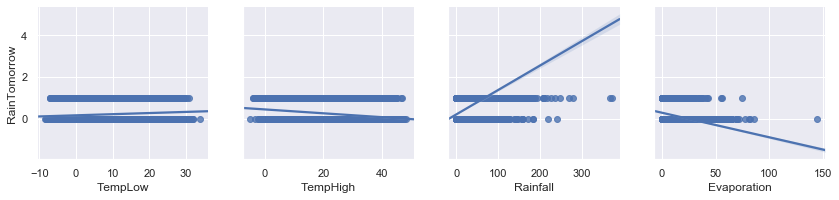

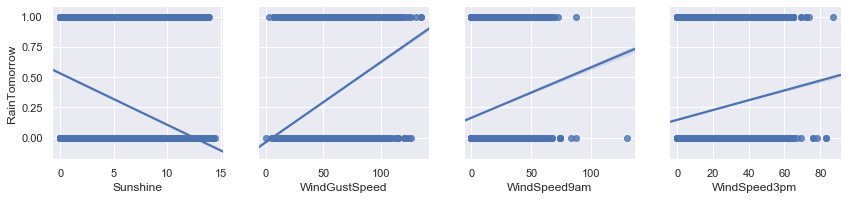

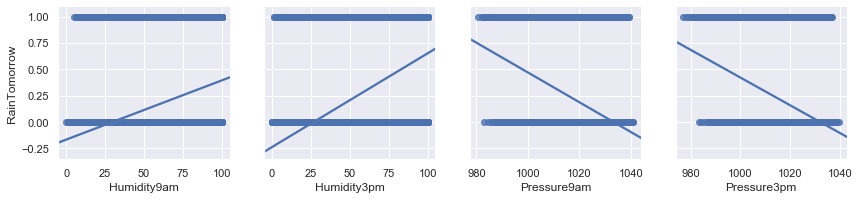

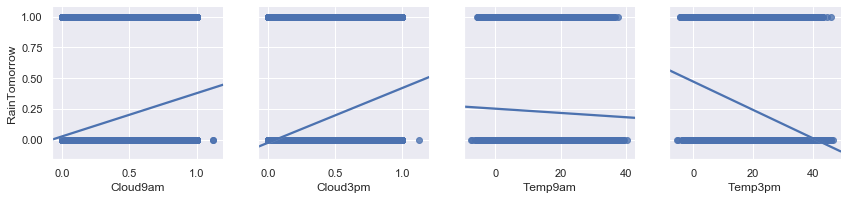

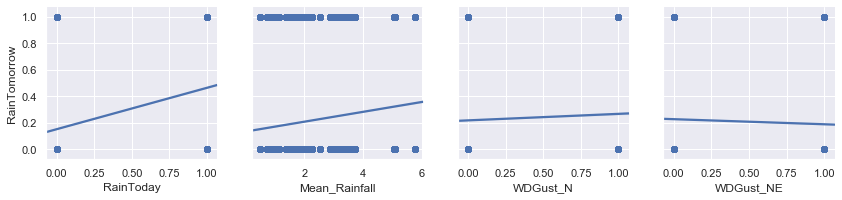

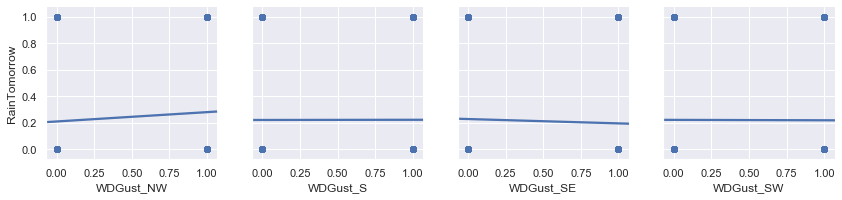

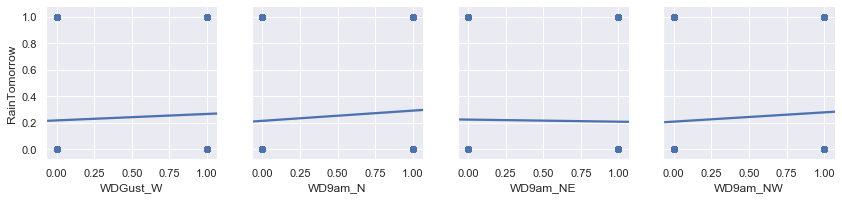

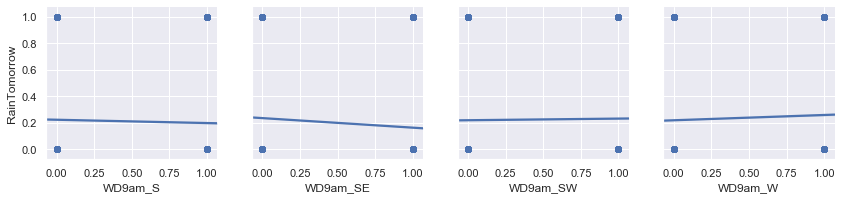

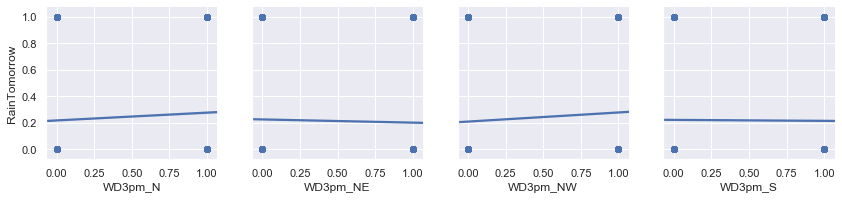

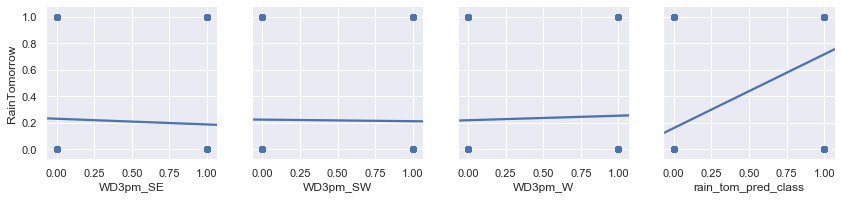

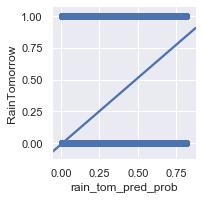

In [315]:
# Function to plot each feature vs target variable
def pplot_features(df, features):
    pp_rows = [features[i:i+4] for i in range(0, len(features), 4)]
    for row in pp_rows:
        pp = sns.pairplot(data=df, x_vars=row, y_vars='RainTomorrow', kind='reg', height=3)
    return plt.show()
features = new_df.drop(['RainTomorrow', 'Date', 'Location', 'Lat_Lon'], axis=1).keys()
pplot_features(test, features)

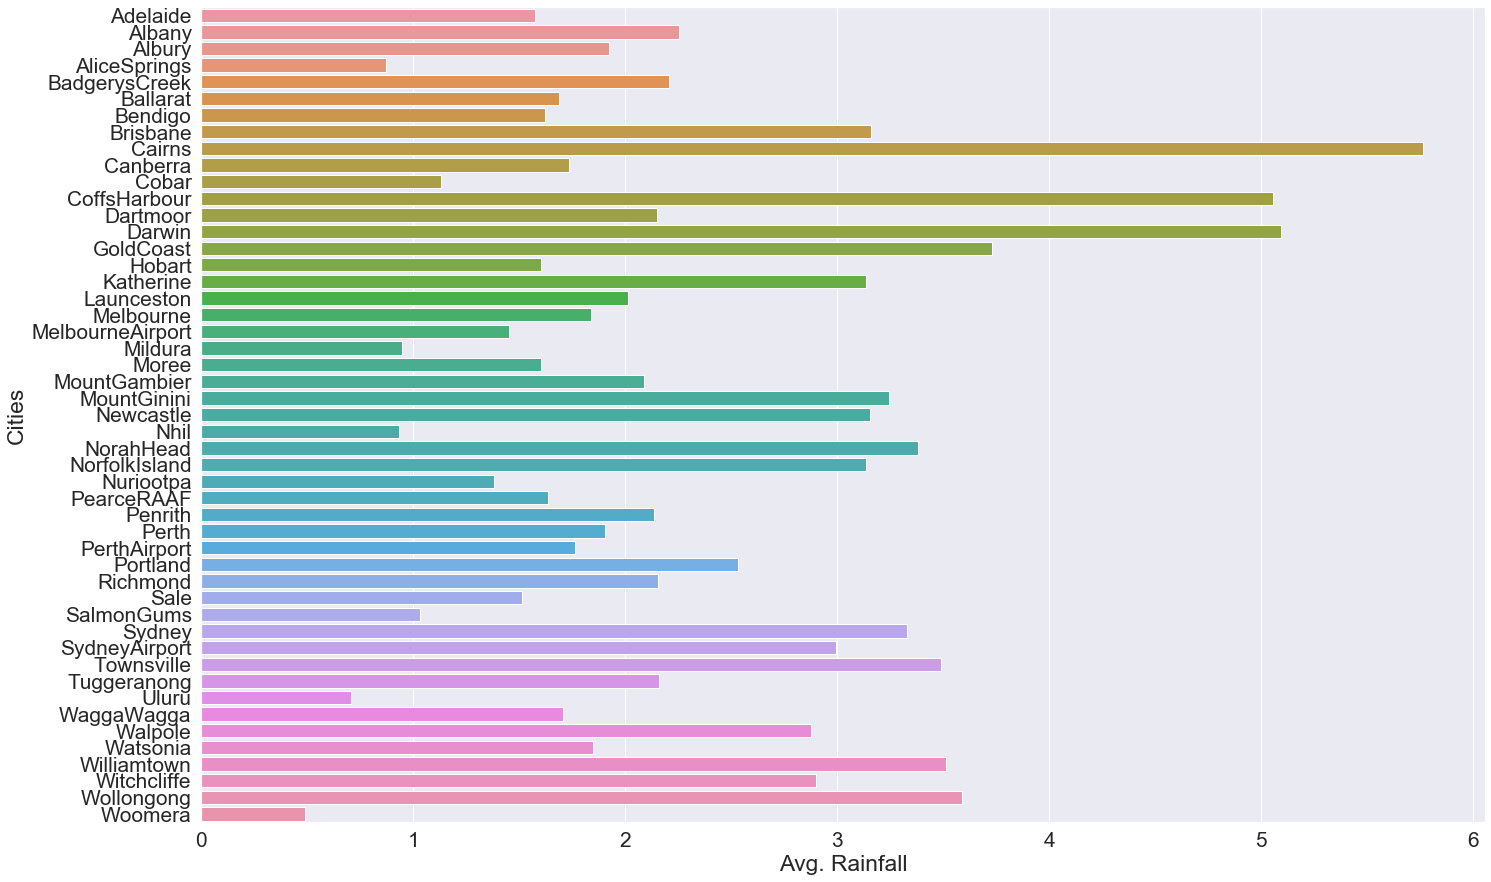

In [300]:
fig, ax = plt.subplots(figsize=(23,15))
ax = sns.barplot(x='Mean_Rainfall', y='Location', data=new_df)

sns.set(font_scale=1.9)
plt.ylabel('Cities')
plt.xlabel('Avg. Rainfall')

plt.savefig('jude_variable.png', dpi = 200)

In [68]:
# creating dataframes for +/- instances of rain today/tomorrow
yes_tom = new_df[new_df['RainTomorrow'] == 1]
no_tom = new_df[new_df['RainTomorrow'] == 0]
yes_tod = new_df[new_df['RainToday'] == 1]
no_tod = new_df[new_df['RainToday'] == 0]

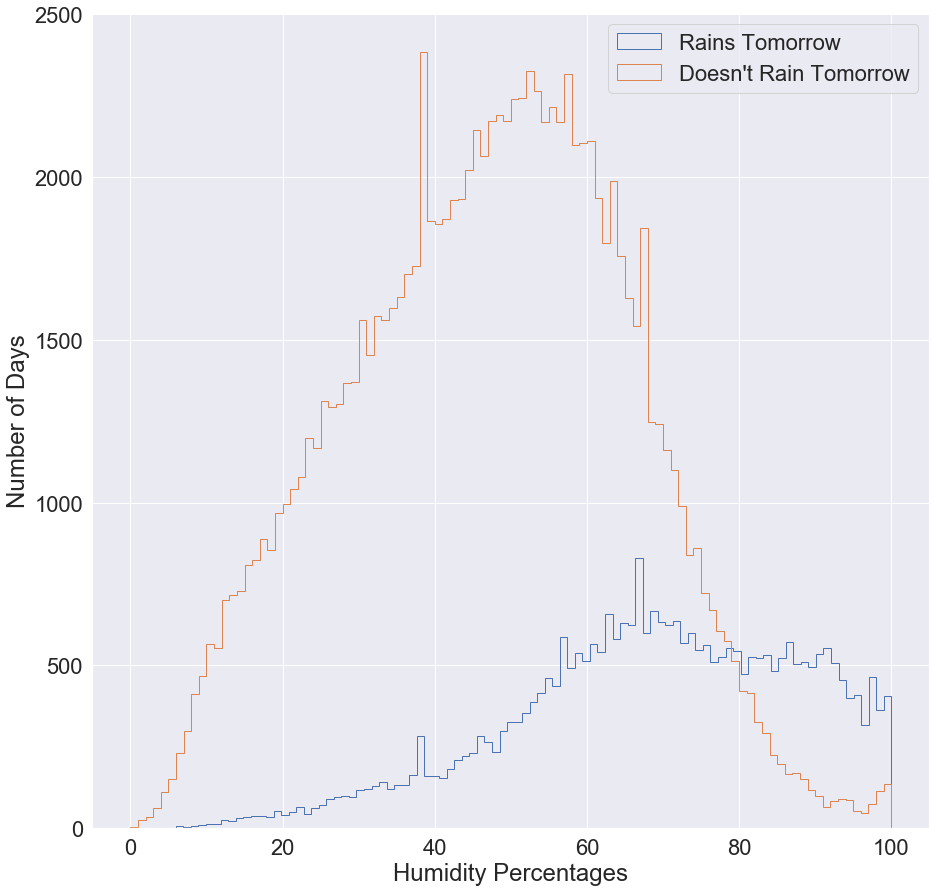

In [335]:
# graphing distribution of humidity3pm for +/_ instances of rain tomorrow
fig, ax = plt.subplots(figsize=(15,15))

ax.hist(yes_tom['Humidity3pm'], label="Rains Tomorrow", bins=100, histtype='step')
ax.hist(no_tom['Humidity3pm'], label="Doesn't Rain Tomorrow", bins=100, histtype='step')

sns.set(font_scale=2)

ax.set_xlabel('Humidity Percentages')
ax.set_ylabel('Number of Days')
# ax.set_title('Distribution of Humidity Levels')

ax.legend()
plt.savefig('humidity_tomorrow.png', dpi = 200)

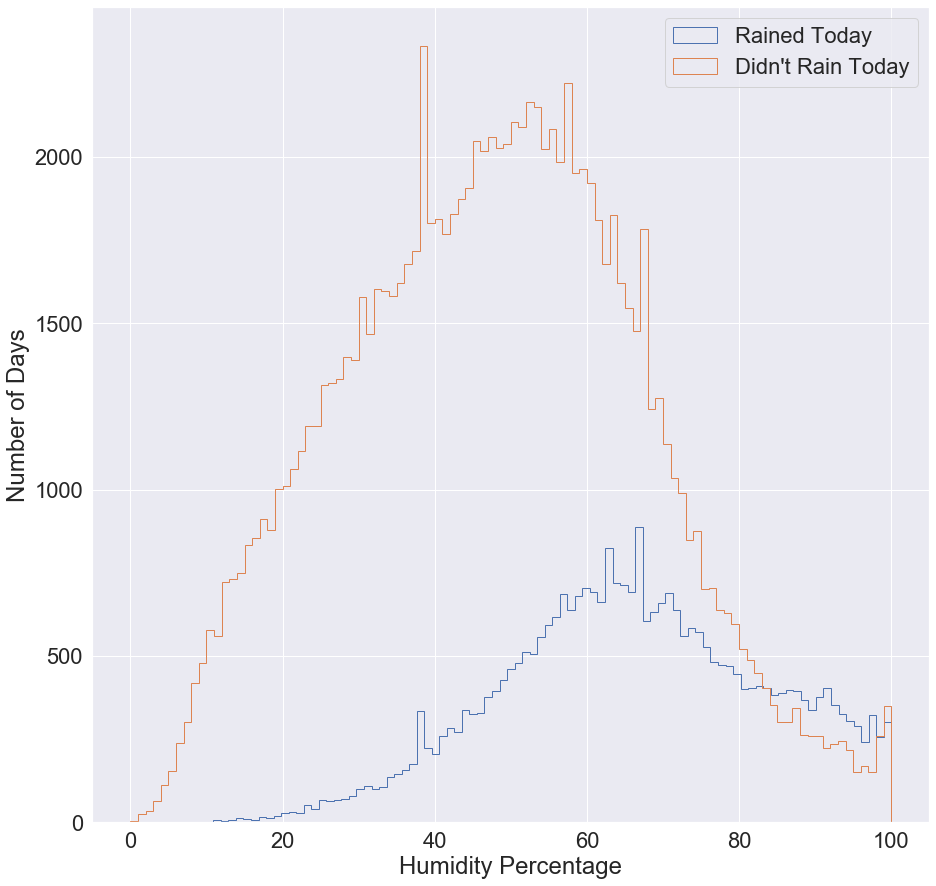

In [336]:
# graphing distribution of humidity3pm for +/_ instances of rain today
fig, ax = plt.subplots(figsize=(15,15))

ax.hist(yes_tod['Humidity3pm'], label="Rained Today", bins=100, histtype='step')
ax.hist(no_tod['Humidity3pm'], label="Didn't Rain Today", bins=100, histtype='step')

sns.set(font_scale=2)

ax.set_xlabel('Humidity Percentage')
ax.set_ylabel('Number of Days')
# ax.set_title('Distribution of Humidity Levels')


ax.legend()
plt.savefig('humidity_today.png', dpi = 200)

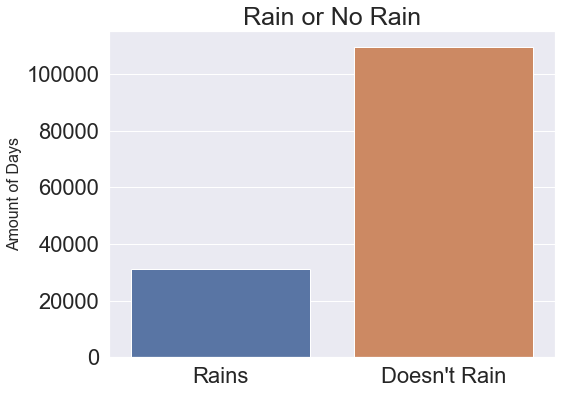

In [345]:
# countplot of rain tomorrow vs doesnt rain tomorrow
ax, fig = plt.subplots(figsize=(8,6))
ax = sns.barplot(x=["Rains", "Doesn't Rain"], y=[new_df.RainTomorrow.sum(),(len(new_df)) - new_df.RainTomorrow.sum()],
            data=new_df)


font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16}
# plt.xlabel('Will it Rain?', fontdict={'size':16})
plt.ylabel('Amount of Days', fontdict={'size':16})
plt.title('Rain or No Rain', fontdict={'size':25})

plt.savefig('rain_or_no_rain.png', dpi = 300)

# Unused Code

In [18]:
# city_names = ['Adelaide','Albany','Albury','AliceSprings','BadgerysCreek',
#               'Ballarat','Bendigo','Brisbane','Cairns','Canberra','Cobar','CoffsHarbour',
#               'Dartmoor','Darwin','GoldCoast','Hobart','Katherine','Launceston','Melbourne',
#               'MelbourneAirport','Mildura','Moree','MountGambier','MountGinini','Newcastle',
#               'Nhil','NorahHead','NorfolkIsland','Nuriootpa','PearceRAAF','Penrith','Perth',
#               'PerthAirport','Portland','Richmond','Sale','SalmonGums','Sydney','SydneyAirport',
#               'Townsville','Tuggeranong','Uluru','WaggaWagga','Walpole','Watsonia','Williamtown',
#               'Witchcliffe','Wollongong','Woomera']

# lat_lon = [(-34.9281805, 138.5999312),(-35.0247822, 117.883608),(-36.0804766, 146.9162795),
#            (-23.6983884, 133.8812885),(-35.8348792, 149.9957662),(-37.5622632, 143.8607215),
#            (-36.7588767, 144.2825931),(-27.4689682, 153.0234991),(-16.9206657, 145.7721854),
#            (-35.2975906, 149.1012676),(-31.4983333, 145.8344444),(-30.2962407, 153.1135293),
#            (-37.9225444, 141.2766551),(-12.46044, 130.8410469),(-28.0023731, 153.4145987),
#            (-42.8825088, 147.3281233),(-14.4642313, 132.2638568),(-41.4340813, 147.1373496),
#            (-37.8142176, 144.9631608),(-37.667111000000006, 144.83348076679553),
#            (-34.1847265, 142.1624972),(-29.4617202, 149.8407153),(-37.8246698, 140.7820067624113),
#            (-35.5297196, 148.7726345),(-32.9272881, 151.7812534),(-35.4325283, 141.2833187),
#            (-33.2816667, 151.5677778),(-29.0328038, 167.9483137),(-34.4693354, 138.9939006),
#            (-31.6739604, 116.01754351808194),(-33.7510792, 150.6941684),(-31.9527121, 115.8604796),
#            (-31.9431218, 115.9668059888865),(-38.363435, 141.6056055089348),
#            (-37.80745, 144.99071757972087),(-38.106605, 147.06794525572298),
#            (-32.9815347, 121.6439417),(-33.8548157, 151.2164539),(-33.9498935, 151.18196819346016),
#            (-19.2569391, 146.8239537),(-35.4209771, 149.0921341),(-25.3455545, 131.03696147470208),
#            (-35.115, 147.3677778),(-34.9776796, 116.7310063),(-37.7110022, 145.083635),
#            (-32.815, 151.8427778),(-34.0263348, 115.1004768),(-34.4243941, 150.89385),
#            (-31.1999142, 136.8253532)]

# loc_dict = dict(zip(city_names, lat_lon))

In [6]:
# Fill categorical NA values with the value from previous day
df['WindGustDir'].fillna(method = 'bfill', inplace=True)
df['WindDir9am'].fillna(method = 'bfill', inplace=True)
df['WindDir3pm'].fillna(method = 'bfill', inplace=True)
# df['RainToday'].fillna(method = 'bfill', inplace=True)

# Drop rows where rain today value is NA
df = df.dropna(subset=['RainToday'])
df.shape

In [7]:
# Fill continuous NA values with the median value
continuous_cols = ['TempLow', 'TempHigh', 'Rainfall', 'Evaporation', 'Sunshine',
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                   'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
                   'Cloud3pm', 'Temp9am', 'Temp3pm']

for col in continuous_cols:
    col_median = df[col].median()
    df[col].fillna(col_median, inplace=True)

# Creating Splits

In [355]:
X = new_df.drop(['Date','Location','Lat_Lon','RainTomorrow', 'rain_tom_pred_class', 'rain_tom_pred_prob'], axis=1)
y = new_df['RainTomorrow']
feature_cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scaling Data

In [165]:
# Function to apply standard scalar
def std_sclr(df):
    scale = StandardScaler()
    trans = scale.fit_transform(df)
    return pd.DataFrame(trans, columns=df.columns)
# Scale train and holdout data
# model_df_scl = std_sclr(model_df.drop('RainTomorrow', axis=1))
# Scale train and test data
X_train_scl = std_sclr(X_train)
X_test_scl = std_sclr(X_test)

# LogReg for attempt at EDA

In [157]:
# Function to fit a logistic regression model
def lr(X_train, y_train):
    lr = LogisticRegression(C=1, penalty='l1', solver='liblinear')
    lr_fit = lr.fit(X_train, y_train)
    return lr_fit

In [195]:
# Fit logistic regression model on train data, predict on test data
lr_fit = lr(X_train, y_train)
lr_pred = lr_fit.predict(X_test)
# F1 score of logistic regression predictions
f1_score(lr_pred, y_test)

/Users/samraykhman/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5869252183930114

In [170]:
# Fit logistic regression model on scaled train data, predict on scaled test data
lr_fit_scl = lr(X_train_scl, y_train)
lr_pred_scl = lr_fit_scl.predict(X_test_scl)
# F1 score of scaled logistic regression predictions
accuracy_score(lr_pred_scl, y_test), precision_score(lr_pred_scl, y_test), f1_score(
    lr_pred_scl, y_test)

(0.8488173875985511, 0.5059051933344119, 0.5949957187708115)

In [339]:
new_df['rain_tom_pred_class'] = lr_fit_scl.predict(X)

ValueError: X has 41 features per sample; expecting 39

In [180]:
new_df['rain_tom_pred_prob'] = lr_fit_scl.predict_proba(X)[:, 1]

In [193]:
# # attempt to graph logistic regression of humidity for the target
# plt.scatter(new_df.Humidity3pm, new_df.RainTomorrow)
# plt.plot(new_df.Humidity3pm, new_df.rain_tom_pred_prob, color='red')
# plt.xlabel('Humid')
# plt.ylabel('TOmorrow')

Text(0, 0.5, 'TOmorrow')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11a0c7dd0> (for post_execute):


OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1080x1080 with 1 Axes>

# XGBoost Model 

In [169]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV, KFold

In [167]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [356]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, # max features
                           subsample = 0.5, #max samples
                           learning_rate = 0.1,
                           max_depth = 4, 
                           alpha = 1, 
                           scale_pos_weight= new_df['RainTomorrow'].mean(),
                           n_estimators = 10000)

In [357]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=0.22161847329654016,
              subsample=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [358]:
preds = xg_clf.predict(X_test)

test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)
test_prec = precision_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("Precision: %f" % (test_prec))
print("F1: %f" % (test_f1))

Accuracy: 0.858797
Precision: 0.843565
F1: 0.576571


In [381]:
# setting params for feature importance plot
data_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 4, 
          'alpha': 1}

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=5,
                    num_boost_round=500,
                    early_stopping_rounds=5,
                    metrics="logloss", 
                    as_pandas=True, 
                    seed=123)

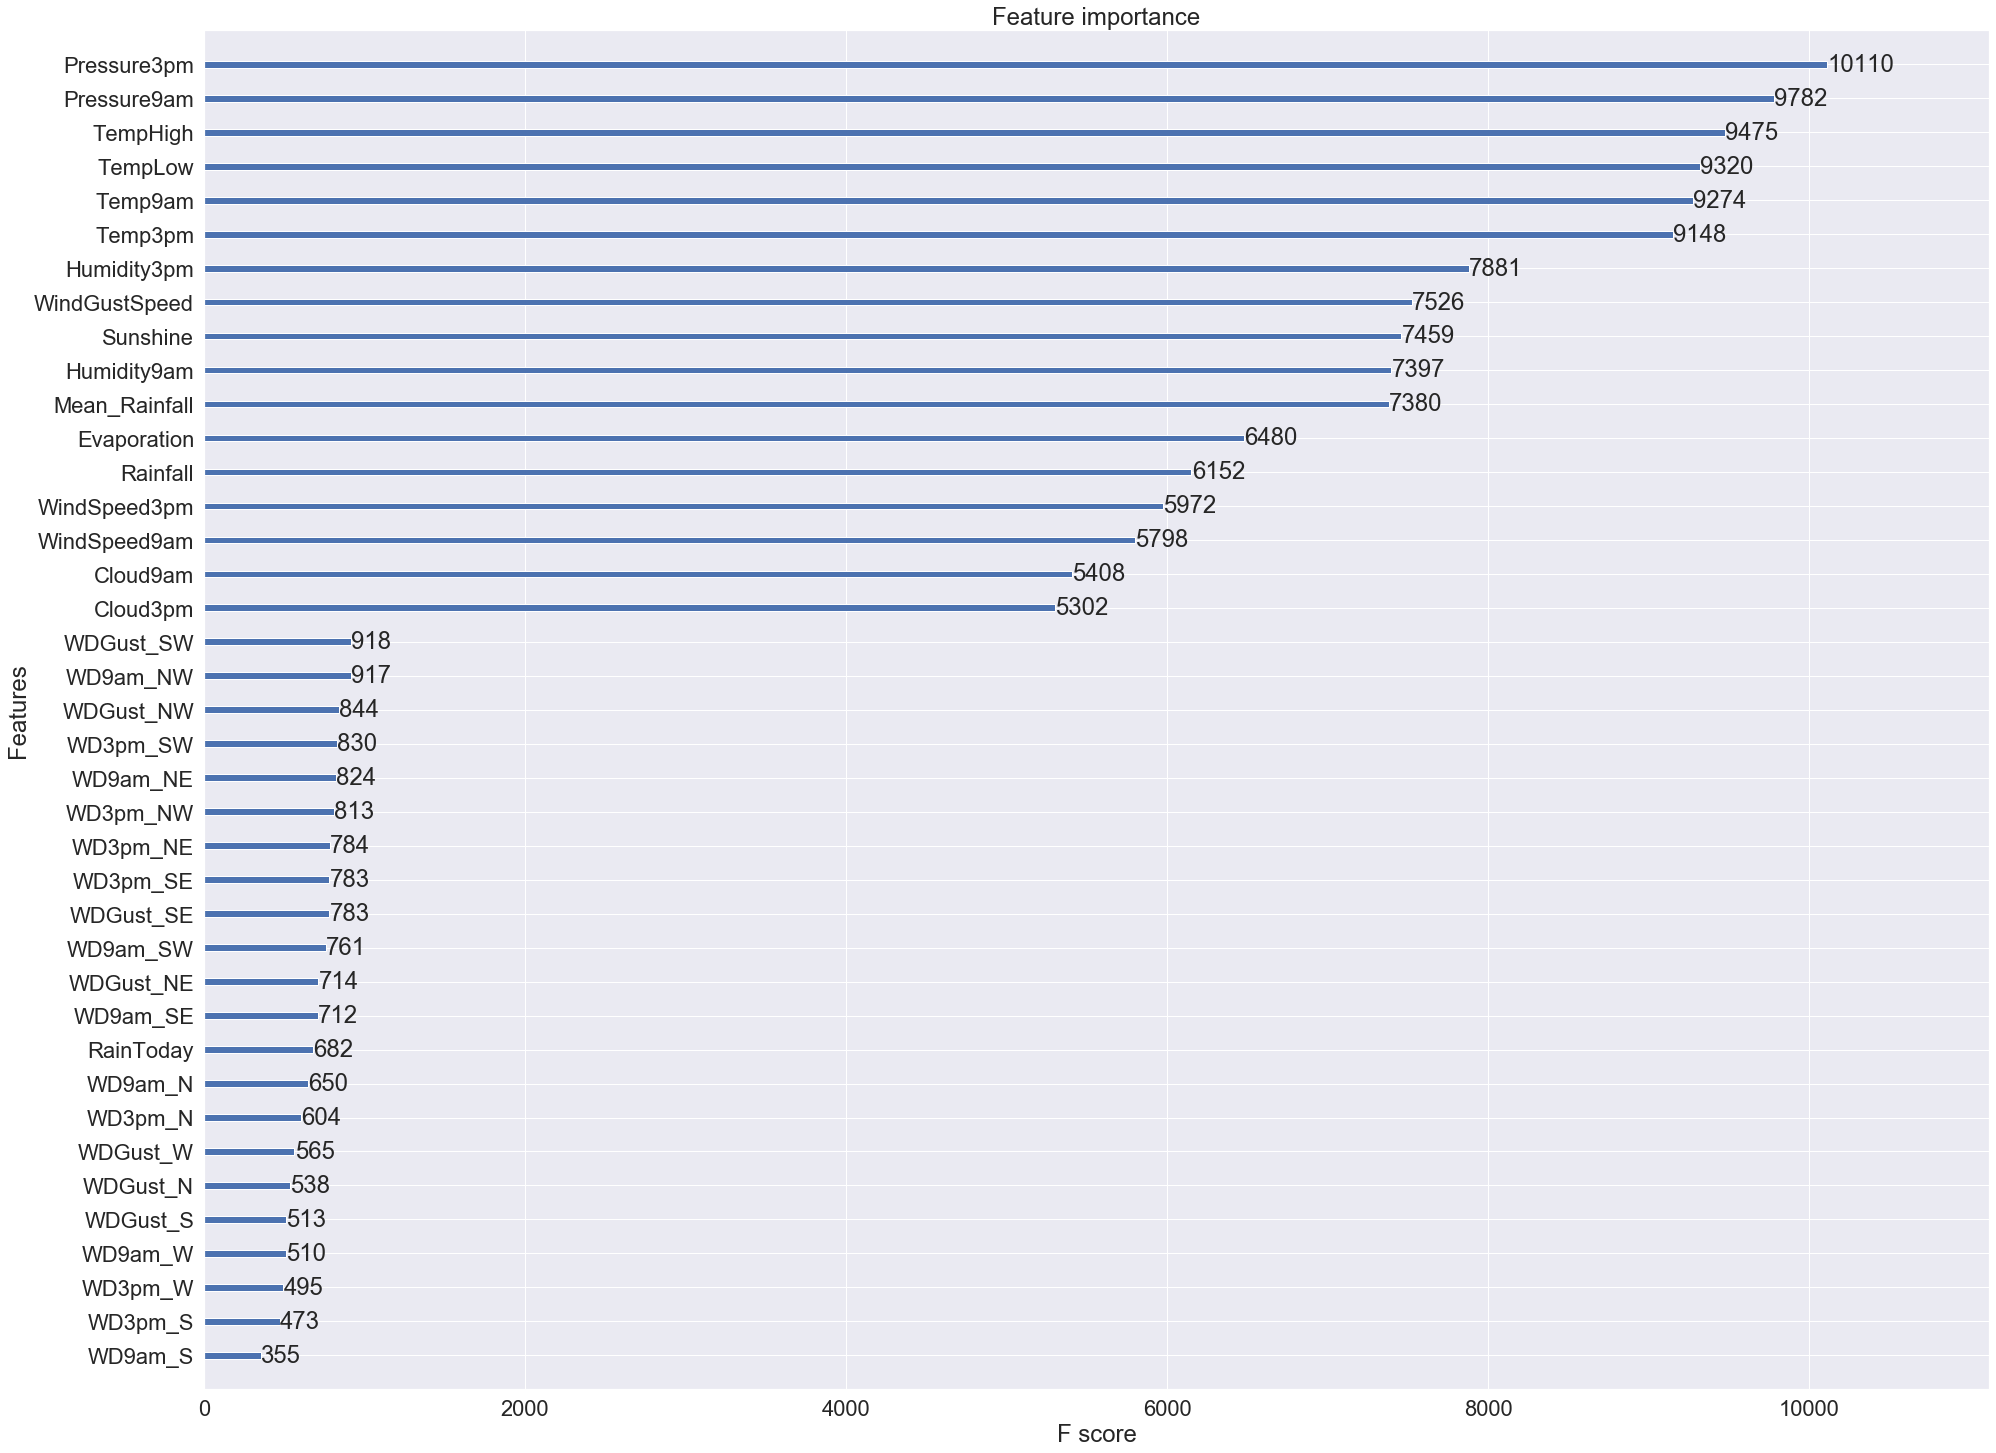

In [362]:
# plotting feature importance
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [32, 25]
# plt.show()
# plt.rc()

# plt.savefig('feature_importance.png', dpi = 100)

# Attempting to run Grid for XGBoost

In [377]:
grid_xgb = xgb.XGBClassifier(scale_pos_weight= new_df['RainTomorrow'].mean(), objective = 'binary:logistic',
                             seed = 1)
param_dist = {'n_estimators': [100,300,500],
              'learning_rate': [0.05,0.09,0.1,0.2],
              'max_depth': [4, 5, 6, 7],
              'colsample_bytree': [0.2,0.3,0.4,0.5],
              'min_child_weight': [0.5,1, 2, 3]}

In [378]:
gsearch1 = GridSearchCV(
    estimator = grid_xgb,
    param_grid = param_dist, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [379]:
# model took too long to run and I couldnt finish it (ran for over 10 hours)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 102.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 173.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 265.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 397.7min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 593.5min


KeyboardInterrupt: 